# Modification of the original code
I just took the code of the winner of the RSNA 2022 cervical spine fracture detection competition.  
Link: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage1

# 1st Place Solution Training 3D Semantic Segmentation (Stage1)

Hi all,

I'm very exciting to writing this notebook and the summary of our solution here.

This is FULL version of training my final models (stage1), using resnet18d as backbone, unet as decoder and using 128x128x128 as input.

NOTE: **You need to run this code locally because the RAM is not enough here.**

NOTE2: **It is highly recommended to pre-process the 3D semantic segmentation training data first and save it locally, which can greatly speed up the loading of the data.**

My brief summary of winning solution: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/362607

* Train Stage1 Notebook: This notebook
* Train Stage2 (Type1) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type1
* Train Stage2 (Type2) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type2
* Inference Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-inference

**If you find these notebooks helpful please upvote. Thanks! **

In [1]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import gzip
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from monai.transforms import Resize
import monai.transforms as transforms


%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

sys.path.append('./lib_models')

import timm_new

/home/junseonglee/miniconda3/envs/rsna_abtd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
DEBUG = False
OPT_SHAPE = [160, 160, 160]

BASE_PATH = '/home/junseonglee/Desktop/01_codes/inputs/rsna-2023-abdominal-trauma-detection'
MASK_SAVE_PATH = f'{BASE_PATH}/mask_preprocessed'
LOAD_WEIGHT_PATH = None

kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'timm/resnet10t.c3_in1k'

R = Resize(OPT_SHAPE)

init_lr = 3e-3
batch_size = 3
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '../input/rsna-2022-cervical-spine-fracture-detection'
use_amp = True
num_workers = 8
out_dim = 5

n_epochs = 1000

log_dir = f'{BASE_PATH}/seg_models/logs'
model_dir = f'{BASE_PATH}/seg_models/models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [3]:
transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(OPT_SHAPE, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_train_images = transforms.Compose([
    #transforms.RandGaussianNoise(prob=0.1),
    #transforms.RandAdjustContrast(prob=0.1),
    #transforms.RandGaussianSmooth(prob=0.1),        
    #transforms.RandGaussianSharpen(prob=0.1),
    #transforms.RandHistogramShift(prob=0.1),
])

transforms_valid = transforms.Compose([
])

# DataFrame

In [4]:
df_seg = pd.read_csv(f'{BASE_PATH}/seg_info.csv')

kf = KFold(5, shuffle = True, random_state = 0)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail()

,patient_id,series,mask_path,img_path,fold
201,13741,6172,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,2
202,18877,61403,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,2
203,15876,38633,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,2
204,60744,397,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,3
205,24524,40496,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,0


# Dataset

In [5]:
def decompress(name):
    with gzip.open(name, 'rb') as f:
        data = pickle.load(f)
    return data


def load_sample(row, has_mask=True):
    image = decompress(row['img_path'])[None]

    if has_mask:
        mask = decompress(row['mask_path'])
        
        return image, mask
    else:
        return image



class SEGDataset(Dataset):
    def __init__(self, df, mode, transform, transform_image=None):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform
        self.transform_image = transform_image
        self.images = []
        self.masks  = []
        for i in tqdm(range(0, len(df))):
            image, mask = load_sample(df.iloc[i], has_mask=True)
            self.images.append(image)
            self.masks.append(mask)
            
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        #row = self.df.iloc[index]
        #image, mask = load_sample(row, has_mask=True)
        image = torch.clone(self.images[index])
        mask  = self.masks[index].copy()
        #image = torch.from_numpy(image).to(torch.float32)
        mask  = torch.from_numpy(mask).to(torch.float32)

        res = self.transform({'image':image, 'mask':mask})
        image = res['image']
        mask  = res['mask']
        
        if self.transform_image is not None:
            image = self.transform_image(image)
                    
        #image = R(image)
        #mask  = R(mask)

        image_avg = torch.mean(image, (1, 2, 3))
        image_std = torch.std(image,  (1, 2, 3))
        image = (image-image_avg)/image_std

        return image, mask


In [6]:
rcParams['figure.figsize'] = 20,8

df_show = df_seg
dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)

100%|██████████| 206/206 [00:07<00:00, 28.06it/s]


# Model

In [7]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm_new.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 1, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [8]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 1, OPT_SHAPE[0], OPT_SHAPE[1], OPT_SHAPE[2])).shape

torch.Size([1, 5, 160, 160, 160])

# Loss & Metric

In [9]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

# Train & Valid func

In [10]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    batch_metrics = [[]] * 9
    bar = tqdm(loader_valid)
    with torch.no_grad():
        with amp.autocast():
            for images, gt_masks in bar:
                images = images.cuda()
                gt_masks = gt_masks.cuda()

                logits = model(images)
                loss = criterion(logits, gt_masks)
                valid_loss.append(loss.item())
                for thi, th in enumerate(ths):
                    pred = (logits.sigmoid() > th).float().detach().cpu()
                    for i in range(logits.shape[0]):
                        tmp = multilabel_dice_score(
                            #y_pred=logits[i].sigmoid().cpu(),
                            y_pred = pred[i],
                            y_true=gt_masks[i].cpu(),
                            threshold=0.5,
                        )
                        batch_metrics[thi].extend(tmp)
                bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics), ths[np.argmax(metrics)]


/home/junseonglee/miniconda3/envs/rsna_abtd/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/junseonglee/miniconda3/envs/rsna_abtd/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an

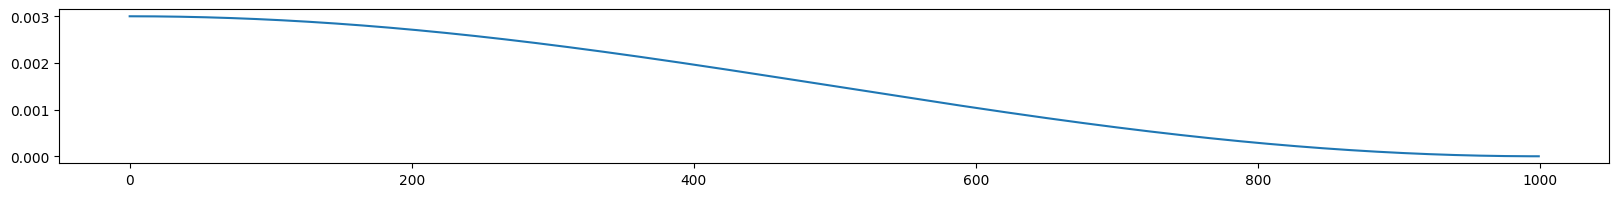

In [11]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [12]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train, transform_image=transforms_train_images)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, pin_memory = True, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, pin_memory = True, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    if LOAD_WEIGHT_PATH is not None:
        model.load_state_dict(torch.load(LOAD_WEIGHT_PATH))
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric, best_thres = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f},'
        content+= f'train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f} at thres {best_thres}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [13]:
run(0)
run(1)
run(2)
run(3)
run(4)

100%|██████████| 42/42 [00:01<00:00, 27.70it/s]


164 42
Sat Sep 30 14:07:49 2023 Epoch: 1


smth:0.4428: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.14093370329169957
Sat Sep 30 14:08:51 2023 Fold 0, Epoch 1, lr: 0.0030000,train loss: 0.31147, valid loss: 0.44283, metric: 0.140934 at thres 0.1.
metric_best (0.000000 --> 0.140934). Saving model ...
Sat Sep 30 14:08:52 2023 Epoch: 2


smth:0.2148: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.26234934847226604
Sat Sep 30 14:09:41 2023 Fold 0, Epoch 2, lr: 0.0030000,train loss: 0.22828, valid loss: 0.21479, metric: 0.262349 at thres 0.1.
metric_best (0.140934 --> 0.262349). Saving model ...
Sat Sep 30 14:09:41 2023 Epoch: 3


smth:0.2220: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.2655835097971587
Sat Sep 30 14:10:31 2023 Fold 0, Epoch 3, lr: 0.0030000,train loss: 0.21235, valid loss: 0.22197, metric: 0.265584 at thres 0.1.
metric_best (0.262349 --> 0.265584). Saving model ...
Sat Sep 30 14:10:31 2023 Epoch: 4


smth:0.2822: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.23743499710493224
Sat Sep 30 14:11:13 2023 Fold 0, Epoch 4, lr: 0.0029999,train loss: 0.19993, valid loss: 0.28221, metric: 0.237435 at thres 0.1.
Sat Sep 30 14:11:14 2023 Epoch: 5


smth:0.2311: 100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


best th: 0.1 best dc: 0.25474888450216704
Sat Sep 30 14:11:56 2023 Fold 0, Epoch 5, lr: 0.0029999,train loss: 0.20248, valid loss: 0.23111, metric: 0.254749 at thres 0.1.
Sat Sep 30 14:11:57 2023 Epoch: 6


smth:0.2017: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.27252046706376015
Sat Sep 30 14:12:46 2023 Fold 0, Epoch 6, lr: 0.0029998,train loss: 0.18718, valid loss: 0.20172, metric: 0.272520 at thres 0.1.
metric_best (0.265584 --> 0.272520). Saving model ...
Sat Sep 30 14:12:46 2023 Epoch: 7


smth:0.3737: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.11709525561838798
Sat Sep 30 14:13:35 2023 Fold 0, Epoch 7, lr: 0.0029997,train loss: 0.17032, valid loss: 0.37375, metric: 0.117095 at thres 0.1.
Sat Sep 30 14:13:35 2023 Epoch: 8


smth:0.1904: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.29034224165705447
Sat Sep 30 14:14:24 2023 Fold 0, Epoch 8, lr: 0.0029996,train loss: 0.18460, valid loss: 0.19040, metric: 0.290342 at thres 0.1.
metric_best (0.272520 --> 0.290342). Saving model ...
Sat Sep 30 14:14:25 2023 Epoch: 9


smth:0.2154: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.2686314416135916
Sat Sep 30 14:15:14 2023 Fold 0, Epoch 9, lr: 0.0029995,train loss: 0.17494, valid loss: 0.21540, metric: 0.268631 at thres 0.1.
Sat Sep 30 14:15:14 2023 Epoch: 10


smth:0.1897: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.2882650669491206
Sat Sep 30 14:16:03 2023 Fold 0, Epoch 10, lr: 0.0029994,train loss: 0.16883, valid loss: 0.18974, metric: 0.288265 at thres 0.1.
Sat Sep 30 14:16:03 2023 Epoch: 11


smth:0.1589: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.3103618851615476
Sat Sep 30 14:16:52 2023 Fold 0, Epoch 11, lr: 0.0029993,train loss: 0.14874, valid loss: 0.15893, metric: 0.310362 at thres 0.1.
metric_best (0.290342 --> 0.310362). Saving model ...
Sat Sep 30 14:16:53 2023 Epoch: 12


smth:0.1862: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


best th: 0.1 best dc: 0.29273925686070507
Sat Sep 30 14:17:36 2023 Fold 0, Epoch 12, lr: 0.0029991,train loss: 0.16732, valid loss: 0.18616, metric: 0.292739 at thres 0.1.
Sat Sep 30 14:17:37 2023 Epoch: 13


smth:0.1810: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.2860491764210197
Sat Sep 30 14:18:26 2023 Fold 0, Epoch 13, lr: 0.0029989,train loss: 0.16682, valid loss: 0.18100, metric: 0.286049 at thres 0.1.
Sat Sep 30 14:18:26 2023 Epoch: 14


smth:0.1738: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.29131209300623867
Sat Sep 30 14:19:13 2023 Fold 0, Epoch 14, lr: 0.0029987,train loss: 0.14534, valid loss: 0.17383, metric: 0.291312 at thres 0.1.
Sat Sep 30 14:19:13 2023 Epoch: 15


smth:0.1635: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.30137168966342764
Sat Sep 30 14:20:01 2023 Fold 0, Epoch 15, lr: 0.0029985,train loss: 0.14800, valid loss: 0.16345, metric: 0.301372 at thres 0.1.
Sat Sep 30 14:20:01 2023 Epoch: 16


smth:0.1507: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.3183318031520332
Sat Sep 30 14:20:49 2023 Fold 0, Epoch 16, lr: 0.0029983,train loss: 0.13675, valid loss: 0.15066, metric: 0.318332 at thres 0.1.
metric_best (0.310362 --> 0.318332). Saving model ...
Sat Sep 30 14:20:49 2023 Epoch: 17


smth:0.1558: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.3105968737201526
Sat Sep 30 14:21:38 2023 Fold 0, Epoch 17, lr: 0.0029981,train loss: 0.15092, valid loss: 0.15583, metric: 0.310597 at thres 0.1.
Sat Sep 30 14:21:38 2023 Epoch: 18


smth:0.1526: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.31094621922883303
Sat Sep 30 14:22:28 2023 Fold 0, Epoch 18, lr: 0.0029979,train loss: 0.15340, valid loss: 0.15264, metric: 0.310946 at thres 0.1.
Sat Sep 30 14:22:28 2023 Epoch: 19


smth:0.1347: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.324219377882509
Sat Sep 30 14:23:16 2023 Fold 0, Epoch 19, lr: 0.0029976,train loss: 0.13404, valid loss: 0.13467, metric: 0.324219 at thres 0.1.
metric_best (0.318332 --> 0.324219). Saving model ...
Sat Sep 30 14:23:17 2023 Epoch: 20


smth:0.1803: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.28661282124929716
Sat Sep 30 14:24:06 2023 Fold 0, Epoch 20, lr: 0.0029973,train loss: 0.13438, valid loss: 0.18026, metric: 0.286613 at thres 0.1.
Sat Sep 30 14:24:06 2023 Epoch: 21


smth:0.1570: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.3228874090129359
Sat Sep 30 14:24:55 2023 Fold 0, Epoch 21, lr: 0.0029970,train loss: 0.15028, valid loss: 0.15697, metric: 0.322887 at thres 0.1.
Sat Sep 30 14:24:56 2023 Epoch: 22


smth:0.1706: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.39069446594138485
Sat Sep 30 14:25:44 2023 Fold 0, Epoch 22, lr: 0.0029967,train loss: 0.13617, valid loss: 0.17055, metric: 0.390694 at thres 0.1.
metric_best (0.324219 --> 0.390694). Saving model ...
Sat Sep 30 14:25:44 2023 Epoch: 23


smth:0.1409: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.3558559951673409
Sat Sep 30 14:26:34 2023 Fold 0, Epoch 23, lr: 0.0029964,train loss: 0.13004, valid loss: 0.14088, metric: 0.355856 at thres 0.1.
Sat Sep 30 14:26:35 2023 Epoch: 24


smth:0.1362: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.40647918478223505
Sat Sep 30 14:27:17 2023 Fold 0, Epoch 24, lr: 0.0029961,train loss: 0.13019, valid loss: 0.13620, metric: 0.406479 at thres 0.1.
metric_best (0.390694 --> 0.406479). Saving model ...
Sat Sep 30 14:27:18 2023 Epoch: 25


smth:0.1261: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.4461194632937254
Sat Sep 30 14:28:07 2023 Fold 0, Epoch 25, lr: 0.0029957,train loss: 0.12472, valid loss: 0.12614, metric: 0.446119 at thres 0.1.
metric_best (0.406479 --> 0.446119). Saving model ...
Sat Sep 30 14:28:07 2023 Epoch: 26


smth:0.1419: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.4320000927677108
Sat Sep 30 14:28:55 2023 Fold 0, Epoch 26, lr: 0.0029954,train loss: 0.12897, valid loss: 0.14188, metric: 0.432000 at thres 0.1.
Sat Sep 30 14:28:55 2023 Epoch: 27


smth:0.1465: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.43674799198784503
Sat Sep 30 14:29:43 2023 Fold 0, Epoch 27, lr: 0.0029950,train loss: 0.12792, valid loss: 0.14654, metric: 0.436748 at thres 0.1.
Sat Sep 30 14:29:43 2023 Epoch: 28


smth:0.1216: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.46669264614048905
Sat Sep 30 14:30:32 2023 Fold 0, Epoch 28, lr: 0.0029946,train loss: 0.11754, valid loss: 0.12157, metric: 0.466693 at thres 0.1.
metric_best (0.446119 --> 0.466693). Saving model ...
Sat Sep 30 14:30:32 2023 Epoch: 29


smth:0.1158: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


best th: 0.1 best dc: 0.4753014361062362
Sat Sep 30 14:31:18 2023 Fold 0, Epoch 29, lr: 0.0029942,train loss: 0.10776, valid loss: 0.11582, metric: 0.475301 at thres 0.1.
metric_best (0.466693 --> 0.475301). Saving model ...
Sat Sep 30 14:31:18 2023 Epoch: 30


smth:0.1452: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.5433221809964963
Sat Sep 30 14:32:05 2023 Fold 0, Epoch 30, lr: 0.0029938,train loss: 0.11127, valid loss: 0.14516, metric: 0.543322 at thres 0.1.
metric_best (0.475301 --> 0.543322). Saving model ...
Sat Sep 30 14:32:05 2023 Epoch: 31


smth:0.1093: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.6109959903963962
Sat Sep 30 14:32:55 2023 Fold 0, Epoch 31, lr: 0.0029933,train loss: 0.11574, valid loss: 0.10929, metric: 0.610996 at thres 0.1.
metric_best (0.543322 --> 0.610996). Saving model ...
Sat Sep 30 14:32:55 2023 Epoch: 32


smth:0.1117: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.6017947038027242
Sat Sep 30 14:33:44 2023 Fold 0, Epoch 32, lr: 0.0029929,train loss: 0.10749, valid loss: 0.11170, metric: 0.601795 at thres 0.1.
Sat Sep 30 14:33:45 2023 Epoch: 33


smth:0.1080: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.6097297165605335
Sat Sep 30 14:34:34 2023 Fold 0, Epoch 33, lr: 0.0029924,train loss: 0.10963, valid loss: 0.10801, metric: 0.609730 at thres 0.1.
Sat Sep 30 14:34:35 2023 Epoch: 34


smth:0.0991: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.6251947045893576
Sat Sep 30 14:35:23 2023 Fold 0, Epoch 34, lr: 0.0029919,train loss: 0.10315, valid loss: 0.09907, metric: 0.625195 at thres 0.1.
metric_best (0.610996 --> 0.625195). Saving model ...
Sat Sep 30 14:35:23 2023 Epoch: 35


smth:0.1000: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.736869813513034
Sat Sep 30 14:36:13 2023 Fold 0, Epoch 35, lr: 0.0029915,train loss: 0.10327, valid loss: 0.09996, metric: 0.736870 at thres 0.1.
metric_best (0.625195 --> 0.736870). Saving model ...
Sat Sep 30 14:36:14 2023 Epoch: 36


smth:0.1605: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.5905566755974533
Sat Sep 30 14:37:03 2023 Fold 0, Epoch 36, lr: 0.0029909,train loss: 0.10013, valid loss: 0.16048, metric: 0.590557 at thres 0.1.
Sat Sep 30 14:37:03 2023 Epoch: 37


smth:0.1039: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.7494831033793765
Sat Sep 30 14:37:53 2023 Fold 0, Epoch 37, lr: 0.0029904,train loss: 0.10008, valid loss: 0.10395, metric: 0.749483 at thres 0.1.
metric_best (0.736870 --> 0.749483). Saving model ...
Sat Sep 30 14:37:53 2023 Epoch: 38


smth:0.0917: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.7958511262075746
Sat Sep 30 14:38:35 2023 Fold 0, Epoch 38, lr: 0.0029899,train loss: 0.10163, valid loss: 0.09173, metric: 0.795851 at thres 0.1.
metric_best (0.749483 --> 0.795851). Saving model ...
Sat Sep 30 14:38:36 2023 Epoch: 39


smth:0.0953: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


best th: 0.1 best dc: 0.778610652128623
Sat Sep 30 14:39:21 2023 Fold 0, Epoch 39, lr: 0.0029893,train loss: 0.08685, valid loss: 0.09526, metric: 0.778611 at thres 0.1.
Sat Sep 30 14:39:22 2023 Epoch: 40


smth:0.0972: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.7815106786269876
Sat Sep 30 14:40:09 2023 Fold 0, Epoch 40, lr: 0.0029888,train loss: 0.08285, valid loss: 0.09718, metric: 0.781511 at thres 0.1.
Sat Sep 30 14:40:10 2023 Epoch: 41


smth:0.0932: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.7981400972851118
Sat Sep 30 14:40:59 2023 Fold 0, Epoch 41, lr: 0.0029882,train loss: 0.08126, valid loss: 0.09319, metric: 0.798140 at thres 0.1.
metric_best (0.795851 --> 0.798140). Saving model ...
Sat Sep 30 14:40:59 2023 Epoch: 42


smth:0.0895: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.7986612426724611
Sat Sep 30 14:41:41 2023 Fold 0, Epoch 42, lr: 0.0029876,train loss: 0.07752, valid loss: 0.08954, metric: 0.798661 at thres 0.1.
metric_best (0.798140 --> 0.798661). Saving model ...
Sat Sep 30 14:41:42 2023 Epoch: 43


smth:0.1187: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.7271437214772168
Sat Sep 30 14:42:29 2023 Fold 0, Epoch 43, lr: 0.0029870,train loss: 0.08049, valid loss: 0.11873, metric: 0.727144 at thres 0.1.
Sat Sep 30 14:42:29 2023 Epoch: 44


smth:0.0905: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.7922909043883019
Sat Sep 30 14:43:18 2023 Fold 0, Epoch 44, lr: 0.0029863,train loss: 0.08772, valid loss: 0.09048, metric: 0.792291 at thres 0.1.
Sat Sep 30 14:43:18 2023 Epoch: 45


smth:0.0869: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8188160801019833
Sat Sep 30 14:44:08 2023 Fold 0, Epoch 45, lr: 0.0029857,train loss: 0.06857, valid loss: 0.08685, metric: 0.818816 at thres 0.1.
metric_best (0.798661 --> 0.818816). Saving model ...
Sat Sep 30 14:44:08 2023 Epoch: 46


smth:0.1192: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.701635037313479
Sat Sep 30 14:44:57 2023 Fold 0, Epoch 46, lr: 0.0029850,train loss: 0.08145, valid loss: 0.11924, metric: 0.701635 at thres 0.1.
Sat Sep 30 14:44:58 2023 Epoch: 47


smth:0.0910: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.805655735007982
Sat Sep 30 14:45:40 2023 Fold 0, Epoch 47, lr: 0.0029844,train loss: 0.08077, valid loss: 0.09105, metric: 0.805656 at thres 0.1.
Sat Sep 30 14:45:40 2023 Epoch: 48


smth:0.1068: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.7489567954105611
Sat Sep 30 14:46:29 2023 Fold 0, Epoch 48, lr: 0.0029837,train loss: 0.07846, valid loss: 0.10679, metric: 0.748957 at thres 0.1.
Sat Sep 30 14:46:29 2023 Epoch: 49


smth:0.0799: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8490952451101632
Sat Sep 30 14:47:18 2023 Fold 0, Epoch 49, lr: 0.0029830,train loss: 0.07758, valid loss: 0.07987, metric: 0.849095 at thres 0.1.
metric_best (0.818816 --> 0.849095). Saving model ...
Sat Sep 30 14:47:18 2023 Epoch: 50


smth:0.0863: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8104221326388164
Sat Sep 30 14:48:07 2023 Fold 0, Epoch 50, lr: 0.0029823,train loss: 0.07804, valid loss: 0.08633, metric: 0.810422 at thres 0.1.
Sat Sep 30 14:48:07 2023 Epoch: 51


smth:0.0985: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.7869627488748373
Sat Sep 30 14:48:50 2023 Fold 0, Epoch 51, lr: 0.0029815,train loss: 0.07648, valid loss: 0.09853, metric: 0.786963 at thres 0.1.
Sat Sep 30 14:48:50 2023 Epoch: 52


smth:0.0879: 100%|██████████| 14/14 [00:17<00:00,  1.21s/it]


best th: 0.1 best dc: 0.7914748823881821
Sat Sep 30 14:49:32 2023 Fold 0, Epoch 52, lr: 0.0029808,train loss: 0.07902, valid loss: 0.08793, metric: 0.791475 at thres 0.1.
Sat Sep 30 14:49:33 2023 Epoch: 53


smth:0.0861: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.7704213616888559
Sat Sep 30 14:50:22 2023 Fold 0, Epoch 53, lr: 0.0029800,train loss: 0.08524, valid loss: 0.08611, metric: 0.770421 at thres 0.1.
Sat Sep 30 14:50:22 2023 Epoch: 54


smth:0.1834: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.5371829084783967
Sat Sep 30 14:51:12 2023 Fold 0, Epoch 54, lr: 0.0029793,train loss: 0.06380, valid loss: 0.18341, metric: 0.537183 at thres 0.1.
Sat Sep 30 14:51:12 2023 Epoch: 55


smth:0.0878: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8248668831083409
Sat Sep 30 14:52:01 2023 Fold 0, Epoch 55, lr: 0.0029785,train loss: 0.07384, valid loss: 0.08778, metric: 0.824867 at thres 0.1.
Sat Sep 30 14:52:01 2023 Epoch: 56


smth:0.0726: 100%|██████████| 14/14 [00:16<00:00,  1.19s/it]


best th: 0.1 best dc: 0.8491583956841299
Sat Sep 30 14:52:43 2023 Fold 0, Epoch 56, lr: 0.0029777,train loss: 0.06551, valid loss: 0.07260, metric: 0.849158 at thres 0.1.
metric_best (0.849095 --> 0.849158). Saving model ...
Sat Sep 30 14:52:44 2023 Epoch: 57


smth:0.0971: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.7203090821710673
Sat Sep 30 14:53:27 2023 Fold 0, Epoch 57, lr: 0.0029768,train loss: 0.07465, valid loss: 0.09708, metric: 0.720309 at thres 0.1.
Sat Sep 30 14:53:27 2023 Epoch: 58


smth:0.0832: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.8359507294194416
Sat Sep 30 14:54:15 2023 Fold 0, Epoch 58, lr: 0.0029760,train loss: 0.07108, valid loss: 0.08317, metric: 0.835951 at thres 0.1.
Sat Sep 30 14:54:15 2023 Epoch: 59


smth:0.0670: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.8769106622852264
Sat Sep 30 14:55:02 2023 Fold 0, Epoch 59, lr: 0.0029752,train loss: 0.06158, valid loss: 0.06699, metric: 0.876911 at thres 0.1.
metric_best (0.849158 --> 0.876911). Saving model ...
Sat Sep 30 14:55:03 2023 Epoch: 60


smth:0.0680: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.845721962552103
Sat Sep 30 14:55:52 2023 Fold 0, Epoch 60, lr: 0.0029743,train loss: 0.06010, valid loss: 0.06801, metric: 0.845722 at thres 0.1.
Sat Sep 30 14:55:53 2023 Epoch: 61


smth:0.0911: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.7903681102783715
Sat Sep 30 14:56:42 2023 Fold 0, Epoch 61, lr: 0.0029734,train loss: 0.07284, valid loss: 0.09111, metric: 0.790368 at thres 0.1.
Sat Sep 30 14:56:42 2023 Epoch: 62


smth:0.1104: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.7616035016593998
Sat Sep 30 14:57:30 2023 Fold 0, Epoch 62, lr: 0.0029725,train loss: 0.07896, valid loss: 0.11043, metric: 0.761604 at thres 0.1.
Sat Sep 30 14:57:31 2023 Epoch: 63


smth:0.0837: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8150935150585983
Sat Sep 30 14:58:20 2023 Fold 0, Epoch 63, lr: 0.0029716,train loss: 0.06764, valid loss: 0.08367, metric: 0.815094 at thres 0.1.
Sat Sep 30 14:58:20 2023 Epoch: 64


smth:0.0810: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.8151139821819117
Sat Sep 30 14:59:10 2023 Fold 0, Epoch 64, lr: 0.0029707,train loss: 0.06734, valid loss: 0.08099, metric: 0.815114 at thres 0.1.
Sat Sep 30 14:59:10 2023 Epoch: 65


smth:0.0718: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.8665957308367187
Sat Sep 30 14:59:59 2023 Fold 0, Epoch 65, lr: 0.0029698,train loss: 0.06343, valid loss: 0.07177, metric: 0.866596 at thres 0.1.
Sat Sep 30 15:00:00 2023 Epoch: 66


smth:0.0780: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.8505661437962976
Sat Sep 30 15:00:49 2023 Fold 0, Epoch 66, lr: 0.0029688,train loss: 0.05869, valid loss: 0.07796, metric: 0.850566 at thres 0.1.
Sat Sep 30 15:00:49 2023 Epoch: 67


smth:0.0772: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.8402963887103451
Sat Sep 30 15:01:40 2023 Fold 0, Epoch 67, lr: 0.0029679,train loss: 0.06355, valid loss: 0.07725, metric: 0.840296 at thres 0.1.
Sat Sep 30 15:01:40 2023 Epoch: 68


smth:0.0862: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.7973089268278891
Sat Sep 30 15:02:29 2023 Fold 0, Epoch 68, lr: 0.0029669,train loss: 0.06510, valid loss: 0.08624, metric: 0.797309 at thres 0.1.
Sat Sep 30 15:02:29 2023 Epoch: 69


smth:0.0820: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.7776756473650812
Sat Sep 30 15:03:18 2023 Fold 0, Epoch 69, lr: 0.0029659,train loss: 0.08077, valid loss: 0.08203, metric: 0.777676 at thres 0.1.
Sat Sep 30 15:03:19 2023 Epoch: 70


smth:0.0759: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.8408130984476158
Sat Sep 30 15:04:01 2023 Fold 0, Epoch 70, lr: 0.0029649,train loss: 0.08134, valid loss: 0.07589, metric: 0.840813 at thres 0.1.
Sat Sep 30 15:04:01 2023 Epoch: 71


smth:0.0681: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


best th: 0.1 best dc: 0.8745818821909404
Sat Sep 30 15:04:47 2023 Fold 0, Epoch 71, lr: 0.0029639,train loss: 0.06386, valid loss: 0.06807, metric: 0.874582 at thres 0.1.
Sat Sep 30 15:04:47 2023 Epoch: 72


smth:0.0832: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.8356514252527996
Sat Sep 30 15:05:36 2023 Fold 0, Epoch 72, lr: 0.0029628,train loss: 0.06583, valid loss: 0.08317, metric: 0.835651 at thres 0.1.
Sat Sep 30 15:05:36 2023 Epoch: 73


smth:0.0839: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.8255826693238221
Sat Sep 30 15:06:24 2023 Fold 0, Epoch 73, lr: 0.0029618,train loss: 0.07088, valid loss: 0.08389, metric: 0.825583 at thres 0.1.
Sat Sep 30 15:06:25 2023 Epoch: 74


smth:0.0711: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.8737454464077564
Sat Sep 30 15:07:13 2023 Fold 0, Epoch 74, lr: 0.0029607,train loss: 0.07152, valid loss: 0.07109, metric: 0.873745 at thres 0.1.
Sat Sep 30 15:07:13 2023 Epoch: 75


smth:0.0681: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.8758978221087704
Sat Sep 30 15:08:02 2023 Fold 0, Epoch 75, lr: 0.0029596,train loss: 0.07817, valid loss: 0.06809, metric: 0.875898 at thres 0.1.
Sat Sep 30 15:08:02 2023 Epoch: 76


smth:0.0651: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.8790314743087989
Sat Sep 30 15:08:50 2023 Fold 0, Epoch 76, lr: 0.0029586,train loss: 0.06084, valid loss: 0.06514, metric: 0.879031 at thres 0.1.
metric_best (0.876911 --> 0.879031). Saving model ...
Sat Sep 30 15:08:50 2023 Epoch: 77


smth:0.0652: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.8797916953141804
Sat Sep 30 15:09:39 2023 Fold 0, Epoch 77, lr: 0.0029574,train loss: 0.05803, valid loss: 0.06522, metric: 0.879792 at thres 0.1.
metric_best (0.879031 --> 0.879792). Saving model ...
Sat Sep 30 15:09:39 2023 Epoch: 78


smth:0.0686: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.8786063511266017
Sat Sep 30 15:10:22 2023 Fold 0, Epoch 78, lr: 0.0029563,train loss: 0.07597, valid loss: 0.06860, metric: 0.878606 at thres 0.1.
Sat Sep 30 15:10:22 2023 Epoch: 79


smth:0.0684: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8766786847364199
Sat Sep 30 15:11:11 2023 Fold 0, Epoch 79, lr: 0.0029552,train loss: 0.05704, valid loss: 0.06842, metric: 0.876679 at thres 0.1.
Sat Sep 30 15:11:11 2023 Epoch: 80


smth:0.0656: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.8868163553056749
Sat Sep 30 15:12:01 2023 Fold 0, Epoch 80, lr: 0.0029540,train loss: 0.05959, valid loss: 0.06562, metric: 0.886816 at thres 0.1.
metric_best (0.879792 --> 0.886816). Saving model ...
Sat Sep 30 15:12:01 2023 Epoch: 81


smth:0.0705: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8737298254771656
Sat Sep 30 15:12:50 2023 Fold 0, Epoch 81, lr: 0.0029529,train loss: 0.06904, valid loss: 0.07048, metric: 0.873730 at thres 0.1.
Sat Sep 30 15:12:51 2023 Epoch: 82


smth:0.0693: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.8673236966076033
Sat Sep 30 15:13:41 2023 Fold 0, Epoch 82, lr: 0.0029517,train loss: 0.05050, valid loss: 0.06928, metric: 0.867324 at thres 0.1.
Sat Sep 30 15:13:41 2023 Epoch: 83


smth:0.0650: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.8879255854647923
Sat Sep 30 15:14:30 2023 Fold 0, Epoch 83, lr: 0.0029505,train loss: 0.05830, valid loss: 0.06505, metric: 0.887926 at thres 0.1.
metric_best (0.886816 --> 0.887926). Saving model ...
Sat Sep 30 15:14:30 2023 Epoch: 84


smth:0.0710: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8780942801026581
Sat Sep 30 15:15:19 2023 Fold 0, Epoch 84, lr: 0.0029493,train loss: 0.06085, valid loss: 0.07096, metric: 0.878094 at thres 0.1.
Sat Sep 30 15:15:19 2023 Epoch: 85


smth:0.0719: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.864020202201937
Sat Sep 30 15:16:08 2023 Fold 0, Epoch 85, lr: 0.0029481,train loss: 0.05458, valid loss: 0.07191, metric: 0.864020 at thres 0.1.
Sat Sep 30 15:16:08 2023 Epoch: 86


smth:0.0775: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.8235431378266435
Sat Sep 30 15:16:56 2023 Fold 0, Epoch 86, lr: 0.0029468,train loss: 0.05862, valid loss: 0.07755, metric: 0.823543 at thres 0.1.
Sat Sep 30 15:16:56 2023 Epoch: 87


smth:0.0659: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8769414356616356
Sat Sep 30 15:17:46 2023 Fold 0, Epoch 87, lr: 0.0029456,train loss: 0.06254, valid loss: 0.06585, metric: 0.876941 at thres 0.1.
Sat Sep 30 15:17:46 2023 Epoch: 88


smth:0.0664: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8816285941370786
Sat Sep 30 15:18:36 2023 Fold 0, Epoch 88, lr: 0.0029443,train loss: 0.05147, valid loss: 0.06644, metric: 0.881629 at thres 0.1.
Sat Sep 30 15:18:36 2023 Epoch: 89


smth:0.0652: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8896154139198089
Sat Sep 30 15:19:25 2023 Fold 0, Epoch 89, lr: 0.0029430,train loss: 0.05273, valid loss: 0.06523, metric: 0.889615 at thres 0.1.
metric_best (0.887926 --> 0.889615). Saving model ...
Sat Sep 30 15:19:25 2023 Epoch: 90


smth:0.0635: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8976706680832447
Sat Sep 30 15:20:14 2023 Fold 0, Epoch 90, lr: 0.0029417,train loss: 0.04709, valid loss: 0.06349, metric: 0.897671 at thres 0.1.
metric_best (0.889615 --> 0.897671). Saving model ...
Sat Sep 30 15:20:14 2023 Epoch: 91


smth:0.0639: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.898486103307442
Sat Sep 30 15:21:04 2023 Fold 0, Epoch 91, lr: 0.0029404,train loss: 0.06107, valid loss: 0.06392, metric: 0.898486 at thres 0.1.
metric_best (0.897671 --> 0.898486). Saving model ...
Sat Sep 30 15:21:04 2023 Epoch: 92


smth:0.0624: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8950800603357663
Sat Sep 30 15:21:53 2023 Fold 0, Epoch 92, lr: 0.0029391,train loss: 0.05563, valid loss: 0.06240, metric: 0.895080 at thres 0.1.
Sat Sep 30 15:21:54 2023 Epoch: 93


smth:0.0668: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.884640246763201
Sat Sep 30 15:22:41 2023 Fold 0, Epoch 93, lr: 0.0029378,train loss: 0.05440, valid loss: 0.06682, metric: 0.884640 at thres 0.1.
Sat Sep 30 15:22:41 2023 Epoch: 94


smth:0.0702: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.8707633757803753
Sat Sep 30 15:23:31 2023 Fold 0, Epoch 94, lr: 0.0029364,train loss: 0.07076, valid loss: 0.07021, metric: 0.870763 at thres 0.1.
Sat Sep 30 15:23:31 2023 Epoch: 95


smth:0.0687: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.872218216051654
Sat Sep 30 15:24:18 2023 Fold 0, Epoch 95, lr: 0.0029351,train loss: 0.05778, valid loss: 0.06869, metric: 0.872218 at thres 0.1.
Sat Sep 30 15:24:18 2023 Epoch: 96


smth:0.0771: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8302996172577796
Sat Sep 30 15:25:08 2023 Fold 0, Epoch 96, lr: 0.0029337,train loss: 0.06530, valid loss: 0.07711, metric: 0.830300 at thres 0.1.
Sat Sep 30 15:25:08 2023 Epoch: 97


smth:0.0705: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8655540595275387
Sat Sep 30 15:25:57 2023 Fold 0, Epoch 97, lr: 0.0029323,train loss: 0.06413, valid loss: 0.07051, metric: 0.865554 at thres 0.1.
Sat Sep 30 15:25:57 2023 Epoch: 98


smth:0.0676: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


best th: 0.1 best dc: 0.8680608763067057
Sat Sep 30 15:26:42 2023 Fold 0, Epoch 98, lr: 0.0029309,train loss: 0.06201, valid loss: 0.06759, metric: 0.868061 at thres 0.1.
Sat Sep 30 15:26:42 2023 Epoch: 99


smth:0.0653: 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]


best th: 0.1 best dc: 0.8769207176767223
Sat Sep 30 15:27:29 2023 Fold 0, Epoch 99, lr: 0.0029295,train loss: 0.05357, valid loss: 0.06529, metric: 0.876921 at thres 0.1.
Sat Sep 30 15:27:29 2023 Epoch: 100


smth:0.0632: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.8856048377909126
Sat Sep 30 15:28:17 2023 Fold 0, Epoch 100, lr: 0.0029280,train loss: 0.05482, valid loss: 0.06324, metric: 0.885605 at thres 0.1.
Sat Sep 30 15:28:18 2023 Epoch: 101


smth:0.0928: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.8443656584623718
Sat Sep 30 15:29:05 2023 Fold 0, Epoch 101, lr: 0.0029266,train loss: 0.06610, valid loss: 0.09278, metric: 0.844366 at thres 0.1.
Sat Sep 30 15:29:05 2023 Epoch: 102


smth:0.0752: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.8420006826350633
Sat Sep 30 15:29:55 2023 Fold 0, Epoch 102, lr: 0.0029251,train loss: 0.06367, valid loss: 0.07517, metric: 0.842001 at thres 0.1.
Sat Sep 30 15:29:55 2023 Epoch: 103


smth:0.0628: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


best th: 0.1 best dc: 0.885344224746156
Sat Sep 30 15:30:41 2023 Fold 0, Epoch 103, lr: 0.0029236,train loss: 0.07067, valid loss: 0.06276, metric: 0.885344 at thres 0.1.
Sat Sep 30 15:30:41 2023 Epoch: 104


smth:0.0629: 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


best th: 0.1 best dc: 0.8870459312208056
Sat Sep 30 15:31:27 2023 Fold 0, Epoch 104, lr: 0.0029222,train loss: 0.05019, valid loss: 0.06292, metric: 0.887046 at thres 0.1.
Sat Sep 30 15:31:27 2023 Epoch: 105


smth:0.0796: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8652165709575853
Sat Sep 30 15:32:15 2023 Fold 0, Epoch 105, lr: 0.0029206,train loss: 0.06355, valid loss: 0.07959, metric: 0.865217 at thres 0.1.
Sat Sep 30 15:32:16 2023 Epoch: 106


smth:0.0759: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.8402864398630723
Sat Sep 30 15:33:05 2023 Fold 0, Epoch 106, lr: 0.0029191,train loss: 0.06439, valid loss: 0.07593, metric: 0.840286 at thres 0.1.
Sat Sep 30 15:33:05 2023 Epoch: 107


smth:0.0664: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.872626925813763
Sat Sep 30 15:33:54 2023 Fold 0, Epoch 107, lr: 0.0029176,train loss: 0.06253, valid loss: 0.06637, metric: 0.872627 at thres 0.1.
Sat Sep 30 15:33:54 2023 Epoch: 108


smth:0.0597: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.90151384368203
Sat Sep 30 15:34:44 2023 Fold 0, Epoch 108, lr: 0.0029160,train loss: 0.05924, valid loss: 0.05969, metric: 0.901514 at thres 0.1.
metric_best (0.898486 --> 0.901514). Saving model ...
Sat Sep 30 15:34:44 2023 Epoch: 109


smth:0.0633: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.8956589666445984
Sat Sep 30 15:35:34 2023 Fold 0, Epoch 109, lr: 0.0029145,train loss: 0.06116, valid loss: 0.06328, metric: 0.895659 at thres 0.1.
Sat Sep 30 15:35:34 2023 Epoch: 110


smth:0.0657: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.8906532980580893
Sat Sep 30 15:36:21 2023 Fold 0, Epoch 110, lr: 0.0029129,train loss: 0.06816, valid loss: 0.06570, metric: 0.890653 at thres 0.1.
Sat Sep 30 15:36:21 2023 Epoch: 111


smth:0.0656: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.8861758508822474
Sat Sep 30 15:37:11 2023 Fold 0, Epoch 111, lr: 0.0029113,train loss: 0.05079, valid loss: 0.06556, metric: 0.886176 at thres 0.1.
Sat Sep 30 15:37:11 2023 Epoch: 112


smth:0.0611: 100%|██████████| 14/14 [00:17<00:00,  1.21s/it]


best th: 0.1 best dc: 0.887054382293935
Sat Sep 30 15:37:54 2023 Fold 0, Epoch 112, lr: 0.0029097,train loss: 0.05435, valid loss: 0.06108, metric: 0.887054 at thres 0.1.
Sat Sep 30 15:37:54 2023 Epoch: 113


smth:0.0596: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9024488587546496
Sat Sep 30 15:38:43 2023 Fold 0, Epoch 113, lr: 0.0029081,train loss: 0.05960, valid loss: 0.05963, metric: 0.902449 at thres 0.1.
metric_best (0.901514 --> 0.902449). Saving model ...
Sat Sep 30 15:38:43 2023 Epoch: 114


smth:0.0611: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8948182051598785
Sat Sep 30 15:39:33 2023 Fold 0, Epoch 114, lr: 0.0029065,train loss: 0.06251, valid loss: 0.06115, metric: 0.894818 at thres 0.1.
Sat Sep 30 15:39:33 2023 Epoch: 115


smth:0.0619: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.895669572355437
Sat Sep 30 15:40:23 2023 Fold 0, Epoch 115, lr: 0.0029048,train loss: 0.04916, valid loss: 0.06194, metric: 0.895670 at thres 0.1.
Sat Sep 30 15:40:23 2023 Epoch: 116


smth:0.0553: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9064286099707147
Sat Sep 30 15:41:13 2023 Fold 0, Epoch 116, lr: 0.0029032,train loss: 0.06497, valid loss: 0.05528, metric: 0.906429 at thres 0.1.
metric_best (0.902449 --> 0.906429). Saving model ...
Sat Sep 30 15:41:13 2023 Epoch: 117


smth:0.0640: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9002079941112111
Sat Sep 30 15:42:02 2023 Fold 0, Epoch 117, lr: 0.0029015,train loss: 0.05006, valid loss: 0.06398, metric: 0.900208 at thres 0.1.
Sat Sep 30 15:42:02 2023 Epoch: 118


smth:0.0582: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8831336134398776
Sat Sep 30 15:42:51 2023 Fold 0, Epoch 118, lr: 0.0028998,train loss: 0.05756, valid loss: 0.05819, metric: 0.883134 at thres 0.1.
Sat Sep 30 15:42:51 2023 Epoch: 119


smth:0.0626: 100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


best th: 0.1 best dc: 0.892087994422317
Sat Sep 30 15:43:34 2023 Fold 0, Epoch 119, lr: 0.0028981,train loss: 0.06052, valid loss: 0.06257, metric: 0.892088 at thres 0.1.
Sat Sep 30 15:43:34 2023 Epoch: 120


smth:0.0603: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.893252023593686
Sat Sep 30 15:44:23 2023 Fold 0, Epoch 120, lr: 0.0028964,train loss: 0.04978, valid loss: 0.06026, metric: 0.893252 at thres 0.1.
Sat Sep 30 15:44:23 2023 Epoch: 121


smth:0.0619: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.8926589768112627
Sat Sep 30 15:45:13 2023 Fold 0, Epoch 121, lr: 0.0028947,train loss: 0.05413, valid loss: 0.06194, metric: 0.892659 at thres 0.1.
Sat Sep 30 15:45:13 2023 Epoch: 122


smth:0.0612: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8968164790871698
Sat Sep 30 15:46:03 2023 Fold 0, Epoch 122, lr: 0.0028929,train loss: 0.05482, valid loss: 0.06116, metric: 0.896816 at thres 0.1.
Sat Sep 30 15:46:03 2023 Epoch: 123


smth:0.0609: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.8959660151604885
Sat Sep 30 15:46:52 2023 Fold 0, Epoch 123, lr: 0.0028912,train loss: 0.05799, valid loss: 0.06087, metric: 0.895966 at thres 0.1.
Sat Sep 30 15:46:52 2023 Epoch: 124


smth:0.0606: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


best th: 0.1 best dc: 0.8958916349176511
Sat Sep 30 15:47:36 2023 Fold 0, Epoch 124, lr: 0.0028894,train loss: 0.05589, valid loss: 0.06063, metric: 0.895892 at thres 0.1.
Sat Sep 30 15:47:36 2023 Epoch: 125


smth:0.0588: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


best th: 0.1 best dc: 0.9050375888660451
Sat Sep 30 15:48:21 2023 Fold 0, Epoch 125, lr: 0.0028876,train loss: 0.05492, valid loss: 0.05878, metric: 0.905038 at thres 0.1.
Sat Sep 30 15:48:21 2023 Epoch: 126


smth:0.0616: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.8930114894534141
Sat Sep 30 15:49:09 2023 Fold 0, Epoch 126, lr: 0.0028858,train loss: 0.05094, valid loss: 0.06162, metric: 0.893011 at thres 0.1.
Sat Sep 30 15:49:10 2023 Epoch: 127


smth:0.0595: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8965814943217163
Sat Sep 30 15:49:59 2023 Fold 0, Epoch 127, lr: 0.0028840,train loss: 0.05489, valid loss: 0.05954, metric: 0.896581 at thres 0.1.
Sat Sep 30 15:49:59 2023 Epoch: 128


smth:0.0593: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9019705770021001
Sat Sep 30 15:50:49 2023 Fold 0, Epoch 128, lr: 0.0028822,train loss: 0.05745, valid loss: 0.05930, metric: 0.901971 at thres 0.1.
Sat Sep 30 15:50:49 2023 Epoch: 129


smth:0.0568: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.8971586175918003
Sat Sep 30 15:51:39 2023 Fold 0, Epoch 129, lr: 0.0028803,train loss: 0.04833, valid loss: 0.05680, metric: 0.897159 at thres 0.1.
Sat Sep 30 15:51:39 2023 Epoch: 130


smth:0.0579: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.8963479874398244
Sat Sep 30 15:52:29 2023 Fold 0, Epoch 130, lr: 0.0028785,train loss: 0.05594, valid loss: 0.05794, metric: 0.896348 at thres 0.1.
Sat Sep 30 15:52:29 2023 Epoch: 131


smth:0.0635: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8809876050723974
Sat Sep 30 15:53:19 2023 Fold 0, Epoch 131, lr: 0.0028766,train loss: 0.06002, valid loss: 0.06351, metric: 0.880988 at thres 0.1.
Sat Sep 30 15:53:19 2023 Epoch: 132


smth:0.1267: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.7751653863837116
Sat Sep 30 15:54:09 2023 Fold 0, Epoch 132, lr: 0.0028748,train loss: 0.05134, valid loss: 0.12670, metric: 0.775165 at thres 0.1.
Sat Sep 30 15:54:09 2023 Epoch: 133


smth:0.0572: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8932993557021998
Sat Sep 30 15:54:58 2023 Fold 0, Epoch 133, lr: 0.0028729,train loss: 0.05034, valid loss: 0.05721, metric: 0.893299 at thres 0.1.
Sat Sep 30 15:54:58 2023 Epoch: 134


smth:0.0612: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.890201052231718
Sat Sep 30 15:55:47 2023 Fold 0, Epoch 134, lr: 0.0028710,train loss: 0.05169, valid loss: 0.06115, metric: 0.890201 at thres 0.1.
Sat Sep 30 15:55:48 2023 Epoch: 135


smth:0.0578: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.905772141685974
Sat Sep 30 15:56:36 2023 Fold 0, Epoch 135, lr: 0.0028690,train loss: 0.04564, valid loss: 0.05784, metric: 0.905772 at thres 0.1.
Sat Sep 30 15:56:36 2023 Epoch: 136


smth:0.0541: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9045751779917207
Sat Sep 30 15:57:25 2023 Fold 0, Epoch 136, lr: 0.0028671,train loss: 0.04926, valid loss: 0.05406, metric: 0.904575 at thres 0.1.
Sat Sep 30 15:57:25 2023 Epoch: 137


smth:0.0589: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8756883352828249
Sat Sep 30 15:58:15 2023 Fold 0, Epoch 137, lr: 0.0028652,train loss: 0.06240, valid loss: 0.05894, metric: 0.875688 at thres 0.1.
Sat Sep 30 15:58:15 2023 Epoch: 138


smth:0.1115: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.7326569628624299
Sat Sep 30 15:59:04 2023 Fold 0, Epoch 138, lr: 0.0028632,train loss: 0.05389, valid loss: 0.11148, metric: 0.732657 at thres 0.1.
Sat Sep 30 15:59:04 2023 Epoch: 139


smth:0.0697: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.873580360819149
Sat Sep 30 15:59:54 2023 Fold 0, Epoch 139, lr: 0.0028612,train loss: 0.05477, valid loss: 0.06971, metric: 0.873580 at thres 0.1.
Sat Sep 30 15:59:55 2023 Epoch: 140


smth:0.1294: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.6719848278322406
Sat Sep 30 16:00:44 2023 Fold 0, Epoch 140, lr: 0.0028592,train loss: 0.07307, valid loss: 0.12940, metric: 0.671985 at thres 0.1.
Sat Sep 30 16:00:44 2023 Epoch: 141


smth:0.0679: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.8748730443519845
Sat Sep 30 16:01:33 2023 Fold 0, Epoch 141, lr: 0.0028572,train loss: 0.05992, valid loss: 0.06785, metric: 0.874873 at thres 0.1.
Sat Sep 30 16:01:34 2023 Epoch: 142


smth:0.0585: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.8945775030984603
Sat Sep 30 16:02:23 2023 Fold 0, Epoch 142, lr: 0.0028552,train loss: 0.05865, valid loss: 0.05847, metric: 0.894578 at thres 0.1.
Sat Sep 30 16:02:23 2023 Epoch: 143


smth:0.0602: 100%|██████████| 14/14 [00:24<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8868823967149583
Sat Sep 30 16:03:13 2023 Fold 0, Epoch 143, lr: 0.0028532,train loss: 0.05493, valid loss: 0.06016, metric: 0.886882 at thres 0.1.
Sat Sep 30 16:03:13 2023 Epoch: 144


smth:0.0563: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9016179328331915
Sat Sep 30 16:04:03 2023 Fold 0, Epoch 144, lr: 0.0028512,train loss: 0.04744, valid loss: 0.05634, metric: 0.901618 at thres 0.1.
Sat Sep 30 16:04:03 2023 Epoch: 145


smth:0.0511: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.91407981738058
Sat Sep 30 16:04:51 2023 Fold 0, Epoch 145, lr: 0.0028491,train loss: 0.04889, valid loss: 0.05111, metric: 0.914080 at thres 0.1.
metric_best (0.906429 --> 0.914080). Saving model ...
Sat Sep 30 16:04:51 2023 Epoch: 146


smth:0.0575: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9023970924159942
Sat Sep 30 16:05:39 2023 Fold 0, Epoch 146, lr: 0.0028470,train loss: 0.05876, valid loss: 0.05750, metric: 0.902397 at thres 0.1.
Sat Sep 30 16:05:39 2023 Epoch: 147


smth:0.0536: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9121739607353242
Sat Sep 30 16:06:29 2023 Fold 0, Epoch 147, lr: 0.0028450,train loss: 0.05417, valid loss: 0.05357, metric: 0.912174 at thres 0.1.
Sat Sep 30 16:06:29 2023 Epoch: 148


smth:0.0519: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9116417956532491
Sat Sep 30 16:07:16 2023 Fold 0, Epoch 148, lr: 0.0028429,train loss: 0.05130, valid loss: 0.05189, metric: 0.911642 at thres 0.1.
Sat Sep 30 16:07:16 2023 Epoch: 149


smth:0.0523: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9123474357414053
Sat Sep 30 16:08:06 2023 Fold 0, Epoch 149, lr: 0.0028408,train loss: 0.04880, valid loss: 0.05229, metric: 0.912347 at thres 0.1.
Sat Sep 30 16:08:06 2023 Epoch: 150


smth:0.0572: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8983133764464681
Sat Sep 30 16:08:55 2023 Fold 0, Epoch 150, lr: 0.0028386,train loss: 0.04684, valid loss: 0.05721, metric: 0.898313 at thres 0.1.
Sat Sep 30 16:08:55 2023 Epoch: 151


smth:0.0492: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9188021780404207
Sat Sep 30 16:09:44 2023 Fold 0, Epoch 151, lr: 0.0028365,train loss: 0.05476, valid loss: 0.04924, metric: 0.918802 at thres 0.1.
metric_best (0.914080 --> 0.918802). Saving model ...
Sat Sep 30 16:09:45 2023 Epoch: 152


smth:0.0537: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9133317508999731
Sat Sep 30 16:10:31 2023 Fold 0, Epoch 152, lr: 0.0028344,train loss: 0.04431, valid loss: 0.05372, metric: 0.913332 at thres 0.1.
Sat Sep 30 16:10:32 2023 Epoch: 153


smth:0.0642: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8962367597536989
Sat Sep 30 16:11:21 2023 Fold 0, Epoch 153, lr: 0.0028322,train loss: 0.04863, valid loss: 0.06417, metric: 0.896237 at thres 0.1.
Sat Sep 30 16:11:21 2023 Epoch: 154


smth:0.0555: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.8983207557493408
Sat Sep 30 16:12:04 2023 Fold 0, Epoch 154, lr: 0.0028300,train loss: 0.05293, valid loss: 0.05552, metric: 0.898321 at thres 0.1.
Sat Sep 30 16:12:04 2023 Epoch: 155


smth:0.0954: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


best th: 0.1 best dc: 0.7526939310682749
Sat Sep 30 16:12:50 2023 Fold 0, Epoch 155, lr: 0.0028278,train loss: 0.06608, valid loss: 0.09540, metric: 0.752694 at thres 0.1.
Sat Sep 30 16:12:50 2023 Epoch: 156


smth:0.0548: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.9031517869659967
Sat Sep 30 16:13:37 2023 Fold 0, Epoch 156, lr: 0.0028256,train loss: 0.05640, valid loss: 0.05477, metric: 0.903152 at thres 0.1.
Sat Sep 30 16:13:37 2023 Epoch: 157


smth:0.0549: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.8969677860904097
Sat Sep 30 16:14:27 2023 Fold 0, Epoch 157, lr: 0.0028234,train loss: 0.05526, valid loss: 0.05493, metric: 0.896968 at thres 0.1.
Sat Sep 30 16:14:27 2023 Epoch: 158


smth:0.0471: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9150221733851972
Sat Sep 30 16:15:16 2023 Fold 0, Epoch 158, lr: 0.0028212,train loss: 0.04984, valid loss: 0.04710, metric: 0.915022 at thres 0.1.
Sat Sep 30 16:15:16 2023 Epoch: 159


smth:0.0561: 100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


best th: 0.1 best dc: 0.9078908838667423
Sat Sep 30 16:15:59 2023 Fold 0, Epoch 159, lr: 0.0028190,train loss: 0.04929, valid loss: 0.05607, metric: 0.907891 at thres 0.1.
Sat Sep 30 16:16:00 2023 Epoch: 160


smth:0.0578: 100%|██████████| 14/14 [00:16<00:00,  1.19s/it]


best th: 0.1 best dc: 0.8962361779566336
Sat Sep 30 16:16:42 2023 Fold 0, Epoch 160, lr: 0.0028167,train loss: 0.04865, valid loss: 0.05781, metric: 0.896236 at thres 0.1.
Sat Sep 30 16:16:42 2023 Epoch: 161


smth:0.0630: 100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


best th: 0.1 best dc: 0.8998385421094937
Sat Sep 30 16:17:25 2023 Fold 0, Epoch 161, lr: 0.0028145,train loss: 0.05432, valid loss: 0.06302, metric: 0.899839 at thres 0.1.
Sat Sep 30 16:17:25 2023 Epoch: 162


smth:0.0577: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


best th: 0.1 best dc: 0.9056223317233026
Sat Sep 30 16:18:08 2023 Fold 0, Epoch 162, lr: 0.0028122,train loss: 0.04852, valid loss: 0.05765, metric: 0.905622 at thres 0.1.
Sat Sep 30 16:18:08 2023 Epoch: 163


smth:0.0505: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9117577125240923
Sat Sep 30 16:18:55 2023 Fold 0, Epoch 163, lr: 0.0028099,train loss: 0.05850, valid loss: 0.05047, metric: 0.911758 at thres 0.1.
Sat Sep 30 16:18:55 2023 Epoch: 164


smth:0.0507: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9156777142669952
Sat Sep 30 16:19:44 2023 Fold 0, Epoch 164, lr: 0.0028076,train loss: 0.04671, valid loss: 0.05072, metric: 0.915678 at thres 0.1.
Sat Sep 30 16:19:45 2023 Epoch: 165


smth:0.0505: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9001451802413264
Sat Sep 30 16:20:34 2023 Fold 0, Epoch 165, lr: 0.0028053,train loss: 0.05127, valid loss: 0.05051, metric: 0.900145 at thres 0.1.
Sat Sep 30 16:20:34 2023 Epoch: 166


smth:0.0525: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9085321832708732
Sat Sep 30 16:21:23 2023 Fold 0, Epoch 166, lr: 0.0028029,train loss: 0.05135, valid loss: 0.05248, metric: 0.908532 at thres 0.1.
Sat Sep 30 16:21:23 2023 Epoch: 167


smth:0.0511: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9084622687541771
Sat Sep 30 16:22:13 2023 Fold 0, Epoch 167, lr: 0.0028006,train loss: 0.04972, valid loss: 0.05108, metric: 0.908462 at thres 0.1.
Sat Sep 30 16:22:13 2023 Epoch: 168


smth:0.0500: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


best th: 0.1 best dc: 0.9162068185633582
Sat Sep 30 16:22:58 2023 Fold 0, Epoch 168, lr: 0.0027983,train loss: 0.04111, valid loss: 0.04997, metric: 0.916207 at thres 0.1.
Sat Sep 30 16:22:58 2023 Epoch: 169


smth:0.0497: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9180246079582797
Sat Sep 30 16:23:48 2023 Fold 0, Epoch 169, lr: 0.0027959,train loss: 0.04052, valid loss: 0.04972, metric: 0.918025 at thres 0.1.
Sat Sep 30 16:23:48 2023 Epoch: 170


smth:0.0494: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9108562233330304
Sat Sep 30 16:24:38 2023 Fold 0, Epoch 170, lr: 0.0027935,train loss: 0.04453, valid loss: 0.04939, metric: 0.910856 at thres 0.1.
Sat Sep 30 16:24:38 2023 Epoch: 171


smth:0.0514: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9092496246766067
Sat Sep 30 16:25:26 2023 Fold 0, Epoch 171, lr: 0.0027911,train loss: 0.04891, valid loss: 0.05144, metric: 0.909250 at thres 0.1.
Sat Sep 30 16:25:26 2023 Epoch: 172


smth:0.0529: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9046944522183795
Sat Sep 30 16:26:16 2023 Fold 0, Epoch 172, lr: 0.0027887,train loss: 0.05207, valid loss: 0.05286, metric: 0.904694 at thres 0.1.
Sat Sep 30 16:26:16 2023 Epoch: 173


smth:0.0466: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9063948741034485
Sat Sep 30 16:27:05 2023 Fold 0, Epoch 173, lr: 0.0027863,train loss: 0.04457, valid loss: 0.04656, metric: 0.906395 at thres 0.1.
Sat Sep 30 16:27:05 2023 Epoch: 174


smth:0.0541: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8997268839228336
Sat Sep 30 16:27:54 2023 Fold 0, Epoch 174, lr: 0.0027839,train loss: 0.04298, valid loss: 0.05405, metric: 0.899727 at thres 0.1.
Sat Sep 30 16:27:54 2023 Epoch: 175


smth:0.0529: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.8996531941096196
Sat Sep 30 16:28:44 2023 Fold 0, Epoch 175, lr: 0.0027814,train loss: 0.05243, valid loss: 0.05291, metric: 0.899653 at thres 0.1.
Sat Sep 30 16:28:44 2023 Epoch: 176


smth:0.0462: 100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


best th: 0.1 best dc: 0.9134534829653159
Sat Sep 30 16:29:30 2023 Fold 0, Epoch 176, lr: 0.0027790,train loss: 0.04848, valid loss: 0.04623, metric: 0.913453 at thres 0.1.
Sat Sep 30 16:29:30 2023 Epoch: 177


smth:0.0502: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9064396192088581
Sat Sep 30 16:30:20 2023 Fold 0, Epoch 177, lr: 0.0027765,train loss: 0.04788, valid loss: 0.05019, metric: 0.906440 at thres 0.1.
Sat Sep 30 16:30:20 2023 Epoch: 178


smth:0.0496: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9079235204782289
Sat Sep 30 16:31:10 2023 Fold 0, Epoch 178, lr: 0.0027740,train loss: 0.04408, valid loss: 0.04955, metric: 0.907924 at thres 0.1.
Sat Sep 30 16:31:10 2023 Epoch: 179


smth:0.0476: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


best th: 0.1 best dc: 0.9044577792970173
Sat Sep 30 16:31:56 2023 Fold 0, Epoch 179, lr: 0.0027715,train loss: 0.04209, valid loss: 0.04761, metric: 0.904458 at thres 0.1.
Sat Sep 30 16:31:56 2023 Epoch: 180


smth:0.0649: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8810487618485492
Sat Sep 30 16:32:45 2023 Fold 0, Epoch 180, lr: 0.0027690,train loss: 0.05123, valid loss: 0.06485, metric: 0.881049 at thres 0.1.
Sat Sep 30 16:32:45 2023 Epoch: 181


smth:0.0570: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9001263983688931
Sat Sep 30 16:33:35 2023 Fold 0, Epoch 181, lr: 0.0027665,train loss: 0.05392, valid loss: 0.05701, metric: 0.900126 at thres 0.1.
Sat Sep 30 16:33:35 2023 Epoch: 182


smth:0.0557: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.905266321843862
Sat Sep 30 16:34:25 2023 Fold 0, Epoch 182, lr: 0.0027640,train loss: 0.04779, valid loss: 0.05569, metric: 0.905266 at thres 0.1.
Sat Sep 30 16:34:25 2023 Epoch: 183


smth:0.0556: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.8933499817189933
Sat Sep 30 16:35:15 2023 Fold 0, Epoch 183, lr: 0.0027614,train loss: 0.04439, valid loss: 0.05564, metric: 0.893350 at thres 0.1.
Sat Sep 30 16:35:15 2023 Epoch: 184


smth:0.0566: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9046790708317285
Sat Sep 30 16:36:05 2023 Fold 0, Epoch 184, lr: 0.0027589,train loss: 0.06089, valid loss: 0.05665, metric: 0.904679 at thres 0.1.
Sat Sep 30 16:36:05 2023 Epoch: 185


smth:0.0516: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.916637267226458
Sat Sep 30 16:36:54 2023 Fold 0, Epoch 185, lr: 0.0027563,train loss: 0.04287, valid loss: 0.05156, metric: 0.916637 at thres 0.1.
Sat Sep 30 16:36:55 2023 Epoch: 186


smth:0.0523: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


best th: 0.1 best dc: 0.9122195191382337
Sat Sep 30 16:37:38 2023 Fold 0, Epoch 186, lr: 0.0027537,train loss: 0.05725, valid loss: 0.05230, metric: 0.912220 at thres 0.1.
Sat Sep 30 16:37:38 2023 Epoch: 187


smth:0.0525: 100%|██████████| 14/14 [00:16<00:00,  1.18s/it]


best th: 0.1 best dc: 0.9117963107256579
Sat Sep 30 16:38:20 2023 Fold 0, Epoch 187, lr: 0.0027511,train loss: 0.04932, valid loss: 0.05252, metric: 0.911796 at thres 0.1.
Sat Sep 30 16:38:20 2023 Epoch: 188


smth:0.0534: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.9095617218097017
Sat Sep 30 16:39:07 2023 Fold 0, Epoch 188, lr: 0.0027485,train loss: 0.04496, valid loss: 0.05338, metric: 0.909562 at thres 0.1.
Sat Sep 30 16:39:08 2023 Epoch: 189


smth:0.0508: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9137057422435295
Sat Sep 30 16:39:58 2023 Fold 0, Epoch 189, lr: 0.0027459,train loss: 0.04234, valid loss: 0.05077, metric: 0.913706 at thres 0.1.
Sat Sep 30 16:39:58 2023 Epoch: 190


smth:0.0477: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9190357364414516
Sat Sep 30 16:40:47 2023 Fold 0, Epoch 190, lr: 0.0027433,train loss: 0.03840, valid loss: 0.04773, metric: 0.919036 at thres 0.1.
metric_best (0.918802 --> 0.919036). Saving model ...
Sat Sep 30 16:40:47 2023 Epoch: 191


smth:0.0480: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9190807547076641
Sat Sep 30 16:41:37 2023 Fold 0, Epoch 191, lr: 0.0027406,train loss: 0.04230, valid loss: 0.04801, metric: 0.919081 at thres 0.1.
metric_best (0.919036 --> 0.919081). Saving model ...
Sat Sep 30 16:41:37 2023 Epoch: 192


smth:0.0474: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9197254093578965
Sat Sep 30 16:42:20 2023 Fold 0, Epoch 192, lr: 0.0027380,train loss: 0.04716, valid loss: 0.04737, metric: 0.919725 at thres 0.1.
metric_best (0.919081 --> 0.919725). Saving model ...
Sat Sep 30 16:42:21 2023 Epoch: 193


smth:0.0460: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9231028087618539
Sat Sep 30 16:43:11 2023 Fold 0, Epoch 193, lr: 0.0027353,train loss: 0.04471, valid loss: 0.04603, metric: 0.923103 at thres 0.1.
metric_best (0.919725 --> 0.923103). Saving model ...
Sat Sep 30 16:43:11 2023 Epoch: 194


smth:0.0515: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9098350636787342
Sat Sep 30 16:44:01 2023 Fold 0, Epoch 194, lr: 0.0027326,train loss: 0.04670, valid loss: 0.05151, metric: 0.909835 at thres 0.1.
Sat Sep 30 16:44:01 2023 Epoch: 195


smth:0.0519: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.913589668750864
Sat Sep 30 16:44:51 2023 Fold 0, Epoch 195, lr: 0.0027299,train loss: 0.04670, valid loss: 0.05190, metric: 0.913590 at thres 0.1.
Sat Sep 30 16:44:51 2023 Epoch: 196


smth:0.0486: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9190811168286889
Sat Sep 30 16:45:41 2023 Fold 0, Epoch 196, lr: 0.0027272,train loss: 0.03902, valid loss: 0.04859, metric: 0.919081 at thres 0.1.
Sat Sep 30 16:45:41 2023 Epoch: 197


smth:0.0513: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.906779595160421
Sat Sep 30 16:46:31 2023 Fold 0, Epoch 197, lr: 0.0027245,train loss: 0.04576, valid loss: 0.05132, metric: 0.906780 at thres 0.1.
Sat Sep 30 16:46:32 2023 Epoch: 198


smth:0.0540: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9136797840026505
Sat Sep 30 16:47:20 2023 Fold 0, Epoch 198, lr: 0.0027218,train loss: 0.04498, valid loss: 0.05401, metric: 0.913680 at thres 0.1.
Sat Sep 30 16:47:20 2023 Epoch: 199


smth:0.0480: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9179545562204882
Sat Sep 30 16:48:09 2023 Fold 0, Epoch 199, lr: 0.0027190,train loss: 0.04162, valid loss: 0.04796, metric: 0.917955 at thres 0.1.
Sat Sep 30 16:48:09 2023 Epoch: 200


smth:0.0490: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9162812435267755
Sat Sep 30 16:48:59 2023 Fold 0, Epoch 200, lr: 0.0027163,train loss: 0.05103, valid loss: 0.04896, metric: 0.916281 at thres 0.1.
Sat Sep 30 16:49:00 2023 Epoch: 201


smth:0.0511: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9102776409070672
Sat Sep 30 16:49:49 2023 Fold 0, Epoch 201, lr: 0.0027135,train loss: 0.04779, valid loss: 0.05113, metric: 0.910278 at thres 0.1.
Sat Sep 30 16:49:49 2023 Epoch: 202


smth:0.0484: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.91319579083457
Sat Sep 30 16:50:39 2023 Fold 0, Epoch 202, lr: 0.0027107,train loss: 0.04328, valid loss: 0.04838, metric: 0.913196 at thres 0.1.
Sat Sep 30 16:50:40 2023 Epoch: 203


smth:0.0483: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9177904624873777
Sat Sep 30 16:51:28 2023 Fold 0, Epoch 203, lr: 0.0027080,train loss: 0.04285, valid loss: 0.04830, metric: 0.917790 at thres 0.1.
Sat Sep 30 16:51:28 2023 Epoch: 204


smth:0.0489: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9163492564074271
Sat Sep 30 16:52:18 2023 Fold 0, Epoch 204, lr: 0.0027052,train loss: 0.04257, valid loss: 0.04887, metric: 0.916349 at thres 0.1.
Sat Sep 30 16:52:18 2023 Epoch: 205


smth:0.0543: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9010705175517821
Sat Sep 30 16:53:08 2023 Fold 0, Epoch 205, lr: 0.0027024,train loss: 0.04796, valid loss: 0.05432, metric: 0.901071 at thres 0.1.
Sat Sep 30 16:53:08 2023 Epoch: 206


smth:0.0448: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9211379978706731
Sat Sep 30 16:53:58 2023 Fold 0, Epoch 206, lr: 0.0026995,train loss: 0.04542, valid loss: 0.04483, metric: 0.921138 at thres 0.1.
Sat Sep 30 16:53:58 2023 Epoch: 207


smth:0.0544: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9079296869548916
Sat Sep 30 16:54:45 2023 Fold 0, Epoch 207, lr: 0.0026967,train loss: 0.04320, valid loss: 0.05442, metric: 0.907930 at thres 0.1.
Sat Sep 30 16:54:46 2023 Epoch: 208


smth:0.0525: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9054906015233567
Sat Sep 30 16:55:35 2023 Fold 0, Epoch 208, lr: 0.0026938,train loss: 0.04650, valid loss: 0.05252, metric: 0.905491 at thres 0.1.
Sat Sep 30 16:55:35 2023 Epoch: 209


smth:0.0506: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9102100925755727
Sat Sep 30 16:56:25 2023 Fold 0, Epoch 209, lr: 0.0026910,train loss: 0.04788, valid loss: 0.05059, metric: 0.910210 at thres 0.1.
Sat Sep 30 16:56:25 2023 Epoch: 210


smth:0.0504: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9038687952650767
Sat Sep 30 16:57:15 2023 Fold 0, Epoch 210, lr: 0.0026881,train loss: 0.04348, valid loss: 0.05040, metric: 0.903869 at thres 0.1.
Sat Sep 30 16:57:16 2023 Epoch: 211


smth:0.0554: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.8926282896526857
Sat Sep 30 16:58:05 2023 Fold 0, Epoch 211, lr: 0.0026852,train loss: 0.04137, valid loss: 0.05544, metric: 0.892628 at thres 0.1.
Sat Sep 30 16:58:05 2023 Epoch: 212


smth:0.0498: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9123260387821744
Sat Sep 30 16:58:56 2023 Fold 0, Epoch 212, lr: 0.0026823,train loss: 0.04884, valid loss: 0.04981, metric: 0.912326 at thres 0.1.
Sat Sep 30 16:58:56 2023 Epoch: 213


smth:0.0498: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9132440562042835
Sat Sep 30 16:59:45 2023 Fold 0, Epoch 213, lr: 0.0026794,train loss: 0.03950, valid loss: 0.04979, metric: 0.913244 at thres 0.1.
Sat Sep 30 16:59:46 2023 Epoch: 214


smth:0.0545: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.8835614090449561
Sat Sep 30 17:00:35 2023 Fold 0, Epoch 214, lr: 0.0026765,train loss: 0.04715, valid loss: 0.05448, metric: 0.883561 at thres 0.1.
Sat Sep 30 17:00:35 2023 Epoch: 215


smth:0.0736: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.801909810146118
Sat Sep 30 17:01:24 2023 Fold 0, Epoch 215, lr: 0.0026736,train loss: 0.06109, valid loss: 0.07360, metric: 0.801910 at thres 0.1.
Sat Sep 30 17:01:24 2023 Epoch: 216


smth:0.0521: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9053376098695054
Sat Sep 30 17:02:14 2023 Fold 0, Epoch 216, lr: 0.0026706,train loss: 0.05087, valid loss: 0.05207, metric: 0.905338 at thres 0.1.
Sat Sep 30 17:02:14 2023 Epoch: 217


smth:0.0496: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9023704735619007
Sat Sep 30 17:03:03 2023 Fold 0, Epoch 217, lr: 0.0026677,train loss: 0.04957, valid loss: 0.04956, metric: 0.902370 at thres 0.1.
Sat Sep 30 17:03:03 2023 Epoch: 218


smth:0.0505: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9103743736102451
Sat Sep 30 17:03:53 2023 Fold 0, Epoch 218, lr: 0.0026647,train loss: 0.04201, valid loss: 0.05046, metric: 0.910374 at thres 0.1.
Sat Sep 30 17:03:53 2023 Epoch: 219


smth:0.0511: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9118509937889673
Sat Sep 30 17:04:43 2023 Fold 0, Epoch 219, lr: 0.0026618,train loss: 0.04327, valid loss: 0.05108, metric: 0.911851 at thres 0.1.
Sat Sep 30 17:04:43 2023 Epoch: 220


smth:0.0734: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.8686581208707584
Sat Sep 30 17:05:33 2023 Fold 0, Epoch 220, lr: 0.0026588,train loss: 0.05474, valid loss: 0.07340, metric: 0.868658 at thres 0.1.
Sat Sep 30 17:05:33 2023 Epoch: 221


smth:0.0498: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.908025160502424
Sat Sep 30 17:06:22 2023 Fold 0, Epoch 221, lr: 0.0026558,train loss: 0.05334, valid loss: 0.04977, metric: 0.908025 at thres 0.1.
Sat Sep 30 17:06:23 2023 Epoch: 222


smth:0.0657: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.8219391754590158
Sat Sep 30 17:07:12 2023 Fold 0, Epoch 222, lr: 0.0026528,train loss: 0.04945, valid loss: 0.06566, metric: 0.821939 at thres 0.1.
Sat Sep 30 17:07:12 2023 Epoch: 223


smth:0.0665: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.833203683411864
Sat Sep 30 17:08:00 2023 Fold 0, Epoch 223, lr: 0.0026497,train loss: 0.05867, valid loss: 0.06649, metric: 0.833204 at thres 0.1.
Sat Sep 30 17:08:01 2023 Epoch: 224


smth:0.0573: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.8877473806417171
Sat Sep 30 17:08:51 2023 Fold 0, Epoch 224, lr: 0.0026467,train loss: 0.04424, valid loss: 0.05729, metric: 0.887747 at thres 0.1.
Sat Sep 30 17:08:51 2023 Epoch: 225


smth:0.0592: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.8709382664316697
Sat Sep 30 17:09:41 2023 Fold 0, Epoch 225, lr: 0.0026437,train loss: 0.03749, valid loss: 0.05919, metric: 0.870938 at thres 0.1.
Sat Sep 30 17:09:41 2023 Epoch: 226


smth:0.0552: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


best th: 0.1 best dc: 0.9010272990718828
Sat Sep 30 17:10:27 2023 Fold 0, Epoch 226, lr: 0.0026406,train loss: 0.04477, valid loss: 0.05519, metric: 0.901027 at thres 0.1.
Sat Sep 30 17:10:27 2023 Epoch: 227


smth:0.0500: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


best th: 0.1 best dc: 0.908109802976181
Sat Sep 30 17:11:10 2023 Fold 0, Epoch 227, lr: 0.0026375,train loss: 0.04356, valid loss: 0.05003, metric: 0.908110 at thres 0.1.
Sat Sep 30 17:11:10 2023 Epoch: 228


smth:0.0551: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8987846193239579
Sat Sep 30 17:11:59 2023 Fold 0, Epoch 228, lr: 0.0026345,train loss: 0.04099, valid loss: 0.05509, metric: 0.898785 at thres 0.1.
Sat Sep 30 17:11:59 2023 Epoch: 229


smth:0.0517: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9062046352786046
Sat Sep 30 17:12:49 2023 Fold 0, Epoch 229, lr: 0.0026314,train loss: 0.04726, valid loss: 0.05168, metric: 0.906205 at thres 0.1.
Sat Sep 30 17:12:49 2023 Epoch: 230


smth:0.0525: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9033216446537636
Sat Sep 30 17:13:38 2023 Fold 0, Epoch 230, lr: 0.0026283,train loss: 0.04183, valid loss: 0.05247, metric: 0.903322 at thres 0.1.
Sat Sep 30 17:13:38 2023 Epoch: 231


smth:0.0517: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


best th: 0.1 best dc: 0.903275649789567
Sat Sep 30 17:14:21 2023 Fold 0, Epoch 231, lr: 0.0026252,train loss: 0.04691, valid loss: 0.05171, metric: 0.903276 at thres 0.1.
Sat Sep 30 17:14:21 2023 Epoch: 232


smth:0.0599: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8857796487844526
Sat Sep 30 17:15:10 2023 Fold 0, Epoch 232, lr: 0.0026220,train loss: 0.05217, valid loss: 0.05987, metric: 0.885780 at thres 0.1.
Sat Sep 30 17:15:10 2023 Epoch: 233


smth:0.0536: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9011086213283691
Sat Sep 30 17:16:00 2023 Fold 0, Epoch 233, lr: 0.0026189,train loss: 0.04343, valid loss: 0.05363, metric: 0.901109 at thres 0.1.
Sat Sep 30 17:16:00 2023 Epoch: 234


smth:0.0536: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.909857801538436
Sat Sep 30 17:16:50 2023 Fold 0, Epoch 234, lr: 0.0026158,train loss: 0.05662, valid loss: 0.05363, metric: 0.909858 at thres 0.1.
Sat Sep 30 17:16:50 2023 Epoch: 235


smth:0.0532: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9018612212345132
Sat Sep 30 17:17:40 2023 Fold 0, Epoch 235, lr: 0.0026126,train loss: 0.03827, valid loss: 0.05320, metric: 0.901861 at thres 0.1.
Sat Sep 30 17:17:40 2023 Epoch: 236


smth:0.0490: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]


best th: 0.1 best dc: 0.9167807390135098
Sat Sep 30 17:18:24 2023 Fold 0, Epoch 236, lr: 0.0026094,train loss: 0.04482, valid loss: 0.04900, metric: 0.916781 at thres 0.1.
Sat Sep 30 17:18:25 2023 Epoch: 237


smth:0.0512: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


best th: 0.1 best dc: 0.9057431077452529
Sat Sep 30 17:19:08 2023 Fold 0, Epoch 237, lr: 0.0026063,train loss: 0.05042, valid loss: 0.05121, metric: 0.905743 at thres 0.1.
Sat Sep 30 17:19:08 2023 Epoch: 238


smth:0.0519: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


best th: 0.1 best dc: 0.902964788867405
Sat Sep 30 17:19:51 2023 Fold 0, Epoch 238, lr: 0.0026031,train loss: 0.04690, valid loss: 0.05193, metric: 0.902965 at thres 0.1.
Sat Sep 30 17:19:52 2023 Epoch: 239


smth:0.0499: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


best th: 0.1 best dc: 0.9139904344301382
Sat Sep 30 17:20:37 2023 Fold 0, Epoch 239, lr: 0.0025999,train loss: 0.04197, valid loss: 0.04995, metric: 0.913990 at thres 0.1.
Sat Sep 30 17:20:38 2023 Epoch: 240


smth:0.0508: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9166826347428394
Sat Sep 30 17:21:27 2023 Fold 0, Epoch 240, lr: 0.0025967,train loss: 0.03778, valid loss: 0.05079, metric: 0.916683 at thres 0.1.
Sat Sep 30 17:21:27 2023 Epoch: 241


smth:0.0508: 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


best th: 0.1 best dc: 0.9119108127060717
Sat Sep 30 17:22:13 2023 Fold 0, Epoch 241, lr: 0.0025935,train loss: 0.04529, valid loss: 0.05083, metric: 0.911911 at thres 0.1.
Sat Sep 30 17:22:13 2023 Epoch: 242


smth:0.0502: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.91719170823002
Sat Sep 30 17:23:03 2023 Fold 0, Epoch 242, lr: 0.0025902,train loss: 0.03936, valid loss: 0.05023, metric: 0.917192 at thres 0.1.
Sat Sep 30 17:23:03 2023 Epoch: 243


smth:0.0516: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9170733872068992
Sat Sep 30 17:23:54 2023 Fold 0, Epoch 243, lr: 0.0025870,train loss: 0.05378, valid loss: 0.05162, metric: 0.917073 at thres 0.1.
Sat Sep 30 17:23:54 2023 Epoch: 244


smth:0.0499: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9207535005416458
Sat Sep 30 17:24:44 2023 Fold 0, Epoch 244, lr: 0.0025837,train loss: 0.04261, valid loss: 0.04989, metric: 0.920754 at thres 0.1.
Sat Sep 30 17:24:44 2023 Epoch: 245


smth:0.0502: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9163767678589454
Sat Sep 30 17:25:33 2023 Fold 0, Epoch 245, lr: 0.0025805,train loss: 0.04033, valid loss: 0.05016, metric: 0.916377 at thres 0.1.
Sat Sep 30 17:25:34 2023 Epoch: 246


smth:0.0478: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9204328676380638
Sat Sep 30 17:26:22 2023 Fold 0, Epoch 246, lr: 0.0025772,train loss: 0.04049, valid loss: 0.04780, metric: 0.920433 at thres 0.1.
Sat Sep 30 17:26:22 2023 Epoch: 247


smth:0.0482: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9181594004440379
Sat Sep 30 17:27:12 2023 Fold 0, Epoch 247, lr: 0.0025739,train loss: 0.04399, valid loss: 0.04817, metric: 0.918159 at thres 0.1.
Sat Sep 30 17:27:12 2023 Epoch: 248


smth:0.0457: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9209127949594214
Sat Sep 30 17:28:02 2023 Fold 0, Epoch 248, lr: 0.0025706,train loss: 0.04567, valid loss: 0.04571, metric: 0.920913 at thres 0.1.
Sat Sep 30 17:28:03 2023 Epoch: 249


smth:0.0439: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9225029456182311
Sat Sep 30 17:28:52 2023 Fold 0, Epoch 249, lr: 0.0025673,train loss: 0.03931, valid loss: 0.04391, metric: 0.922503 at thres 0.1.
Sat Sep 30 17:28:53 2023 Epoch: 250


smth:0.0463: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9240085557725539
Sat Sep 30 17:29:36 2023 Fold 0, Epoch 250, lr: 0.0025640,train loss: 0.03775, valid loss: 0.04630, metric: 0.924009 at thres 0.1.
metric_best (0.923103 --> 0.924009). Saving model ...
Sat Sep 30 17:29:36 2023 Epoch: 251


smth:0.0478: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9205169376809315
Sat Sep 30 17:30:25 2023 Fold 0, Epoch 251, lr: 0.0025607,train loss: 0.04506, valid loss: 0.04782, metric: 0.920517 at thres 0.1.
Sat Sep 30 17:30:25 2023 Epoch: 252


smth:0.0498: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9155996051863147
Sat Sep 30 17:31:15 2023 Fold 0, Epoch 252, lr: 0.0025573,train loss: 0.04599, valid loss: 0.04984, metric: 0.915600 at thres 0.1.
Sat Sep 30 17:31:15 2023 Epoch: 253


smth:0.0477: 100%|██████████| 14/14 [00:18<00:00,  1.35s/it]


best th: 0.1 best dc: 0.9212178936533095
Sat Sep 30 17:31:59 2023 Fold 0, Epoch 253, lr: 0.0025540,train loss: 0.04828, valid loss: 0.04770, metric: 0.921218 at thres 0.1.
Sat Sep 30 17:32:00 2023 Epoch: 254


smth:0.0483: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9176981103616457
Sat Sep 30 17:32:50 2023 Fold 0, Epoch 254, lr: 0.0025506,train loss: 0.04798, valid loss: 0.04833, metric: 0.917698 at thres 0.1.
Sat Sep 30 17:32:50 2023 Epoch: 255


smth:0.0495: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9130402443263027
Sat Sep 30 17:33:39 2023 Fold 0, Epoch 255, lr: 0.0025472,train loss: 0.04460, valid loss: 0.04950, metric: 0.913040 at thres 0.1.
Sat Sep 30 17:33:40 2023 Epoch: 256


smth:0.0490: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9160172974166058
Sat Sep 30 17:34:30 2023 Fold 0, Epoch 256, lr: 0.0025439,train loss: 0.04480, valid loss: 0.04903, metric: 0.916017 at thres 0.1.
Sat Sep 30 17:34:30 2023 Epoch: 257


smth:0.0507: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9135509328361033
Sat Sep 30 17:35:13 2023 Fold 0, Epoch 257, lr: 0.0025405,train loss: 0.04797, valid loss: 0.05070, metric: 0.913551 at thres 0.1.
Sat Sep 30 17:35:13 2023 Epoch: 258


smth:0.0478: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9177797562182252
Sat Sep 30 17:36:01 2023 Fold 0, Epoch 258, lr: 0.0025371,train loss: 0.03643, valid loss: 0.04776, metric: 0.917780 at thres 0.1.
Sat Sep 30 17:36:01 2023 Epoch: 259


smth:0.0494: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9130419137762766
Sat Sep 30 17:36:51 2023 Fold 0, Epoch 259, lr: 0.0025337,train loss: 0.04201, valid loss: 0.04942, metric: 0.913042 at thres 0.1.
Sat Sep 30 17:36:51 2023 Epoch: 260


smth:0.0628: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.8297009567134395
Sat Sep 30 17:37:41 2023 Fold 0, Epoch 260, lr: 0.0025303,train loss: 0.03444, valid loss: 0.06277, metric: 0.829701 at thres 0.1.
Sat Sep 30 17:37:42 2023 Epoch: 261


smth:0.0687: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.867800528287616
Sat Sep 30 17:38:30 2023 Fold 0, Epoch 261, lr: 0.0025268,train loss: 0.05112, valid loss: 0.06871, metric: 0.867801 at thres 0.1.
Sat Sep 30 17:38:31 2023 Epoch: 262


smth:0.0534: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9066723048101534
Sat Sep 30 17:39:21 2023 Fold 0, Epoch 262, lr: 0.0025234,train loss: 0.04385, valid loss: 0.05343, metric: 0.906672 at thres 0.1.
Sat Sep 30 17:39:21 2023 Epoch: 263


smth:0.0534: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9075040113781556
Sat Sep 30 17:40:11 2023 Fold 0, Epoch 263, lr: 0.0025199,train loss: 0.04061, valid loss: 0.05344, metric: 0.907504 at thres 0.1.
Sat Sep 30 17:40:11 2023 Epoch: 264


smth:0.0521: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9120830053013369
Sat Sep 30 17:41:00 2023 Fold 0, Epoch 264, lr: 0.0025165,train loss: 0.04149, valid loss: 0.05207, metric: 0.912083 at thres 0.1.
Sat Sep 30 17:41:00 2023 Epoch: 265


smth:0.0522: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


best th: 0.1 best dc: 0.9136791156065769
Sat Sep 30 17:41:43 2023 Fold 0, Epoch 265, lr: 0.0025130,train loss: 0.03862, valid loss: 0.05223, metric: 0.913679 at thres 0.1.
Sat Sep 30 17:41:43 2023 Epoch: 266


smth:0.0522: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9128311091374344
Sat Sep 30 17:42:32 2023 Fold 0, Epoch 266, lr: 0.0025095,train loss: 0.03804, valid loss: 0.05216, metric: 0.912831 at thres 0.1.
Sat Sep 30 17:42:32 2023 Epoch: 267


smth:0.0524: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9117323851421817
Sat Sep 30 17:43:22 2023 Fold 0, Epoch 267, lr: 0.0025060,train loss: 0.05106, valid loss: 0.05237, metric: 0.911732 at thres 0.1.
Sat Sep 30 17:43:22 2023 Epoch: 268


smth:0.0504: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9077856689611173
Sat Sep 30 17:44:13 2023 Fold 0, Epoch 268, lr: 0.0025025,train loss: 0.04237, valid loss: 0.05041, metric: 0.907786 at thres 0.1.
Sat Sep 30 17:44:13 2023 Epoch: 269


smth:0.0517: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9140843740581309
Sat Sep 30 17:45:03 2023 Fold 0, Epoch 269, lr: 0.0024990,train loss: 0.04111, valid loss: 0.05172, metric: 0.914084 at thres 0.1.
Sat Sep 30 17:45:03 2023 Epoch: 270


smth:0.0505: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9142005890618724
Sat Sep 30 17:45:53 2023 Fold 0, Epoch 270, lr: 0.0024955,train loss: 0.03820, valid loss: 0.05047, metric: 0.914201 at thres 0.1.
Sat Sep 30 17:45:53 2023 Epoch: 271


smth:0.0536: 100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


best th: 0.1 best dc: 0.9071130377274507
Sat Sep 30 17:46:44 2023 Fold 0, Epoch 271, lr: 0.0024920,train loss: 0.03870, valid loss: 0.05356, metric: 0.907113 at thres 0.1.
Sat Sep 30 17:46:44 2023 Epoch: 272


smth:0.0506: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.914812864381959
Sat Sep 30 17:47:33 2023 Fold 0, Epoch 272, lr: 0.0024884,train loss: 0.04945, valid loss: 0.05061, metric: 0.914813 at thres 0.1.
Sat Sep 30 17:47:33 2023 Epoch: 273


smth:0.0480: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.918906777257474
Sat Sep 30 17:48:22 2023 Fold 0, Epoch 273, lr: 0.0024849,train loss: 0.03870, valid loss: 0.04800, metric: 0.918907 at thres 0.1.
Sat Sep 30 17:48:22 2023 Epoch: 274


smth:0.0467: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9226619718995689
Sat Sep 30 17:49:12 2023 Fold 0, Epoch 274, lr: 0.0024813,train loss: 0.03355, valid loss: 0.04673, metric: 0.922662 at thres 0.1.
Sat Sep 30 17:49:12 2023 Epoch: 275


smth:0.0485: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9173901616338188
Sat Sep 30 17:50:03 2023 Fold 0, Epoch 275, lr: 0.0024778,train loss: 0.04766, valid loss: 0.04851, metric: 0.917390 at thres 0.1.
Sat Sep 30 17:50:03 2023 Epoch: 276


smth:0.0497: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9124674979962382
Sat Sep 30 17:50:53 2023 Fold 0, Epoch 276, lr: 0.0024742,train loss: 0.04007, valid loss: 0.04973, metric: 0.912467 at thres 0.1.
Sat Sep 30 17:50:53 2023 Epoch: 277


smth:0.0491: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9099723995328033
Sat Sep 30 17:51:44 2023 Fold 0, Epoch 277, lr: 0.0024706,train loss: 0.03998, valid loss: 0.04911, metric: 0.909972 at thres 0.1.
Sat Sep 30 17:51:44 2023 Epoch: 278


smth:0.0548: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.89657103854323
Sat Sep 30 17:52:34 2023 Fold 0, Epoch 278, lr: 0.0024670,train loss: 0.04414, valid loss: 0.05477, metric: 0.896571 at thres 0.1.
Sat Sep 30 17:52:34 2023 Epoch: 279


smth:0.0521: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9131941489378388
Sat Sep 30 17:53:24 2023 Fold 0, Epoch 279, lr: 0.0024634,train loss: 0.04189, valid loss: 0.05214, metric: 0.913194 at thres 0.1.
Sat Sep 30 17:53:24 2023 Epoch: 280


smth:0.0512: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.8965638767148855
Sat Sep 30 17:54:14 2023 Fold 0, Epoch 280, lr: 0.0024598,train loss: 0.05460, valid loss: 0.05123, metric: 0.896564 at thres 0.1.
Sat Sep 30 17:54:14 2023 Epoch: 281


smth:0.0594: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.8791039616248861
Sat Sep 30 17:55:04 2023 Fold 0, Epoch 281, lr: 0.0024561,train loss: 0.05465, valid loss: 0.05939, metric: 0.879104 at thres 0.1.
Sat Sep 30 17:55:05 2023 Epoch: 282


smth:0.0557: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.8887686013520213
Sat Sep 30 17:55:55 2023 Fold 0, Epoch 282, lr: 0.0024525,train loss: 0.04316, valid loss: 0.05573, metric: 0.888769 at thres 0.1.
Sat Sep 30 17:55:55 2023 Epoch: 283


smth:0.0543: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.8983370941894415
Sat Sep 30 17:56:43 2023 Fold 0, Epoch 283, lr: 0.0024489,train loss: 0.04797, valid loss: 0.05434, metric: 0.898337 at thres 0.1.
Sat Sep 30 17:56:43 2023 Epoch: 284


smth:0.0493: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9076242464950884
Sat Sep 30 17:57:33 2023 Fold 0, Epoch 284, lr: 0.0024452,train loss: 0.03982, valid loss: 0.04929, metric: 0.907624 at thres 0.1.
Sat Sep 30 17:57:33 2023 Epoch: 285


smth:0.0471: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it]


best th: 0.1 best dc: 0.9170545837315542
Sat Sep 30 17:58:18 2023 Fold 0, Epoch 285, lr: 0.0024415,train loss: 0.04615, valid loss: 0.04711, metric: 0.917055 at thres 0.1.
Sat Sep 30 17:58:18 2023 Epoch: 286


smth:0.0503: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9157103456711947
Sat Sep 30 17:59:08 2023 Fold 0, Epoch 286, lr: 0.0024379,train loss: 0.06285, valid loss: 0.05035, metric: 0.915710 at thres 0.1.
Sat Sep 30 17:59:09 2023 Epoch: 287


smth:0.0479: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9111025218670623
Sat Sep 30 17:59:59 2023 Fold 0, Epoch 287, lr: 0.0024342,train loss: 0.03938, valid loss: 0.04790, metric: 0.911103 at thres 0.1.
Sat Sep 30 17:59:59 2023 Epoch: 288


smth:0.0409: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9109752405714739
Sat Sep 30 18:00:49 2023 Fold 0, Epoch 288, lr: 0.0024305,train loss: 0.04556, valid loss: 0.04085, metric: 0.910975 at thres 0.1.
Sat Sep 30 18:00:49 2023 Epoch: 289


smth:0.0461: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.921531123157422
Sat Sep 30 18:01:39 2023 Fold 0, Epoch 289, lr: 0.0024268,train loss: 0.04287, valid loss: 0.04611, metric: 0.921531 at thres 0.1.
Sat Sep 30 18:01:39 2023 Epoch: 290


smth:0.0451: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9238369036511402
Sat Sep 30 18:02:29 2023 Fold 0, Epoch 290, lr: 0.0024231,train loss: 0.04036, valid loss: 0.04514, metric: 0.923837 at thres 0.1.
Sat Sep 30 18:02:30 2023 Epoch: 291


smth:0.0510: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9070770136130506
Sat Sep 30 18:03:19 2023 Fold 0, Epoch 291, lr: 0.0024194,train loss: 0.04181, valid loss: 0.05104, metric: 0.907077 at thres 0.1.
Sat Sep 30 18:03:19 2023 Epoch: 292


smth:0.0420: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9199153544493712
Sat Sep 30 18:04:09 2023 Fold 0, Epoch 292, lr: 0.0024156,train loss: 0.04719, valid loss: 0.04196, metric: 0.919915 at thres 0.1.
Sat Sep 30 18:04:09 2023 Epoch: 293


smth:0.0434: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9279095751871617
Sat Sep 30 18:04:59 2023 Fold 0, Epoch 293, lr: 0.0024119,train loss: 0.04175, valid loss: 0.04342, metric: 0.927910 at thres 0.1.
metric_best (0.924009 --> 0.927910). Saving model ...
Sat Sep 30 18:05:00 2023 Epoch: 294


smth:0.0466: 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


best th: 0.1 best dc: 0.9143325754191244
Sat Sep 30 18:05:45 2023 Fold 0, Epoch 294, lr: 0.0024081,train loss: 0.04046, valid loss: 0.04661, metric: 0.914333 at thres 0.1.
Sat Sep 30 18:05:45 2023 Epoch: 295


smth:0.0484: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


best th: 0.1 best dc: 0.9197439093797252
Sat Sep 30 18:06:29 2023 Fold 0, Epoch 295, lr: 0.0024044,train loss: 0.04137, valid loss: 0.04844, metric: 0.919744 at thres 0.1.
Sat Sep 30 18:06:29 2023 Epoch: 296


smth:0.0464: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.9263321213740612
Sat Sep 30 18:07:16 2023 Fold 0, Epoch 296, lr: 0.0024006,train loss: 0.03983, valid loss: 0.04641, metric: 0.926332 at thres 0.1.
Sat Sep 30 18:07:16 2023 Epoch: 297


smth:0.0459: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9240600558667077
Sat Sep 30 18:08:06 2023 Fold 0, Epoch 297, lr: 0.0023969,train loss: 0.04050, valid loss: 0.04589, metric: 0.924060 at thres 0.1.
Sat Sep 30 18:08:06 2023 Epoch: 298


smth:0.0463: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9242757975356788
Sat Sep 30 18:08:56 2023 Fold 0, Epoch 298, lr: 0.0023931,train loss: 0.03677, valid loss: 0.04631, metric: 0.924276 at thres 0.1.
Sat Sep 30 18:08:56 2023 Epoch: 299


smth:0.0462: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9237298708221237
Sat Sep 30 18:09:46 2023 Fold 0, Epoch 299, lr: 0.0023893,train loss: 0.05300, valid loss: 0.04624, metric: 0.923730 at thres 0.1.
Sat Sep 30 18:09:46 2023 Epoch: 300


smth:0.0415: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.922612808247881
Sat Sep 30 18:10:36 2023 Fold 0, Epoch 300, lr: 0.0023855,train loss: 0.04083, valid loss: 0.04146, metric: 0.922613 at thres 0.1.
Sat Sep 30 18:10:37 2023 Epoch: 301


smth:0.0442: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.924294247636294
Sat Sep 30 18:11:27 2023 Fold 0, Epoch 301, lr: 0.0023817,train loss: 0.03319, valid loss: 0.04417, metric: 0.924294 at thres 0.1.
Sat Sep 30 18:11:27 2023 Epoch: 302


smth:0.0421: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9249579381799534
Sat Sep 30 18:12:10 2023 Fold 0, Epoch 302, lr: 0.0023779,train loss: 0.04624, valid loss: 0.04211, metric: 0.924958 at thres 0.1.
Sat Sep 30 18:12:10 2023 Epoch: 303


smth:0.0458: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9238749782239182
Sat Sep 30 18:12:59 2023 Fold 0, Epoch 303, lr: 0.0023740,train loss: 0.04823, valid loss: 0.04580, metric: 0.923875 at thres 0.1.
Sat Sep 30 18:12:59 2023 Epoch: 304


smth:0.0449: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9260847436133061
Sat Sep 30 18:13:47 2023 Fold 0, Epoch 304, lr: 0.0023702,train loss: 0.03563, valid loss: 0.04495, metric: 0.926085 at thres 0.1.
Sat Sep 30 18:13:47 2023 Epoch: 305


smth:0.0480: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9200711032804758
Sat Sep 30 18:14:36 2023 Fold 0, Epoch 305, lr: 0.0023664,train loss: 0.04207, valid loss: 0.04803, metric: 0.920071 at thres 0.1.
Sat Sep 30 18:14:36 2023 Epoch: 306


smth:0.0432: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9267998926329533
Sat Sep 30 18:15:27 2023 Fold 0, Epoch 306, lr: 0.0023625,train loss: 0.04484, valid loss: 0.04323, metric: 0.926800 at thres 0.1.
Sat Sep 30 18:15:27 2023 Epoch: 307


smth:0.0439: 100%|██████████| 14/14 [00:24<00:00,  1.78s/it]


best th: 0.1 best dc: 0.9245174078819818
Sat Sep 30 18:16:18 2023 Fold 0, Epoch 307, lr: 0.0023586,train loss: 0.04030, valid loss: 0.04390, metric: 0.924517 at thres 0.1.
Sat Sep 30 18:16:18 2023 Epoch: 308


smth:0.0448: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9113168094063462
Sat Sep 30 18:17:06 2023 Fold 0, Epoch 308, lr: 0.0023548,train loss: 0.04677, valid loss: 0.04483, metric: 0.911317 at thres 0.1.
Sat Sep 30 18:17:06 2023 Epoch: 309


smth:0.0520: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9062730075134573
Sat Sep 30 18:17:56 2023 Fold 0, Epoch 309, lr: 0.0023509,train loss: 0.04343, valid loss: 0.05199, metric: 0.906273 at thres 0.1.
Sat Sep 30 18:17:56 2023 Epoch: 310


smth:0.0455: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9212720111413684
Sat Sep 30 18:18:47 2023 Fold 0, Epoch 310, lr: 0.0023470,train loss: 0.04411, valid loss: 0.04547, metric: 0.921272 at thres 0.1.
Sat Sep 30 18:18:47 2023 Epoch: 311


smth:0.0454: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9240923179469325
Sat Sep 30 18:19:37 2023 Fold 0, Epoch 311, lr: 0.0023431,train loss: 0.03828, valid loss: 0.04544, metric: 0.924092 at thres 0.1.
Sat Sep 30 18:19:37 2023 Epoch: 312


smth:0.0488: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9129371979878472
Sat Sep 30 18:20:28 2023 Fold 0, Epoch 312, lr: 0.0023392,train loss: 0.03992, valid loss: 0.04883, metric: 0.912937 at thres 0.1.
Sat Sep 30 18:20:28 2023 Epoch: 313


smth:0.0424: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9260197450840166
Sat Sep 30 18:21:18 2023 Fold 0, Epoch 313, lr: 0.0023353,train loss: 0.03735, valid loss: 0.04240, metric: 0.926020 at thres 0.1.
Sat Sep 30 18:21:18 2023 Epoch: 314


smth:0.0486: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9168117922584953
Sat Sep 30 18:22:08 2023 Fold 0, Epoch 314, lr: 0.0023314,train loss: 0.04047, valid loss: 0.04856, metric: 0.916812 at thres 0.1.
Sat Sep 30 18:22:08 2023 Epoch: 315


smth:0.0438: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9272686963497888
Sat Sep 30 18:22:58 2023 Fold 0, Epoch 315, lr: 0.0023275,train loss: 0.03825, valid loss: 0.04381, metric: 0.927269 at thres 0.1.
Sat Sep 30 18:22:58 2023 Epoch: 316


smth:0.0453: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


best th: 0.1 best dc: 0.9256954275742715
Sat Sep 30 18:23:44 2023 Fold 0, Epoch 316, lr: 0.0023235,train loss: 0.04323, valid loss: 0.04531, metric: 0.925695 at thres 0.1.
Sat Sep 30 18:23:44 2023 Epoch: 317


smth:0.0434: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9287623144123093
Sat Sep 30 18:24:33 2023 Fold 0, Epoch 317, lr: 0.0023196,train loss: 0.04531, valid loss: 0.04342, metric: 0.928762 at thres 0.1.
metric_best (0.927910 --> 0.928762). Saving model ...
Sat Sep 30 18:24:33 2023 Epoch: 318


smth:0.0451: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9246057629833125
Sat Sep 30 18:25:23 2023 Fold 0, Epoch 318, lr: 0.0023156,train loss: 0.03932, valid loss: 0.04512, metric: 0.924606 at thres 0.1.
Sat Sep 30 18:25:23 2023 Epoch: 319


smth:0.0469: 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


best th: 0.1 best dc: 0.9253322153129124
Sat Sep 30 18:26:09 2023 Fold 0, Epoch 319, lr: 0.0023117,train loss: 0.04544, valid loss: 0.04689, metric: 0.925332 at thres 0.1.
Sat Sep 30 18:26:09 2023 Epoch: 320


smth:0.0411: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9302284910527636
Sat Sep 30 18:26:52 2023 Fold 0, Epoch 320, lr: 0.0023077,train loss: 0.03726, valid loss: 0.04110, metric: 0.930228 at thres 0.1.
metric_best (0.928762 --> 0.930228). Saving model ...
Sat Sep 30 18:26:52 2023 Epoch: 321


smth:0.0434: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9278511773588127
Sat Sep 30 18:27:42 2023 Fold 0, Epoch 321, lr: 0.0023037,train loss: 0.04368, valid loss: 0.04338, metric: 0.927851 at thres 0.1.
Sat Sep 30 18:27:43 2023 Epoch: 322


smth:0.0445: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.9274988343155743
Sat Sep 30 18:28:30 2023 Fold 0, Epoch 322, lr: 0.0022998,train loss: 0.03847, valid loss: 0.04451, metric: 0.927499 at thres 0.1.
Sat Sep 30 18:28:30 2023 Epoch: 323


smth:0.0421: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9286409990079488
Sat Sep 30 18:29:20 2023 Fold 0, Epoch 323, lr: 0.0022958,train loss: 0.04514, valid loss: 0.04207, metric: 0.928641 at thres 0.1.
Sat Sep 30 18:29:20 2023 Epoch: 324


smth:0.0418: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9291037523149385
Sat Sep 30 18:30:10 2023 Fold 0, Epoch 324, lr: 0.0022918,train loss: 0.03896, valid loss: 0.04178, metric: 0.929104 at thres 0.1.
Sat Sep 30 18:30:10 2023 Epoch: 325


smth:0.0446: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9262061900549418
Sat Sep 30 18:31:00 2023 Fold 0, Epoch 325, lr: 0.0022878,train loss: 0.04388, valid loss: 0.04460, metric: 0.926206 at thres 0.1.
Sat Sep 30 18:31:00 2023 Epoch: 326


smth:0.0453: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.924114340937144
Sat Sep 30 18:31:50 2023 Fold 0, Epoch 326, lr: 0.0022837,train loss: 0.04143, valid loss: 0.04534, metric: 0.924114 at thres 0.1.
Sat Sep 30 18:31:51 2023 Epoch: 327


smth:0.0439: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9296504263842558
Sat Sep 30 18:32:41 2023 Fold 0, Epoch 327, lr: 0.0022797,train loss: 0.04427, valid loss: 0.04388, metric: 0.929650 at thres 0.1.
Sat Sep 30 18:32:41 2023 Epoch: 328


smth:0.0426: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.930750232216843
Sat Sep 30 18:33:31 2023 Fold 0, Epoch 328, lr: 0.0022757,train loss: 0.03559, valid loss: 0.04257, metric: 0.930750 at thres 0.1.
metric_best (0.930228 --> 0.930750). Saving model ...
Sat Sep 30 18:33:31 2023 Epoch: 329


smth:0.0457: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.924710058860963
Sat Sep 30 18:34:20 2023 Fold 0, Epoch 329, lr: 0.0022717,train loss: 0.03903, valid loss: 0.04574, metric: 0.924710 at thres 0.1.
Sat Sep 30 18:34:21 2023 Epoch: 330


smth:0.0468: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9132520815260293
Sat Sep 30 18:35:09 2023 Fold 0, Epoch 330, lr: 0.0022676,train loss: 0.04920, valid loss: 0.04682, metric: 0.913252 at thres 0.1.
Sat Sep 30 18:35:09 2023 Epoch: 331


smth:0.0510: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9046273696441272
Sat Sep 30 18:35:59 2023 Fold 0, Epoch 331, lr: 0.0022636,train loss: 0.05185, valid loss: 0.05097, metric: 0.904627 at thres 0.1.
Sat Sep 30 18:35:59 2023 Epoch: 332


smth:0.0473: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.921418399551069
Sat Sep 30 18:36:49 2023 Fold 0, Epoch 332, lr: 0.0022595,train loss: 0.04628, valid loss: 0.04733, metric: 0.921418 at thres 0.1.
Sat Sep 30 18:36:49 2023 Epoch: 333


smth:0.0491: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9214178821290607
Sat Sep 30 18:37:40 2023 Fold 0, Epoch 333, lr: 0.0022554,train loss: 0.03691, valid loss: 0.04914, metric: 0.921418 at thres 0.1.
Sat Sep 30 18:37:40 2023 Epoch: 334


smth:0.0505: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9121824412694196
Sat Sep 30 18:38:30 2023 Fold 0, Epoch 334, lr: 0.0022514,train loss: 0.04894, valid loss: 0.05050, metric: 0.912182 at thres 0.1.
Sat Sep 30 18:38:30 2023 Epoch: 335


smth:0.0476: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9224449415217552
Sat Sep 30 18:39:20 2023 Fold 0, Epoch 335, lr: 0.0022473,train loss: 0.03724, valid loss: 0.04765, metric: 0.922445 at thres 0.1.
Sat Sep 30 18:39:20 2023 Epoch: 336


smth:0.0430: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9200522459498294
Sat Sep 30 18:40:11 2023 Fold 0, Epoch 336, lr: 0.0022432,train loss: 0.04762, valid loss: 0.04300, metric: 0.920052 at thres 0.1.
Sat Sep 30 18:40:11 2023 Epoch: 337


smth:0.0465: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


best th: 0.1 best dc: 0.9210786903812701
Sat Sep 30 18:40:55 2023 Fold 0, Epoch 337, lr: 0.0022391,train loss: 0.03996, valid loss: 0.04648, metric: 0.921079 at thres 0.1.
Sat Sep 30 18:40:55 2023 Epoch: 338


smth:0.0463: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9245394202859583
Sat Sep 30 18:41:45 2023 Fold 0, Epoch 338, lr: 0.0022350,train loss: 0.04493, valid loss: 0.04629, metric: 0.924539 at thres 0.1.
Sat Sep 30 18:41:46 2023 Epoch: 339


smth:0.0441: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9287915310191687
Sat Sep 30 18:42:35 2023 Fold 0, Epoch 339, lr: 0.0022309,train loss: 0.04287, valid loss: 0.04414, metric: 0.928792 at thres 0.1.
Sat Sep 30 18:42:35 2023 Epoch: 340


smth:0.0439: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9265193587003092
Sat Sep 30 18:43:25 2023 Fold 0, Epoch 340, lr: 0.0022268,train loss: 0.03580, valid loss: 0.04385, metric: 0.926519 at thres 0.1.
Sat Sep 30 18:43:25 2023 Epoch: 341


smth:0.0436: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.927611500920457
Sat Sep 30 18:44:15 2023 Fold 0, Epoch 341, lr: 0.0022226,train loss: 0.03745, valid loss: 0.04365, metric: 0.927612 at thres 0.1.
Sat Sep 30 18:44:15 2023 Epoch: 342


smth:0.0451: 100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


best th: 0.1 best dc: 0.9227931279831352
Sat Sep 30 18:45:00 2023 Fold 0, Epoch 342, lr: 0.0022185,train loss: 0.03692, valid loss: 0.04515, metric: 0.922793 at thres 0.1.
Sat Sep 30 18:45:00 2023 Epoch: 343


smth:0.0459: 100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


best th: 0.1 best dc: 0.9236152027401264
Sat Sep 30 18:45:45 2023 Fold 0, Epoch 343, lr: 0.0022144,train loss: 0.04367, valid loss: 0.04591, metric: 0.923615 at thres 0.1.
Sat Sep 30 18:45:45 2023 Epoch: 344


smth:0.0452: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9215255427686783
Sat Sep 30 18:46:35 2023 Fold 0, Epoch 344, lr: 0.0022102,train loss: 0.04594, valid loss: 0.04520, metric: 0.921526 at thres 0.1.
Sat Sep 30 18:46:35 2023 Epoch: 345


smth:0.0449: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9210238140705233
Sat Sep 30 18:47:24 2023 Fold 0, Epoch 345, lr: 0.0022061,train loss: 0.04668, valid loss: 0.04495, metric: 0.921024 at thres 0.1.
Sat Sep 30 18:47:25 2023 Epoch: 346


smth:0.0380: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9287404760969619
Sat Sep 30 18:48:15 2023 Fold 0, Epoch 346, lr: 0.0022019,train loss: 0.04643, valid loss: 0.03799, metric: 0.928740 at thres 0.1.
Sat Sep 30 18:48:15 2023 Epoch: 347


smth:0.0620: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.8818594463119538
Sat Sep 30 18:49:05 2023 Fold 0, Epoch 347, lr: 0.0021977,train loss: 0.04793, valid loss: 0.06203, metric: 0.881859 at thres 0.1.
Sat Sep 30 18:49:06 2023 Epoch: 348


smth:0.0532: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9077899093074816
Sat Sep 30 18:49:56 2023 Fold 0, Epoch 348, lr: 0.0021936,train loss: 0.04557, valid loss: 0.05321, metric: 0.907790 at thres 0.1.
Sat Sep 30 18:49:56 2023 Epoch: 349


smth:0.0462: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9228112391733655
Sat Sep 30 18:50:46 2023 Fold 0, Epoch 349, lr: 0.0021894,train loss: 0.03457, valid loss: 0.04625, metric: 0.922811 at thres 0.1.
Sat Sep 30 18:50:47 2023 Epoch: 350


smth:0.0407: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9290060458449738
Sat Sep 30 18:51:36 2023 Fold 0, Epoch 350, lr: 0.0021852,train loss: 0.04097, valid loss: 0.04070, metric: 0.929006 at thres 0.1.
Sat Sep 30 18:51:36 2023 Epoch: 351


smth:0.0514: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.911631291934416
Sat Sep 30 18:52:24 2023 Fold 0, Epoch 351, lr: 0.0021810,train loss: 0.04699, valid loss: 0.05135, metric: 0.911631 at thres 0.1.
Sat Sep 30 18:52:24 2023 Epoch: 352


smth:0.0473: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9178899057409613
Sat Sep 30 18:53:15 2023 Fold 0, Epoch 352, lr: 0.0021768,train loss: 0.05860, valid loss: 0.04731, metric: 0.917890 at thres 0.1.
Sat Sep 30 18:53:15 2023 Epoch: 353


smth:0.0475: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]


best th: 0.1 best dc: 0.9169366313764123
Sat Sep 30 18:53:59 2023 Fold 0, Epoch 353, lr: 0.0021726,train loss: 0.04322, valid loss: 0.04748, metric: 0.916937 at thres 0.1.
Sat Sep 30 18:53:59 2023 Epoch: 354


smth:0.0510: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9208334078881942
Sat Sep 30 18:54:50 2023 Fold 0, Epoch 354, lr: 0.0021684,train loss: 0.04409, valid loss: 0.05100, metric: 0.920833 at thres 0.1.
Sat Sep 30 18:54:50 2023 Epoch: 355


smth:0.0462: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9255383372862417
Sat Sep 30 18:55:40 2023 Fold 0, Epoch 355, lr: 0.0021641,train loss: 0.04581, valid loss: 0.04621, metric: 0.925538 at thres 0.1.
Sat Sep 30 18:55:40 2023 Epoch: 356


smth:0.0458: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9251121502660934
Sat Sep 30 18:56:30 2023 Fold 0, Epoch 356, lr: 0.0021599,train loss: 0.03840, valid loss: 0.04578, metric: 0.925112 at thres 0.1.
Sat Sep 30 18:56:30 2023 Epoch: 357


smth:0.0471: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9219144487390868
Sat Sep 30 18:57:20 2023 Fold 0, Epoch 357, lr: 0.0021557,train loss: 0.04056, valid loss: 0.04706, metric: 0.921914 at thres 0.1.
Sat Sep 30 18:57:20 2023 Epoch: 358


smth:0.0449: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9258827976840405
Sat Sep 30 18:58:10 2023 Fold 0, Epoch 358, lr: 0.0021514,train loss: 0.04365, valid loss: 0.04495, metric: 0.925883 at thres 0.1.
Sat Sep 30 18:58:10 2023 Epoch: 359


smth:0.0455: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9226891655322267
Sat Sep 30 18:59:01 2023 Fold 0, Epoch 359, lr: 0.0021472,train loss: 0.03492, valid loss: 0.04548, metric: 0.922689 at thres 0.1.
Sat Sep 30 18:59:01 2023 Epoch: 360


smth:0.0431: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9251226595162195
Sat Sep 30 18:59:48 2023 Fold 0, Epoch 360, lr: 0.0021429,train loss: 0.03744, valid loss: 0.04314, metric: 0.925123 at thres 0.1.
Sat Sep 30 18:59:49 2023 Epoch: 361


smth:0.0454: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9246231879542511
Sat Sep 30 19:00:39 2023 Fold 0, Epoch 361, lr: 0.0021387,train loss: 0.04309, valid loss: 0.04542, metric: 0.924623 at thres 0.1.
Sat Sep 30 19:00:39 2023 Epoch: 362


smth:0.0461: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.923094875871103
Sat Sep 30 19:01:30 2023 Fold 0, Epoch 362, lr: 0.0021344,train loss: 0.04049, valid loss: 0.04611, metric: 0.923095 at thres 0.1.
Sat Sep 30 19:01:30 2023 Epoch: 363


smth:0.0450: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9145035403196212
Sat Sep 30 19:02:19 2023 Fold 0, Epoch 363, lr: 0.0021301,train loss: 0.04423, valid loss: 0.04495, metric: 0.914504 at thres 0.1.
Sat Sep 30 19:02:19 2023 Epoch: 364


smth:0.0444: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9201063125816493
Sat Sep 30 19:03:09 2023 Fold 0, Epoch 364, lr: 0.0021258,train loss: 0.03845, valid loss: 0.04441, metric: 0.920106 at thres 0.1.
Sat Sep 30 19:03:10 2023 Epoch: 365


smth:0.0476: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9187673710942346
Sat Sep 30 19:03:53 2023 Fold 0, Epoch 365, lr: 0.0021216,train loss: 0.04223, valid loss: 0.04763, metric: 0.918767 at thres 0.1.
Sat Sep 30 19:03:53 2023 Epoch: 366


smth:0.0478: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


best th: 0.1 best dc: 0.9153957756048274
Sat Sep 30 19:04:36 2023 Fold 0, Epoch 366, lr: 0.0021173,train loss: 0.03664, valid loss: 0.04777, metric: 0.915396 at thres 0.1.
Sat Sep 30 19:04:36 2023 Epoch: 367


smth:0.0465: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9069724283022342
Sat Sep 30 19:05:27 2023 Fold 0, Epoch 367, lr: 0.0021130,train loss: 0.05236, valid loss: 0.04654, metric: 0.906972 at thres 0.1.
Sat Sep 30 19:05:27 2023 Epoch: 368


smth:0.0479: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.91522465829885
Sat Sep 30 19:06:17 2023 Fold 0, Epoch 368, lr: 0.0021087,train loss: 0.04200, valid loss: 0.04794, metric: 0.915225 at thres 0.1.
Sat Sep 30 19:06:17 2023 Epoch: 369


smth:0.0473: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9194671315431009
Sat Sep 30 19:07:08 2023 Fold 0, Epoch 369, lr: 0.0021044,train loss: 0.04535, valid loss: 0.04729, metric: 0.919467 at thres 0.1.
Sat Sep 30 19:07:08 2023 Epoch: 370


smth:0.0469: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9186989393355706
Sat Sep 30 19:07:57 2023 Fold 0, Epoch 370, lr: 0.0021000,train loss: 0.03711, valid loss: 0.04695, metric: 0.918699 at thres 0.1.
Sat Sep 30 19:07:57 2023 Epoch: 371


smth:0.0515: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.902059072894263
Sat Sep 30 19:08:48 2023 Fold 0, Epoch 371, lr: 0.0020957,train loss: 0.03394, valid loss: 0.05153, metric: 0.902059 at thres 0.1.
Sat Sep 30 19:08:48 2023 Epoch: 372


smth:0.0475: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9204522807915295
Sat Sep 30 19:09:38 2023 Fold 0, Epoch 372, lr: 0.0020914,train loss: 0.05038, valid loss: 0.04750, metric: 0.920452 at thres 0.1.
Sat Sep 30 19:09:38 2023 Epoch: 373


smth:0.0455: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9257510047122895
Sat Sep 30 19:10:28 2023 Fold 0, Epoch 373, lr: 0.0020871,train loss: 0.04544, valid loss: 0.04546, metric: 0.925751 at thres 0.1.
Sat Sep 30 19:10:28 2023 Epoch: 374


smth:0.0496: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9190726519114191
Sat Sep 30 19:11:18 2023 Fold 0, Epoch 374, lr: 0.0020827,train loss: 0.03722, valid loss: 0.04956, metric: 0.919073 at thres 0.1.
Sat Sep 30 19:11:18 2023 Epoch: 375


smth:0.0476: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9217184839316651
Sat Sep 30 19:12:09 2023 Fold 0, Epoch 375, lr: 0.0020784,train loss: 0.04247, valid loss: 0.04762, metric: 0.921718 at thres 0.1.
Sat Sep 30 19:12:09 2023 Epoch: 376


smth:0.0472: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9229298760801069
Sat Sep 30 19:12:59 2023 Fold 0, Epoch 376, lr: 0.0020740,train loss: 0.04348, valid loss: 0.04724, metric: 0.922930 at thres 0.1.
Sat Sep 30 19:12:59 2023 Epoch: 377


smth:0.0457: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9252767163843895
Sat Sep 30 19:13:49 2023 Fold 0, Epoch 377, lr: 0.0020697,train loss: 0.03663, valid loss: 0.04566, metric: 0.925277 at thres 0.1.
Sat Sep 30 19:13:49 2023 Epoch: 378


smth:0.0447: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9278184816372057
Sat Sep 30 19:14:39 2023 Fold 0, Epoch 378, lr: 0.0020653,train loss: 0.04463, valid loss: 0.04467, metric: 0.927818 at thres 0.1.
Sat Sep 30 19:14:39 2023 Epoch: 379


smth:0.0436: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9277857096559039
Sat Sep 30 19:15:30 2023 Fold 0, Epoch 379, lr: 0.0020609,train loss: 0.03206, valid loss: 0.04356, metric: 0.927786 at thres 0.1.
Sat Sep 30 19:15:30 2023 Epoch: 380


smth:0.0449: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9268173020590382
Sat Sep 30 19:16:20 2023 Fold 0, Epoch 380, lr: 0.0020566,train loss: 0.03857, valid loss: 0.04494, metric: 0.926817 at thres 0.1.
Sat Sep 30 19:16:20 2023 Epoch: 381


smth:0.0453: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9230521618128964
Sat Sep 30 19:17:10 2023 Fold 0, Epoch 381, lr: 0.0020522,train loss: 0.03917, valid loss: 0.04528, metric: 0.923052 at thres 0.1.
Sat Sep 30 19:17:10 2023 Epoch: 382


smth:0.0441: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9275289914462278
Sat Sep 30 19:18:01 2023 Fold 0, Epoch 382, lr: 0.0020478,train loss: 0.04428, valid loss: 0.04412, metric: 0.927529 at thres 0.1.
Sat Sep 30 19:18:01 2023 Epoch: 383


smth:0.0458: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.924753599625014
Sat Sep 30 19:18:51 2023 Fold 0, Epoch 383, lr: 0.0020434,train loss: 0.03770, valid loss: 0.04580, metric: 0.924754 at thres 0.1.
Sat Sep 30 19:18:51 2023 Epoch: 384


smth:0.0471: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9199465458977029
Sat Sep 30 19:19:41 2023 Fold 0, Epoch 384, lr: 0.0020390,train loss: 0.03853, valid loss: 0.04709, metric: 0.919947 at thres 0.1.
Sat Sep 30 19:19:41 2023 Epoch: 385


smth:0.0463: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9216529369517384
Sat Sep 30 19:20:30 2023 Fold 0, Epoch 385, lr: 0.0020346,train loss: 0.03743, valid loss: 0.04628, metric: 0.921653 at thres 0.1.
Sat Sep 30 19:20:30 2023 Epoch: 386


smth:0.0479: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9177905575720878
Sat Sep 30 19:21:20 2023 Fold 0, Epoch 386, lr: 0.0020302,train loss: 0.04860, valid loss: 0.04793, metric: 0.917791 at thres 0.1.
Sat Sep 30 19:21:20 2023 Epoch: 387


smth:0.0463: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9191170034789127
Sat Sep 30 19:22:11 2023 Fold 0, Epoch 387, lr: 0.0020258,train loss: 0.04263, valid loss: 0.04634, metric: 0.919117 at thres 0.1.
Sat Sep 30 19:22:11 2023 Epoch: 388


smth:0.0465: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9231042048886181
Sat Sep 30 19:23:01 2023 Fold 0, Epoch 388, lr: 0.0020214,train loss: 0.04137, valid loss: 0.04655, metric: 0.923104 at thres 0.1.
Sat Sep 30 19:23:01 2023 Epoch: 389


smth:0.0483: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9145832257733456
Sat Sep 30 19:23:51 2023 Fold 0, Epoch 389, lr: 0.0020170,train loss: 0.03733, valid loss: 0.04832, metric: 0.914583 at thres 0.1.
Sat Sep 30 19:23:52 2023 Epoch: 390


smth:0.0478: 100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


best th: 0.1 best dc: 0.9165225365444322
Sat Sep 30 19:24:42 2023 Fold 0, Epoch 390, lr: 0.0020125,train loss: 0.03643, valid loss: 0.04780, metric: 0.916523 at thres 0.1.
Sat Sep 30 19:24:42 2023 Epoch: 391


smth:0.0476: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9188461161100383
Sat Sep 30 19:25:30 2023 Fold 0, Epoch 391, lr: 0.0020081,train loss: 0.03464, valid loss: 0.04759, metric: 0.918846 at thres 0.1.
Sat Sep 30 19:25:30 2023 Epoch: 392


smth:0.0477: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9210694430967007
Sat Sep 30 19:26:19 2023 Fold 0, Epoch 392, lr: 0.0020037,train loss: 0.03659, valid loss: 0.04765, metric: 0.921069 at thres 0.1.
Sat Sep 30 19:26:19 2023 Epoch: 393


smth:0.0442: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9261120686481532
Sat Sep 30 19:27:09 2023 Fold 0, Epoch 393, lr: 0.0019992,train loss: 0.04518, valid loss: 0.04420, metric: 0.926112 at thres 0.1.
Sat Sep 30 19:27:09 2023 Epoch: 394


smth:0.0465: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9197228735080482
Sat Sep 30 19:28:00 2023 Fold 0, Epoch 394, lr: 0.0019948,train loss: 0.04751, valid loss: 0.04653, metric: 0.919723 at thres 0.1.
Sat Sep 30 19:28:00 2023 Epoch: 395


smth:0.0464: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9189610354629273
Sat Sep 30 19:28:49 2023 Fold 0, Epoch 395, lr: 0.0019903,train loss: 0.03441, valid loss: 0.04636, metric: 0.918961 at thres 0.1.
Sat Sep 30 19:28:50 2023 Epoch: 396


smth:0.0484: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9165861940098416
Sat Sep 30 19:29:40 2023 Fold 0, Epoch 396, lr: 0.0019859,train loss: 0.03608, valid loss: 0.04840, metric: 0.916586 at thres 0.1.
Sat Sep 30 19:29:40 2023 Epoch: 397


smth:0.0459: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9201528799725671
Sat Sep 30 19:30:30 2023 Fold 0, Epoch 397, lr: 0.0019814,train loss: 0.04148, valid loss: 0.04590, metric: 0.920153 at thres 0.1.
Sat Sep 30 19:30:30 2023 Epoch: 398


smth:0.0551: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.8971382819456587
Sat Sep 30 19:31:21 2023 Fold 0, Epoch 398, lr: 0.0019769,train loss: 0.03807, valid loss: 0.05514, metric: 0.897138 at thres 0.1.
Sat Sep 30 19:31:21 2023 Epoch: 399


smth:0.0835: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8182913622778636
Sat Sep 30 19:32:10 2023 Fold 0, Epoch 399, lr: 0.0019725,train loss: 0.04550, valid loss: 0.08347, metric: 0.818291 at thres 0.1.
Sat Sep 30 19:32:10 2023 Epoch: 400


smth:0.0513: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9133058726639239
Sat Sep 30 19:32:58 2023 Fold 0, Epoch 400, lr: 0.0019680,train loss: 0.04504, valid loss: 0.05127, metric: 0.913306 at thres 0.1.
Sat Sep 30 19:32:59 2023 Epoch: 401


smth:0.0475: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9188210340442253
Sat Sep 30 19:33:49 2023 Fold 0, Epoch 401, lr: 0.0019635,train loss: 0.04195, valid loss: 0.04751, metric: 0.918821 at thres 0.1.
Sat Sep 30 19:33:49 2023 Epoch: 402


smth:0.0474: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9219316617244694
Sat Sep 30 19:34:39 2023 Fold 0, Epoch 402, lr: 0.0019590,train loss: 0.03870, valid loss: 0.04738, metric: 0.921932 at thres 0.1.
Sat Sep 30 19:34:39 2023 Epoch: 403


smth:0.0457: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9275590895119187
Sat Sep 30 19:35:30 2023 Fold 0, Epoch 403, lr: 0.0019546,train loss: 0.03969, valid loss: 0.04572, metric: 0.927559 at thres 0.1.
Sat Sep 30 19:35:30 2023 Epoch: 404


smth:0.0461: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9255598486874325
Sat Sep 30 19:36:20 2023 Fold 0, Epoch 404, lr: 0.0019501,train loss: 0.03168, valid loss: 0.04609, metric: 0.925560 at thres 0.1.
Sat Sep 30 19:36:20 2023 Epoch: 405


smth:0.0450: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.9271644167467652
Sat Sep 30 19:37:07 2023 Fold 0, Epoch 405, lr: 0.0019456,train loss: 0.03936, valid loss: 0.04503, metric: 0.927164 at thres 0.1.
Sat Sep 30 19:37:07 2023 Epoch: 406


smth:0.0448: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9282829594092445
Sat Sep 30 19:37:57 2023 Fold 0, Epoch 406, lr: 0.0019411,train loss: 0.05501, valid loss: 0.04476, metric: 0.928283 at thres 0.1.
Sat Sep 30 19:37:58 2023 Epoch: 407


smth:0.0462: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9247503377333257
Sat Sep 30 19:38:45 2023 Fold 0, Epoch 407, lr: 0.0019366,train loss: 0.04724, valid loss: 0.04616, metric: 0.924750 at thres 0.1.
Sat Sep 30 19:38:45 2023 Epoch: 408


smth:0.0435: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9303287813611706
Sat Sep 30 19:39:35 2023 Fold 0, Epoch 408, lr: 0.0019320,train loss: 0.03721, valid loss: 0.04349, metric: 0.930329 at thres 0.1.
Sat Sep 30 19:39:35 2023 Epoch: 409


smth:0.0436: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9307357565726299
Sat Sep 30 19:40:26 2023 Fold 0, Epoch 409, lr: 0.0019275,train loss: 0.03914, valid loss: 0.04356, metric: 0.930736 at thres 0.1.
Sat Sep 30 19:40:26 2023 Epoch: 410


smth:0.0461: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9283481024908254
Sat Sep 30 19:41:14 2023 Fold 0, Epoch 410, lr: 0.0019230,train loss: 0.05290, valid loss: 0.04607, metric: 0.928348 at thres 0.1.
Sat Sep 30 19:41:14 2023 Epoch: 411


smth:0.0454: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9280255136275427
Sat Sep 30 19:42:03 2023 Fold 0, Epoch 411, lr: 0.0019185,train loss: 0.03715, valid loss: 0.04540, metric: 0.928026 at thres 0.1.
Sat Sep 30 19:42:03 2023 Epoch: 412


smth:0.0443: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.930785177098647
Sat Sep 30 19:42:53 2023 Fold 0, Epoch 412, lr: 0.0019140,train loss: 0.03668, valid loss: 0.04430, metric: 0.930785 at thres 0.1.
metric_best (0.930750 --> 0.930785). Saving model ...
Sat Sep 30 19:42:53 2023 Epoch: 413


smth:0.0454: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9275134211576312
Sat Sep 30 19:43:43 2023 Fold 0, Epoch 413, lr: 0.0019094,train loss: 0.03514, valid loss: 0.04540, metric: 0.927513 at thres 0.1.
Sat Sep 30 19:43:43 2023 Epoch: 414


smth:0.0442: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9290862830492094
Sat Sep 30 19:44:33 2023 Fold 0, Epoch 414, lr: 0.0019049,train loss: 0.03556, valid loss: 0.04418, metric: 0.929086 at thres 0.1.
Sat Sep 30 19:44:33 2023 Epoch: 415


smth:0.0453: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.930077409628434
Sat Sep 30 19:45:23 2023 Fold 0, Epoch 415, lr: 0.0019004,train loss: 0.03962, valid loss: 0.04533, metric: 0.930077 at thres 0.1.
Sat Sep 30 19:45:23 2023 Epoch: 416


smth:0.0443: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9295845498647898
Sat Sep 30 19:46:14 2023 Fold 0, Epoch 416, lr: 0.0018958,train loss: 0.04098, valid loss: 0.04428, metric: 0.929585 at thres 0.1.
Sat Sep 30 19:46:14 2023 Epoch: 417


smth:0.0448: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9265279452775356
Sat Sep 30 19:47:04 2023 Fold 0, Epoch 417, lr: 0.0018913,train loss: 0.05365, valid loss: 0.04478, metric: 0.926528 at thres 0.1.
Sat Sep 30 19:47:05 2023 Epoch: 418


smth:0.0451: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9247310434142331
Sat Sep 30 19:47:55 2023 Fold 0, Epoch 418, lr: 0.0018867,train loss: 0.04380, valid loss: 0.04511, metric: 0.924731 at thres 0.1.
Sat Sep 30 19:47:55 2023 Epoch: 419


smth:0.0448: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9239379727594645
Sat Sep 30 19:48:45 2023 Fold 0, Epoch 419, lr: 0.0018822,train loss: 0.03455, valid loss: 0.04480, metric: 0.923938 at thres 0.1.
Sat Sep 30 19:48:45 2023 Epoch: 420


smth:0.0447: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.928350869918257
Sat Sep 30 19:49:35 2023 Fold 0, Epoch 420, lr: 0.0018776,train loss: 0.03808, valid loss: 0.04466, metric: 0.928351 at thres 0.1.
Sat Sep 30 19:49:35 2023 Epoch: 421


smth:0.0448: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9277156620214796
Sat Sep 30 19:50:23 2023 Fold 0, Epoch 421, lr: 0.0018730,train loss: 0.03643, valid loss: 0.04479, metric: 0.927716 at thres 0.1.
Sat Sep 30 19:50:23 2023 Epoch: 422


smth:0.0452: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9274924944622134
Sat Sep 30 19:51:11 2023 Fold 0, Epoch 422, lr: 0.0018685,train loss: 0.03406, valid loss: 0.04523, metric: 0.927492 at thres 0.1.
Sat Sep 30 19:51:11 2023 Epoch: 423


smth:0.0454: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9265720702224239
Sat Sep 30 19:52:02 2023 Fold 0, Epoch 423, lr: 0.0018639,train loss: 0.03240, valid loss: 0.04540, metric: 0.926572 at thres 0.1.
Sat Sep 30 19:52:02 2023 Epoch: 424


smth:0.0444: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9295718625999043
Sat Sep 30 19:52:50 2023 Fold 0, Epoch 424, lr: 0.0018593,train loss: 0.03109, valid loss: 0.04445, metric: 0.929572 at thres 0.1.
Sat Sep 30 19:52:50 2023 Epoch: 425


smth:0.0449: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9265344427225729
Sat Sep 30 19:53:40 2023 Fold 0, Epoch 425, lr: 0.0018547,train loss: 0.04286, valid loss: 0.04487, metric: 0.926534 at thres 0.1.
Sat Sep 30 19:53:41 2023 Epoch: 426


smth:0.0450: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9273204774403305
Sat Sep 30 19:54:30 2023 Fold 0, Epoch 426, lr: 0.0018502,train loss: 0.03560, valid loss: 0.04497, metric: 0.927320 at thres 0.1.
Sat Sep 30 19:54:30 2023 Epoch: 427


smth:0.0465: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9266208908102839
Sat Sep 30 19:55:20 2023 Fold 0, Epoch 427, lr: 0.0018456,train loss: 0.03235, valid loss: 0.04648, metric: 0.926621 at thres 0.1.
Sat Sep 30 19:55:20 2023 Epoch: 428


smth:0.0445: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9305972202799362
Sat Sep 30 19:56:10 2023 Fold 0, Epoch 428, lr: 0.0018410,train loss: 0.03280, valid loss: 0.04446, metric: 0.930597 at thres 0.1.
Sat Sep 30 19:56:10 2023 Epoch: 429


smth:0.0436: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9314084286411861
Sat Sep 30 19:57:00 2023 Fold 0, Epoch 429, lr: 0.0018364,train loss: 0.03824, valid loss: 0.04361, metric: 0.931408 at thres 0.1.
metric_best (0.930785 --> 0.931408). Saving model ...
Sat Sep 30 19:57:00 2023 Epoch: 430


smth:0.0439: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9305322526797692
Sat Sep 30 19:57:51 2023 Fold 0, Epoch 430, lr: 0.0018318,train loss: 0.04044, valid loss: 0.04387, metric: 0.930532 at thres 0.1.
Sat Sep 30 19:57:51 2023 Epoch: 431


smth:0.0445: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9246384501065862
Sat Sep 30 19:58:41 2023 Fold 0, Epoch 431, lr: 0.0018272,train loss: 0.03779, valid loss: 0.04454, metric: 0.924638 at thres 0.1.
Sat Sep 30 19:58:41 2023 Epoch: 432


smth:0.0429: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9298029603694707
Sat Sep 30 19:59:31 2023 Fold 0, Epoch 432, lr: 0.0018226,train loss: 0.03708, valid loss: 0.04289, metric: 0.929803 at thres 0.1.
Sat Sep 30 19:59:31 2023 Epoch: 433


smth:0.0436: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9279057343827428
Sat Sep 30 20:00:21 2023 Fold 0, Epoch 433, lr: 0.0018180,train loss: 0.03887, valid loss: 0.04355, metric: 0.927906 at thres 0.1.
Sat Sep 30 20:00:22 2023 Epoch: 434


smth:0.0439: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9300963847639926
Sat Sep 30 20:01:10 2023 Fold 0, Epoch 434, lr: 0.0018134,train loss: 0.03430, valid loss: 0.04391, metric: 0.930096 at thres 0.1.
Sat Sep 30 20:01:10 2023 Epoch: 435


smth:0.0449: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9288994258455502
Sat Sep 30 20:01:59 2023 Fold 0, Epoch 435, lr: 0.0018088,train loss: 0.04429, valid loss: 0.04491, metric: 0.928899 at thres 0.1.
Sat Sep 30 20:01:59 2023 Epoch: 436


smth:0.0449: 100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


best th: 0.1 best dc: 0.9262098120708326
Sat Sep 30 20:02:45 2023 Fold 0, Epoch 436, lr: 0.0018042,train loss: 0.03897, valid loss: 0.04487, metric: 0.926210 at thres 0.1.
Sat Sep 30 20:02:46 2023 Epoch: 437


smth:0.0451: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9281154282909501
Sat Sep 30 20:03:35 2023 Fold 0, Epoch 437, lr: 0.0017996,train loss: 0.03511, valid loss: 0.04513, metric: 0.928115 at thres 0.1.
Sat Sep 30 20:03:35 2023 Epoch: 438


smth:0.0437: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9285466717633855
Sat Sep 30 20:04:26 2023 Fold 0, Epoch 438, lr: 0.0017949,train loss: 0.02992, valid loss: 0.04370, metric: 0.928547 at thres 0.1.
Sat Sep 30 20:04:26 2023 Epoch: 439


smth:0.0429: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9302456446900629
Sat Sep 30 20:05:16 2023 Fold 0, Epoch 439, lr: 0.0017903,train loss: 0.05007, valid loss: 0.04285, metric: 0.930246 at thres 0.1.
Sat Sep 30 20:05:16 2023 Epoch: 440


smth:0.0445: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9273116753244471
Sat Sep 30 20:06:06 2023 Fold 0, Epoch 440, lr: 0.0017857,train loss: 0.04564, valid loss: 0.04451, metric: 0.927312 at thres 0.1.
Sat Sep 30 20:06:07 2023 Epoch: 441


smth:0.0437: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9294963905983719
Sat Sep 30 20:06:56 2023 Fold 0, Epoch 441, lr: 0.0017811,train loss: 0.04145, valid loss: 0.04367, metric: 0.929496 at thres 0.1.
Sat Sep 30 20:06:56 2023 Epoch: 442


smth:0.0412: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9309839890701901
Sat Sep 30 20:07:47 2023 Fold 0, Epoch 442, lr: 0.0017764,train loss: 0.03504, valid loss: 0.04125, metric: 0.930984 at thres 0.1.
Sat Sep 30 20:07:47 2023 Epoch: 443


smth:0.0427: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9311915829202295
Sat Sep 30 20:08:37 2023 Fold 0, Epoch 443, lr: 0.0017718,train loss: 0.03899, valid loss: 0.04268, metric: 0.931192 at thres 0.1.
Sat Sep 30 20:08:37 2023 Epoch: 444


smth:0.0364: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9318216301742352
Sat Sep 30 20:09:28 2023 Fold 0, Epoch 444, lr: 0.0017672,train loss: 0.03992, valid loss: 0.03638, metric: 0.931822 at thres 0.1.
metric_best (0.931408 --> 0.931822). Saving model ...
Sat Sep 30 20:09:28 2023 Epoch: 445


smth:0.0462: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9244806308704867
Sat Sep 30 20:10:16 2023 Fold 0, Epoch 445, lr: 0.0017625,train loss: 0.03570, valid loss: 0.04623, metric: 0.924481 at thres 0.1.
Sat Sep 30 20:10:16 2023 Epoch: 446


smth:0.0450: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9262160036664515
Sat Sep 30 20:11:07 2023 Fold 0, Epoch 446, lr: 0.0017579,train loss: 0.04413, valid loss: 0.04501, metric: 0.926216 at thres 0.1.
Sat Sep 30 20:11:07 2023 Epoch: 447


smth:0.0451: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9215346441353656
Sat Sep 30 20:11:55 2023 Fold 0, Epoch 447, lr: 0.0017533,train loss: 0.04229, valid loss: 0.04505, metric: 0.921535 at thres 0.1.
Sat Sep 30 20:11:55 2023 Epoch: 448


smth:0.0437: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9230661203189917
Sat Sep 30 20:12:45 2023 Fold 0, Epoch 448, lr: 0.0017486,train loss: 0.03509, valid loss: 0.04369, metric: 0.923066 at thres 0.1.
Sat Sep 30 20:12:46 2023 Epoch: 449


smth:0.0455: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9138569678704499
Sat Sep 30 20:13:36 2023 Fold 0, Epoch 449, lr: 0.0017440,train loss: 0.04003, valid loss: 0.04550, metric: 0.913857 at thres 0.1.
Sat Sep 30 20:13:36 2023 Epoch: 450


smth:0.0442: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9260404637352687
Sat Sep 30 20:14:26 2023 Fold 0, Epoch 450, lr: 0.0017393,train loss: 0.03979, valid loss: 0.04419, metric: 0.926040 at thres 0.1.
Sat Sep 30 20:14:27 2023 Epoch: 451


smth:0.0465: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.8964086157771733
Sat Sep 30 20:15:15 2023 Fold 0, Epoch 451, lr: 0.0017347,train loss: 0.04027, valid loss: 0.04651, metric: 0.896409 at thres 0.1.
Sat Sep 30 20:15:16 2023 Epoch: 452


smth:0.0444: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9164808342130599
Sat Sep 30 20:16:05 2023 Fold 0, Epoch 452, lr: 0.0017300,train loss: 0.04006, valid loss: 0.04442, metric: 0.916481 at thres 0.1.
Sat Sep 30 20:16:05 2023 Epoch: 453


smth:0.0421: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9269436080447679
Sat Sep 30 20:16:55 2023 Fold 0, Epoch 453, lr: 0.0017253,train loss: 0.03063, valid loss: 0.04209, metric: 0.926944 at thres 0.1.
Sat Sep 30 20:16:56 2023 Epoch: 454


smth:0.0463: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9225474999283158
Sat Sep 30 20:17:46 2023 Fold 0, Epoch 454, lr: 0.0017207,train loss: 0.04148, valid loss: 0.04627, metric: 0.922547 at thres 0.1.
Sat Sep 30 20:17:46 2023 Epoch: 455


smth:0.0429: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9268868748477664
Sat Sep 30 20:18:36 2023 Fold 0, Epoch 455, lr: 0.0017160,train loss: 0.03148, valid loss: 0.04287, metric: 0.926887 at thres 0.1.
Sat Sep 30 20:18:36 2023 Epoch: 456


smth:0.0447: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9252035017825241
Sat Sep 30 20:19:19 2023 Fold 0, Epoch 456, lr: 0.0017114,train loss: 0.03704, valid loss: 0.04469, metric: 0.925204 at thres 0.1.
Sat Sep 30 20:19:19 2023 Epoch: 457


smth:0.0439: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.926021207173275
Sat Sep 30 20:20:08 2023 Fold 0, Epoch 457, lr: 0.0017067,train loss: 0.03504, valid loss: 0.04390, metric: 0.926021 at thres 0.1.
Sat Sep 30 20:20:09 2023 Epoch: 458


smth:0.0428: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9274973143708148
Sat Sep 30 20:20:59 2023 Fold 0, Epoch 458, lr: 0.0017020,train loss: 0.03465, valid loss: 0.04279, metric: 0.927497 at thres 0.1.
Sat Sep 30 20:20:59 2023 Epoch: 459


smth:0.0437: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9285593417088517
Sat Sep 30 20:21:49 2023 Fold 0, Epoch 459, lr: 0.0016973,train loss: 0.03305, valid loss: 0.04369, metric: 0.928559 at thres 0.1.
Sat Sep 30 20:21:49 2023 Epoch: 460


smth:0.0446: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9249104521228144
Sat Sep 30 20:22:39 2023 Fold 0, Epoch 460, lr: 0.0016927,train loss: 0.03253, valid loss: 0.04458, metric: 0.924910 at thres 0.1.
Sat Sep 30 20:22:39 2023 Epoch: 461


smth:0.0437: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9236313079695346
Sat Sep 30 20:23:29 2023 Fold 0, Epoch 461, lr: 0.0016880,train loss: 0.03966, valid loss: 0.04366, metric: 0.923631 at thres 0.1.
Sat Sep 30 20:23:29 2023 Epoch: 462


smth:0.0450: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9232067079587172
Sat Sep 30 20:24:20 2023 Fold 0, Epoch 462, lr: 0.0016833,train loss: 0.03756, valid loss: 0.04496, metric: 0.923207 at thres 0.1.
Sat Sep 30 20:24:20 2023 Epoch: 463


smth:0.0555: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.8858728994553804
Sat Sep 30 20:25:08 2023 Fold 0, Epoch 463, lr: 0.0016786,train loss: 0.04819, valid loss: 0.05553, metric: 0.885873 at thres 0.1.
Sat Sep 30 20:25:08 2023 Epoch: 464


smth:0.0466: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9185858855472745
Sat Sep 30 20:25:58 2023 Fold 0, Epoch 464, lr: 0.0016740,train loss: 0.03827, valid loss: 0.04658, metric: 0.918586 at thres 0.1.
Sat Sep 30 20:25:58 2023 Epoch: 465


smth:0.0451: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9201297092457148
Sat Sep 30 20:26:41 2023 Fold 0, Epoch 465, lr: 0.0016693,train loss: 0.03406, valid loss: 0.04512, metric: 0.920130 at thres 0.1.
Sat Sep 30 20:26:42 2023 Epoch: 466


smth:0.0419: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.9253253330189214
Sat Sep 30 20:27:29 2023 Fold 0, Epoch 466, lr: 0.0016646,train loss: 0.04052, valid loss: 0.04188, metric: 0.925325 at thres 0.1.
Sat Sep 30 20:27:29 2023 Epoch: 467


smth:0.0441: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9201941269951979
Sat Sep 30 20:28:19 2023 Fold 0, Epoch 467, lr: 0.0016599,train loss: 0.04169, valid loss: 0.04410, metric: 0.920194 at thres 0.1.
Sat Sep 30 20:28:19 2023 Epoch: 468


smth:0.0472: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9212526478528246
Sat Sep 30 20:29:08 2023 Fold 0, Epoch 468, lr: 0.0016552,train loss: 0.03858, valid loss: 0.04717, metric: 0.921253 at thres 0.1.
Sat Sep 30 20:29:08 2023 Epoch: 469


smth:0.0498: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.888644816661312
Sat Sep 30 20:29:58 2023 Fold 0, Epoch 469, lr: 0.0016505,train loss: 0.04127, valid loss: 0.04984, metric: 0.888645 at thres 0.1.
Sat Sep 30 20:29:58 2023 Epoch: 470


smth:0.0459: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.908305048904281
Sat Sep 30 20:30:41 2023 Fold 0, Epoch 470, lr: 0.0016459,train loss: 0.03221, valid loss: 0.04590, metric: 0.908305 at thres 0.1.
Sat Sep 30 20:30:41 2023 Epoch: 471


smth:0.0453: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


best th: 0.1 best dc: 0.9108570477527763
Sat Sep 30 20:31:27 2023 Fold 0, Epoch 471, lr: 0.0016412,train loss: 0.04004, valid loss: 0.04534, metric: 0.910857 at thres 0.1.
Sat Sep 30 20:31:27 2023 Epoch: 472


smth:0.0452: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9149785209933093
Sat Sep 30 20:32:16 2023 Fold 0, Epoch 472, lr: 0.0016365,train loss: 0.04128, valid loss: 0.04521, metric: 0.914979 at thres 0.1.
Sat Sep 30 20:32:16 2023 Epoch: 473


smth:0.0462: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.9127603050570178
Sat Sep 30 20:33:03 2023 Fold 0, Epoch 473, lr: 0.0016318,train loss: 0.04684, valid loss: 0.04623, metric: 0.912760 at thres 0.1.
Sat Sep 30 20:33:03 2023 Epoch: 474


smth:0.0449: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9161904273976248
Sat Sep 30 20:33:53 2023 Fold 0, Epoch 474, lr: 0.0016271,train loss: 0.03384, valid loss: 0.04493, metric: 0.916190 at thres 0.1.
Sat Sep 30 20:33:53 2023 Epoch: 475


smth:0.0454: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9252979224909047
Sat Sep 30 20:34:42 2023 Fold 0, Epoch 475, lr: 0.0016224,train loss: 0.04038, valid loss: 0.04544, metric: 0.925298 at thres 0.1.
Sat Sep 30 20:34:42 2023 Epoch: 476


smth:0.0436: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9275853720160208
Sat Sep 30 20:35:31 2023 Fold 0, Epoch 476, lr: 0.0016177,train loss: 0.02982, valid loss: 0.04360, metric: 0.927585 at thres 0.1.
Sat Sep 30 20:35:31 2023 Epoch: 477


smth:0.0483: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.917991918177795
Sat Sep 30 20:36:21 2023 Fold 0, Epoch 477, lr: 0.0016130,train loss: 0.03780, valid loss: 0.04834, metric: 0.917992 at thres 0.1.
Sat Sep 30 20:36:22 2023 Epoch: 478


smth:0.0448: 100%|██████████| 14/14 [00:19<00:00,  1.36s/it]


best th: 0.1 best dc: 0.9152744545005366
Sat Sep 30 20:37:07 2023 Fold 0, Epoch 478, lr: 0.0016083,train loss: 0.03445, valid loss: 0.04485, metric: 0.915274 at thres 0.1.
Sat Sep 30 20:37:07 2023 Epoch: 479


smth:0.0453: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9105748570287105
Sat Sep 30 20:37:57 2023 Fold 0, Epoch 479, lr: 0.0016036,train loss: 0.03911, valid loss: 0.04527, metric: 0.910575 at thres 0.1.
Sat Sep 30 20:37:57 2023 Epoch: 480


smth:0.0465: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9127573883378003
Sat Sep 30 20:38:48 2023 Fold 0, Epoch 480, lr: 0.0015989,train loss: 0.03877, valid loss: 0.04646, metric: 0.912757 at thres 0.1.
Sat Sep 30 20:38:48 2023 Epoch: 481


smth:0.0445: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9157793823235738
Sat Sep 30 20:39:39 2023 Fold 0, Epoch 481, lr: 0.0015942,train loss: 0.03613, valid loss: 0.04455, metric: 0.915779 at thres 0.1.
Sat Sep 30 20:39:39 2023 Epoch: 482


smth:0.0439: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9283096139073862
Sat Sep 30 20:40:28 2023 Fold 0, Epoch 482, lr: 0.0015895,train loss: 0.04043, valid loss: 0.04388, metric: 0.928310 at thres 0.1.
Sat Sep 30 20:40:28 2023 Epoch: 483


smth:0.0455: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9258946847397984
Sat Sep 30 20:41:16 2023 Fold 0, Epoch 483, lr: 0.0015848,train loss: 0.04610, valid loss: 0.04545, metric: 0.925895 at thres 0.1.
Sat Sep 30 20:41:16 2023 Epoch: 484


smth:0.0453: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9209334280987006
Sat Sep 30 20:42:06 2023 Fold 0, Epoch 484, lr: 0.0015801,train loss: 0.03877, valid loss: 0.04527, metric: 0.920933 at thres 0.1.
Sat Sep 30 20:42:06 2023 Epoch: 485


smth:0.0460: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


best th: 0.1 best dc: 0.9194091308098743
Sat Sep 30 20:42:50 2023 Fold 0, Epoch 485, lr: 0.0015754,train loss: 0.03646, valid loss: 0.04597, metric: 0.919409 at thres 0.1.
Sat Sep 30 20:42:50 2023 Epoch: 486


smth:0.0458: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.924914151371186
Sat Sep 30 20:43:41 2023 Fold 0, Epoch 486, lr: 0.0015707,train loss: 0.03049, valid loss: 0.04576, metric: 0.924914 at thres 0.1.
Sat Sep 30 20:43:41 2023 Epoch: 487


smth:0.0444: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9285385171285265
Sat Sep 30 20:44:31 2023 Fold 0, Epoch 487, lr: 0.0015660,train loss: 0.03642, valid loss: 0.04440, metric: 0.928539 at thres 0.1.
Sat Sep 30 20:44:32 2023 Epoch: 488


smth:0.0447: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9236581585772412
Sat Sep 30 20:45:22 2023 Fold 0, Epoch 488, lr: 0.0015612,train loss: 0.04850, valid loss: 0.04474, metric: 0.923658 at thres 0.1.
Sat Sep 30 20:45:22 2023 Epoch: 489


smth:0.0454: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9229487875911992
Sat Sep 30 20:46:09 2023 Fold 0, Epoch 489, lr: 0.0015565,train loss: 0.04199, valid loss: 0.04536, metric: 0.922949 at thres 0.1.
Sat Sep 30 20:46:10 2023 Epoch: 490


smth:0.0440: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9253794279253819
Sat Sep 30 20:47:00 2023 Fold 0, Epoch 490, lr: 0.0015518,train loss: 0.03527, valid loss: 0.04404, metric: 0.925379 at thres 0.1.
Sat Sep 30 20:47:00 2023 Epoch: 491


smth:0.0458: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9134249170377607
Sat Sep 30 20:47:49 2023 Fold 0, Epoch 491, lr: 0.0015471,train loss: 0.03650, valid loss: 0.04584, metric: 0.913425 at thres 0.1.
Sat Sep 30 20:47:50 2023 Epoch: 492


smth:0.0439: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9246212992472274
Sat Sep 30 20:48:40 2023 Fold 0, Epoch 492, lr: 0.0015424,train loss: 0.04012, valid loss: 0.04386, metric: 0.924621 at thres 0.1.
Sat Sep 30 20:48:40 2023 Epoch: 493


smth:0.0431: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9264727461421877
Sat Sep 30 20:49:30 2023 Fold 0, Epoch 493, lr: 0.0015377,train loss: 0.03291, valid loss: 0.04310, metric: 0.926473 at thres 0.1.
Sat Sep 30 20:49:30 2023 Epoch: 494


smth:0.0475: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9205398145409799
Sat Sep 30 20:50:20 2023 Fold 0, Epoch 494, lr: 0.0015330,train loss: 0.04680, valid loss: 0.04748, metric: 0.920540 at thres 0.1.
Sat Sep 30 20:50:21 2023 Epoch: 495


smth:0.0435: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9275842576387019
Sat Sep 30 20:51:11 2023 Fold 0, Epoch 495, lr: 0.0015283,train loss: 0.04048, valid loss: 0.04352, metric: 0.927584 at thres 0.1.
Sat Sep 30 20:51:11 2023 Epoch: 496


smth:0.0428: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9278722793682824
Sat Sep 30 20:52:00 2023 Fold 0, Epoch 496, lr: 0.0015236,train loss: 0.04162, valid loss: 0.04285, metric: 0.927872 at thres 0.1.
Sat Sep 30 20:52:00 2023 Epoch: 497


smth:0.0428: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.927759037290071
Sat Sep 30 20:52:44 2023 Fold 0, Epoch 497, lr: 0.0015188,train loss: 0.04128, valid loss: 0.04277, metric: 0.927759 at thres 0.1.
Sat Sep 30 20:52:44 2023 Epoch: 498


smth:0.0437: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9245730242629231
Sat Sep 30 20:53:33 2023 Fold 0, Epoch 498, lr: 0.0015141,train loss: 0.05157, valid loss: 0.04371, metric: 0.924573 at thres 0.1.
Sat Sep 30 20:53:34 2023 Epoch: 499


smth:0.0430: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9295013530237127
Sat Sep 30 20:54:24 2023 Fold 0, Epoch 499, lr: 0.0015094,train loss: 0.03951, valid loss: 0.04305, metric: 0.929501 at thres 0.1.
Sat Sep 30 20:54:24 2023 Epoch: 500


smth:0.0442: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9258002235171083
Sat Sep 30 20:55:07 2023 Fold 0, Epoch 500, lr: 0.0015047,train loss: 0.03362, valid loss: 0.04416, metric: 0.925800 at thres 0.1.
Sat Sep 30 20:55:08 2023 Epoch: 501


smth:0.0452: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9219322833146627
Sat Sep 30 20:55:55 2023 Fold 0, Epoch 501, lr: 0.0015000,train loss: 0.03911, valid loss: 0.04525, metric: 0.921932 at thres 0.1.
Sat Sep 30 20:55:55 2023 Epoch: 502


smth:0.0453: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9192439907180538
Sat Sep 30 20:56:44 2023 Fold 0, Epoch 502, lr: 0.0014953,train loss: 0.03434, valid loss: 0.04526, metric: 0.919244 at thres 0.1.
Sat Sep 30 20:56:44 2023 Epoch: 503


smth:0.0449: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9274878394936014
Sat Sep 30 20:57:35 2023 Fold 0, Epoch 503, lr: 0.0014906,train loss: 0.04213, valid loss: 0.04492, metric: 0.927488 at thres 0.1.
Sat Sep 30 20:57:35 2023 Epoch: 504


smth:0.0425: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9279628522465476
Sat Sep 30 20:58:24 2023 Fold 0, Epoch 504, lr: 0.0014859,train loss: 0.03321, valid loss: 0.04250, metric: 0.927963 at thres 0.1.
Sat Sep 30 20:58:24 2023 Epoch: 505


smth:0.0444: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9260301905582992
Sat Sep 30 20:59:13 2023 Fold 0, Epoch 505, lr: 0.0014812,train loss: 0.04915, valid loss: 0.04444, metric: 0.926030 at thres 0.1.
Sat Sep 30 20:59:13 2023 Epoch: 506


smth:0.0437: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9279377695330149
Sat Sep 30 21:00:04 2023 Fold 0, Epoch 506, lr: 0.0014764,train loss: 0.03937, valid loss: 0.04372, metric: 0.927938 at thres 0.1.
Sat Sep 30 21:00:04 2023 Epoch: 507


smth:0.0436: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9284587769175536
Sat Sep 30 21:00:54 2023 Fold 0, Epoch 507, lr: 0.0014717,train loss: 0.03135, valid loss: 0.04356, metric: 0.928459 at thres 0.1.
Sat Sep 30 21:00:55 2023 Epoch: 508


smth:0.0436: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


best th: 0.1 best dc: 0.9277285851417457
Sat Sep 30 21:01:39 2023 Fold 0, Epoch 508, lr: 0.0014670,train loss: 0.03957, valid loss: 0.04363, metric: 0.927729 at thres 0.1.
Sat Sep 30 21:01:39 2023 Epoch: 509


smth:0.0450: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9250884435182335
Sat Sep 30 21:02:22 2023 Fold 0, Epoch 509, lr: 0.0014623,train loss: 0.03825, valid loss: 0.04501, metric: 0.925088 at thres 0.1.
Sat Sep 30 21:02:22 2023 Epoch: 510


smth:0.0554: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.888905956754964
Sat Sep 30 21:03:05 2023 Fold 0, Epoch 510, lr: 0.0014576,train loss: 0.04904, valid loss: 0.05544, metric: 0.888906 at thres 0.1.
Sat Sep 30 21:03:06 2023 Epoch: 511


smth:0.0491: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.914243172224508
Sat Sep 30 21:03:56 2023 Fold 0, Epoch 511, lr: 0.0014529,train loss: 0.03936, valid loss: 0.04910, metric: 0.914243 at thres 0.1.
Sat Sep 30 21:03:56 2023 Epoch: 512


smth:0.0446: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9233398908436958
Sat Sep 30 21:04:46 2023 Fold 0, Epoch 512, lr: 0.0014482,train loss: 0.03832, valid loss: 0.04459, metric: 0.923340 at thres 0.1.
Sat Sep 30 21:04:46 2023 Epoch: 513


smth:0.0436: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9260565683470557
Sat Sep 30 21:05:35 2023 Fold 0, Epoch 513, lr: 0.0014435,train loss: 0.03104, valid loss: 0.04358, metric: 0.926057 at thres 0.1.
Sat Sep 30 21:05:35 2023 Epoch: 514


smth:0.0419: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9288736420161734
Sat Sep 30 21:06:26 2023 Fold 0, Epoch 514, lr: 0.0014388,train loss: 0.04569, valid loss: 0.04193, metric: 0.928874 at thres 0.1.
Sat Sep 30 21:06:26 2023 Epoch: 515


smth:0.0423: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9275113214336136
Sat Sep 30 21:07:16 2023 Fold 0, Epoch 515, lr: 0.0014340,train loss: 0.04279, valid loss: 0.04232, metric: 0.927511 at thres 0.1.
Sat Sep 30 21:07:17 2023 Epoch: 516


smth:0.0436: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9271501828467699
Sat Sep 30 21:08:06 2023 Fold 0, Epoch 516, lr: 0.0014293,train loss: 0.03091, valid loss: 0.04360, metric: 0.927150 at thres 0.1.
Sat Sep 30 21:08:06 2023 Epoch: 517


smth:0.0439: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9262782409336275
Sat Sep 30 21:08:55 2023 Fold 0, Epoch 517, lr: 0.0014246,train loss: 0.03481, valid loss: 0.04391, metric: 0.926278 at thres 0.1.
Sat Sep 30 21:08:55 2023 Epoch: 518


smth:0.0456: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


best th: 0.1 best dc: 0.9257954303830496
Sat Sep 30 21:09:38 2023 Fold 0, Epoch 518, lr: 0.0014199,train loss: 0.03552, valid loss: 0.04564, metric: 0.925795 at thres 0.1.
Sat Sep 30 21:09:38 2023 Epoch: 519


smth:0.0447: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9262377272401796
Sat Sep 30 21:10:27 2023 Fold 0, Epoch 519, lr: 0.0014152,train loss: 0.04304, valid loss: 0.04473, metric: 0.926238 at thres 0.1.
Sat Sep 30 21:10:28 2023 Epoch: 520


smth:0.0427: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9284972440561807
Sat Sep 30 21:11:18 2023 Fold 0, Epoch 520, lr: 0.0014105,train loss: 0.03985, valid loss: 0.04265, metric: 0.928497 at thres 0.1.
Sat Sep 30 21:11:18 2023 Epoch: 521


smth:0.0435: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


best th: 0.1 best dc: 0.926399950459742
Sat Sep 30 21:12:03 2023 Fold 0, Epoch 521, lr: 0.0014058,train loss: 0.03741, valid loss: 0.04351, metric: 0.926400 at thres 0.1.
Sat Sep 30 21:12:03 2023 Epoch: 522


smth:0.0394: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.931733875354607
Sat Sep 30 21:12:46 2023 Fold 0, Epoch 522, lr: 0.0014011,train loss: 0.04973, valid loss: 0.03943, metric: 0.931734 at thres 0.1.
Sat Sep 30 21:12:47 2023 Epoch: 523


smth:0.0436: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9236068725395826
Sat Sep 30 21:13:37 2023 Fold 0, Epoch 523, lr: 0.0013964,train loss: 0.03797, valid loss: 0.04358, metric: 0.923607 at thres 0.1.
Sat Sep 30 21:13:37 2023 Epoch: 524


smth:0.0430: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9248325507234544
Sat Sep 30 21:14:20 2023 Fold 0, Epoch 524, lr: 0.0013917,train loss: 0.03596, valid loss: 0.04297, metric: 0.924833 at thres 0.1.
Sat Sep 30 21:14:21 2023 Epoch: 525


smth:0.0404: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9300160673938835
Sat Sep 30 21:15:08 2023 Fold 0, Epoch 525, lr: 0.0013870,train loss: 0.03911, valid loss: 0.04039, metric: 0.930016 at thres 0.1.
Sat Sep 30 21:15:08 2023 Epoch: 526


smth:0.0431: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9268877825576717
Sat Sep 30 21:15:57 2023 Fold 0, Epoch 526, lr: 0.0013823,train loss: 0.03729, valid loss: 0.04312, metric: 0.926888 at thres 0.1.
Sat Sep 30 21:15:58 2023 Epoch: 527


smth:0.0413: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9288638527263672
Sat Sep 30 21:16:48 2023 Fold 0, Epoch 527, lr: 0.0013776,train loss: 0.04550, valid loss: 0.04130, metric: 0.928864 at thres 0.1.
Sat Sep 30 21:16:48 2023 Epoch: 528


smth:0.0401: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9298747092497446
Sat Sep 30 21:17:37 2023 Fold 0, Epoch 528, lr: 0.0013729,train loss: 0.03930, valid loss: 0.04011, metric: 0.929875 at thres 0.1.
Sat Sep 30 21:17:37 2023 Epoch: 529


smth:0.0412: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9272511846408604
Sat Sep 30 21:18:27 2023 Fold 0, Epoch 529, lr: 0.0013682,train loss: 0.04016, valid loss: 0.04124, metric: 0.927251 at thres 0.1.
Sat Sep 30 21:18:27 2023 Epoch: 530


smth:0.0429: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


best th: 0.1 best dc: 0.9264637218749199
Sat Sep 30 21:19:14 2023 Fold 0, Epoch 530, lr: 0.0013635,train loss: 0.04041, valid loss: 0.04289, metric: 0.926464 at thres 0.1.
Sat Sep 30 21:19:14 2023 Epoch: 531


smth:0.0428: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


best th: 0.1 best dc: 0.9254374790575297
Sat Sep 30 21:20:00 2023 Fold 0, Epoch 531, lr: 0.0013588,train loss: 0.04488, valid loss: 0.04275, metric: 0.925437 at thres 0.1.
Sat Sep 30 21:20:00 2023 Epoch: 532


smth:0.0453: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


best th: 0.1 best dc: 0.9263693732806308
Sat Sep 30 21:20:44 2023 Fold 0, Epoch 532, lr: 0.0013541,train loss: 0.04705, valid loss: 0.04525, metric: 0.926369 at thres 0.1.
Sat Sep 30 21:20:44 2023 Epoch: 533


smth:0.0433: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9248793877773327
Sat Sep 30 21:21:34 2023 Fold 0, Epoch 533, lr: 0.0013495,train loss: 0.03636, valid loss: 0.04329, metric: 0.924879 at thres 0.1.
Sat Sep 30 21:21:34 2023 Epoch: 534


smth:0.0434: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9223497646839287
Sat Sep 30 21:22:25 2023 Fold 0, Epoch 534, lr: 0.0013448,train loss: 0.03880, valid loss: 0.04342, metric: 0.922350 at thres 0.1.
Sat Sep 30 21:22:25 2023 Epoch: 535


smth:0.0440: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9217552283601257
Sat Sep 30 21:23:15 2023 Fold 0, Epoch 535, lr: 0.0013401,train loss: 0.03298, valid loss: 0.04399, metric: 0.921755 at thres 0.1.
Sat Sep 30 21:23:15 2023 Epoch: 536


smth:0.0434: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9234108720795761
Sat Sep 30 21:24:03 2023 Fold 0, Epoch 536, lr: 0.0013354,train loss: 0.03332, valid loss: 0.04337, metric: 0.923411 at thres 0.1.
Sat Sep 30 21:24:03 2023 Epoch: 537


smth:0.0379: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9313226418290808
Sat Sep 30 21:24:52 2023 Fold 0, Epoch 537, lr: 0.0013307,train loss: 0.04347, valid loss: 0.03789, metric: 0.931323 at thres 0.1.
Sat Sep 30 21:24:53 2023 Epoch: 538


smth:0.0410: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9253957515070192
Sat Sep 30 21:25:42 2023 Fold 0, Epoch 538, lr: 0.0013260,train loss: 0.03643, valid loss: 0.04100, metric: 0.925396 at thres 0.1.
Sat Sep 30 21:25:42 2023 Epoch: 539


smth:0.0414: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9227976762864143
Sat Sep 30 21:26:31 2023 Fold 0, Epoch 539, lr: 0.0013214,train loss: 0.04155, valid loss: 0.04142, metric: 0.922798 at thres 0.1.
Sat Sep 30 21:26:31 2023 Epoch: 540


smth:0.0429: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9230698778489437
Sat Sep 30 21:27:22 2023 Fold 0, Epoch 540, lr: 0.0013167,train loss: 0.03260, valid loss: 0.04293, metric: 0.923070 at thres 0.1.
Sat Sep 30 21:27:22 2023 Epoch: 541


smth:0.0427: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9212142558797014
Sat Sep 30 21:28:09 2023 Fold 0, Epoch 541, lr: 0.0013120,train loss: 0.04005, valid loss: 0.04267, metric: 0.921214 at thres 0.1.
Sat Sep 30 21:28:10 2023 Epoch: 542


smth:0.0394: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9284889825552848
Sat Sep 30 21:29:00 2023 Fold 0, Epoch 542, lr: 0.0013073,train loss: 0.04116, valid loss: 0.03942, metric: 0.928489 at thres 0.1.
Sat Sep 30 21:29:00 2023 Epoch: 543


smth:0.0421: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9258144885446683
Sat Sep 30 21:29:50 2023 Fold 0, Epoch 543, lr: 0.0013027,train loss: 0.03115, valid loss: 0.04207, metric: 0.925814 at thres 0.1.
Sat Sep 30 21:29:51 2023 Epoch: 544


smth:0.0429: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9250625657287868
Sat Sep 30 21:30:41 2023 Fold 0, Epoch 544, lr: 0.0012980,train loss: 0.03680, valid loss: 0.04287, metric: 0.925063 at thres 0.1.
Sat Sep 30 21:30:41 2023 Epoch: 545


smth:0.0428: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9248030992074526
Sat Sep 30 21:31:31 2023 Fold 0, Epoch 545, lr: 0.0012933,train loss: 0.03657, valid loss: 0.04283, metric: 0.924803 at thres 0.1.
Sat Sep 30 21:31:31 2023 Epoch: 546


smth:0.0427: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9267044473846096
Sat Sep 30 21:32:21 2023 Fold 0, Epoch 546, lr: 0.0012886,train loss: 0.03677, valid loss: 0.04266, metric: 0.926704 at thres 0.1.
Sat Sep 30 21:32:21 2023 Epoch: 547


smth:0.0430: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9252760281737215
Sat Sep 30 21:33:10 2023 Fold 0, Epoch 547, lr: 0.0012840,train loss: 0.03733, valid loss: 0.04301, metric: 0.925276 at thres 0.1.
Sat Sep 30 21:33:10 2023 Epoch: 548


smth:0.0427: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.9250880326679691
Sat Sep 30 21:33:57 2023 Fold 0, Epoch 548, lr: 0.0012793,train loss: 0.03522, valid loss: 0.04269, metric: 0.925088 at thres 0.1.
Sat Sep 30 21:33:57 2023 Epoch: 549


smth:0.0452: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.898641303836463
Sat Sep 30 21:34:48 2023 Fold 0, Epoch 549, lr: 0.0012747,train loss: 0.03535, valid loss: 0.04515, metric: 0.898641 at thres 0.1.
Sat Sep 30 21:34:48 2023 Epoch: 550


smth:0.0369: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9341386434714745
Sat Sep 30 21:35:37 2023 Fold 0, Epoch 550, lr: 0.0012700,train loss: 0.03444, valid loss: 0.03692, metric: 0.934139 at thres 0.1.
metric_best (0.931822 --> 0.934139). Saving model ...
Sat Sep 30 21:35:37 2023 Epoch: 551


smth:0.0421: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9302170808514851
Sat Sep 30 21:36:27 2023 Fold 0, Epoch 551, lr: 0.0012653,train loss: 0.03591, valid loss: 0.04213, metric: 0.930217 at thres 0.1.
Sat Sep 30 21:36:28 2023 Epoch: 552


smth:0.0426: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9318253250039398
Sat Sep 30 21:37:18 2023 Fold 0, Epoch 552, lr: 0.0012607,train loss: 0.03132, valid loss: 0.04258, metric: 0.931825 at thres 0.1.
Sat Sep 30 21:37:18 2023 Epoch: 553


smth:0.0415: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9293391996324689
Sat Sep 30 21:38:08 2023 Fold 0, Epoch 553, lr: 0.0012560,train loss: 0.03701, valid loss: 0.04147, metric: 0.929339 at thres 0.1.
Sat Sep 30 21:38:08 2023 Epoch: 554


smth:0.0425: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9275999737353312
Sat Sep 30 21:38:58 2023 Fold 0, Epoch 554, lr: 0.0012514,train loss: 0.03231, valid loss: 0.04253, metric: 0.927600 at thres 0.1.
Sat Sep 30 21:38:58 2023 Epoch: 555


smth:0.0416: 100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


best th: 0.1 best dc: 0.923107135238945
Sat Sep 30 21:39:49 2023 Fold 0, Epoch 555, lr: 0.0012467,train loss: 0.03488, valid loss: 0.04163, metric: 0.923107 at thres 0.1.
Sat Sep 30 21:39:49 2023 Epoch: 556


smth:0.0422: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9202000088163215
Sat Sep 30 21:40:39 2023 Fold 0, Epoch 556, lr: 0.0012421,train loss: 0.02855, valid loss: 0.04220, metric: 0.920200 at thres 0.1.
Sat Sep 30 21:40:39 2023 Epoch: 557


smth:0.0395: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9322838197173039
Sat Sep 30 21:41:28 2023 Fold 0, Epoch 557, lr: 0.0012375,train loss: 0.03550, valid loss: 0.03946, metric: 0.932284 at thres 0.1.
Sat Sep 30 21:41:29 2023 Epoch: 558


smth:0.0407: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.929963582650972
Sat Sep 30 21:42:19 2023 Fold 0, Epoch 558, lr: 0.0012328,train loss: 0.03270, valid loss: 0.04067, metric: 0.929964 at thres 0.1.
Sat Sep 30 21:42:19 2023 Epoch: 559


smth:0.0415: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.928141552573265
Sat Sep 30 21:43:07 2023 Fold 0, Epoch 559, lr: 0.0012282,train loss: 0.03977, valid loss: 0.04151, metric: 0.928142 at thres 0.1.
Sat Sep 30 21:43:07 2023 Epoch: 560


smth:0.0419: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9154589541767635
Sat Sep 30 21:43:57 2023 Fold 0, Epoch 560, lr: 0.0012236,train loss: 0.03610, valid loss: 0.04187, metric: 0.915459 at thres 0.1.
Sat Sep 30 21:43:57 2023 Epoch: 561


smth:0.0414: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9254626146076591
Sat Sep 30 21:44:47 2023 Fold 0, Epoch 561, lr: 0.0012189,train loss: 0.04285, valid loss: 0.04140, metric: 0.925463 at thres 0.1.
Sat Sep 30 21:44:47 2023 Epoch: 562


smth:0.0412: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.925192157240942
Sat Sep 30 21:45:36 2023 Fold 0, Epoch 562, lr: 0.0012143,train loss: 0.04163, valid loss: 0.04118, metric: 0.925192 at thres 0.1.
Sat Sep 30 21:45:36 2023 Epoch: 563


smth:0.0378: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9306045453861724
Sat Sep 30 21:46:25 2023 Fold 0, Epoch 563, lr: 0.0012097,train loss: 0.03828, valid loss: 0.03784, metric: 0.930605 at thres 0.1.
Sat Sep 30 21:46:25 2023 Epoch: 564


smth:0.0386: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9321967338007612
Sat Sep 30 21:47:15 2023 Fold 0, Epoch 564, lr: 0.0012051,train loss: 0.02968, valid loss: 0.03857, metric: 0.932197 at thres 0.1.
Sat Sep 30 21:47:15 2023 Epoch: 565


smth:0.0400: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.931408042450471
Sat Sep 30 21:48:05 2023 Fold 0, Epoch 565, lr: 0.0012004,train loss: 0.03798, valid loss: 0.03999, metric: 0.931408 at thres 0.1.
Sat Sep 30 21:48:06 2023 Epoch: 566


smth:0.0405: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9322567951638698
Sat Sep 30 21:48:56 2023 Fold 0, Epoch 566, lr: 0.0011958,train loss: 0.03551, valid loss: 0.04047, metric: 0.932257 at thres 0.1.
Sat Sep 30 21:48:56 2023 Epoch: 567


smth:0.0365: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9356600317359742
Sat Sep 30 21:49:46 2023 Fold 0, Epoch 567, lr: 0.0011912,train loss: 0.03774, valid loss: 0.03647, metric: 0.935660 at thres 0.1.
metric_best (0.934139 --> 0.935660). Saving model ...
Sat Sep 30 21:49:47 2023 Epoch: 568


smth:0.0393: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9312019617128505
Sat Sep 30 21:50:37 2023 Fold 0, Epoch 568, lr: 0.0011866,train loss: 0.04535, valid loss: 0.03931, metric: 0.931202 at thres 0.1.
Sat Sep 30 21:50:37 2023 Epoch: 569


smth:0.0428: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9281640621363004
Sat Sep 30 21:51:26 2023 Fold 0, Epoch 569, lr: 0.0011820,train loss: 0.03283, valid loss: 0.04281, metric: 0.928164 at thres 0.1.
Sat Sep 30 21:51:27 2023 Epoch: 570


smth:0.0425: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.92774196087942
Sat Sep 30 21:52:17 2023 Fold 0, Epoch 570, lr: 0.0011774,train loss: 0.02909, valid loss: 0.04246, metric: 0.927742 at thres 0.1.
Sat Sep 30 21:52:17 2023 Epoch: 571


smth:0.0417: 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


best th: 0.1 best dc: 0.9295419336377354
Sat Sep 30 21:53:03 2023 Fold 0, Epoch 571, lr: 0.0011728,train loss: 0.03335, valid loss: 0.04175, metric: 0.929542 at thres 0.1.
Sat Sep 30 21:53:03 2023 Epoch: 572


smth:0.0411: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9301665956504366
Sat Sep 30 21:53:53 2023 Fold 0, Epoch 572, lr: 0.0011682,train loss: 0.03278, valid loss: 0.04106, metric: 0.930167 at thres 0.1.
Sat Sep 30 21:53:53 2023 Epoch: 573


smth:0.0426: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.928820622512262
Sat Sep 30 21:54:41 2023 Fold 0, Epoch 573, lr: 0.0011636,train loss: 0.03016, valid loss: 0.04262, metric: 0.928821 at thres 0.1.
Sat Sep 30 21:54:41 2023 Epoch: 574


smth:0.0396: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


best th: 0.1 best dc: 0.9329691513954396
Sat Sep 30 21:55:24 2023 Fold 0, Epoch 574, lr: 0.0011590,train loss: 0.03527, valid loss: 0.03964, metric: 0.932969 at thres 0.1.
Sat Sep 30 21:55:24 2023 Epoch: 575


smth:0.0420: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


best th: 0.1 best dc: 0.9300990056915003
Sat Sep 30 21:56:07 2023 Fold 0, Epoch 575, lr: 0.0011544,train loss: 0.04110, valid loss: 0.04198, metric: 0.930099 at thres 0.1.
Sat Sep 30 21:56:08 2023 Epoch: 576


smth:0.0428: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9279486892099725
Sat Sep 30 21:56:58 2023 Fold 0, Epoch 576, lr: 0.0011498,train loss: 0.03049, valid loss: 0.04284, metric: 0.927949 at thres 0.1.
Sat Sep 30 21:56:58 2023 Epoch: 577


smth:0.0392: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9328554252750636
Sat Sep 30 21:57:48 2023 Fold 0, Epoch 577, lr: 0.0011453,train loss: 0.04029, valid loss: 0.03924, metric: 0.932855 at thres 0.1.
Sat Sep 30 21:57:48 2023 Epoch: 578


smth:0.0422: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9300371083321125
Sat Sep 30 21:58:38 2023 Fold 0, Epoch 578, lr: 0.0011407,train loss: 0.03960, valid loss: 0.04216, metric: 0.930037 at thres 0.1.
Sat Sep 30 21:58:38 2023 Epoch: 579


smth:0.0418: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9308129818701069
Sat Sep 30 21:59:27 2023 Fold 0, Epoch 579, lr: 0.0011361,train loss: 0.03604, valid loss: 0.04177, metric: 0.930813 at thres 0.1.
Sat Sep 30 21:59:28 2023 Epoch: 580


smth:0.0409: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9314973404433472
Sat Sep 30 22:00:18 2023 Fold 0, Epoch 580, lr: 0.0011315,train loss: 0.03440, valid loss: 0.04086, metric: 0.931497 at thres 0.1.
Sat Sep 30 22:00:18 2023 Epoch: 581


smth:0.0465: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9231746258607131
Sat Sep 30 22:01:06 2023 Fold 0, Epoch 581, lr: 0.0011270,train loss: 0.04254, valid loss: 0.04654, metric: 0.923175 at thres 0.1.
Sat Sep 30 22:01:06 2023 Epoch: 582


smth:0.0394: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9313671624167358
Sat Sep 30 22:01:57 2023 Fold 0, Epoch 582, lr: 0.0011224,train loss: 0.04046, valid loss: 0.03945, metric: 0.931367 at thres 0.1.
Sat Sep 30 22:01:57 2023 Epoch: 583


smth:0.0410: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.932403001717551
Sat Sep 30 22:02:47 2023 Fold 0, Epoch 583, lr: 0.0011178,train loss: 0.03040, valid loss: 0.04104, metric: 0.932403 at thres 0.1.
Sat Sep 30 22:02:47 2023 Epoch: 584


smth:0.0426: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


best th: 0.1 best dc: 0.9286797720045757
Sat Sep 30 22:03:32 2023 Fold 0, Epoch 584, lr: 0.0011133,train loss: 0.03452, valid loss: 0.04259, metric: 0.928680 at thres 0.1.
Sat Sep 30 22:03:32 2023 Epoch: 585


smth:0.0414: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


best th: 0.1 best dc: 0.9304386238329214
Sat Sep 30 22:04:16 2023 Fold 0, Epoch 585, lr: 0.0011087,train loss: 0.02871, valid loss: 0.04137, metric: 0.930439 at thres 0.1.
Sat Sep 30 22:04:16 2023 Epoch: 586


smth:0.0420: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9295971199472439
Sat Sep 30 22:05:06 2023 Fold 0, Epoch 586, lr: 0.0011042,train loss: 0.03755, valid loss: 0.04195, metric: 0.929597 at thres 0.1.
Sat Sep 30 22:05:06 2023 Epoch: 587


smth:0.0431: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9285943364901512
Sat Sep 30 22:05:56 2023 Fold 0, Epoch 587, lr: 0.0010996,train loss: 0.03426, valid loss: 0.04313, metric: 0.928594 at thres 0.1.
Sat Sep 30 22:05:57 2023 Epoch: 588


smth:0.0462: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.9200211184478113
Sat Sep 30 22:06:44 2023 Fold 0, Epoch 588, lr: 0.0010951,train loss: 0.03676, valid loss: 0.04623, metric: 0.920021 at thres 0.1.
Sat Sep 30 22:06:44 2023 Epoch: 589


smth:0.0429: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9293455571072495
Sat Sep 30 22:07:34 2023 Fold 0, Epoch 589, lr: 0.0010906,train loss: 0.03214, valid loss: 0.04294, metric: 0.929346 at thres 0.1.
Sat Sep 30 22:07:34 2023 Epoch: 590


smth:0.0404: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9287734879139271
Sat Sep 30 22:08:23 2023 Fold 0, Epoch 590, lr: 0.0010860,train loss: 0.03428, valid loss: 0.04044, metric: 0.928773 at thres 0.1.
Sat Sep 30 22:08:23 2023 Epoch: 591


smth:0.0383: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9337819746814408
Sat Sep 30 22:09:14 2023 Fold 0, Epoch 591, lr: 0.0010815,train loss: 0.03830, valid loss: 0.03829, metric: 0.933782 at thres 0.1.
Sat Sep 30 22:09:14 2023 Epoch: 592


smth:0.0419: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.92775107076797
Sat Sep 30 22:10:04 2023 Fold 0, Epoch 592, lr: 0.0010770,train loss: 0.03658, valid loss: 0.04187, metric: 0.927751 at thres 0.1.
Sat Sep 30 22:10:04 2023 Epoch: 593


smth:0.0366: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9341262633039444
Sat Sep 30 22:10:52 2023 Fold 0, Epoch 593, lr: 0.0010725,train loss: 0.03667, valid loss: 0.03658, metric: 0.934126 at thres 0.1.
Sat Sep 30 22:10:53 2023 Epoch: 594


smth:0.0415: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9322479702752406
Sat Sep 30 22:11:43 2023 Fold 0, Epoch 594, lr: 0.0010680,train loss: 0.04464, valid loss: 0.04153, metric: 0.932248 at thres 0.1.
Sat Sep 30 22:11:43 2023 Epoch: 595


smth:0.0431: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9318175446154053
Sat Sep 30 22:12:33 2023 Fold 0, Epoch 595, lr: 0.0010634,train loss: 0.03091, valid loss: 0.04312, metric: 0.931818 at thres 0.1.
Sat Sep 30 22:12:33 2023 Epoch: 596


smth:0.0415: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9323675908476468
Sat Sep 30 22:13:24 2023 Fold 0, Epoch 596, lr: 0.0010589,train loss: 0.03546, valid loss: 0.04153, metric: 0.932368 at thres 0.1.
Sat Sep 30 22:13:24 2023 Epoch: 597


smth:0.0421: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9321077905129086
Sat Sep 30 22:14:14 2023 Fold 0, Epoch 597, lr: 0.0010544,train loss: 0.03129, valid loss: 0.04206, metric: 0.932108 at thres 0.1.
Sat Sep 30 22:14:15 2023 Epoch: 598


smth:0.0362: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9349783769807677
Sat Sep 30 22:15:04 2023 Fold 0, Epoch 598, lr: 0.0010499,train loss: 0.03766, valid loss: 0.03621, metric: 0.934978 at thres 0.1.
Sat Sep 30 22:15:04 2023 Epoch: 599


smth:0.0417: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9313311528411307
Sat Sep 30 22:15:53 2023 Fold 0, Epoch 599, lr: 0.0010454,train loss: 0.03986, valid loss: 0.04168, metric: 0.931331 at thres 0.1.
Sat Sep 30 22:15:53 2023 Epoch: 600


smth:0.0449: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9236029522283097
Sat Sep 30 22:16:44 2023 Fold 0, Epoch 600, lr: 0.0010410,train loss: 0.03735, valid loss: 0.04495, metric: 0.923603 at thres 0.1.
Sat Sep 30 22:16:44 2023 Epoch: 601


smth:0.0422: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9295460746305835
Sat Sep 30 22:17:34 2023 Fold 0, Epoch 601, lr: 0.0010365,train loss: 0.03328, valid loss: 0.04222, metric: 0.929546 at thres 0.1.
Sat Sep 30 22:17:34 2023 Epoch: 602


smth:0.0450: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9271093211272018
Sat Sep 30 22:18:17 2023 Fold 0, Epoch 602, lr: 0.0010320,train loss: 0.03091, valid loss: 0.04502, metric: 0.927109 at thres 0.1.
Sat Sep 30 22:18:17 2023 Epoch: 603


smth:0.0420: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9309795049223378
Sat Sep 30 22:19:06 2023 Fold 0, Epoch 603, lr: 0.0010275,train loss: 0.04534, valid loss: 0.04204, metric: 0.930980 at thres 0.1.
Sat Sep 30 22:19:06 2023 Epoch: 604


smth:0.0438: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9291166118604322
Sat Sep 30 22:19:56 2023 Fold 0, Epoch 604, lr: 0.0010231,train loss: 0.04094, valid loss: 0.04377, metric: 0.929117 at thres 0.1.
Sat Sep 30 22:19:56 2023 Epoch: 605


smth:0.0423: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9311122566396455
Sat Sep 30 22:20:39 2023 Fold 0, Epoch 605, lr: 0.0010186,train loss: 0.04209, valid loss: 0.04234, metric: 0.931112 at thres 0.1.
Sat Sep 30 22:20:39 2023 Epoch: 606


smth:0.0436: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9304931407579222
Sat Sep 30 22:21:28 2023 Fold 0, Epoch 606, lr: 0.0010141,train loss: 0.04212, valid loss: 0.04359, metric: 0.930493 at thres 0.1.
Sat Sep 30 22:21:28 2023 Epoch: 607


smth:0.0422: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9298286011838317
Sat Sep 30 22:22:19 2023 Fold 0, Epoch 607, lr: 0.0010097,train loss: 0.05460, valid loss: 0.04221, metric: 0.929829 at thres 0.1.
Sat Sep 30 22:22:19 2023 Epoch: 608


smth:0.0401: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9317218237739645
Sat Sep 30 22:23:09 2023 Fold 0, Epoch 608, lr: 0.0010052,train loss: 0.03788, valid loss: 0.04015, metric: 0.931722 at thres 0.1.
Sat Sep 30 22:23:09 2023 Epoch: 609


smth:0.0429: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9314212291499471
Sat Sep 30 22:23:59 2023 Fold 0, Epoch 609, lr: 0.0010008,train loss: 0.03345, valid loss: 0.04291, metric: 0.931421 at thres 0.1.
Sat Sep 30 22:23:59 2023 Epoch: 610


smth:0.0415: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9324035771271502
Sat Sep 30 22:24:50 2023 Fold 0, Epoch 610, lr: 0.0009963,train loss: 0.03740, valid loss: 0.04146, metric: 0.932404 at thres 0.1.
Sat Sep 30 22:24:50 2023 Epoch: 611


smth:0.0440: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9274875372356218
Sat Sep 30 22:25:40 2023 Fold 0, Epoch 611, lr: 0.0009919,train loss: 0.04173, valid loss: 0.04401, metric: 0.927488 at thres 0.1.
Sat Sep 30 22:25:40 2023 Epoch: 612


smth:0.0424: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.931323058979005
Sat Sep 30 22:26:30 2023 Fold 0, Epoch 612, lr: 0.0009875,train loss: 0.03814, valid loss: 0.04240, metric: 0.931323 at thres 0.1.
Sat Sep 30 22:26:31 2023 Epoch: 613


smth:0.0414: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.933071954808135
Sat Sep 30 22:27:21 2023 Fold 0, Epoch 613, lr: 0.0009830,train loss: 0.04018, valid loss: 0.04135, metric: 0.933072 at thres 0.1.
Sat Sep 30 22:27:21 2023 Epoch: 614


smth:0.0415: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9316638257996782
Sat Sep 30 22:28:04 2023 Fold 0, Epoch 614, lr: 0.0009786,train loss: 0.04095, valid loss: 0.04146, metric: 0.931664 at thres 0.1.
Sat Sep 30 22:28:05 2023 Epoch: 615


smth:0.0405: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9331463374390994
Sat Sep 30 22:28:48 2023 Fold 0, Epoch 615, lr: 0.0009742,train loss: 0.03784, valid loss: 0.04053, metric: 0.933146 at thres 0.1.
Sat Sep 30 22:28:48 2023 Epoch: 616


smth:0.0410: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9327884870978814
Sat Sep 30 22:29:37 2023 Fold 0, Epoch 616, lr: 0.0009698,train loss: 0.03799, valid loss: 0.04096, metric: 0.932788 at thres 0.1.
Sat Sep 30 22:29:37 2023 Epoch: 617


smth:0.0418: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9323115317449111
Sat Sep 30 22:30:26 2023 Fold 0, Epoch 617, lr: 0.0009654,train loss: 0.03999, valid loss: 0.04179, metric: 0.932312 at thres 0.1.
Sat Sep 30 22:30:27 2023 Epoch: 618


smth:0.0418: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


best th: 0.1 best dc: 0.9322733771242898
Sat Sep 30 22:31:13 2023 Fold 0, Epoch 618, lr: 0.0009610,train loss: 0.03421, valid loss: 0.04178, metric: 0.932273 at thres 0.1.
Sat Sep 30 22:31:13 2023 Epoch: 619


smth:0.0407: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9339814000225429
Sat Sep 30 22:32:02 2023 Fold 0, Epoch 619, lr: 0.0009566,train loss: 0.02793, valid loss: 0.04065, metric: 0.933981 at thres 0.1.
Sat Sep 30 22:32:02 2023 Epoch: 620


smth:0.0416: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9323313719090818
Sat Sep 30 22:32:52 2023 Fold 0, Epoch 620, lr: 0.0009522,train loss: 0.04630, valid loss: 0.04161, metric: 0.932331 at thres 0.1.
Sat Sep 30 22:32:53 2023 Epoch: 621


smth:0.0416: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9328238370455862
Sat Sep 30 22:33:43 2023 Fold 0, Epoch 621, lr: 0.0009478,train loss: 0.03772, valid loss: 0.04156, metric: 0.932824 at thres 0.1.
Sat Sep 30 22:33:43 2023 Epoch: 622


smth:0.0414: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9329044672427088
Sat Sep 30 22:34:33 2023 Fold 0, Epoch 622, lr: 0.0009434,train loss: 0.04660, valid loss: 0.04137, metric: 0.932904 at thres 0.1.
Sat Sep 30 22:34:33 2023 Epoch: 623


smth:0.0416: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9333338703021118
Sat Sep 30 22:35:24 2023 Fold 0, Epoch 623, lr: 0.0009391,train loss: 0.03870, valid loss: 0.04156, metric: 0.933334 at thres 0.1.
Sat Sep 30 22:35:24 2023 Epoch: 624


smth:0.0411: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9334879687815537
Sat Sep 30 22:36:14 2023 Fold 0, Epoch 624, lr: 0.0009347,train loss: 0.03217, valid loss: 0.04108, metric: 0.933488 at thres 0.1.
Sat Sep 30 22:36:14 2023 Epoch: 625


smth:0.0415: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9332867130326304
Sat Sep 30 22:37:03 2023 Fold 0, Epoch 625, lr: 0.0009303,train loss: 0.03767, valid loss: 0.04153, metric: 0.933287 at thres 0.1.
Sat Sep 30 22:37:04 2023 Epoch: 626


smth:0.0407: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9331142822902588
Sat Sep 30 22:37:54 2023 Fold 0, Epoch 626, lr: 0.0009260,train loss: 0.04423, valid loss: 0.04072, metric: 0.933114 at thres 0.1.
Sat Sep 30 22:37:54 2023 Epoch: 627


smth:0.0414: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9331063929508584
Sat Sep 30 22:38:44 2023 Fold 0, Epoch 627, lr: 0.0009216,train loss: 0.03461, valid loss: 0.04139, metric: 0.933106 at thres 0.1.
Sat Sep 30 22:38:44 2023 Epoch: 628


smth:0.0363: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9348837846810992
Sat Sep 30 22:39:35 2023 Fold 0, Epoch 628, lr: 0.0009173,train loss: 0.04867, valid loss: 0.03628, metric: 0.934884 at thres 0.1.
Sat Sep 30 22:39:35 2023 Epoch: 629


smth:0.0403: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9294140875878746
Sat Sep 30 22:40:25 2023 Fold 0, Epoch 629, lr: 0.0009129,train loss: 0.03527, valid loss: 0.04034, metric: 0.929414 at thres 0.1.
Sat Sep 30 22:40:25 2023 Epoch: 630


smth:0.0377: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9359927057175771
Sat Sep 30 22:41:16 2023 Fold 0, Epoch 630, lr: 0.0009086,train loss: 0.04728, valid loss: 0.03770, metric: 0.935993 at thres 0.1.
metric_best (0.935660 --> 0.935993). Saving model ...
Sat Sep 30 22:41:16 2023 Epoch: 631


smth:0.0376: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9362232526085673
Sat Sep 30 22:42:06 2023 Fold 0, Epoch 631, lr: 0.0009043,train loss: 0.03032, valid loss: 0.03758, metric: 0.936223 at thres 0.1.
metric_best (0.935993 --> 0.936223). Saving model ...
Sat Sep 30 22:42:06 2023 Epoch: 632


smth:0.0366: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9362256753033203
Sat Sep 30 22:42:54 2023 Fold 0, Epoch 632, lr: 0.0009000,train loss: 0.03417, valid loss: 0.03665, metric: 0.936226 at thres 0.1.
metric_best (0.936223 --> 0.936226). Saving model ...
Sat Sep 30 22:42:55 2023 Epoch: 633


smth:0.0402: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9343180155081096
Sat Sep 30 22:43:45 2023 Fold 0, Epoch 633, lr: 0.0008956,train loss: 0.03878, valid loss: 0.04020, metric: 0.934318 at thres 0.1.
Sat Sep 30 22:43:46 2023 Epoch: 634


smth:0.0400: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9337994162901713
Sat Sep 30 22:44:36 2023 Fold 0, Epoch 634, lr: 0.0008913,train loss: 0.03252, valid loss: 0.04002, metric: 0.933799 at thres 0.1.
Sat Sep 30 22:44:36 2023 Epoch: 635


smth:0.0390: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9352439861582922
Sat Sep 30 22:45:26 2023 Fold 0, Epoch 635, lr: 0.0008870,train loss: 0.04073, valid loss: 0.03902, metric: 0.935244 at thres 0.1.
Sat Sep 30 22:45:26 2023 Epoch: 636


smth:0.0398: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9342514178692597
Sat Sep 30 22:46:17 2023 Fold 0, Epoch 636, lr: 0.0008827,train loss: 0.03947, valid loss: 0.03979, metric: 0.934251 at thres 0.1.
Sat Sep 30 22:46:17 2023 Epoch: 637


smth:0.0399: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9332123865017726
Sat Sep 30 22:47:07 2023 Fold 0, Epoch 637, lr: 0.0008784,train loss: 0.04356, valid loss: 0.03995, metric: 0.933212 at thres 0.1.
Sat Sep 30 22:47:07 2023 Epoch: 638


smth:0.0409: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9325445087174028
Sat Sep 30 22:47:57 2023 Fold 0, Epoch 638, lr: 0.0008742,train loss: 0.03988, valid loss: 0.04087, metric: 0.932545 at thres 0.1.
Sat Sep 30 22:47:57 2023 Epoch: 639


smth:0.0411: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.932448044179999
Sat Sep 30 22:48:48 2023 Fold 0, Epoch 639, lr: 0.0008699,train loss: 0.03542, valid loss: 0.04114, metric: 0.932448 at thres 0.1.
Sat Sep 30 22:48:48 2023 Epoch: 640


smth:0.0410: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9327621450451845
Sat Sep 30 22:49:38 2023 Fold 0, Epoch 640, lr: 0.0008656,train loss: 0.03474, valid loss: 0.04095, metric: 0.932762 at thres 0.1.
Sat Sep 30 22:49:38 2023 Epoch: 641


smth:0.0391: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.9338709432965405
Sat Sep 30 22:50:25 2023 Fold 0, Epoch 641, lr: 0.0008613,train loss: 0.03366, valid loss: 0.03907, metric: 0.933871 at thres 0.1.
Sat Sep 30 22:50:26 2023 Epoch: 642


smth:0.0423: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.9275928738402733
Sat Sep 30 22:51:12 2023 Fold 0, Epoch 642, lr: 0.0008571,train loss: 0.03219, valid loss: 0.04229, metric: 0.927593 at thres 0.1.
Sat Sep 30 22:51:12 2023 Epoch: 643


smth:0.0395: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9321712057682572
Sat Sep 30 22:51:55 2023 Fold 0, Epoch 643, lr: 0.0008528,train loss: 0.03566, valid loss: 0.03953, metric: 0.932171 at thres 0.1.
Sat Sep 30 22:51:55 2023 Epoch: 644


smth:0.0408: 100%|██████████| 14/14 [00:18<00:00,  1.34s/it]


best th: 0.1 best dc: 0.9317988450596997
Sat Sep 30 22:52:40 2023 Fold 0, Epoch 644, lr: 0.0008486,train loss: 0.02785, valid loss: 0.04077, metric: 0.931799 at thres 0.1.
Sat Sep 30 22:52:40 2023 Epoch: 645


smth:0.0412: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9308369957604696
Sat Sep 30 22:53:30 2023 Fold 0, Epoch 645, lr: 0.0008443,train loss: 0.03028, valid loss: 0.04118, metric: 0.930837 at thres 0.1.
Sat Sep 30 22:53:30 2023 Epoch: 646


smth:0.0399: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9331737784545041
Sat Sep 30 22:54:21 2023 Fold 0, Epoch 646, lr: 0.0008401,train loss: 0.03052, valid loss: 0.03989, metric: 0.933174 at thres 0.1.
Sat Sep 30 22:54:21 2023 Epoch: 647


smth:0.0394: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9333292411676756
Sat Sep 30 22:55:11 2023 Fold 0, Epoch 647, lr: 0.0008359,train loss: 0.02920, valid loss: 0.03942, metric: 0.933329 at thres 0.1.
Sat Sep 30 22:55:11 2023 Epoch: 648


smth:0.0376: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9342056902978464
Sat Sep 30 22:56:02 2023 Fold 0, Epoch 648, lr: 0.0008316,train loss: 0.04506, valid loss: 0.03761, metric: 0.934206 at thres 0.1.
Sat Sep 30 22:56:02 2023 Epoch: 649


smth:0.0412: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9311790154367076
Sat Sep 30 22:56:52 2023 Fold 0, Epoch 649, lr: 0.0008274,train loss: 0.03944, valid loss: 0.04117, metric: 0.931179 at thres 0.1.
Sat Sep 30 22:56:52 2023 Epoch: 650


smth:0.0416: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9312153046489127
Sat Sep 30 22:57:42 2023 Fold 0, Epoch 650, lr: 0.0008232,train loss: 0.03885, valid loss: 0.04164, metric: 0.931215 at thres 0.1.
Sat Sep 30 22:57:42 2023 Epoch: 651


smth:0.0419: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9318727694968498
Sat Sep 30 22:58:25 2023 Fold 0, Epoch 651, lr: 0.0008190,train loss: 0.03214, valid loss: 0.04185, metric: 0.931873 at thres 0.1.
Sat Sep 30 22:58:25 2023 Epoch: 652


smth:0.0413: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9323729969153568
Sat Sep 30 22:59:16 2023 Fold 0, Epoch 652, lr: 0.0008148,train loss: 0.03330, valid loss: 0.04130, metric: 0.932373 at thres 0.1.
Sat Sep 30 22:59:16 2023 Epoch: 653


smth:0.0412: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9332848497925635
Sat Sep 30 23:00:04 2023 Fold 0, Epoch 653, lr: 0.0008106,train loss: 0.02873, valid loss: 0.04121, metric: 0.933285 at thres 0.1.
Sat Sep 30 23:00:04 2023 Epoch: 654


smth:0.0413: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


best th: 0.1 best dc: 0.9329806596518859
Sat Sep 30 23:00:50 2023 Fold 0, Epoch 654, lr: 0.0008064,train loss: 0.03079, valid loss: 0.04132, metric: 0.932981 at thres 0.1.
Sat Sep 30 23:00:50 2023 Epoch: 655


smth:0.0400: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9333713680405181
Sat Sep 30 23:01:41 2023 Fold 0, Epoch 655, lr: 0.0008023,train loss: 0.04306, valid loss: 0.03999, metric: 0.933371 at thres 0.1.
Sat Sep 30 23:01:41 2023 Epoch: 656


smth:0.0407: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.933021401146326
Sat Sep 30 23:02:31 2023 Fold 0, Epoch 656, lr: 0.0007981,train loss: 0.04112, valid loss: 0.04066, metric: 0.933021 at thres 0.1.
Sat Sep 30 23:02:31 2023 Epoch: 657


smth:0.0408: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.932435221445308
Sat Sep 30 23:03:21 2023 Fold 0, Epoch 657, lr: 0.0007939,train loss: 0.03927, valid loss: 0.04079, metric: 0.932435 at thres 0.1.
Sat Sep 30 23:03:21 2023 Epoch: 658


smth:0.0392: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9330791063987907
Sat Sep 30 23:04:11 2023 Fold 0, Epoch 658, lr: 0.0007898,train loss: 0.04380, valid loss: 0.03919, metric: 0.933079 at thres 0.1.
Sat Sep 30 23:04:11 2023 Epoch: 659


smth:0.0412: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9331250013260085
Sat Sep 30 23:05:01 2023 Fold 0, Epoch 659, lr: 0.0007856,train loss: 0.02944, valid loss: 0.04120, metric: 0.933125 at thres 0.1.
Sat Sep 30 23:05:01 2023 Epoch: 660


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9358590613721816
Sat Sep 30 23:05:51 2023 Fold 0, Epoch 660, lr: 0.0007815,train loss: 0.03792, valid loss: 0.03670, metric: 0.935859 at thres 0.1.
Sat Sep 30 23:05:51 2023 Epoch: 661


smth:0.0368: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9350616488894418
Sat Sep 30 23:06:42 2023 Fold 0, Epoch 661, lr: 0.0007774,train loss: 0.03227, valid loss: 0.03683, metric: 0.935062 at thres 0.1.
Sat Sep 30 23:06:42 2023 Epoch: 662


smth:0.0372: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.93623828701005
Sat Sep 30 23:07:32 2023 Fold 0, Epoch 662, lr: 0.0007732,train loss: 0.03988, valid loss: 0.03723, metric: 0.936238 at thres 0.1.
metric_best (0.936226 --> 0.936238). Saving model ...
Sat Sep 30 23:07:32 2023 Epoch: 663


smth:0.0366: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9351998598548019
Sat Sep 30 23:08:23 2023 Fold 0, Epoch 663, lr: 0.0007691,train loss: 0.04420, valid loss: 0.03662, metric: 0.935200 at thres 0.1.
Sat Sep 30 23:08:23 2023 Epoch: 664


smth:0.0374: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9366839080998984
Sat Sep 30 23:09:13 2023 Fold 0, Epoch 664, lr: 0.0007650,train loss: 0.03374, valid loss: 0.03738, metric: 0.936684 at thres 0.1.
metric_best (0.936238 --> 0.936684). Saving model ...
Sat Sep 30 23:09:13 2023 Epoch: 665


smth:0.0397: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9344654897207896
Sat Sep 30 23:09:57 2023 Fold 0, Epoch 665, lr: 0.0007609,train loss: 0.04718, valid loss: 0.03972, metric: 0.934465 at thres 0.1.
Sat Sep 30 23:09:57 2023 Epoch: 666


smth:0.0396: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9348899540851924
Sat Sep 30 23:10:45 2023 Fold 0, Epoch 666, lr: 0.0007568,train loss: 0.03355, valid loss: 0.03959, metric: 0.934890 at thres 0.1.
Sat Sep 30 23:10:45 2023 Epoch: 667


smth:0.0406: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9342847099849227
Sat Sep 30 23:11:35 2023 Fold 0, Epoch 667, lr: 0.0007527,train loss: 0.03449, valid loss: 0.04056, metric: 0.934285 at thres 0.1.
Sat Sep 30 23:11:35 2023 Epoch: 668


smth:0.0385: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9354926047813633
Sat Sep 30 23:12:25 2023 Fold 0, Epoch 668, lr: 0.0007486,train loss: 0.03165, valid loss: 0.03853, metric: 0.935493 at thres 0.1.
Sat Sep 30 23:12:26 2023 Epoch: 669


smth:0.0392: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9359938107262885
Sat Sep 30 23:13:14 2023 Fold 0, Epoch 669, lr: 0.0007446,train loss: 0.03033, valid loss: 0.03919, metric: 0.935994 at thres 0.1.
Sat Sep 30 23:13:14 2023 Epoch: 670


smth:0.0413: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9337438048965766
Sat Sep 30 23:14:02 2023 Fold 0, Epoch 670, lr: 0.0007405,train loss: 0.03405, valid loss: 0.04135, metric: 0.933744 at thres 0.1.
Sat Sep 30 23:14:03 2023 Epoch: 671


smth:0.0399: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9351092615866651
Sat Sep 30 23:14:46 2023 Fold 0, Epoch 671, lr: 0.0007364,train loss: 0.04225, valid loss: 0.03987, metric: 0.935109 at thres 0.1.
Sat Sep 30 23:14:46 2023 Epoch: 672


smth:0.0406: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9335670305923409
Sat Sep 30 23:15:36 2023 Fold 0, Epoch 672, lr: 0.0007324,train loss: 0.03716, valid loss: 0.04061, metric: 0.933567 at thres 0.1.
Sat Sep 30 23:15:36 2023 Epoch: 673


smth:0.0355: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.937255606155611
Sat Sep 30 23:16:27 2023 Fold 0, Epoch 673, lr: 0.0007283,train loss: 0.03715, valid loss: 0.03545, metric: 0.937256 at thres 0.1.
metric_best (0.936684 --> 0.937256). Saving model ...
Sat Sep 30 23:16:27 2023 Epoch: 674


smth:0.0381: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9358570597426974
Sat Sep 30 23:17:17 2023 Fold 0, Epoch 674, lr: 0.0007243,train loss: 0.03661, valid loss: 0.03808, metric: 0.935857 at thres 0.1.
Sat Sep 30 23:17:18 2023 Epoch: 675


smth:0.0377: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9356031535273855
Sat Sep 30 23:18:07 2023 Fold 0, Epoch 675, lr: 0.0007203,train loss: 0.03124, valid loss: 0.03769, metric: 0.935603 at thres 0.1.
Sat Sep 30 23:18:07 2023 Epoch: 676


smth:0.0393: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9348507786508339
Sat Sep 30 23:18:57 2023 Fold 0, Epoch 676, lr: 0.0007163,train loss: 0.03767, valid loss: 0.03928, metric: 0.934851 at thres 0.1.
Sat Sep 30 23:18:58 2023 Epoch: 677


smth:0.0414: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.933656627286824
Sat Sep 30 23:19:44 2023 Fold 0, Epoch 677, lr: 0.0007122,train loss: 0.02950, valid loss: 0.04141, metric: 0.933657 at thres 0.1.
Sat Sep 30 23:19:45 2023 Epoch: 678


smth:0.0415: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9329244059433174
Sat Sep 30 23:20:35 2023 Fold 0, Epoch 678, lr: 0.0007082,train loss: 0.04433, valid loss: 0.04146, metric: 0.932924 at thres 0.1.
Sat Sep 30 23:20:35 2023 Epoch: 679


smth:0.0408: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9337745588884384
Sat Sep 30 23:21:25 2023 Fold 0, Epoch 679, lr: 0.0007042,train loss: 0.03364, valid loss: 0.04082, metric: 0.933775 at thres 0.1.
Sat Sep 30 23:21:26 2023 Epoch: 680


smth:0.0372: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9363311714633629
Sat Sep 30 23:22:14 2023 Fold 0, Epoch 680, lr: 0.0007002,train loss: 0.03300, valid loss: 0.03720, metric: 0.936331 at thres 0.1.
Sat Sep 30 23:22:15 2023 Epoch: 681


smth:0.0401: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.934130053037322
Sat Sep 30 23:23:04 2023 Fold 0, Epoch 681, lr: 0.0006963,train loss: 0.03479, valid loss: 0.04010, metric: 0.934130 at thres 0.1.
Sat Sep 30 23:23:04 2023 Epoch: 682


smth:0.0404: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9339142632696258
Sat Sep 30 23:23:54 2023 Fold 0, Epoch 682, lr: 0.0006923,train loss: 0.03688, valid loss: 0.04035, metric: 0.933914 at thres 0.1.
Sat Sep 30 23:23:54 2023 Epoch: 683


smth:0.0392: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.934685524206999
Sat Sep 30 23:24:43 2023 Fold 0, Epoch 683, lr: 0.0006883,train loss: 0.03892, valid loss: 0.03922, metric: 0.934686 at thres 0.1.
Sat Sep 30 23:24:43 2023 Epoch: 684


smth:0.0407: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9344507762894135
Sat Sep 30 23:25:27 2023 Fold 0, Epoch 684, lr: 0.0006844,train loss: 0.03209, valid loss: 0.04070, metric: 0.934451 at thres 0.1.
Sat Sep 30 23:25:27 2023 Epoch: 685


smth:0.0401: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.934625184408612
Sat Sep 30 23:26:13 2023 Fold 0, Epoch 685, lr: 0.0006804,train loss: 0.03675, valid loss: 0.04009, metric: 0.934625 at thres 0.1.
Sat Sep 30 23:26:14 2023 Epoch: 686


smth:0.0386: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9350898586628807
Sat Sep 30 23:27:04 2023 Fold 0, Epoch 686, lr: 0.0006765,train loss: 0.04758, valid loss: 0.03862, metric: 0.935090 at thres 0.1.
Sat Sep 30 23:27:04 2023 Epoch: 687


smth:0.0386: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9353410101185539
Sat Sep 30 23:27:55 2023 Fold 0, Epoch 687, lr: 0.0006725,train loss: 0.04028, valid loss: 0.03861, metric: 0.935341 at thres 0.1.
Sat Sep 30 23:27:55 2023 Epoch: 688


smth:0.0416: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9331576063189254
Sat Sep 30 23:28:45 2023 Fold 0, Epoch 688, lr: 0.0006686,train loss: 0.04017, valid loss: 0.04159, metric: 0.933158 at thres 0.1.
Sat Sep 30 23:28:45 2023 Epoch: 689


smth:0.0401: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9347783664331931
Sat Sep 30 23:29:36 2023 Fold 0, Epoch 689, lr: 0.0006647,train loss: 0.03601, valid loss: 0.04007, metric: 0.934778 at thres 0.1.
Sat Sep 30 23:29:36 2023 Epoch: 690


smth:0.0389: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9353323171056831
Sat Sep 30 23:30:26 2023 Fold 0, Epoch 690, lr: 0.0006608,train loss: 0.03873, valid loss: 0.03892, metric: 0.935332 at thres 0.1.
Sat Sep 30 23:30:26 2023 Epoch: 691


smth:0.0372: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9367018293672803
Sat Sep 30 23:31:15 2023 Fold 0, Epoch 691, lr: 0.0006569,train loss: 0.03377, valid loss: 0.03716, metric: 0.936702 at thres 0.1.
Sat Sep 30 23:31:15 2023 Epoch: 692


smth:0.0384: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9366022718734519
Sat Sep 30 23:32:05 2023 Fold 0, Epoch 692, lr: 0.0006530,train loss: 0.03345, valid loss: 0.03839, metric: 0.936602 at thres 0.1.
Sat Sep 30 23:32:05 2023 Epoch: 693


smth:0.0407: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9342629817255329
Sat Sep 30 23:32:55 2023 Fold 0, Epoch 693, lr: 0.0006491,train loss: 0.03449, valid loss: 0.04069, metric: 0.934263 at thres 0.1.
Sat Sep 30 23:32:55 2023 Epoch: 694


smth:0.0402: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9343883678408106
Sat Sep 30 23:33:45 2023 Fold 0, Epoch 694, lr: 0.0006452,train loss: 0.04285, valid loss: 0.04020, metric: 0.934388 at thres 0.1.
Sat Sep 30 23:33:45 2023 Epoch: 695


smth:0.0404: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9345571231257229
Sat Sep 30 23:34:36 2023 Fold 0, Epoch 695, lr: 0.0006414,train loss: 0.03784, valid loss: 0.04043, metric: 0.934557 at thres 0.1.
Sat Sep 30 23:34:36 2023 Epoch: 696


smth:0.0391: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9351601397206035
Sat Sep 30 23:35:25 2023 Fold 0, Epoch 696, lr: 0.0006375,train loss: 0.03793, valid loss: 0.03912, metric: 0.935160 at thres 0.1.
Sat Sep 30 23:35:25 2023 Epoch: 697


smth:0.0406: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9345788038210805
Sat Sep 30 23:36:15 2023 Fold 0, Epoch 697, lr: 0.0006336,train loss: 0.03702, valid loss: 0.04056, metric: 0.934579 at thres 0.1.
Sat Sep 30 23:36:16 2023 Epoch: 698


smth:0.0393: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9358088338612356
Sat Sep 30 23:37:06 2023 Fold 0, Epoch 698, lr: 0.0006298,train loss: 0.03373, valid loss: 0.03930, metric: 0.935809 at thres 0.1.
Sat Sep 30 23:37:06 2023 Epoch: 699


smth:0.0397: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9353507776626956
Sat Sep 30 23:37:56 2023 Fold 0, Epoch 699, lr: 0.0006260,train loss: 0.03085, valid loss: 0.03967, metric: 0.935351 at thres 0.1.
Sat Sep 30 23:37:56 2023 Epoch: 700


smth:0.0397: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9353189429292479
Sat Sep 30 23:38:47 2023 Fold 0, Epoch 700, lr: 0.0006221,train loss: 0.03507, valid loss: 0.03972, metric: 0.935319 at thres 0.1.
Sat Sep 30 23:38:47 2023 Epoch: 701


smth:0.0406: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9348867987173918
Sat Sep 30 23:39:37 2023 Fold 0, Epoch 701, lr: 0.0006183,train loss: 0.02857, valid loss: 0.04056, metric: 0.934887 at thres 0.1.
Sat Sep 30 23:39:37 2023 Epoch: 702


smth:0.0394: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9354285908579323
Sat Sep 30 23:40:26 2023 Fold 0, Epoch 702, lr: 0.0006145,train loss: 0.03018, valid loss: 0.03940, metric: 0.935429 at thres 0.1.
Sat Sep 30 23:40:26 2023 Epoch: 703


smth:0.0373: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9375781323060565
Sat Sep 30 23:41:15 2023 Fold 0, Epoch 703, lr: 0.0006107,train loss: 0.03210, valid loss: 0.03726, metric: 0.937578 at thres 0.1.
metric_best (0.937256 --> 0.937578). Saving model ...
Sat Sep 30 23:41:15 2023 Epoch: 704


smth:0.0390: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9357386589010843
Sat Sep 30 23:42:05 2023 Fold 0, Epoch 704, lr: 0.0006069,train loss: 0.03102, valid loss: 0.03897, metric: 0.935739 at thres 0.1.
Sat Sep 30 23:42:05 2023 Epoch: 705


smth:0.0377: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9359773185453968
Sat Sep 30 23:42:55 2023 Fold 0, Epoch 705, lr: 0.0006031,train loss: 0.04144, valid loss: 0.03765, metric: 0.935977 at thres 0.1.
Sat Sep 30 23:42:55 2023 Epoch: 706


smth:0.0388: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9360544193994909
Sat Sep 30 23:43:46 2023 Fold 0, Epoch 706, lr: 0.0005994,train loss: 0.02805, valid loss: 0.03876, metric: 0.936054 at thres 0.1.
Sat Sep 30 23:43:46 2023 Epoch: 707


smth:0.0380: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9367767325558443
Sat Sep 30 23:44:36 2023 Fold 0, Epoch 707, lr: 0.0005956,train loss: 0.03161, valid loss: 0.03801, metric: 0.936777 at thres 0.1.
Sat Sep 30 23:44:36 2023 Epoch: 708


smth:0.0391: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9354460771323863
Sat Sep 30 23:45:26 2023 Fold 0, Epoch 708, lr: 0.0005919,train loss: 0.04169, valid loss: 0.03911, metric: 0.935446 at thres 0.1.
Sat Sep 30 23:45:27 2023 Epoch: 709


smth:0.0390: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9353640832755494
Sat Sep 30 23:46:17 2023 Fold 0, Epoch 709, lr: 0.0005881,train loss: 0.03860, valid loss: 0.03904, metric: 0.935364 at thres 0.1.
Sat Sep 30 23:46:17 2023 Epoch: 710


smth:0.0365: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9342346572391206
Sat Sep 30 23:47:07 2023 Fold 0, Epoch 710, lr: 0.0005844,train loss: 0.04007, valid loss: 0.03655, metric: 0.934235 at thres 0.1.
Sat Sep 30 23:47:08 2023 Epoch: 711


smth:0.0365: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9373432841504821
Sat Sep 30 23:47:58 2023 Fold 0, Epoch 711, lr: 0.0005806,train loss: 0.03515, valid loss: 0.03651, metric: 0.937343 at thres 0.1.
Sat Sep 30 23:47:58 2023 Epoch: 712


smth:0.0375: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9369371680827412
Sat Sep 30 23:48:48 2023 Fold 0, Epoch 712, lr: 0.0005769,train loss: 0.02977, valid loss: 0.03745, metric: 0.936937 at thres 0.1.
Sat Sep 30 23:48:48 2023 Epoch: 713


smth:0.0376: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9369903065878123
Sat Sep 30 23:49:38 2023 Fold 0, Epoch 713, lr: 0.0005732,train loss: 0.03289, valid loss: 0.03758, metric: 0.936990 at thres 0.1.
Sat Sep 30 23:49:38 2023 Epoch: 714


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9381961288327513
Sat Sep 30 23:50:29 2023 Fold 0, Epoch 714, lr: 0.0005695,train loss: 0.03315, valid loss: 0.03564, metric: 0.938196 at thres 0.1.
metric_best (0.937578 --> 0.938196). Saving model ...
Sat Sep 30 23:50:29 2023 Epoch: 715


smth:0.0367: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9371811755353264
Sat Sep 30 23:51:18 2023 Fold 0, Epoch 715, lr: 0.0005658,train loss: 0.03598, valid loss: 0.03669, metric: 0.937181 at thres 0.1.
Sat Sep 30 23:51:19 2023 Epoch: 716


smth:0.0353: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9383343550848929
Sat Sep 30 23:52:07 2023 Fold 0, Epoch 716, lr: 0.0005621,train loss: 0.03858, valid loss: 0.03528, metric: 0.938334 at thres 0.1.
metric_best (0.938196 --> 0.938334). Saving model ...
Sat Sep 30 23:52:07 2023 Epoch: 717


smth:0.0353: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


best th: 0.1 best dc: 0.9383436210150076
Sat Sep 30 23:52:52 2023 Fold 0, Epoch 717, lr: 0.0005585,train loss: 0.03511, valid loss: 0.03531, metric: 0.938344 at thres 0.1.
metric_best (0.938334 --> 0.938344). Saving model ...
Sat Sep 30 23:52:52 2023 Epoch: 718


smth:0.0350: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9388337910714498
Sat Sep 30 23:53:43 2023 Fold 0, Epoch 718, lr: 0.0005548,train loss: 0.04127, valid loss: 0.03504, metric: 0.938834 at thres 0.1.
metric_best (0.938344 --> 0.938834). Saving model ...
Sat Sep 30 23:53:43 2023 Epoch: 719


smth:0.0361: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9383854735425762
Sat Sep 30 23:54:31 2023 Fold 0, Epoch 719, lr: 0.0005511,train loss: 0.03470, valid loss: 0.03609, metric: 0.938385 at thres 0.1.
Sat Sep 30 23:54:31 2023 Epoch: 720


smth:0.0368: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9377229048577375
Sat Sep 30 23:55:21 2023 Fold 0, Epoch 720, lr: 0.0005475,train loss: 0.02989, valid loss: 0.03680, metric: 0.937723 at thres 0.1.
Sat Sep 30 23:55:21 2023 Epoch: 721


smth:0.0370: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9372707298875919
Sat Sep 30 23:56:11 2023 Fold 0, Epoch 721, lr: 0.0005439,train loss: 0.03233, valid loss: 0.03697, metric: 0.937271 at thres 0.1.
Sat Sep 30 23:56:11 2023 Epoch: 722


smth:0.0370: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9370186898895644
Sat Sep 30 23:56:55 2023 Fold 0, Epoch 722, lr: 0.0005402,train loss: 0.03705, valid loss: 0.03702, metric: 0.937019 at thres 0.1.
Sat Sep 30 23:56:55 2023 Epoch: 723


smth:0.0358: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9376711224858554
Sat Sep 30 23:57:43 2023 Fold 0, Epoch 723, lr: 0.0005366,train loss: 0.03352, valid loss: 0.03582, metric: 0.937671 at thres 0.1.
Sat Sep 30 23:57:43 2023 Epoch: 724


smth:0.0350: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.937218379037569
Sat Sep 30 23:58:33 2023 Fold 0, Epoch 724, lr: 0.0005330,train loss: 0.04279, valid loss: 0.03497, metric: 0.937218 at thres 0.1.
Sat Sep 30 23:58:33 2023 Epoch: 725


smth:0.0358: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9379547380785511
Sat Sep 30 23:59:23 2023 Fold 0, Epoch 725, lr: 0.0005294,train loss: 0.03025, valid loss: 0.03575, metric: 0.937955 at thres 0.1.
Sat Sep 30 23:59:23 2023 Epoch: 726


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9373129706489587
Sun Oct  1 00:00:13 2023 Fold 0, Epoch 726, lr: 0.0005258,train loss: 0.02777, valid loss: 0.03616, metric: 0.937313 at thres 0.1.
Sun Oct  1 00:00:14 2023 Epoch: 727


smth:0.0387: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.936055388665085
Sun Oct  1 00:01:02 2023 Fold 0, Epoch 727, lr: 0.0005222,train loss: 0.03467, valid loss: 0.03873, metric: 0.936055 at thres 0.1.
Sun Oct  1 00:01:02 2023 Epoch: 728


smth:0.0353: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9385178704590323
Sun Oct  1 00:01:52 2023 Fold 0, Epoch 728, lr: 0.0005187,train loss: 0.03359, valid loss: 0.03532, metric: 0.938518 at thres 0.1.
Sun Oct  1 00:01:52 2023 Epoch: 729


smth:0.0340: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9381801861083077
Sun Oct  1 00:02:42 2023 Fold 0, Epoch 729, lr: 0.0005151,train loss: 0.03443, valid loss: 0.03404, metric: 0.938180 at thres 0.1.
Sun Oct  1 00:02:43 2023 Epoch: 730


smth:0.0387: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9359849881297928
Sun Oct  1 00:03:33 2023 Fold 0, Epoch 730, lr: 0.0005116,train loss: 0.04086, valid loss: 0.03874, metric: 0.935985 at thres 0.1.
Sun Oct  1 00:03:33 2023 Epoch: 731


smth:0.0366: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9370986752988891
Sun Oct  1 00:04:23 2023 Fold 0, Epoch 731, lr: 0.0005080,train loss: 0.04274, valid loss: 0.03660, metric: 0.937099 at thres 0.1.
Sun Oct  1 00:04:24 2023 Epoch: 732


smth:0.0363: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9372204435859126
Sun Oct  1 00:05:14 2023 Fold 0, Epoch 732, lr: 0.0005045,train loss: 0.04073, valid loss: 0.03629, metric: 0.937220 at thres 0.1.
Sun Oct  1 00:05:14 2023 Epoch: 733


smth:0.0408: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.933516039647512
Sun Oct  1 00:06:05 2023 Fold 0, Epoch 733, lr: 0.0005010,train loss: 0.03798, valid loss: 0.04084, metric: 0.933516 at thres 0.1.
Sun Oct  1 00:06:05 2023 Epoch: 734


smth:0.0394: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9353926527842771
Sun Oct  1 00:06:55 2023 Fold 0, Epoch 734, lr: 0.0004975,train loss: 0.02940, valid loss: 0.03940, metric: 0.935393 at thres 0.1.
Sun Oct  1 00:06:55 2023 Epoch: 735


smth:0.0405: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9348184561720247
Sun Oct  1 00:07:45 2023 Fold 0, Epoch 735, lr: 0.0004940,train loss: 0.03628, valid loss: 0.04054, metric: 0.934818 at thres 0.1.
Sun Oct  1 00:07:45 2023 Epoch: 736


smth:0.0397: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9335415374093813
Sun Oct  1 00:08:35 2023 Fold 0, Epoch 736, lr: 0.0004905,train loss: 0.04776, valid loss: 0.03970, metric: 0.933542 at thres 0.1.
Sun Oct  1 00:08:35 2023 Epoch: 737


smth:0.0376: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9363679921589638
Sun Oct  1 00:09:25 2023 Fold 0, Epoch 737, lr: 0.0004870,train loss: 0.03803, valid loss: 0.03759, metric: 0.936368 at thres 0.1.
Sun Oct  1 00:09:25 2023 Epoch: 738


smth:0.0372: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


best th: 0.1 best dc: 0.9363532865150915
Sun Oct  1 00:10:11 2023 Fold 0, Epoch 738, lr: 0.0004835,train loss: 0.03685, valid loss: 0.03719, metric: 0.936353 at thres 0.1.
Sun Oct  1 00:10:11 2023 Epoch: 739


smth:0.0384: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9350446097792315
Sun Oct  1 00:11:01 2023 Fold 0, Epoch 739, lr: 0.0004801,train loss: 0.03634, valid loss: 0.03841, metric: 0.935045 at thres 0.1.
Sun Oct  1 00:11:02 2023 Epoch: 740


smth:0.0396: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9349438598427352
Sun Oct  1 00:11:49 2023 Fold 0, Epoch 740, lr: 0.0004766,train loss: 0.03835, valid loss: 0.03964, metric: 0.934944 at thres 0.1.
Sun Oct  1 00:11:49 2023 Epoch: 741


smth:0.0389: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.9337112581464332
Sun Oct  1 00:12:36 2023 Fold 0, Epoch 741, lr: 0.0004732,train loss: 0.03444, valid loss: 0.03888, metric: 0.933711 at thres 0.1.
Sun Oct  1 00:12:36 2023 Epoch: 742


smth:0.0332: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.939057036850244
Sun Oct  1 00:13:23 2023 Fold 0, Epoch 742, lr: 0.0004697,train loss: 0.03845, valid loss: 0.03324, metric: 0.939057 at thres 0.1.
metric_best (0.938834 --> 0.939057). Saving model ...
Sun Oct  1 00:13:24 2023 Epoch: 743


smth:0.0353: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9377143212800075
Sun Oct  1 00:14:14 2023 Fold 0, Epoch 743, lr: 0.0004663,train loss: 0.02797, valid loss: 0.03533, metric: 0.937714 at thres 0.1.
Sun Oct  1 00:14:14 2023 Epoch: 744


smth:0.0359: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9374934476684375
Sun Oct  1 00:15:04 2023 Fold 0, Epoch 744, lr: 0.0004629,train loss: 0.03041, valid loss: 0.03595, metric: 0.937493 at thres 0.1.
Sun Oct  1 00:15:05 2023 Epoch: 745


smth:0.0379: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.9362235037979904
Sun Oct  1 00:15:52 2023 Fold 0, Epoch 745, lr: 0.0004595,train loss: 0.03077, valid loss: 0.03793, metric: 0.936224 at thres 0.1.
Sun Oct  1 00:15:52 2023 Epoch: 746


smth:0.0369: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9370619387694076
Sun Oct  1 00:16:40 2023 Fold 0, Epoch 746, lr: 0.0004561,train loss: 0.03033, valid loss: 0.03687, metric: 0.937062 at thres 0.1.
Sun Oct  1 00:16:41 2023 Epoch: 747


smth:0.0371: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9367149483303682
Sun Oct  1 00:17:31 2023 Fold 0, Epoch 747, lr: 0.0004528,train loss: 0.03361, valid loss: 0.03706, metric: 0.936715 at thres 0.1.
Sun Oct  1 00:17:31 2023 Epoch: 748


smth:0.0382: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9349309763723035
Sun Oct  1 00:18:21 2023 Fold 0, Epoch 748, lr: 0.0004494,train loss: 0.04517, valid loss: 0.03824, metric: 0.934931 at thres 0.1.
Sun Oct  1 00:18:21 2023 Epoch: 749


smth:0.0393: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9344883619680066
Sun Oct  1 00:19:11 2023 Fold 0, Epoch 749, lr: 0.0004460,train loss: 0.02692, valid loss: 0.03932, metric: 0.934488 at thres 0.1.
Sun Oct  1 00:19:12 2023 Epoch: 750


smth:0.0382: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9353618240867682
Sun Oct  1 00:20:02 2023 Fold 0, Epoch 750, lr: 0.0004427,train loss: 0.03524, valid loss: 0.03823, metric: 0.935362 at thres 0.1.
Sun Oct  1 00:20:02 2023 Epoch: 751


smth:0.0378: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.935421922887374
Sun Oct  1 00:20:52 2023 Fold 0, Epoch 751, lr: 0.0004393,train loss: 0.03340, valid loss: 0.03781, metric: 0.935422 at thres 0.1.
Sun Oct  1 00:20:52 2023 Epoch: 752


smth:0.0391: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9352322634447576
Sun Oct  1 00:21:41 2023 Fold 0, Epoch 752, lr: 0.0004360,train loss: 0.03118, valid loss: 0.03908, metric: 0.935232 at thres 0.1.
Sun Oct  1 00:21:42 2023 Epoch: 753


smth:0.0386: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9360995235985402
Sun Oct  1 00:22:30 2023 Fold 0, Epoch 753, lr: 0.0004327,train loss: 0.02919, valid loss: 0.03858, metric: 0.936100 at thres 0.1.
Sun Oct  1 00:22:30 2023 Epoch: 754


smth:0.0382: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9366308288012292
Sun Oct  1 00:23:20 2023 Fold 0, Epoch 754, lr: 0.0004294,train loss: 0.03272, valid loss: 0.03816, metric: 0.936631 at thres 0.1.
Sun Oct  1 00:23:20 2023 Epoch: 755


smth:0.0381: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.936206515886825
Sun Oct  1 00:24:10 2023 Fold 0, Epoch 755, lr: 0.0004261,train loss: 0.03024, valid loss: 0.03805, metric: 0.936207 at thres 0.1.
Sun Oct  1 00:24:10 2023 Epoch: 756


smth:0.0377: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9367025813220349
Sun Oct  1 00:25:00 2023 Fold 0, Epoch 756, lr: 0.0004228,train loss: 0.03874, valid loss: 0.03775, metric: 0.936703 at thres 0.1.
Sun Oct  1 00:25:00 2023 Epoch: 757


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9377454796025956
Sun Oct  1 00:25:51 2023 Fold 0, Epoch 757, lr: 0.0004195,train loss: 0.02787, valid loss: 0.03608, metric: 0.937745 at thres 0.1.
Sun Oct  1 00:25:51 2023 Epoch: 758


smth:0.0409: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9324835434166996
Sun Oct  1 00:26:40 2023 Fold 0, Epoch 758, lr: 0.0004163,train loss: 0.03674, valid loss: 0.04087, metric: 0.932484 at thres 0.1.
Sun Oct  1 00:26:40 2023 Epoch: 759


smth:0.0379: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9364332227315483
Sun Oct  1 00:27:29 2023 Fold 0, Epoch 759, lr: 0.0004130,train loss: 0.03013, valid loss: 0.03786, metric: 0.936433 at thres 0.1.
Sun Oct  1 00:27:29 2023 Epoch: 760


smth:0.0388: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9349710434075867
Sun Oct  1 00:28:17 2023 Fold 0, Epoch 760, lr: 0.0004098,train loss: 0.03770, valid loss: 0.03878, metric: 0.934971 at thres 0.1.
Sun Oct  1 00:28:18 2023 Epoch: 761


smth:0.0402: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.9339746690771734
Sun Oct  1 00:29:01 2023 Fold 0, Epoch 761, lr: 0.0004065,train loss: 0.02898, valid loss: 0.04020, metric: 0.933975 at thres 0.1.
Sun Oct  1 00:29:01 2023 Epoch: 762


smth:0.0380: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9360121995177183
Sun Oct  1 00:29:44 2023 Fold 0, Epoch 762, lr: 0.0004033,train loss: 0.04142, valid loss: 0.03801, metric: 0.936012 at thres 0.1.
Sun Oct  1 00:29:44 2023 Epoch: 763


smth:0.0398: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9354025532581991
Sun Oct  1 00:30:34 2023 Fold 0, Epoch 763, lr: 0.0004001,train loss: 0.03258, valid loss: 0.03979, metric: 0.935403 at thres 0.1.
Sun Oct  1 00:30:35 2023 Epoch: 764


smth:0.0417: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9333441172654903
Sun Oct  1 00:31:25 2023 Fold 0, Epoch 764, lr: 0.0003969,train loss: 0.03211, valid loss: 0.04169, metric: 0.933344 at thres 0.1.
Sun Oct  1 00:31:25 2023 Epoch: 765


smth:0.0407: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9341830907929652
Sun Oct  1 00:32:15 2023 Fold 0, Epoch 765, lr: 0.0003937,train loss: 0.04377, valid loss: 0.04075, metric: 0.934183 at thres 0.1.
Sun Oct  1 00:32:15 2023 Epoch: 766


smth:0.0401: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9344418287204019
Sun Oct  1 00:33:05 2023 Fold 0, Epoch 766, lr: 0.0003906,train loss: 0.02888, valid loss: 0.04012, metric: 0.934442 at thres 0.1.
Sun Oct  1 00:33:05 2023 Epoch: 767


smth:0.0401: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9354131231048033
Sun Oct  1 00:33:54 2023 Fold 0, Epoch 767, lr: 0.0003874,train loss: 0.02947, valid loss: 0.04007, metric: 0.935413 at thres 0.1.
Sun Oct  1 00:33:55 2023 Epoch: 768


smth:0.0395: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9351840970328925
Sun Oct  1 00:34:45 2023 Fold 0, Epoch 768, lr: 0.0003842,train loss: 0.03047, valid loss: 0.03954, metric: 0.935184 at thres 0.1.
Sun Oct  1 00:34:45 2023 Epoch: 769


smth:0.0374: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9365193818361209
Sun Oct  1 00:35:35 2023 Fold 0, Epoch 769, lr: 0.0003811,train loss: 0.03937, valid loss: 0.03743, metric: 0.936519 at thres 0.1.
Sun Oct  1 00:35:35 2023 Epoch: 770


smth:0.0385: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9353110378452965
Sun Oct  1 00:36:25 2023 Fold 0, Epoch 770, lr: 0.0003780,train loss: 0.04242, valid loss: 0.03853, metric: 0.935311 at thres 0.1.
Sun Oct  1 00:36:25 2023 Epoch: 771


smth:0.0395: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9353989315513005
Sun Oct  1 00:37:15 2023 Fold 0, Epoch 771, lr: 0.0003748,train loss: 0.03033, valid loss: 0.03947, metric: 0.935399 at thres 0.1.
Sun Oct  1 00:37:15 2023 Epoch: 772


smth:0.0396: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9351106052841361
Sun Oct  1 00:38:05 2023 Fold 0, Epoch 772, lr: 0.0003717,train loss: 0.03248, valid loss: 0.03958, metric: 0.935111 at thres 0.1.
Sun Oct  1 00:38:05 2023 Epoch: 773


smth:0.0381: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9359192500160237
Sun Oct  1 00:38:54 2023 Fold 0, Epoch 773, lr: 0.0003686,train loss: 0.03967, valid loss: 0.03809, metric: 0.935919 at thres 0.1.
Sun Oct  1 00:38:54 2023 Epoch: 774


smth:0.0376: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.93625248709974
Sun Oct  1 00:39:44 2023 Fold 0, Epoch 774, lr: 0.0003655,train loss: 0.03876, valid loss: 0.03762, metric: 0.936252 at thres 0.1.
Sun Oct  1 00:39:44 2023 Epoch: 775


smth:0.0381: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9359982365771039
Sun Oct  1 00:40:35 2023 Fold 0, Epoch 775, lr: 0.0003625,train loss: 0.02906, valid loss: 0.03814, metric: 0.935998 at thres 0.1.
Sun Oct  1 00:40:35 2023 Epoch: 776


smth:0.0365: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9374204034392798
Sun Oct  1 00:41:25 2023 Fold 0, Epoch 776, lr: 0.0003594,train loss: 0.03073, valid loss: 0.03648, metric: 0.937420 at thres 0.1.
Sun Oct  1 00:41:25 2023 Epoch: 777


smth:0.0389: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9354308302984288
Sun Oct  1 00:42:15 2023 Fold 0, Epoch 777, lr: 0.0003563,train loss: 0.02949, valid loss: 0.03891, metric: 0.935431 at thres 0.1.
Sun Oct  1 00:42:15 2023 Epoch: 778


smth:0.0397: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.934419732912376
Sun Oct  1 00:43:06 2023 Fold 0, Epoch 778, lr: 0.0003533,train loss: 0.03411, valid loss: 0.03975, metric: 0.934420 at thres 0.1.
Sun Oct  1 00:43:06 2023 Epoch: 779


smth:0.0393: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9355170385668179
Sun Oct  1 00:43:56 2023 Fold 0, Epoch 779, lr: 0.0003503,train loss: 0.03591, valid loss: 0.03931, metric: 0.935517 at thres 0.1.
Sun Oct  1 00:43:56 2023 Epoch: 780


smth:0.0389: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.935670982857205
Sun Oct  1 00:44:47 2023 Fold 0, Epoch 780, lr: 0.0003472,train loss: 0.03967, valid loss: 0.03887, metric: 0.935671 at thres 0.1.
Sun Oct  1 00:44:47 2023 Epoch: 781


smth:0.0401: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9343309715388214
Sun Oct  1 00:45:36 2023 Fold 0, Epoch 781, lr: 0.0003442,train loss: 0.03345, valid loss: 0.04010, metric: 0.934331 at thres 0.1.
Sun Oct  1 00:45:36 2023 Epoch: 782


smth:0.0392: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.935104717873876
Sun Oct  1 00:46:19 2023 Fold 0, Epoch 782, lr: 0.0003412,train loss: 0.04104, valid loss: 0.03918, metric: 0.935105 at thres 0.1.
Sun Oct  1 00:46:20 2023 Epoch: 783


smth:0.0409: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9346403735860929
Sun Oct  1 00:47:10 2023 Fold 0, Epoch 783, lr: 0.0003382,train loss: 0.03466, valid loss: 0.04090, metric: 0.934640 at thres 0.1.
Sun Oct  1 00:47:10 2023 Epoch: 784


smth:0.0388: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9358556812901521
Sun Oct  1 00:47:53 2023 Fold 0, Epoch 784, lr: 0.0003353,train loss: 0.02802, valid loss: 0.03879, metric: 0.935856 at thres 0.1.
Sun Oct  1 00:47:53 2023 Epoch: 785


smth:0.0384: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9360856909558136
Sun Oct  1 00:48:43 2023 Fold 0, Epoch 785, lr: 0.0003323,train loss: 0.03170, valid loss: 0.03842, metric: 0.936086 at thres 0.1.
Sun Oct  1 00:48:44 2023 Epoch: 786


smth:0.0400: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9354278401507804
Sun Oct  1 00:49:34 2023 Fold 0, Epoch 786, lr: 0.0003294,train loss: 0.02772, valid loss: 0.03996, metric: 0.935428 at thres 0.1.
Sun Oct  1 00:49:34 2023 Epoch: 787


smth:0.0378: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9367925178309039
Sun Oct  1 00:50:24 2023 Fold 0, Epoch 787, lr: 0.0003264,train loss: 0.03470, valid loss: 0.03781, metric: 0.936793 at thres 0.1.
Sun Oct  1 00:50:24 2023 Epoch: 788


smth:0.0392: 100%|██████████| 14/14 [00:18<00:00,  1.34s/it]


best th: 0.1 best dc: 0.9350769897822852
Sun Oct  1 00:51:09 2023 Fold 0, Epoch 788, lr: 0.0003235,train loss: 0.03734, valid loss: 0.03916, metric: 0.935077 at thres 0.1.
Sun Oct  1 00:51:09 2023 Epoch: 789


smth:0.0393: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


best th: 0.1 best dc: 0.9348757020390924
Sun Oct  1 00:51:55 2023 Fold 0, Epoch 789, lr: 0.0003206,train loss: 0.03881, valid loss: 0.03925, metric: 0.934876 at thres 0.1.
Sun Oct  1 00:51:55 2023 Epoch: 790


smth:0.0393: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


best th: 0.1 best dc: 0.9352860730587177
Sun Oct  1 00:52:38 2023 Fold 0, Epoch 790, lr: 0.0003177,train loss: 0.03750, valid loss: 0.03932, metric: 0.935286 at thres 0.1.
Sun Oct  1 00:52:38 2023 Epoch: 791


smth:0.0389: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


best th: 0.1 best dc: 0.9354794030833081
Sun Oct  1 00:53:24 2023 Fold 0, Epoch 791, lr: 0.0003148,train loss: 0.04094, valid loss: 0.03885, metric: 0.935479 at thres 0.1.
Sun Oct  1 00:53:24 2023 Epoch: 792


smth:0.0397: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9355622334738267
Sun Oct  1 00:54:13 2023 Fold 0, Epoch 792, lr: 0.0003119,train loss: 0.03557, valid loss: 0.03970, metric: 0.935562 at thres 0.1.
Sun Oct  1 00:54:13 2023 Epoch: 793


smth:0.0381: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9367215983572897
Sun Oct  1 00:55:03 2023 Fold 0, Epoch 793, lr: 0.0003090,train loss: 0.02981, valid loss: 0.03805, metric: 0.936722 at thres 0.1.
Sun Oct  1 00:55:03 2023 Epoch: 794


smth:0.0395: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9359351958768563
Sun Oct  1 00:55:52 2023 Fold 0, Epoch 794, lr: 0.0003062,train loss: 0.02986, valid loss: 0.03953, metric: 0.935935 at thres 0.1.
Sun Oct  1 00:55:52 2023 Epoch: 795


smth:0.0392: 100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


best th: 0.1 best dc: 0.9351128819426658
Sun Oct  1 00:56:35 2023 Fold 0, Epoch 795, lr: 0.0003033,train loss: 0.04439, valid loss: 0.03921, metric: 0.935113 at thres 0.1.
Sun Oct  1 00:56:35 2023 Epoch: 796


smth:0.0388: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.935800803656705
Sun Oct  1 00:57:26 2023 Fold 0, Epoch 796, lr: 0.0003005,train loss: 0.03178, valid loss: 0.03882, metric: 0.935801 at thres 0.1.
Sun Oct  1 00:57:26 2023 Epoch: 797


smth:0.0380: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9374070378937759
Sun Oct  1 00:58:15 2023 Fold 0, Epoch 797, lr: 0.0002976,train loss: 0.03671, valid loss: 0.03799, metric: 0.937407 at thres 0.1.
Sun Oct  1 00:58:15 2023 Epoch: 798


smth:0.0367: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9368049847174874
Sun Oct  1 00:59:05 2023 Fold 0, Epoch 798, lr: 0.0002948,train loss: 0.03858, valid loss: 0.03673, metric: 0.936805 at thres 0.1.
Sun Oct  1 00:59:05 2023 Epoch: 799


smth:0.0391: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9358157619580053
Sun Oct  1 00:59:55 2023 Fold 0, Epoch 799, lr: 0.0002920,train loss: 0.03542, valid loss: 0.03912, metric: 0.935816 at thres 0.1.
Sun Oct  1 00:59:55 2023 Epoch: 800


smth:0.0385: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9364790155939772
Sun Oct  1 01:00:44 2023 Fold 0, Epoch 800, lr: 0.0002893,train loss: 0.02966, valid loss: 0.03848, metric: 0.936479 at thres 0.1.
Sun Oct  1 01:00:44 2023 Epoch: 801


smth:0.0386: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9366883438110079
Sun Oct  1 01:01:34 2023 Fold 0, Epoch 801, lr: 0.0002865,train loss: 0.02741, valid loss: 0.03863, metric: 0.936688 at thres 0.1.
Sun Oct  1 01:01:34 2023 Epoch: 802


smth:0.0387: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9359853621057848
Sun Oct  1 01:02:23 2023 Fold 0, Epoch 802, lr: 0.0002837,train loss: 0.04120, valid loss: 0.03870, metric: 0.935985 at thres 0.1.
Sun Oct  1 01:02:24 2023 Epoch: 803


smth:0.0382: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9365286135285116
Sun Oct  1 01:03:13 2023 Fold 0, Epoch 803, lr: 0.0002810,train loss: 0.02895, valid loss: 0.03821, metric: 0.936529 at thres 0.1.
Sun Oct  1 01:03:13 2023 Epoch: 804


smth:0.0383: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9364778962629886
Sun Oct  1 01:04:01 2023 Fold 0, Epoch 804, lr: 0.0002782,train loss: 0.02665, valid loss: 0.03831, metric: 0.936478 at thres 0.1.
Sun Oct  1 01:04:01 2023 Epoch: 805


smth:0.0380: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9365534132931382
Sun Oct  1 01:04:50 2023 Fold 0, Epoch 805, lr: 0.0002755,train loss: 0.04016, valid loss: 0.03804, metric: 0.936553 at thres 0.1.
Sun Oct  1 01:04:50 2023 Epoch: 806


smth:0.0376: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.9368160064221092
Sun Oct  1 01:05:38 2023 Fold 0, Epoch 806, lr: 0.0002728,train loss: 0.03451, valid loss: 0.03759, metric: 0.936816 at thres 0.1.
Sun Oct  1 01:05:38 2023 Epoch: 807


smth:0.0372: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.937443448951638
Sun Oct  1 01:06:28 2023 Fold 0, Epoch 807, lr: 0.0002701,train loss: 0.03218, valid loss: 0.03721, metric: 0.937443 at thres 0.1.
Sun Oct  1 01:06:28 2023 Epoch: 808


smth:0.0389: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9349156240959513
Sun Oct  1 01:07:18 2023 Fold 0, Epoch 808, lr: 0.0002674,train loss: 0.04154, valid loss: 0.03890, metric: 0.934916 at thres 0.1.
Sun Oct  1 01:07:18 2023 Epoch: 809


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9378932038206795
Sun Oct  1 01:08:08 2023 Fold 0, Epoch 809, lr: 0.0002647,train loss: 0.03597, valid loss: 0.03608, metric: 0.937893 at thres 0.1.
Sun Oct  1 01:08:08 2023 Epoch: 810


smth:0.0370: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.937182773177869
Sun Oct  1 01:08:59 2023 Fold 0, Epoch 810, lr: 0.0002620,train loss: 0.03562, valid loss: 0.03700, metric: 0.937183 at thres 0.1.
Sun Oct  1 01:08:59 2023 Epoch: 811


smth:0.0360: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9374558983016181
Sun Oct  1 01:09:48 2023 Fold 0, Epoch 811, lr: 0.0002594,train loss: 0.03580, valid loss: 0.03598, metric: 0.937456 at thres 0.1.
Sun Oct  1 01:09:49 2023 Epoch: 812


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9373073027485428
Sun Oct  1 01:10:39 2023 Fold 0, Epoch 812, lr: 0.0002567,train loss: 0.03096, valid loss: 0.03672, metric: 0.937307 at thres 0.1.
Sun Oct  1 01:10:39 2023 Epoch: 813


smth:0.0378: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9365835269436116
Sun Oct  1 01:11:29 2023 Fold 0, Epoch 813, lr: 0.0002541,train loss: 0.02976, valid loss: 0.03777, metric: 0.936584 at thres 0.1.
Sun Oct  1 01:11:30 2023 Epoch: 814


smth:0.0351: 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]


best th: 0.1 best dc: 0.9385236189032661
Sun Oct  1 01:12:16 2023 Fold 0, Epoch 814, lr: 0.0002515,train loss: 0.03495, valid loss: 0.03514, metric: 0.938524 at thres 0.1.
Sun Oct  1 01:12:16 2023 Epoch: 815


smth:0.0380: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9366503063128141
Sun Oct  1 01:13:04 2023 Fold 0, Epoch 815, lr: 0.0002489,train loss: 0.02847, valid loss: 0.03801, metric: 0.936650 at thres 0.1.
Sun Oct  1 01:13:04 2023 Epoch: 816


smth:0.0364: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.937991243233115
Sun Oct  1 01:13:54 2023 Fold 0, Epoch 816, lr: 0.0002463,train loss: 0.03319, valid loss: 0.03638, metric: 0.937991 at thres 0.1.
Sun Oct  1 01:13:54 2023 Epoch: 817


smth:0.0352: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9383359148279985
Sun Oct  1 01:14:44 2023 Fold 0, Epoch 817, lr: 0.0002437,train loss: 0.03457, valid loss: 0.03521, metric: 0.938336 at thres 0.1.
Sun Oct  1 01:14:44 2023 Epoch: 818


smth:0.0364: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9376161729472386
Sun Oct  1 01:15:34 2023 Fold 0, Epoch 818, lr: 0.0002411,train loss: 0.03796, valid loss: 0.03644, metric: 0.937616 at thres 0.1.
Sun Oct  1 01:15:34 2023 Epoch: 819


smth:0.0352: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9381456167306448
Sun Oct  1 01:16:24 2023 Fold 0, Epoch 819, lr: 0.0002386,train loss: 0.03315, valid loss: 0.03515, metric: 0.938146 at thres 0.1.
Sun Oct  1 01:16:24 2023 Epoch: 820


smth:0.0368: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9373724570395882
Sun Oct  1 01:17:15 2023 Fold 0, Epoch 820, lr: 0.0002360,train loss: 0.03853, valid loss: 0.03677, metric: 0.937372 at thres 0.1.
Sun Oct  1 01:17:15 2023 Epoch: 821


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9373527551088442
Sun Oct  1 01:18:05 2023 Fold 0, Epoch 821, lr: 0.0002335,train loss: 0.03667, valid loss: 0.03614, metric: 0.937353 at thres 0.1.
Sun Oct  1 01:18:06 2023 Epoch: 822


smth:0.0377: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9368854419828778
Sun Oct  1 01:18:56 2023 Fold 0, Epoch 822, lr: 0.0002310,train loss: 0.04676, valid loss: 0.03766, metric: 0.936885 at thres 0.1.
Sun Oct  1 01:18:56 2023 Epoch: 823


smth:0.0363: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9379134764854952
Sun Oct  1 01:19:46 2023 Fold 0, Epoch 823, lr: 0.0002285,train loss: 0.03041, valid loss: 0.03629, metric: 0.937913 at thres 0.1.
Sun Oct  1 01:19:46 2023 Epoch: 824


smth:0.0356: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.938088089916604
Sun Oct  1 01:20:36 2023 Fold 0, Epoch 824, lr: 0.0002260,train loss: 0.03951, valid loss: 0.03560, metric: 0.938088 at thres 0.1.
Sun Oct  1 01:20:36 2023 Epoch: 825


smth:0.0354: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9382194363935601
Sun Oct  1 01:21:26 2023 Fold 0, Epoch 825, lr: 0.0002235,train loss: 0.03246, valid loss: 0.03543, metric: 0.938219 at thres 0.1.
Sun Oct  1 01:21:26 2023 Epoch: 826


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.938140523030689
Sun Oct  1 01:22:16 2023 Fold 0, Epoch 826, lr: 0.0002210,train loss: 0.03371, valid loss: 0.03619, metric: 0.938141 at thres 0.1.
Sun Oct  1 01:22:16 2023 Epoch: 827


smth:0.0361: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.938104013830958
Sun Oct  1 01:23:06 2023 Fold 0, Epoch 827, lr: 0.0002186,train loss: 0.03561, valid loss: 0.03608, metric: 0.938104 at thres 0.1.
Sun Oct  1 01:23:06 2023 Epoch: 828


smth:0.0363: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9379602316239197
Sun Oct  1 01:23:56 2023 Fold 0, Epoch 828, lr: 0.0002161,train loss: 0.03325, valid loss: 0.03626, metric: 0.937960 at thres 0.1.
Sun Oct  1 01:23:56 2023 Epoch: 829


smth:0.0373: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9369018202515983
Sun Oct  1 01:24:47 2023 Fold 0, Epoch 829, lr: 0.0002137,train loss: 0.03478, valid loss: 0.03725, metric: 0.936902 at thres 0.1.
Sun Oct  1 01:24:47 2023 Epoch: 830


smth:0.0373: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9373808192187415
Sun Oct  1 01:25:37 2023 Fold 0, Epoch 830, lr: 0.0002113,train loss: 0.02992, valid loss: 0.03727, metric: 0.937381 at thres 0.1.
Sun Oct  1 01:25:37 2023 Epoch: 831


smth:0.0372: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9370436876348924
Sun Oct  1 01:26:27 2023 Fold 0, Epoch 831, lr: 0.0002089,train loss: 0.03529, valid loss: 0.03716, metric: 0.937044 at thres 0.1.
Sun Oct  1 01:26:28 2023 Epoch: 832


smth:0.0373: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9375044412518284
Sun Oct  1 01:27:15 2023 Fold 0, Epoch 832, lr: 0.0002065,train loss: 0.02994, valid loss: 0.03729, metric: 0.937504 at thres 0.1.
Sun Oct  1 01:27:15 2023 Epoch: 833


smth:0.0388: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9361688223597542
Sun Oct  1 01:28:04 2023 Fold 0, Epoch 833, lr: 0.0002041,train loss: 0.04080, valid loss: 0.03877, metric: 0.936169 at thres 0.1.
Sun Oct  1 01:28:04 2023 Epoch: 834


smth:0.0376: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.936961527962459
Sun Oct  1 01:28:54 2023 Fold 0, Epoch 834, lr: 0.0002017,train loss: 0.03071, valid loss: 0.03763, metric: 0.936962 at thres 0.1.
Sun Oct  1 01:28:54 2023 Epoch: 835


smth:0.0386: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.936454902906659
Sun Oct  1 01:29:44 2023 Fold 0, Epoch 835, lr: 0.0001994,train loss: 0.02510, valid loss: 0.03856, metric: 0.936455 at thres 0.1.
Sun Oct  1 01:29:44 2023 Epoch: 836


smth:0.0381: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]


best th: 0.1 best dc: 0.9363555920404749
Sun Oct  1 01:30:28 2023 Fold 0, Epoch 836, lr: 0.0001971,train loss: 0.04510, valid loss: 0.03812, metric: 0.936356 at thres 0.1.
Sun Oct  1 01:30:29 2023 Epoch: 837


smth:0.0366: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9375867550086581
Sun Oct  1 01:31:18 2023 Fold 0, Epoch 837, lr: 0.0001947,train loss: 0.02932, valid loss: 0.03663, metric: 0.937587 at thres 0.1.
Sun Oct  1 01:31:18 2023 Epoch: 838


smth:0.0380: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9369532237905017
Sun Oct  1 01:32:08 2023 Fold 0, Epoch 838, lr: 0.0001924,train loss: 0.03108, valid loss: 0.03797, metric: 0.936953 at thres 0.1.
Sun Oct  1 01:32:08 2023 Epoch: 839


smth:0.0374: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9373750432315521
Sun Oct  1 01:32:58 2023 Fold 0, Epoch 839, lr: 0.0001901,train loss: 0.03112, valid loss: 0.03739, metric: 0.937375 at thres 0.1.
Sun Oct  1 01:32:58 2023 Epoch: 840


smth:0.0372: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9374334240534942
Sun Oct  1 01:33:48 2023 Fold 0, Epoch 840, lr: 0.0001878,train loss: 0.03047, valid loss: 0.03721, metric: 0.937433 at thres 0.1.
Sun Oct  1 01:33:48 2023 Epoch: 841


smth:0.0369: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9374741066063413
Sun Oct  1 01:34:39 2023 Fold 0, Epoch 841, lr: 0.0001855,train loss: 0.03469, valid loss: 0.03688, metric: 0.937474 at thres 0.1.
Sun Oct  1 01:34:39 2023 Epoch: 842


smth:0.0365: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9379838140352776
Sun Oct  1 01:35:29 2023 Fold 0, Epoch 842, lr: 0.0001833,train loss: 0.02746, valid loss: 0.03654, metric: 0.937984 at thres 0.1.
Sun Oct  1 01:35:29 2023 Epoch: 843


smth:0.0374: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9375253682533512
Sun Oct  1 01:36:20 2023 Fold 0, Epoch 843, lr: 0.0001810,train loss: 0.02795, valid loss: 0.03745, metric: 0.937525 at thres 0.1.
Sun Oct  1 01:36:20 2023 Epoch: 844


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9380166190384903
Sun Oct  1 01:37:10 2023 Fold 0, Epoch 844, lr: 0.0001788,train loss: 0.03262, valid loss: 0.03665, metric: 0.938017 at thres 0.1.
Sun Oct  1 01:37:11 2023 Epoch: 845


smth:0.0373: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9374887067116265
Sun Oct  1 01:38:01 2023 Fold 0, Epoch 845, lr: 0.0001766,train loss: 0.03201, valid loss: 0.03730, metric: 0.937489 at thres 0.1.
Sun Oct  1 01:38:01 2023 Epoch: 846


smth:0.0378: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9368801604242416
Sun Oct  1 01:38:51 2023 Fold 0, Epoch 846, lr: 0.0001744,train loss: 0.03609, valid loss: 0.03778, metric: 0.936880 at thres 0.1.
Sun Oct  1 01:38:51 2023 Epoch: 847


smth:0.0378: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9365630838727792
Sun Oct  1 01:39:42 2023 Fold 0, Epoch 847, lr: 0.0001722,train loss: 0.03650, valid loss: 0.03785, metric: 0.936563 at thres 0.1.
Sun Oct  1 01:39:42 2023 Epoch: 848


smth:0.0354: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9380857892378454
Sun Oct  1 01:40:31 2023 Fold 0, Epoch 848, lr: 0.0001700,train loss: 0.04010, valid loss: 0.03539, metric: 0.938086 at thres 0.1.
Sun Oct  1 01:40:31 2023 Epoch: 849


smth:0.0376: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9371462390054957
Sun Oct  1 01:41:22 2023 Fold 0, Epoch 849, lr: 0.0001678,train loss: 0.03325, valid loss: 0.03765, metric: 0.937146 at thres 0.1.
Sun Oct  1 01:41:22 2023 Epoch: 850


smth:0.0357: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9379219367333224
Sun Oct  1 01:42:10 2023 Fold 0, Epoch 850, lr: 0.0001656,train loss: 0.03723, valid loss: 0.03574, metric: 0.937922 at thres 0.1.
Sun Oct  1 01:42:11 2023 Epoch: 851


smth:0.0366: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9377294761654738
Sun Oct  1 01:43:01 2023 Fold 0, Epoch 851, lr: 0.0001635,train loss: 0.02902, valid loss: 0.03655, metric: 0.937729 at thres 0.1.
Sun Oct  1 01:43:01 2023 Epoch: 852


smth:0.0365: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9375087006123565
Sun Oct  1 01:43:51 2023 Fold 0, Epoch 852, lr: 0.0001614,train loss: 0.03250, valid loss: 0.03647, metric: 0.937509 at thres 0.1.
Sun Oct  1 01:43:52 2023 Epoch: 853


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9380073843387602
Sun Oct  1 01:44:42 2023 Fold 0, Epoch 853, lr: 0.0001592,train loss: 0.03027, valid loss: 0.03624, metric: 0.938007 at thres 0.1.
Sun Oct  1 01:44:42 2023 Epoch: 854


smth:0.0371: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9374052627947878
Sun Oct  1 01:45:32 2023 Fold 0, Epoch 854, lr: 0.0001571,train loss: 0.03545, valid loss: 0.03712, metric: 0.937405 at thres 0.1.
Sun Oct  1 01:45:32 2023 Epoch: 855


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9378961532825718
Sun Oct  1 01:46:22 2023 Fold 0, Epoch 855, lr: 0.0001550,train loss: 0.03890, valid loss: 0.03617, metric: 0.937896 at thres 0.1.
Sun Oct  1 01:46:23 2023 Epoch: 856


smth:0.0368: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9374842562435812
Sun Oct  1 01:47:13 2023 Fold 0, Epoch 856, lr: 0.0001530,train loss: 0.03299, valid loss: 0.03685, metric: 0.937484 at thres 0.1.
Sun Oct  1 01:47:13 2023 Epoch: 857


smth:0.0380: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9367612381336248
Sun Oct  1 01:48:02 2023 Fold 0, Epoch 857, lr: 0.0001509,train loss: 0.03556, valid loss: 0.03797, metric: 0.936761 at thres 0.1.
Sun Oct  1 01:48:02 2023 Epoch: 858


smth:0.0373: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9374507656427321
Sun Oct  1 01:48:52 2023 Fold 0, Epoch 858, lr: 0.0001488,train loss: 0.02945, valid loss: 0.03727, metric: 0.937451 at thres 0.1.
Sun Oct  1 01:48:52 2023 Epoch: 859


smth:0.0375: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9371456785837387
Sun Oct  1 01:49:42 2023 Fold 0, Epoch 859, lr: 0.0001468,train loss: 0.03517, valid loss: 0.03750, metric: 0.937146 at thres 0.1.
Sun Oct  1 01:49:42 2023 Epoch: 860


smth:0.0381: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9369199186475659
Sun Oct  1 01:50:31 2023 Fold 0, Epoch 860, lr: 0.0001448,train loss: 0.02989, valid loss: 0.03811, metric: 0.936920 at thres 0.1.
Sun Oct  1 01:50:32 2023 Epoch: 861


smth:0.0374: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9372340764602087
Sun Oct  1 01:51:22 2023 Fold 0, Epoch 861, lr: 0.0001428,train loss: 0.03172, valid loss: 0.03743, metric: 0.937234 at thres 0.1.
Sun Oct  1 01:51:22 2023 Epoch: 862


smth:0.0381: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9368435815772548
Sun Oct  1 01:52:11 2023 Fold 0, Epoch 862, lr: 0.0001408,train loss: 0.02883, valid loss: 0.03815, metric: 0.936844 at thres 0.1.
Sun Oct  1 01:52:11 2023 Epoch: 863


smth:0.0372: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9370782538637946
Sun Oct  1 01:53:01 2023 Fold 0, Epoch 863, lr: 0.0001388,train loss: 0.04239, valid loss: 0.03721, metric: 0.937078 at thres 0.1.
Sun Oct  1 01:53:01 2023 Epoch: 864


smth:0.0360: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9379726575636966
Sun Oct  1 01:53:51 2023 Fold 0, Epoch 864, lr: 0.0001368,train loss: 0.03611, valid loss: 0.03601, metric: 0.937973 at thres 0.1.
Sun Oct  1 01:53:52 2023 Epoch: 865


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9380369751347724
Sun Oct  1 01:54:42 2023 Fold 0, Epoch 865, lr: 0.0001348,train loss: 0.04006, valid loss: 0.03557, metric: 0.938037 at thres 0.1.
Sun Oct  1 01:54:42 2023 Epoch: 866


smth:0.0360: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9373593203368595
Sun Oct  1 01:55:32 2023 Fold 0, Epoch 866, lr: 0.0001329,train loss: 0.03958, valid loss: 0.03604, metric: 0.937359 at thres 0.1.
Sun Oct  1 01:55:32 2023 Epoch: 867


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.937042069270125
Sun Oct  1 01:56:23 2023 Fold 0, Epoch 867, lr: 0.0001310,train loss: 0.03819, valid loss: 0.03672, metric: 0.937042 at thres 0.1.
Sun Oct  1 01:56:23 2023 Epoch: 868


smth:0.0357: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9380021788244187
Sun Oct  1 01:57:13 2023 Fold 0, Epoch 868, lr: 0.0001290,train loss: 0.03326, valid loss: 0.03567, metric: 0.938002 at thres 0.1.
Sun Oct  1 01:57:13 2023 Epoch: 869


smth:0.0375: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9371490005160248
Sun Oct  1 01:58:01 2023 Fold 0, Epoch 869, lr: 0.0001271,train loss: 0.03172, valid loss: 0.03747, metric: 0.937149 at thres 0.1.
Sun Oct  1 01:58:01 2023 Epoch: 870


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


best th: 0.1 best dc: 0.9374097387833894
Sun Oct  1 01:58:52 2023 Fold 0, Epoch 870, lr: 0.0001252,train loss: 0.02598, valid loss: 0.03666, metric: 0.937410 at thres 0.1.
Sun Oct  1 01:58:52 2023 Epoch: 871


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9380759249380975
Sun Oct  1 01:59:42 2023 Fold 0, Epoch 871, lr: 0.0001234,train loss: 0.02972, valid loss: 0.03620, metric: 0.938076 at thres 0.1.
Sun Oct  1 01:59:42 2023 Epoch: 872


smth:0.0362: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9382023551410237
Sun Oct  1 02:00:32 2023 Fold 0, Epoch 872, lr: 0.0001215,train loss: 0.02589, valid loss: 0.03623, metric: 0.938202 at thres 0.1.
Sun Oct  1 02:00:32 2023 Epoch: 873


smth:0.0361: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9383015554958944
Sun Oct  1 02:01:21 2023 Fold 0, Epoch 873, lr: 0.0001197,train loss: 0.02721, valid loss: 0.03608, metric: 0.938302 at thres 0.1.
Sun Oct  1 02:01:21 2023 Epoch: 874


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9380590572475443
Sun Oct  1 02:02:11 2023 Fold 0, Epoch 874, lr: 0.0001178,train loss: 0.02894, valid loss: 0.03607, metric: 0.938059 at thres 0.1.
Sun Oct  1 02:02:11 2023 Epoch: 875


smth:0.0371: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9373343983632397
Sun Oct  1 02:03:01 2023 Fold 0, Epoch 875, lr: 0.0001160,train loss: 0.03325, valid loss: 0.03709, metric: 0.937334 at thres 0.1.
Sun Oct  1 02:03:02 2023 Epoch: 876


smth:0.0364: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9378998777464812
Sun Oct  1 02:03:52 2023 Fold 0, Epoch 876, lr: 0.0001142,train loss: 0.02703, valid loss: 0.03643, metric: 0.937900 at thres 0.1.
Sun Oct  1 02:03:52 2023 Epoch: 877


smth:0.0351: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9387079882088345
Sun Oct  1 02:04:42 2023 Fold 0, Epoch 877, lr: 0.0001124,train loss: 0.02867, valid loss: 0.03512, metric: 0.938708 at thres 0.1.
Sun Oct  1 02:04:42 2023 Epoch: 878


smth:0.0367: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9378127810588345
Sun Oct  1 02:05:31 2023 Fold 0, Epoch 878, lr: 0.0001106,train loss: 0.03450, valid loss: 0.03667, metric: 0.937813 at thres 0.1.
Sun Oct  1 02:05:32 2023 Epoch: 879


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9380988244154245
Sun Oct  1 02:06:22 2023 Fold 0, Epoch 879, lr: 0.0001088,train loss: 0.03138, valid loss: 0.03605, metric: 0.938099 at thres 0.1.
Sun Oct  1 02:06:22 2023 Epoch: 880


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.937930794812524
Sun Oct  1 02:07:12 2023 Fold 0, Epoch 880, lr: 0.0001071,train loss: 0.02818, valid loss: 0.03615, metric: 0.937931 at thres 0.1.
Sun Oct  1 02:07:12 2023 Epoch: 881


smth:0.0354: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9383508695005109
Sun Oct  1 02:08:03 2023 Fold 0, Epoch 881, lr: 0.0001053,train loss: 0.03912, valid loss: 0.03539, metric: 0.938351 at thres 0.1.
Sun Oct  1 02:08:03 2023 Epoch: 882


smth:0.0366: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9378738572599701
Sun Oct  1 02:08:53 2023 Fold 0, Epoch 882, lr: 0.0001036,train loss: 0.02601, valid loss: 0.03655, metric: 0.937874 at thres 0.1.
Sun Oct  1 02:08:53 2023 Epoch: 883


smth:0.0354: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9385114711253356
Sun Oct  1 02:09:41 2023 Fold 0, Epoch 883, lr: 0.0001019,train loss: 0.03851, valid loss: 0.03539, metric: 0.938511 at thres 0.1.
Sun Oct  1 02:09:41 2023 Epoch: 884


smth:0.0355: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9384059814573891
Sun Oct  1 02:10:31 2023 Fold 0, Epoch 884, lr: 0.0001002,train loss: 0.03210, valid loss: 0.03547, metric: 0.938406 at thres 0.1.
Sun Oct  1 02:10:32 2023 Epoch: 885


smth:0.0352: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9386983950696521
Sun Oct  1 02:11:22 2023 Fold 0, Epoch 885, lr: 0.0000985,train loss: 0.03371, valid loss: 0.03518, metric: 0.938698 at thres 0.1.
Sun Oct  1 02:11:22 2023 Epoch: 886


smth:0.0359: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9382757832734732
Sun Oct  1 02:12:12 2023 Fold 0, Epoch 886, lr: 0.0000968,train loss: 0.02988, valid loss: 0.03594, metric: 0.938276 at thres 0.1.
Sun Oct  1 02:12:13 2023 Epoch: 887


smth:0.0368: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9377571774092979
Sun Oct  1 02:13:03 2023 Fold 0, Epoch 887, lr: 0.0000952,train loss: 0.03512, valid loss: 0.03682, metric: 0.937757 at thres 0.1.
Sun Oct  1 02:13:03 2023 Epoch: 888


smth:0.0357: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9381334807193882
Sun Oct  1 02:13:53 2023 Fold 0, Epoch 888, lr: 0.0000935,train loss: 0.03971, valid loss: 0.03571, metric: 0.938133 at thres 0.1.
Sun Oct  1 02:13:53 2023 Epoch: 889


smth:0.0358: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9383574288384143
Sun Oct  1 02:14:43 2023 Fold 0, Epoch 889, lr: 0.0000919,train loss: 0.03211, valid loss: 0.03576, metric: 0.938357 at thres 0.1.
Sun Oct  1 02:14:44 2023 Epoch: 890


smth:0.0364: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9382507377653586
Sun Oct  1 02:15:34 2023 Fold 0, Epoch 890, lr: 0.0000903,train loss: 0.03571, valid loss: 0.03641, metric: 0.938251 at thres 0.1.
Sun Oct  1 02:15:34 2023 Epoch: 891


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9386131553603861
Sun Oct  1 02:16:24 2023 Fold 0, Epoch 891, lr: 0.0000887,train loss: 0.02637, valid loss: 0.03560, metric: 0.938613 at thres 0.1.
Sun Oct  1 02:16:24 2023 Epoch: 892


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.938085439138229
Sun Oct  1 02:17:14 2023 Fold 0, Epoch 892, lr: 0.0000871,train loss: 0.03677, valid loss: 0.03621, metric: 0.938085 at thres 0.1.
Sun Oct  1 02:17:14 2023 Epoch: 893


smth:0.0357: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.93813017979695
Sun Oct  1 02:18:05 2023 Fold 0, Epoch 893, lr: 0.0000855,train loss: 0.03889, valid loss: 0.03571, metric: 0.938130 at thres 0.1.
Sun Oct  1 02:18:05 2023 Epoch: 894


smth:0.0375: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9374362257107992
Sun Oct  1 02:18:55 2023 Fold 0, Epoch 894, lr: 0.0000840,train loss: 0.03116, valid loss: 0.03746, metric: 0.937436 at thres 0.1.
Sun Oct  1 02:18:55 2023 Epoch: 895


smth:0.0372: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9371646567387786
Sun Oct  1 02:19:44 2023 Fold 0, Epoch 895, lr: 0.0000824,train loss: 0.03790, valid loss: 0.03724, metric: 0.937165 at thres 0.1.
Sun Oct  1 02:19:44 2023 Epoch: 896


smth:0.0366: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9376908280743823
Sun Oct  1 02:20:34 2023 Fold 0, Epoch 896, lr: 0.0000809,train loss: 0.03054, valid loss: 0.03656, metric: 0.937691 at thres 0.1.
Sun Oct  1 02:20:34 2023 Epoch: 897


smth:0.0354: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9385565903078941
Sun Oct  1 02:21:25 2023 Fold 0, Epoch 897, lr: 0.0000794,train loss: 0.03742, valid loss: 0.03543, metric: 0.938557 at thres 0.1.
Sun Oct  1 02:21:25 2023 Epoch: 898


smth:0.0364: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9381596976167689
Sun Oct  1 02:22:14 2023 Fold 0, Epoch 898, lr: 0.0000778,train loss: 0.02669, valid loss: 0.03640, metric: 0.938160 at thres 0.1.
Sun Oct  1 02:22:14 2023 Epoch: 899


smth:0.0369: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9377881919031589
Sun Oct  1 02:23:02 2023 Fold 0, Epoch 899, lr: 0.0000764,train loss: 0.03390, valid loss: 0.03688, metric: 0.937788 at thres 0.1.
Sun Oct  1 02:23:02 2023 Epoch: 900


smth:0.0356: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9381626652992533
Sun Oct  1 02:23:50 2023 Fold 0, Epoch 900, lr: 0.0000749,train loss: 0.04116, valid loss: 0.03565, metric: 0.938163 at thres 0.1.
Sun Oct  1 02:23:50 2023 Epoch: 901


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9381017337603741
Sun Oct  1 02:24:40 2023 Fold 0, Epoch 901, lr: 0.0000734,train loss: 0.03023, valid loss: 0.03620, metric: 0.938102 at thres 0.1.
Sun Oct  1 02:24:40 2023 Epoch: 902


smth:0.0366: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9379193592200413
Sun Oct  1 02:25:30 2023 Fold 0, Epoch 902, lr: 0.0000720,train loss: 0.03202, valid loss: 0.03657, metric: 0.937919 at thres 0.1.
Sun Oct  1 02:25:31 2023 Epoch: 903


smth:0.0370: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]


best th: 0.1 best dc: 0.9376083364029176
Sun Oct  1 02:26:15 2023 Fold 0, Epoch 903, lr: 0.0000705,train loss: 0.03257, valid loss: 0.03699, metric: 0.937608 at thres 0.1.
Sun Oct  1 02:26:15 2023 Epoch: 904


smth:0.0350: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9386138004522632
Sun Oct  1 02:27:05 2023 Fold 0, Epoch 904, lr: 0.0000691,train loss: 0.02932, valid loss: 0.03499, metric: 0.938614 at thres 0.1.
Sun Oct  1 02:27:05 2023 Epoch: 905


smth:0.0354: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.9385640834126315
Sun Oct  1 02:27:52 2023 Fold 0, Epoch 905, lr: 0.0000677,train loss: 0.02944, valid loss: 0.03544, metric: 0.938564 at thres 0.1.
Sun Oct  1 02:27:52 2023 Epoch: 906


smth:0.0363: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9379536392366833
Sun Oct  1 02:28:41 2023 Fold 0, Epoch 906, lr: 0.0000663,train loss: 0.02916, valid loss: 0.03632, metric: 0.937954 at thres 0.1.
Sun Oct  1 02:28:41 2023 Epoch: 907


smth:0.0357: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9383072420325818
Sun Oct  1 02:29:31 2023 Fold 0, Epoch 907, lr: 0.0000649,train loss: 0.03096, valid loss: 0.03568, metric: 0.938307 at thres 0.1.
Sun Oct  1 02:29:31 2023 Epoch: 908


smth:0.0349: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9387506145898014
Sun Oct  1 02:30:21 2023 Fold 0, Epoch 908, lr: 0.0000636,train loss: 0.04304, valid loss: 0.03490, metric: 0.938751 at thres 0.1.
Sun Oct  1 02:30:21 2023 Epoch: 909


smth:0.0353: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9387061132863597
Sun Oct  1 02:31:11 2023 Fold 0, Epoch 909, lr: 0.0000622,train loss: 0.02711, valid loss: 0.03526, metric: 0.938706 at thres 0.1.
Sun Oct  1 02:31:12 2023 Epoch: 910


smth:0.0356: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9386273700226261
Sun Oct  1 02:32:00 2023 Fold 0, Epoch 910, lr: 0.0000609,train loss: 0.03258, valid loss: 0.03561, metric: 0.938627 at thres 0.1.
Sun Oct  1 02:32:00 2023 Epoch: 911


smth:0.0351: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9386575567636029
Sun Oct  1 02:32:50 2023 Fold 0, Epoch 911, lr: 0.0000596,train loss: 0.04234, valid loss: 0.03509, metric: 0.938658 at thres 0.1.
Sun Oct  1 02:32:50 2023 Epoch: 912


smth:0.0354: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.9385736486831253
Sun Oct  1 02:33:38 2023 Fold 0, Epoch 912, lr: 0.0000583,train loss: 0.03232, valid loss: 0.03537, metric: 0.938574 at thres 0.1.
Sun Oct  1 02:33:38 2023 Epoch: 913


smth:0.0355: 100%|██████████| 14/14 [00:18<00:00,  1.34s/it]


best th: 0.1 best dc: 0.9385982811057284
Sun Oct  1 02:34:22 2023 Fold 0, Epoch 913, lr: 0.0000570,train loss: 0.03268, valid loss: 0.03554, metric: 0.938598 at thres 0.1.
Sun Oct  1 02:34:23 2023 Epoch: 914


smth:0.0352: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


best th: 0.1 best dc: 0.9385680512312374
Sun Oct  1 02:35:09 2023 Fold 0, Epoch 914, lr: 0.0000557,train loss: 0.03446, valid loss: 0.03522, metric: 0.938568 at thres 0.1.
Sun Oct  1 02:35:09 2023 Epoch: 915


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9382074719668146
Sun Oct  1 02:35:59 2023 Fold 0, Epoch 915, lr: 0.0000544,train loss: 0.03928, valid loss: 0.03610, metric: 0.938207 at thres 0.1.
Sun Oct  1 02:36:00 2023 Epoch: 916


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9377477687656838
Sun Oct  1 02:36:50 2023 Fold 0, Epoch 916, lr: 0.0000532,train loss: 0.04525, valid loss: 0.03621, metric: 0.937748 at thres 0.1.
Sun Oct  1 02:36:50 2023 Epoch: 917


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9383932919642407
Sun Oct  1 02:37:40 2023 Fold 0, Epoch 917, lr: 0.0000519,train loss: 0.03761, valid loss: 0.03560, metric: 0.938393 at thres 0.1.
Sun Oct  1 02:37:40 2023 Epoch: 918


smth:0.0357: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9384520312572732
Sun Oct  1 02:38:30 2023 Fold 0, Epoch 918, lr: 0.0000507,train loss: 0.03130, valid loss: 0.03571, metric: 0.938452 at thres 0.1.
Sun Oct  1 02:38:30 2023 Epoch: 919


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9380163012130746
Sun Oct  1 02:39:20 2023 Fold 0, Epoch 919, lr: 0.0000495,train loss: 0.02955, valid loss: 0.03624, metric: 0.938016 at thres 0.1.
Sun Oct  1 02:39:21 2023 Epoch: 920


smth:0.0349: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9385403131073834
Sun Oct  1 02:40:11 2023 Fold 0, Epoch 920, lr: 0.0000483,train loss: 0.03396, valid loss: 0.03489, metric: 0.938540 at thres 0.1.
Sun Oct  1 02:40:11 2023 Epoch: 921


smth:0.0360: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9379583170159378
Sun Oct  1 02:41:01 2023 Fold 0, Epoch 921, lr: 0.0000471,train loss: 0.03583, valid loss: 0.03599, metric: 0.937958 at thres 0.1.
Sun Oct  1 02:41:01 2023 Epoch: 922


smth:0.0354: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9385294205825415
Sun Oct  1 02:41:51 2023 Fold 0, Epoch 922, lr: 0.0000460,train loss: 0.02678, valid loss: 0.03537, metric: 0.938529 at thres 0.1.
Sun Oct  1 02:41:51 2023 Epoch: 923


smth:0.0357: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9383126633935982
Sun Oct  1 02:42:40 2023 Fold 0, Epoch 923, lr: 0.0000448,train loss: 0.03215, valid loss: 0.03566, metric: 0.938313 at thres 0.1.
Sun Oct  1 02:42:40 2023 Epoch: 924


smth:0.0348: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9387719504103675
Sun Oct  1 02:43:30 2023 Fold 0, Epoch 924, lr: 0.0000437,train loss: 0.03188, valid loss: 0.03475, metric: 0.938772 at thres 0.1.
Sun Oct  1 02:43:30 2023 Epoch: 925


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9378015078082154
Sun Oct  1 02:44:20 2023 Fold 0, Epoch 925, lr: 0.0000426,train loss: 0.03076, valid loss: 0.03669, metric: 0.937802 at thres 0.1.
Sun Oct  1 02:44:20 2023 Epoch: 926


smth:0.0351: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9386736916001526
Sun Oct  1 02:45:10 2023 Fold 0, Epoch 926, lr: 0.0000414,train loss: 0.03459, valid loss: 0.03514, metric: 0.938674 at thres 0.1.
Sun Oct  1 02:45:11 2023 Epoch: 927


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9380703732548942
Sun Oct  1 02:46:01 2023 Fold 0, Epoch 927, lr: 0.0000404,train loss: 0.04046, valid loss: 0.03609, metric: 0.938070 at thres 0.1.
Sun Oct  1 02:46:01 2023 Epoch: 928


smth:0.0355: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9385908480168238
Sun Oct  1 02:46:51 2023 Fold 0, Epoch 928, lr: 0.0000393,train loss: 0.03250, valid loss: 0.03553, metric: 0.938591 at thres 0.1.
Sun Oct  1 02:46:51 2023 Epoch: 929


smth:0.0361: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


best th: 0.1 best dc: 0.9384085759173886
Sun Oct  1 02:47:35 2023 Fold 0, Epoch 929, lr: 0.0000382,train loss: 0.03248, valid loss: 0.03610, metric: 0.938409 at thres 0.1.
Sun Oct  1 02:47:35 2023 Epoch: 930


smth:0.0357: 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]


best th: 0.1 best dc: 0.9385750626727454
Sun Oct  1 02:48:22 2023 Fold 0, Epoch 930, lr: 0.0000372,train loss: 0.02984, valid loss: 0.03569, metric: 0.938575 at thres 0.1.
Sun Oct  1 02:48:22 2023 Epoch: 931


smth:0.0354: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9385179466020781
Sun Oct  1 02:49:12 2023 Fold 0, Epoch 931, lr: 0.0000361,train loss: 0.03678, valid loss: 0.03543, metric: 0.938518 at thres 0.1.
Sun Oct  1 02:49:12 2023 Epoch: 932


smth:0.0357: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9385473605734119
Sun Oct  1 02:50:02 2023 Fold 0, Epoch 932, lr: 0.0000351,train loss: 0.02813, valid loss: 0.03568, metric: 0.938547 at thres 0.1.
Sun Oct  1 02:50:02 2023 Epoch: 933


smth:0.0347: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.938996836759733
Sun Oct  1 02:50:52 2023 Fold 0, Epoch 933, lr: 0.0000341,train loss: 0.03625, valid loss: 0.03470, metric: 0.938997 at thres 0.1.
Sun Oct  1 02:50:53 2023 Epoch: 934


smth:0.0347: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9388321191225639
Sun Oct  1 02:51:43 2023 Fold 0, Epoch 934, lr: 0.0000331,train loss: 0.04552, valid loss: 0.03474, metric: 0.938832 at thres 0.1.
Sun Oct  1 02:51:43 2023 Epoch: 935


smth:0.0362: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9380414928241906
Sun Oct  1 02:52:32 2023 Fold 0, Epoch 935, lr: 0.0000321,train loss: 0.03284, valid loss: 0.03618, metric: 0.938041 at thres 0.1.
Sun Oct  1 02:52:32 2023 Epoch: 936


smth:0.0349: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9387725580822953
Sun Oct  1 02:53:22 2023 Fold 0, Epoch 936, lr: 0.0000312,train loss: 0.03162, valid loss: 0.03490, metric: 0.938773 at thres 0.1.
Sun Oct  1 02:53:22 2023 Epoch: 937


smth:0.0358: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9381943104525743
Sun Oct  1 02:54:11 2023 Fold 0, Epoch 937, lr: 0.0000302,train loss: 0.03130, valid loss: 0.03584, metric: 0.938194 at thres 0.1.
Sun Oct  1 02:54:11 2023 Epoch: 938


smth:0.0363: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9377776788097917
Sun Oct  1 02:54:59 2023 Fold 0, Epoch 938, lr: 0.0000293,train loss: 0.04477, valid loss: 0.03626, metric: 0.937778 at thres 0.1.
Sun Oct  1 02:54:59 2023 Epoch: 939


smth:0.0358: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9383642527044814
Sun Oct  1 02:55:50 2023 Fold 0, Epoch 939, lr: 0.0000284,train loss: 0.03003, valid loss: 0.03578, metric: 0.938364 at thres 0.1.
Sun Oct  1 02:55:50 2023 Epoch: 940


smth:0.0357: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


best th: 0.1 best dc: 0.9383460340510321
Sun Oct  1 02:56:34 2023 Fold 0, Epoch 940, lr: 0.0000275,train loss: 0.03433, valid loss: 0.03573, metric: 0.938346 at thres 0.1.
Sun Oct  1 02:56:34 2023 Epoch: 941


smth:0.0358: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


best th: 0.1 best dc: 0.9380376759257203
Sun Oct  1 02:57:17 2023 Fold 0, Epoch 941, lr: 0.0000266,train loss: 0.03742, valid loss: 0.03582, metric: 0.938038 at thres 0.1.
Sun Oct  1 02:57:17 2023 Epoch: 942


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9376872754123884
Sun Oct  1 02:58:08 2023 Fold 0, Epoch 942, lr: 0.0000257,train loss: 0.04234, valid loss: 0.03667, metric: 0.937687 at thres 0.1.
Sun Oct  1 02:58:08 2023 Epoch: 943


smth:0.0354: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9383810119113751
Sun Oct  1 02:58:58 2023 Fold 0, Epoch 943, lr: 0.0000248,train loss: 0.03065, valid loss: 0.03536, metric: 0.938381 at thres 0.1.
Sun Oct  1 02:58:58 2023 Epoch: 944


smth:0.0366: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9376098768375007
Sun Oct  1 02:59:48 2023 Fold 0, Epoch 944, lr: 0.0000240,train loss: 0.02751, valid loss: 0.03665, metric: 0.937610 at thres 0.1.
Sun Oct  1 02:59:48 2023 Epoch: 945


smth:0.0365: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9375233922296715
Sun Oct  1 03:00:37 2023 Fold 0, Epoch 945, lr: 0.0000232,train loss: 0.03958, valid loss: 0.03647, metric: 0.937523 at thres 0.1.
Sun Oct  1 03:00:37 2023 Epoch: 946


smth:0.0354: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.9383929094148438
Sun Oct  1 03:01:24 2023 Fold 0, Epoch 946, lr: 0.0000223,train loss: 0.03886, valid loss: 0.03536, metric: 0.938393 at thres 0.1.
Sun Oct  1 03:01:24 2023 Epoch: 947


smth:0.0348: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9388901710183151
Sun Oct  1 03:02:14 2023 Fold 0, Epoch 947, lr: 0.0000215,train loss: 0.03125, valid loss: 0.03475, metric: 0.938890 at thres 0.1.
Sun Oct  1 03:02:14 2023 Epoch: 948


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9384467700476169
Sun Oct  1 03:03:05 2023 Fold 0, Epoch 948, lr: 0.0000207,train loss: 0.03125, valid loss: 0.03557, metric: 0.938447 at thres 0.1.
Sun Oct  1 03:03:05 2023 Epoch: 949


smth:0.0365: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.9378304573402348
Sun Oct  1 03:03:52 2023 Fold 0, Epoch 949, lr: 0.0000200,train loss: 0.03398, valid loss: 0.03649, metric: 0.937830 at thres 0.1.
Sun Oct  1 03:03:52 2023 Epoch: 950


smth:0.0364: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9379533956097047
Sun Oct  1 03:04:41 2023 Fold 0, Epoch 950, lr: 0.0000192,train loss: 0.03902, valid loss: 0.03638, metric: 0.937953 at thres 0.1.
Sun Oct  1 03:04:42 2023 Epoch: 951


smth:0.0359: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9381067538533951
Sun Oct  1 03:05:32 2023 Fold 0, Epoch 951, lr: 0.0000185,train loss: 0.03273, valid loss: 0.03589, metric: 0.938107 at thres 0.1.
Sun Oct  1 03:05:32 2023 Epoch: 952


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9383836471884016
Sun Oct  1 03:06:22 2023 Fold 0, Epoch 952, lr: 0.0000177,train loss: 0.02794, valid loss: 0.03558, metric: 0.938384 at thres 0.1.
Sun Oct  1 03:06:22 2023 Epoch: 953


smth:0.0353: 100%|██████████| 14/14 [00:20<00:00,  1.50s/it]


best th: 0.1 best dc: 0.9385006461924698
Sun Oct  1 03:07:09 2023 Fold 0, Epoch 953, lr: 0.0000170,train loss: 0.03345, valid loss: 0.03532, metric: 0.938501 at thres 0.1.
Sun Oct  1 03:07:09 2023 Epoch: 954


smth:0.0363: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9375090703756609
Sun Oct  1 03:07:59 2023 Fold 0, Epoch 954, lr: 0.0000163,train loss: 0.03404, valid loss: 0.03632, metric: 0.937509 at thres 0.1.
Sun Oct  1 03:07:59 2023 Epoch: 955


smth:0.0359: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9382832378534454
Sun Oct  1 03:08:49 2023 Fold 0, Epoch 955, lr: 0.0000156,train loss: 0.03167, valid loss: 0.03590, metric: 0.938283 at thres 0.1.
Sun Oct  1 03:08:49 2023 Epoch: 956


smth:0.0366: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9374289042924496
Sun Oct  1 03:09:40 2023 Fold 0, Epoch 956, lr: 0.0000150,train loss: 0.04025, valid loss: 0.03657, metric: 0.937429 at thres 0.1.
Sun Oct  1 03:09:40 2023 Epoch: 957


smth:0.0361: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9379613990015734
Sun Oct  1 03:10:29 2023 Fold 0, Epoch 957, lr: 0.0000143,train loss: 0.03428, valid loss: 0.03613, metric: 0.937961 at thres 0.1.
Sun Oct  1 03:10:29 2023 Epoch: 958


smth:0.0368: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9378464148953451
Sun Oct  1 03:11:19 2023 Fold 0, Epoch 958, lr: 0.0000137,train loss: 0.03269, valid loss: 0.03677, metric: 0.937846 at thres 0.1.
Sun Oct  1 03:11:19 2023 Epoch: 959


smth:0.0377: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9369826808286511
Sun Oct  1 03:12:10 2023 Fold 0, Epoch 959, lr: 0.0000130,train loss: 0.03241, valid loss: 0.03769, metric: 0.936983 at thres 0.1.
Sun Oct  1 03:12:10 2023 Epoch: 960


smth:0.0358: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9381032902635575
Sun Oct  1 03:13:00 2023 Fold 0, Epoch 960, lr: 0.0000124,train loss: 0.03633, valid loss: 0.03581, metric: 0.938103 at thres 0.1.
Sun Oct  1 03:13:00 2023 Epoch: 961


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9378838218420685
Sun Oct  1 03:13:50 2023 Fold 0, Epoch 961, lr: 0.0000118,train loss: 0.03735, valid loss: 0.03622, metric: 0.937884 at thres 0.1.
Sun Oct  1 03:13:51 2023 Epoch: 962


smth:0.0351: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9384556863635933
Sun Oct  1 03:14:41 2023 Fold 0, Epoch 962, lr: 0.0000112,train loss: 0.03588, valid loss: 0.03513, metric: 0.938456 at thres 0.1.
Sun Oct  1 03:14:41 2023 Epoch: 963


smth:0.0353: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9386043019306199
Sun Oct  1 03:15:31 2023 Fold 0, Epoch 963, lr: 0.0000107,train loss: 0.03895, valid loss: 0.03532, metric: 0.938604 at thres 0.1.
Sun Oct  1 03:15:31 2023 Epoch: 964


smth:0.0365: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9378483777289786
Sun Oct  1 03:16:21 2023 Fold 0, Epoch 964, lr: 0.0000101,train loss: 0.03566, valid loss: 0.03654, metric: 0.937848 at thres 0.1.
Sun Oct  1 03:16:22 2023 Epoch: 965


smth:0.0353: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9383710849136981
Sun Oct  1 03:17:12 2023 Fold 0, Epoch 965, lr: 0.0000096,train loss: 0.02748, valid loss: 0.03532, metric: 0.938371 at thres 0.1.
Sun Oct  1 03:17:12 2023 Epoch: 966


smth:0.0356: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9382924873460433
Sun Oct  1 03:18:01 2023 Fold 0, Epoch 966, lr: 0.0000091,train loss: 0.03469, valid loss: 0.03564, metric: 0.938292 at thres 0.1.
Sun Oct  1 03:18:01 2023 Epoch: 967


smth:0.0357: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9382993548589734
Sun Oct  1 03:18:51 2023 Fold 0, Epoch 967, lr: 0.0000085,train loss: 0.03076, valid loss: 0.03567, metric: 0.938299 at thres 0.1.
Sun Oct  1 03:18:51 2023 Epoch: 968


smth:0.0349: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9386860202780786
Sun Oct  1 03:19:41 2023 Fold 0, Epoch 968, lr: 0.0000081,train loss: 0.03283, valid loss: 0.03487, metric: 0.938686 at thres 0.1.
Sun Oct  1 03:19:41 2023 Epoch: 969


smth:0.0357: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9384172272433717
Sun Oct  1 03:20:30 2023 Fold 0, Epoch 969, lr: 0.0000076,train loss: 0.02835, valid loss: 0.03570, metric: 0.938417 at thres 0.1.
Sun Oct  1 03:20:30 2023 Epoch: 970


smth:0.0355: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9385350485122604
Sun Oct  1 03:21:20 2023 Fold 0, Epoch 970, lr: 0.0000071,train loss: 0.02773, valid loss: 0.03553, metric: 0.938535 at thres 0.1.
Sun Oct  1 03:21:20 2023 Epoch: 971


smth:0.0362: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.93808426531977
Sun Oct  1 03:22:10 2023 Fold 0, Epoch 971, lr: 0.0000067,train loss: 0.03346, valid loss: 0.03621, metric: 0.938084 at thres 0.1.
Sun Oct  1 03:22:10 2023 Epoch: 972


smth:0.0363: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9378789927391389
Sun Oct  1 03:23:01 2023 Fold 0, Epoch 972, lr: 0.0000062,train loss: 0.03206, valid loss: 0.03634, metric: 0.937879 at thres 0.1.
Sun Oct  1 03:23:01 2023 Epoch: 973


smth:0.0361: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9381984218986194
Sun Oct  1 03:23:51 2023 Fold 0, Epoch 973, lr: 0.0000058,train loss: 0.02820, valid loss: 0.03613, metric: 0.938198 at thres 0.1.
Sun Oct  1 03:23:51 2023 Epoch: 974


smth:0.0355: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.9381863867942002
Sun Oct  1 03:24:39 2023 Fold 0, Epoch 974, lr: 0.0000054,train loss: 0.03518, valid loss: 0.03555, metric: 0.938186 at thres 0.1.
Sun Oct  1 03:24:39 2023 Epoch: 975


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9380947111432598
Sun Oct  1 03:25:29 2023 Fold 0, Epoch 975, lr: 0.0000050,train loss: 0.03146, valid loss: 0.03562, metric: 0.938095 at thres 0.1.
Sun Oct  1 03:25:29 2023 Epoch: 976


smth:0.0351: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9386067011791893
Sun Oct  1 03:26:20 2023 Fold 0, Epoch 976, lr: 0.0000046,train loss: 0.03577, valid loss: 0.03510, metric: 0.938607 at thres 0.1.
Sun Oct  1 03:26:20 2023 Epoch: 977


smth:0.0354: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


best th: 0.1 best dc: 0.9384332377533369
Sun Oct  1 03:27:06 2023 Fold 0, Epoch 977, lr: 0.0000043,train loss: 0.03813, valid loss: 0.03537, metric: 0.938433 at thres 0.1.
Sun Oct  1 03:27:06 2023 Epoch: 978


smth:0.0354: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9381981732501834
Sun Oct  1 03:27:56 2023 Fold 0, Epoch 978, lr: 0.0000039,train loss: 0.03584, valid loss: 0.03542, metric: 0.938198 at thres 0.1.
Sun Oct  1 03:27:56 2023 Epoch: 979


smth:0.0359: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9382736112175114
Sun Oct  1 03:28:46 2023 Fold 0, Epoch 979, lr: 0.0000036,train loss: 0.03556, valid loss: 0.03592, metric: 0.938274 at thres 0.1.
Sun Oct  1 03:28:46 2023 Epoch: 980


smth:0.0355: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9386545557192923
Sun Oct  1 03:29:36 2023 Fold 0, Epoch 980, lr: 0.0000033,train loss: 0.02883, valid loss: 0.03553, metric: 0.938655 at thres 0.1.
Sun Oct  1 03:29:36 2023 Epoch: 981


smth:0.0349: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9386979952691227
Sun Oct  1 03:30:25 2023 Fold 0, Epoch 981, lr: 0.0000030,train loss: 0.03506, valid loss: 0.03489, metric: 0.938698 at thres 0.1.
Sun Oct  1 03:30:25 2023 Epoch: 982


smth:0.0361: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


best th: 0.1 best dc: 0.9381966756743709
Sun Oct  1 03:31:15 2023 Fold 0, Epoch 982, lr: 0.0000027,train loss: 0.02910, valid loss: 0.03607, metric: 0.938197 at thres 0.1.
Sun Oct  1 03:31:15 2023 Epoch: 983


smth:0.0357: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9384114686432414
Sun Oct  1 03:32:05 2023 Fold 0, Epoch 983, lr: 0.0000024,train loss: 0.03211, valid loss: 0.03569, metric: 0.938411 at thres 0.1.
Sun Oct  1 03:32:05 2023 Epoch: 984


smth:0.0370: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9376839712209024
Sun Oct  1 03:32:54 2023 Fold 0, Epoch 984, lr: 0.0000021,train loss: 0.03129, valid loss: 0.03703, metric: 0.937684 at thres 0.1.
Sun Oct  1 03:32:54 2023 Epoch: 985


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9378608367473473
Sun Oct  1 03:33:44 2023 Fold 0, Epoch 985, lr: 0.0000019,train loss: 0.03214, valid loss: 0.03674, metric: 0.937861 at thres 0.1.
Sun Oct  1 03:33:44 2023 Epoch: 986


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9384187546441212
Sun Oct  1 03:34:34 2023 Fold 0, Epoch 986, lr: 0.0000017,train loss: 0.03902, valid loss: 0.03561, metric: 0.938419 at thres 0.1.
Sun Oct  1 03:34:34 2023 Epoch: 987


smth:0.0369: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9374435479281716
Sun Oct  1 03:35:22 2023 Fold 0, Epoch 987, lr: 0.0000015,train loss: 0.02865, valid loss: 0.03689, metric: 0.937444 at thres 0.1.
Sun Oct  1 03:35:22 2023 Epoch: 988


smth:0.0354: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


best th: 0.1 best dc: 0.9384361890669188
Sun Oct  1 03:36:12 2023 Fold 0, Epoch 988, lr: 0.0000013,train loss: 0.03669, valid loss: 0.03545, metric: 0.938436 at thres 0.1.
Sun Oct  1 03:36:13 2023 Epoch: 989


smth:0.0360: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9381449794557633
Sun Oct  1 03:37:01 2023 Fold 0, Epoch 989, lr: 0.0000011,train loss: 0.02861, valid loss: 0.03601, metric: 0.938145 at thres 0.1.
Sun Oct  1 03:37:01 2023 Epoch: 990


smth:0.0359: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.93827891663563
Sun Oct  1 03:37:51 2023 Fold 0, Epoch 990, lr: 0.0000009,train loss: 0.02995, valid loss: 0.03591, metric: 0.938279 at thres 0.1.
Sun Oct  1 03:37:51 2023 Epoch: 991


smth:0.0352: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9386113381779906
Sun Oct  1 03:38:42 2023 Fold 0, Epoch 991, lr: 0.0000007,train loss: 0.03499, valid loss: 0.03524, metric: 0.938611 at thres 0.1.
Sun Oct  1 03:38:42 2023 Epoch: 992


smth:0.0353: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9384081683610651
Sun Oct  1 03:39:31 2023 Fold 0, Epoch 992, lr: 0.0000006,train loss: 0.03487, valid loss: 0.03528, metric: 0.938408 at thres 0.1.
Sun Oct  1 03:39:32 2023 Epoch: 993


smth:0.0364: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9380804575025584
Sun Oct  1 03:40:21 2023 Fold 0, Epoch 993, lr: 0.0000005,train loss: 0.02936, valid loss: 0.03642, metric: 0.938080 at thres 0.1.
Sun Oct  1 03:40:21 2023 Epoch: 994


smth:0.0359: 100%|██████████| 14/14 [00:24<00:00,  1.71s/it]


best th: 0.1 best dc: 0.9382398177517718
Sun Oct  1 03:41:11 2023 Fold 0, Epoch 994, lr: 0.0000004,train loss: 0.02605, valid loss: 0.03593, metric: 0.938240 at thres 0.1.
Sun Oct  1 03:41:11 2023 Epoch: 995


smth:0.0366: 100%|██████████| 14/14 [00:19<00:00,  1.36s/it]


best th: 0.1 best dc: 0.9379570117106545
Sun Oct  1 03:41:56 2023 Fold 0, Epoch 995, lr: 0.0000003,train loss: 0.03042, valid loss: 0.03655, metric: 0.937957 at thres 0.1.
Sun Oct  1 03:41:56 2023 Epoch: 996


smth:0.0356: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9382000195451096
Sun Oct  1 03:42:47 2023 Fold 0, Epoch 996, lr: 0.0000002,train loss: 0.04103, valid loss: 0.03560, metric: 0.938200 at thres 0.1.
Sun Oct  1 03:42:47 2023 Epoch: 997


smth:0.0356: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


best th: 0.1 best dc: 0.9381363793419284
Sun Oct  1 03:43:33 2023 Fold 0, Epoch 997, lr: 0.0000001,train loss: 0.04386, valid loss: 0.03556, metric: 0.938136 at thres 0.1.
Sun Oct  1 03:43:33 2023 Epoch: 998


smth:0.0367: 100%|██████████| 14/14 [00:24<00:00,  1.74s/it]


best th: 0.1 best dc: 0.9378048863629981
Sun Oct  1 03:44:23 2023 Fold 0, Epoch 998, lr: 0.0000001,train loss: 0.03066, valid loss: 0.03673, metric: 0.937805 at thres 0.1.
Sun Oct  1 03:44:24 2023 Epoch: 999


smth:0.0354: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


best th: 0.1 best dc: 0.9382817362271512
Sun Oct  1 03:45:13 2023 Fold 0, Epoch 999, lr: 0.0000000,train loss: 0.03471, valid loss: 0.03543, metric: 0.938282 at thres 0.1.
Sun Oct  1 03:45:14 2023 Epoch: 1000


smth:0.0364: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it]


best th: 0.1 best dc: 0.9380079407270682
Sun Oct  1 03:46:04 2023 Fold 0, Epoch 1000, lr: 0.0000000,train loss: 0.03115, valid loss: 0.03642, metric: 0.938008 at thres 0.1.


100%|██████████| 41/41 [00:01<00:00, 30.13it/s]


165 41
Sun Oct  1 03:46:11 2023 Epoch: 1


smth:0.2645: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.23326700638535833
Sun Oct  1 03:47:00 2023 Fold 1, Epoch 1, lr: 0.0030000,train loss: 0.32509, valid loss: 0.26449, metric: 0.233267 at thres 0.1.
metric_best (0.000000 --> 0.233267). Saving model ...
Sun Oct  1 03:47:00 2023 Epoch: 2


smth:0.2424: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.23880657967145977
Sun Oct  1 03:47:49 2023 Fold 1, Epoch 2, lr: 0.0030000,train loss: 0.22776, valid loss: 0.24237, metric: 0.238807 at thres 0.1.
metric_best (0.233267 --> 0.238807). Saving model ...
Sun Oct  1 03:47:49 2023 Epoch: 3


smth:0.2413: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.26029239665517206
Sun Oct  1 03:48:39 2023 Fold 1, Epoch 3, lr: 0.0030000,train loss: 0.22179, valid loss: 0.24133, metric: 0.260292 at thres 0.1.
metric_best (0.238807 --> 0.260292). Saving model ...
Sun Oct  1 03:48:39 2023 Epoch: 4


smth:0.2037: 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


best th: 0.1 best dc: 0.28095910429613163
Sun Oct  1 03:49:26 2023 Fold 1, Epoch 4, lr: 0.0029999,train loss: 0.20697, valid loss: 0.20368, metric: 0.280959 at thres 0.1.
metric_best (0.260292 --> 0.280959). Saving model ...
Sun Oct  1 03:49:26 2023 Epoch: 5


smth:0.1840: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.2898112654814469
Sun Oct  1 03:50:14 2023 Fold 1, Epoch 5, lr: 0.0029999,train loss: 0.19796, valid loss: 0.18399, metric: 0.289811 at thres 0.1.
metric_best (0.280959 --> 0.289811). Saving model ...
Sun Oct  1 03:50:14 2023 Epoch: 6


smth:0.2146: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.26999403150006657
Sun Oct  1 03:51:01 2023 Fold 1, Epoch 6, lr: 0.0029998,train loss: 0.19415, valid loss: 0.21463, metric: 0.269994 at thres 0.1.
Sun Oct  1 03:51:02 2023 Epoch: 7


smth:0.2360: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.25126894922194604
Sun Oct  1 03:51:50 2023 Fold 1, Epoch 7, lr: 0.0029997,train loss: 0.17986, valid loss: 0.23598, metric: 0.251269 at thres 0.1.
Sun Oct  1 03:51:50 2023 Epoch: 8


smth:0.2140: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.2730575306417897
Sun Oct  1 03:52:38 2023 Fold 1, Epoch 8, lr: 0.0029996,train loss: 0.19161, valid loss: 0.21403, metric: 0.273058 at thres 0.1.
Sun Oct  1 03:52:38 2023 Epoch: 9


smth:0.1661: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.3085333257324987
Sun Oct  1 03:53:28 2023 Fold 1, Epoch 9, lr: 0.0029995,train loss: 0.17964, valid loss: 0.16611, metric: 0.308533 at thres 0.1.
metric_best (0.289811 --> 0.308533). Saving model ...
Sun Oct  1 03:53:28 2023 Epoch: 10


smth:0.2062: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.2791432638593688
Sun Oct  1 03:54:18 2023 Fold 1, Epoch 10, lr: 0.0029994,train loss: 0.17026, valid loss: 0.20617, metric: 0.279143 at thres 0.1.
Sun Oct  1 03:54:18 2023 Epoch: 11


smth:0.1688: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


best th: 0.1 best dc: 0.30058066678137574
Sun Oct  1 03:55:01 2023 Fold 1, Epoch 11, lr: 0.0029993,train loss: 0.16028, valid loss: 0.16878, metric: 0.300581 at thres 0.1.
Sun Oct  1 03:55:01 2023 Epoch: 12


smth:0.1475: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.3215894449190081
Sun Oct  1 03:55:50 2023 Fold 1, Epoch 12, lr: 0.0029991,train loss: 0.14976, valid loss: 0.14748, metric: 0.321589 at thres 0.1.
metric_best (0.308533 --> 0.321589). Saving model ...
Sun Oct  1 03:55:50 2023 Epoch: 13


smth:0.1363: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.32796213423803383
Sun Oct  1 03:56:38 2023 Fold 1, Epoch 13, lr: 0.0029989,train loss: 0.15752, valid loss: 0.13633, metric: 0.327962 at thres 0.1.
metric_best (0.321589 --> 0.327962). Saving model ...
Sun Oct  1 03:56:39 2023 Epoch: 14


smth:0.1681: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.3019821579364591
Sun Oct  1 03:57:28 2023 Fold 1, Epoch 14, lr: 0.0029987,train loss: 0.16135, valid loss: 0.16807, metric: 0.301982 at thres 0.1.
Sun Oct  1 03:57:28 2023 Epoch: 15


smth:0.1530: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.3158338744060914
Sun Oct  1 03:58:18 2023 Fold 1, Epoch 15, lr: 0.0029985,train loss: 0.14562, valid loss: 0.15300, metric: 0.315834 at thres 0.1.
Sun Oct  1 03:58:18 2023 Epoch: 16


smth:0.1540: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.322339046247044
Sun Oct  1 03:59:07 2023 Fold 1, Epoch 16, lr: 0.0029983,train loss: 0.13544, valid loss: 0.15401, metric: 0.322339 at thres 0.1.
Sun Oct  1 03:59:07 2023 Epoch: 17


smth:0.1414: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.3299477103327351
Sun Oct  1 03:59:56 2023 Fold 1, Epoch 17, lr: 0.0029981,train loss: 0.14350, valid loss: 0.14137, metric: 0.329948 at thres 0.1.
metric_best (0.327962 --> 0.329948). Saving model ...
Sun Oct  1 03:59:56 2023 Epoch: 18


smth:0.1395: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.3238584899298683
Sun Oct  1 04:00:46 2023 Fold 1, Epoch 18, lr: 0.0029979,train loss: 0.15612, valid loss: 0.13951, metric: 0.323858 at thres 0.1.
Sun Oct  1 04:00:46 2023 Epoch: 19


smth:0.1366: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.32757416520533916
Sun Oct  1 04:01:34 2023 Fold 1, Epoch 19, lr: 0.0029976,train loss: 0.14466, valid loss: 0.13663, metric: 0.327574 at thres 0.1.
Sun Oct  1 04:01:34 2023 Epoch: 20


smth:0.1517: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.3198810921148739
Sun Oct  1 04:02:23 2023 Fold 1, Epoch 20, lr: 0.0029973,train loss: 0.13804, valid loss: 0.15168, metric: 0.319881 at thres 0.1.
Sun Oct  1 04:02:23 2023 Epoch: 21


smth:0.1395: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.4115604539130461
Sun Oct  1 04:03:13 2023 Fold 1, Epoch 21, lr: 0.0029970,train loss: 0.12889, valid loss: 0.13953, metric: 0.411560 at thres 0.1.
metric_best (0.329948 --> 0.411560). Saving model ...
Sun Oct  1 04:03:13 2023 Epoch: 22


smth:0.1528: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.3878077132127512
Sun Oct  1 04:04:01 2023 Fold 1, Epoch 22, lr: 0.0029967,train loss: 0.13589, valid loss: 0.15281, metric: 0.387808 at thres 0.1.
Sun Oct  1 04:04:01 2023 Epoch: 23


smth:0.1562: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.3574974740174965
Sun Oct  1 04:04:49 2023 Fold 1, Epoch 23, lr: 0.0029964,train loss: 0.12758, valid loss: 0.15616, metric: 0.357497 at thres 0.1.
Sun Oct  1 04:04:50 2023 Epoch: 24


smth:0.1460: 100%|██████████| 14/14 [00:20<00:00,  1.50s/it]


best th: 0.1 best dc: 0.4418294141570398
Sun Oct  1 04:05:37 2023 Fold 1, Epoch 24, lr: 0.0029961,train loss: 0.11588, valid loss: 0.14604, metric: 0.441829 at thres 0.1.
metric_best (0.411560 --> 0.441829). Saving model ...
Sun Oct  1 04:05:37 2023 Epoch: 25


smth:0.1406: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.42998572559033155
Sun Oct  1 04:06:25 2023 Fold 1, Epoch 25, lr: 0.0029957,train loss: 0.11963, valid loss: 0.14064, metric: 0.429986 at thres 0.1.
Sun Oct  1 04:06:25 2023 Epoch: 26


smth:0.1271: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.47407252978664277
Sun Oct  1 04:07:14 2023 Fold 1, Epoch 26, lr: 0.0029954,train loss: 0.12852, valid loss: 0.12712, metric: 0.474073 at thres 0.1.
metric_best (0.441829 --> 0.474073). Saving model ...
Sun Oct  1 04:07:14 2023 Epoch: 27


smth:0.1152: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.4657807133394182
Sun Oct  1 04:08:01 2023 Fold 1, Epoch 27, lr: 0.0029950,train loss: 0.11972, valid loss: 0.11517, metric: 0.465781 at thres 0.1.
Sun Oct  1 04:08:01 2023 Epoch: 28


smth:0.0961: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.6094251472945251
Sun Oct  1 04:08:49 2023 Fold 1, Epoch 28, lr: 0.0029946,train loss: 0.11713, valid loss: 0.09614, metric: 0.609425 at thres 0.1.
metric_best (0.474073 --> 0.609425). Saving model ...
Sun Oct  1 04:08:50 2023 Epoch: 29


smth:0.1073: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.5845765518790056
Sun Oct  1 04:09:37 2023 Fold 1, Epoch 29, lr: 0.0029942,train loss: 0.10140, valid loss: 0.10729, metric: 0.584577 at thres 0.1.
Sun Oct  1 04:09:37 2023 Epoch: 30


smth:0.1163: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.47058702596106733
Sun Oct  1 04:10:27 2023 Fold 1, Epoch 30, lr: 0.0029938,train loss: 0.11030, valid loss: 0.11631, metric: 0.470587 at thres 0.1.
Sun Oct  1 04:10:27 2023 Epoch: 31


smth:0.1041: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.6153927157168916
Sun Oct  1 04:11:16 2023 Fold 1, Epoch 31, lr: 0.0029933,train loss: 0.10428, valid loss: 0.10412, metric: 0.615393 at thres 0.1.
metric_best (0.609425 --> 0.615393). Saving model ...
Sun Oct  1 04:11:16 2023 Epoch: 32


smth:0.0955: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


best th: 0.1 best dc: 0.6461729743495603
Sun Oct  1 04:12:02 2023 Fold 1, Epoch 32, lr: 0.0029929,train loss: 0.10737, valid loss: 0.09548, metric: 0.646173 at thres 0.1.
metric_best (0.615393 --> 0.646173). Saving model ...
Sun Oct  1 04:12:02 2023 Epoch: 33


smth:0.1416: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.6176591890524263
Sun Oct  1 04:12:51 2023 Fold 1, Epoch 33, lr: 0.0029924,train loss: 0.10708, valid loss: 0.14157, metric: 0.617659 at thres 0.1.
Sun Oct  1 04:12:51 2023 Epoch: 34


smth:0.1980: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.48058589378043276
Sun Oct  1 04:13:39 2023 Fold 1, Epoch 34, lr: 0.0029919,train loss: 0.10183, valid loss: 0.19802, metric: 0.480586 at thres 0.1.
Sun Oct  1 04:13:39 2023 Epoch: 35


smth:0.0774: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.7908975883762145
Sun Oct  1 04:14:28 2023 Fold 1, Epoch 35, lr: 0.0029915,train loss: 0.09434, valid loss: 0.07741, metric: 0.790898 at thres 0.1.
metric_best (0.646173 --> 0.790898). Saving model ...
Sun Oct  1 04:14:28 2023 Epoch: 36


smth:0.0762: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8231518244977688
Sun Oct  1 04:15:18 2023 Fold 1, Epoch 36, lr: 0.0029909,train loss: 0.09886, valid loss: 0.07616, metric: 0.823152 at thres 0.1.
metric_best (0.790898 --> 0.823152). Saving model ...
Sun Oct  1 04:15:18 2023 Epoch: 37


smth:0.0922: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.7621350468668355
Sun Oct  1 04:16:06 2023 Fold 1, Epoch 37, lr: 0.0029904,train loss: 0.09380, valid loss: 0.09219, metric: 0.762135 at thres 0.1.
Sun Oct  1 04:16:06 2023 Epoch: 38


smth:0.0875: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.7731637947403579
Sun Oct  1 04:16:55 2023 Fold 1, Epoch 38, lr: 0.0029899,train loss: 0.08616, valid loss: 0.08750, metric: 0.773164 at thres 0.1.
Sun Oct  1 04:16:56 2023 Epoch: 39


smth:0.0773: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8294575353774343
Sun Oct  1 04:17:45 2023 Fold 1, Epoch 39, lr: 0.0029893,train loss: 0.07919, valid loss: 0.07732, metric: 0.829458 at thres 0.1.
metric_best (0.823152 --> 0.829458). Saving model ...
Sun Oct  1 04:17:45 2023 Epoch: 40


smth:0.0888: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8196616103488559
Sun Oct  1 04:18:34 2023 Fold 1, Epoch 40, lr: 0.0029888,train loss: 0.08857, valid loss: 0.08880, metric: 0.819662 at thres 0.1.
Sun Oct  1 04:18:34 2023 Epoch: 41


smth:0.0927: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.7938681565123326
Sun Oct  1 04:19:22 2023 Fold 1, Epoch 41, lr: 0.0029882,train loss: 0.08334, valid loss: 0.09268, metric: 0.793868 at thres 0.1.
Sun Oct  1 04:19:22 2023 Epoch: 42


smth:0.0922: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.725905542090182
Sun Oct  1 04:20:10 2023 Fold 1, Epoch 42, lr: 0.0029876,train loss: 0.07787, valid loss: 0.09222, metric: 0.725906 at thres 0.1.
Sun Oct  1 04:20:10 2023 Epoch: 43


smth:0.1282: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.6394092803104636
Sun Oct  1 04:20:58 2023 Fold 1, Epoch 43, lr: 0.0029870,train loss: 0.07684, valid loss: 0.12817, metric: 0.639409 at thres 0.1.
Sun Oct  1 04:20:58 2023 Epoch: 44


smth:0.0839: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8240263036500971
Sun Oct  1 04:21:47 2023 Fold 1, Epoch 44, lr: 0.0029863,train loss: 0.07897, valid loss: 0.08394, metric: 0.824026 at thres 0.1.
Sun Oct  1 04:21:48 2023 Epoch: 45


smth:0.0668: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.8532243109740534
Sun Oct  1 04:22:35 2023 Fold 1, Epoch 45, lr: 0.0029857,train loss: 0.07707, valid loss: 0.06684, metric: 0.853224 at thres 0.1.
metric_best (0.829458 --> 0.853224). Saving model ...
Sun Oct  1 04:22:35 2023 Epoch: 46


smth:0.0689: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8464218211638593
Sun Oct  1 04:23:24 2023 Fold 1, Epoch 46, lr: 0.0029850,train loss: 0.07471, valid loss: 0.06893, metric: 0.846422 at thres 0.1.
Sun Oct  1 04:23:24 2023 Epoch: 47


smth:0.0666: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8615835196050489
Sun Oct  1 04:24:14 2023 Fold 1, Epoch 47, lr: 0.0029844,train loss: 0.07587, valid loss: 0.06660, metric: 0.861584 at thres 0.1.
metric_best (0.853224 --> 0.861584). Saving model ...
Sun Oct  1 04:24:14 2023 Epoch: 48


smth:0.0686: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.8238261299253671
Sun Oct  1 04:25:03 2023 Fold 1, Epoch 48, lr: 0.0029837,train loss: 0.07260, valid loss: 0.06858, metric: 0.823826 at thres 0.1.
Sun Oct  1 04:25:04 2023 Epoch: 49


smth:0.0677: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.8542264270589721
Sun Oct  1 04:25:51 2023 Fold 1, Epoch 49, lr: 0.0029830,train loss: 0.07407, valid loss: 0.06769, metric: 0.854226 at thres 0.1.
Sun Oct  1 04:25:51 2023 Epoch: 50


smth:0.0613: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.8740539073800733
Sun Oct  1 04:26:41 2023 Fold 1, Epoch 50, lr: 0.0029823,train loss: 0.06797, valid loss: 0.06135, metric: 0.874054 at thres 0.1.
metric_best (0.861584 --> 0.874054). Saving model ...
Sun Oct  1 04:26:41 2023 Epoch: 51


smth:0.0629: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8713678525044867
Sun Oct  1 04:27:30 2023 Fold 1, Epoch 51, lr: 0.0029815,train loss: 0.06531, valid loss: 0.06291, metric: 0.871368 at thres 0.1.
Sun Oct  1 04:27:30 2023 Epoch: 52


smth:0.0661: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8592218093959781
Sun Oct  1 04:28:19 2023 Fold 1, Epoch 52, lr: 0.0029808,train loss: 0.06756, valid loss: 0.06615, metric: 0.859222 at thres 0.1.
Sun Oct  1 04:28:19 2023 Epoch: 53


smth:0.0672: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8563002219032178
Sun Oct  1 04:29:08 2023 Fold 1, Epoch 53, lr: 0.0029800,train loss: 0.07275, valid loss: 0.06717, metric: 0.856300 at thres 0.1.
Sun Oct  1 04:29:08 2023 Epoch: 54


smth:0.0679: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8563125104108905
Sun Oct  1 04:29:57 2023 Fold 1, Epoch 54, lr: 0.0029793,train loss: 0.07062, valid loss: 0.06794, metric: 0.856313 at thres 0.1.
Sun Oct  1 04:29:57 2023 Epoch: 55


smth:0.0745: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.8317010587305492
Sun Oct  1 04:30:46 2023 Fold 1, Epoch 55, lr: 0.0029785,train loss: 0.06509, valid loss: 0.07451, metric: 0.831701 at thres 0.1.
Sun Oct  1 04:30:46 2023 Epoch: 56


smth:0.0727: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.8273034122690799
Sun Oct  1 04:31:34 2023 Fold 1, Epoch 56, lr: 0.0029777,train loss: 0.06858, valid loss: 0.07266, metric: 0.827303 at thres 0.1.
Sun Oct  1 04:31:34 2023 Epoch: 57


smth:0.0738: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.8162016206052536
Sun Oct  1 04:32:21 2023 Fold 1, Epoch 57, lr: 0.0029768,train loss: 0.06469, valid loss: 0.07383, metric: 0.816202 at thres 0.1.
Sun Oct  1 04:32:21 2023 Epoch: 58


smth:0.0662: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.850844020886349
Sun Oct  1 04:33:10 2023 Fold 1, Epoch 58, lr: 0.0029760,train loss: 0.06786, valid loss: 0.06622, metric: 0.850844 at thres 0.1.
Sun Oct  1 04:33:10 2023 Epoch: 59


smth:0.0690: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.8495941773651673
Sun Oct  1 04:33:58 2023 Fold 1, Epoch 59, lr: 0.0029752,train loss: 0.07520, valid loss: 0.06899, metric: 0.849594 at thres 0.1.
Sun Oct  1 04:33:58 2023 Epoch: 60


smth:0.0687: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.8509425446180947
Sun Oct  1 04:34:47 2023 Fold 1, Epoch 60, lr: 0.0029743,train loss: 0.07153, valid loss: 0.06875, metric: 0.850943 at thres 0.1.
Sun Oct  1 04:34:47 2023 Epoch: 61


smth:0.0573: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.8795470843465645
Sun Oct  1 04:35:34 2023 Fold 1, Epoch 61, lr: 0.0029734,train loss: 0.07132, valid loss: 0.05730, metric: 0.879547 at thres 0.1.
metric_best (0.874054 --> 0.879547). Saving model ...
Sun Oct  1 04:35:34 2023 Epoch: 62


smth:0.0677: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.8644167999267766
Sun Oct  1 04:36:24 2023 Fold 1, Epoch 62, lr: 0.0029725,train loss: 0.06170, valid loss: 0.06767, metric: 0.864417 at thres 0.1.
Sun Oct  1 04:36:24 2023 Epoch: 63


smth:0.0593: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8796464915863673
Sun Oct  1 04:37:13 2023 Fold 1, Epoch 63, lr: 0.0029716,train loss: 0.06429, valid loss: 0.05930, metric: 0.879646 at thres 0.1.
metric_best (0.879547 --> 0.879646). Saving model ...
Sun Oct  1 04:37:13 2023 Epoch: 64


smth:0.0613: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8770791934390072
Sun Oct  1 04:38:02 2023 Fold 1, Epoch 64, lr: 0.0029707,train loss: 0.05961, valid loss: 0.06131, metric: 0.877079 at thres 0.1.
Sun Oct  1 04:38:02 2023 Epoch: 65


smth:0.0569: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8785502075220158
Sun Oct  1 04:38:51 2023 Fold 1, Epoch 65, lr: 0.0029698,train loss: 0.05780, valid loss: 0.05688, metric: 0.878550 at thres 0.1.
Sun Oct  1 04:38:52 2023 Epoch: 66


smth:0.0571: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.8802254227294876
Sun Oct  1 04:39:39 2023 Fold 1, Epoch 66, lr: 0.0029688,train loss: 0.05733, valid loss: 0.05706, metric: 0.880225 at thres 0.1.
metric_best (0.879646 --> 0.880225). Saving model ...
Sun Oct  1 04:39:40 2023 Epoch: 67


smth:0.0551: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.8875339942737263
Sun Oct  1 04:40:27 2023 Fold 1, Epoch 67, lr: 0.0029679,train loss: 0.06126, valid loss: 0.05515, metric: 0.887534 at thres 0.1.
metric_best (0.880225 --> 0.887534). Saving model ...
Sun Oct  1 04:40:27 2023 Epoch: 68


smth:0.0587: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8794839045073503
Sun Oct  1 04:41:16 2023 Fold 1, Epoch 68, lr: 0.0029669,train loss: 0.05700, valid loss: 0.05873, metric: 0.879484 at thres 0.1.
Sun Oct  1 04:41:16 2023 Epoch: 69


smth:0.0596: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.8672358014811864
Sun Oct  1 04:42:04 2023 Fold 1, Epoch 69, lr: 0.0029659,train loss: 0.05887, valid loss: 0.05955, metric: 0.867236 at thres 0.1.
Sun Oct  1 04:42:04 2023 Epoch: 70


smth:0.0978: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8096692685792659
Sun Oct  1 04:42:53 2023 Fold 1, Epoch 70, lr: 0.0029649,train loss: 0.08008, valid loss: 0.09779, metric: 0.809669 at thres 0.1.
Sun Oct  1 04:42:53 2023 Epoch: 71


smth:0.0887: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8220015796541642
Sun Oct  1 04:43:43 2023 Fold 1, Epoch 71, lr: 0.0029639,train loss: 0.08255, valid loss: 0.08866, metric: 0.822002 at thres 0.1.
Sun Oct  1 04:43:43 2023 Epoch: 72


smth:0.1063: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.788494258354392
Sun Oct  1 04:44:31 2023 Fold 1, Epoch 72, lr: 0.0029628,train loss: 0.08378, valid loss: 0.10628, metric: 0.788494 at thres 0.1.
Sun Oct  1 04:44:32 2023 Epoch: 73


smth:0.0624: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8814240744999796
Sun Oct  1 04:45:20 2023 Fold 1, Epoch 73, lr: 0.0029618,train loss: 0.08494, valid loss: 0.06239, metric: 0.881424 at thres 0.1.
Sun Oct  1 04:45:21 2023 Epoch: 74


smth:0.0623: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.8754916663243137
Sun Oct  1 04:46:08 2023 Fold 1, Epoch 74, lr: 0.0029607,train loss: 0.06649, valid loss: 0.06229, metric: 0.875492 at thres 0.1.
Sun Oct  1 04:46:08 2023 Epoch: 75


smth:0.0687: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8602302556853124
Sun Oct  1 04:46:58 2023 Fold 1, Epoch 75, lr: 0.0029596,train loss: 0.06945, valid loss: 0.06869, metric: 0.860230 at thres 0.1.
Sun Oct  1 04:46:58 2023 Epoch: 76


smth:0.0591: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.883953156611752
Sun Oct  1 04:47:47 2023 Fold 1, Epoch 76, lr: 0.0029586,train loss: 0.06579, valid loss: 0.05908, metric: 0.883953 at thres 0.1.
Sun Oct  1 04:47:47 2023 Epoch: 77


smth:0.0545: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9036986884894397
Sun Oct  1 04:48:36 2023 Fold 1, Epoch 77, lr: 0.0029574,train loss: 0.06592, valid loss: 0.05449, metric: 0.903699 at thres 0.1.
metric_best (0.887534 --> 0.903699). Saving model ...
Sun Oct  1 04:48:36 2023 Epoch: 78


smth:0.0503: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9017564875483813
Sun Oct  1 04:49:24 2023 Fold 1, Epoch 78, lr: 0.0029563,train loss: 0.06332, valid loss: 0.05032, metric: 0.901756 at thres 0.1.
Sun Oct  1 04:49:25 2023 Epoch: 79


smth:0.0534: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8926306026203591
Sun Oct  1 04:50:13 2023 Fold 1, Epoch 79, lr: 0.0029552,train loss: 0.06466, valid loss: 0.05339, metric: 0.892631 at thres 0.1.
Sun Oct  1 04:50:13 2023 Epoch: 80


smth:0.0515: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9000906469745923
Sun Oct  1 04:51:01 2023 Fold 1, Epoch 80, lr: 0.0029540,train loss: 0.06215, valid loss: 0.05148, metric: 0.900091 at thres 0.1.
Sun Oct  1 04:51:02 2023 Epoch: 81


smth:0.0542: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.889712326464181
Sun Oct  1 04:51:50 2023 Fold 1, Epoch 81, lr: 0.0029529,train loss: 0.06351, valid loss: 0.05419, metric: 0.889712 at thres 0.1.
Sun Oct  1 04:51:50 2023 Epoch: 82


smth:0.0520: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8856184968748676
Sun Oct  1 04:52:38 2023 Fold 1, Epoch 82, lr: 0.0029517,train loss: 0.05556, valid loss: 0.05198, metric: 0.885618 at thres 0.1.
Sun Oct  1 04:52:39 2023 Epoch: 83


smth:0.0498: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9016523118652163
Sun Oct  1 04:53:26 2023 Fold 1, Epoch 83, lr: 0.0029505,train loss: 0.06061, valid loss: 0.04981, metric: 0.901652 at thres 0.1.
Sun Oct  1 04:53:27 2023 Epoch: 84


smth:0.0515: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8938725175137472
Sun Oct  1 04:54:16 2023 Fold 1, Epoch 84, lr: 0.0029493,train loss: 0.06187, valid loss: 0.05152, metric: 0.893873 at thres 0.1.
Sun Oct  1 04:54:16 2023 Epoch: 85


smth:0.0536: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


best th: 0.1 best dc: 0.8823820946434545
Sun Oct  1 04:55:02 2023 Fold 1, Epoch 85, lr: 0.0029481,train loss: 0.06070, valid loss: 0.05359, metric: 0.882382 at thres 0.1.
Sun Oct  1 04:55:02 2023 Epoch: 86


smth:0.0521: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9013539977593319
Sun Oct  1 04:55:50 2023 Fold 1, Epoch 86, lr: 0.0029468,train loss: 0.06440, valid loss: 0.05206, metric: 0.901354 at thres 0.1.
Sun Oct  1 04:55:50 2023 Epoch: 87


smth:0.0473: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9054609535816159
Sun Oct  1 04:56:40 2023 Fold 1, Epoch 87, lr: 0.0029456,train loss: 0.05045, valid loss: 0.04735, metric: 0.905461 at thres 0.1.
metric_best (0.903699 --> 0.905461). Saving model ...
Sun Oct  1 04:56:40 2023 Epoch: 88


smth:0.0642: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.8782735753861944
Sun Oct  1 04:57:28 2023 Fold 1, Epoch 88, lr: 0.0029443,train loss: 0.05399, valid loss: 0.06424, metric: 0.878274 at thres 0.1.
Sun Oct  1 04:57:28 2023 Epoch: 89


smth:0.0660: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.8523515111224285
Sun Oct  1 04:58:16 2023 Fold 1, Epoch 89, lr: 0.0029430,train loss: 0.06714, valid loss: 0.06601, metric: 0.852352 at thres 0.1.
Sun Oct  1 04:58:16 2023 Epoch: 90


smth:0.1041: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.7321921213074668
Sun Oct  1 04:59:05 2023 Fold 1, Epoch 90, lr: 0.0029417,train loss: 0.06297, valid loss: 0.10406, metric: 0.732192 at thres 0.1.
Sun Oct  1 04:59:05 2023 Epoch: 91


smth:0.0537: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.8906367376733484
Sun Oct  1 04:59:53 2023 Fold 1, Epoch 91, lr: 0.0029404,train loss: 0.06718, valid loss: 0.05368, metric: 0.890637 at thres 0.1.
Sun Oct  1 04:59:53 2023 Epoch: 92


smth:0.0489: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9079531198867129
Sun Oct  1 05:00:43 2023 Fold 1, Epoch 92, lr: 0.0029391,train loss: 0.06058, valid loss: 0.04887, metric: 0.907953 at thres 0.1.
metric_best (0.905461 --> 0.907953). Saving model ...
Sun Oct  1 05:00:43 2023 Epoch: 93


smth:0.0581: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8907772698096924
Sun Oct  1 05:01:32 2023 Fold 1, Epoch 93, lr: 0.0029378,train loss: 0.05748, valid loss: 0.05812, metric: 0.890777 at thres 0.1.
Sun Oct  1 05:01:32 2023 Epoch: 94


smth:0.0466: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9038346541640986
Sun Oct  1 05:02:20 2023 Fold 1, Epoch 94, lr: 0.0029364,train loss: 0.05483, valid loss: 0.04660, metric: 0.903835 at thres 0.1.
Sun Oct  1 05:02:20 2023 Epoch: 95


smth:0.0452: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.914127698653101
Sun Oct  1 05:03:09 2023 Fold 1, Epoch 95, lr: 0.0029351,train loss: 0.06296, valid loss: 0.04523, metric: 0.914128 at thres 0.1.
metric_best (0.907953 --> 0.914128). Saving model ...
Sun Oct  1 05:03:09 2023 Epoch: 96


smth:0.0733: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.8072448395504013
Sun Oct  1 05:03:56 2023 Fold 1, Epoch 96, lr: 0.0029337,train loss: 0.05888, valid loss: 0.07330, metric: 0.807245 at thres 0.1.
Sun Oct  1 05:03:57 2023 Epoch: 97


smth:0.0481: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9105346234728122
Sun Oct  1 05:04:45 2023 Fold 1, Epoch 97, lr: 0.0029323,train loss: 0.05864, valid loss: 0.04812, metric: 0.910535 at thres 0.1.
Sun Oct  1 05:04:45 2023 Epoch: 98


smth:0.0477: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.9027599025328363
Sun Oct  1 05:05:33 2023 Fold 1, Epoch 98, lr: 0.0029309,train loss: 0.05548, valid loss: 0.04772, metric: 0.902760 at thres 0.1.
Sun Oct  1 05:05:33 2023 Epoch: 99


smth:0.0548: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8858902433156298
Sun Oct  1 05:06:22 2023 Fold 1, Epoch 99, lr: 0.0029295,train loss: 0.06770, valid loss: 0.05476, metric: 0.885890 at thres 0.1.
Sun Oct  1 05:06:22 2023 Epoch: 100


smth:0.0523: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9012444143167891
Sun Oct  1 05:07:11 2023 Fold 1, Epoch 100, lr: 0.0029280,train loss: 0.06147, valid loss: 0.05226, metric: 0.901244 at thres 0.1.
Sun Oct  1 05:07:11 2023 Epoch: 101


smth:0.0547: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.8899677682138342
Sun Oct  1 05:07:58 2023 Fold 1, Epoch 101, lr: 0.0029266,train loss: 0.05200, valid loss: 0.05472, metric: 0.889968 at thres 0.1.
Sun Oct  1 05:07:58 2023 Epoch: 102


smth:0.0499: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8840551918413115
Sun Oct  1 05:08:47 2023 Fold 1, Epoch 102, lr: 0.0029251,train loss: 0.06116, valid loss: 0.04985, metric: 0.884055 at thres 0.1.
Sun Oct  1 05:08:48 2023 Epoch: 103


smth:0.0502: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8952624124362858
Sun Oct  1 05:09:37 2023 Fold 1, Epoch 103, lr: 0.0029236,train loss: 0.05540, valid loss: 0.05024, metric: 0.895262 at thres 0.1.
Sun Oct  1 05:09:37 2023 Epoch: 104


smth:0.0525: 100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


best th: 0.1 best dc: 0.8978937408967298
Sun Oct  1 05:10:22 2023 Fold 1, Epoch 104, lr: 0.0029222,train loss: 0.05212, valid loss: 0.05251, metric: 0.897894 at thres 0.1.
Sun Oct  1 05:10:22 2023 Epoch: 105


smth:0.0475: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9033831491176474
Sun Oct  1 05:11:11 2023 Fold 1, Epoch 105, lr: 0.0029206,train loss: 0.05369, valid loss: 0.04754, metric: 0.903383 at thres 0.1.
Sun Oct  1 05:11:11 2023 Epoch: 106


smth:0.0441: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9159610395135288
Sun Oct  1 05:11:59 2023 Fold 1, Epoch 106, lr: 0.0029191,train loss: 0.04319, valid loss: 0.04413, metric: 0.915961 at thres 0.1.
metric_best (0.914128 --> 0.915961). Saving model ...
Sun Oct  1 05:12:00 2023 Epoch: 107


smth:0.0510: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9011468124067449
Sun Oct  1 05:12:49 2023 Fold 1, Epoch 107, lr: 0.0029176,train loss: 0.05640, valid loss: 0.05103, metric: 0.901147 at thres 0.1.
Sun Oct  1 05:12:49 2023 Epoch: 108


smth:0.0459: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.9112459867597669
Sun Oct  1 05:13:35 2023 Fold 1, Epoch 108, lr: 0.0029160,train loss: 0.04402, valid loss: 0.04589, metric: 0.911246 at thres 0.1.
Sun Oct  1 05:13:35 2023 Epoch: 109


smth:0.0492: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.8974950547648136
Sun Oct  1 05:14:22 2023 Fold 1, Epoch 109, lr: 0.0029145,train loss: 0.04994, valid loss: 0.04917, metric: 0.897495 at thres 0.1.
Sun Oct  1 05:14:23 2023 Epoch: 110


smth:0.0441: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9142252845472119
Sun Oct  1 05:15:12 2023 Fold 1, Epoch 110, lr: 0.0029129,train loss: 0.04337, valid loss: 0.04408, metric: 0.914225 at thres 0.1.
Sun Oct  1 05:15:12 2023 Epoch: 111


smth:0.0434: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9199502160690505
Sun Oct  1 05:15:59 2023 Fold 1, Epoch 111, lr: 0.0029113,train loss: 0.05408, valid loss: 0.04335, metric: 0.919950 at thres 0.1.
metric_best (0.915961 --> 0.919950). Saving model ...
Sun Oct  1 05:16:00 2023 Epoch: 112


smth:0.0477: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.908187101702344
Sun Oct  1 05:16:48 2023 Fold 1, Epoch 112, lr: 0.0029097,train loss: 0.05268, valid loss: 0.04769, metric: 0.908187 at thres 0.1.
Sun Oct  1 05:16:49 2023 Epoch: 113


smth:0.0447: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9183179658650115
Sun Oct  1 05:17:37 2023 Fold 1, Epoch 113, lr: 0.0029081,train loss: 0.06323, valid loss: 0.04472, metric: 0.918318 at thres 0.1.
Sun Oct  1 05:17:37 2023 Epoch: 114


smth:0.0435: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.9098153399846916
Sun Oct  1 05:18:25 2023 Fold 1, Epoch 114, lr: 0.0029065,train loss: 0.06901, valid loss: 0.04347, metric: 0.909815 at thres 0.1.
Sun Oct  1 05:18:25 2023 Epoch: 115


smth:0.0431: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9128416561448002
Sun Oct  1 05:19:13 2023 Fold 1, Epoch 115, lr: 0.0029048,train loss: 0.04799, valid loss: 0.04314, metric: 0.912842 at thres 0.1.
Sun Oct  1 05:19:13 2023 Epoch: 116


smth:0.0403: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.922206509955121
Sun Oct  1 05:20:02 2023 Fold 1, Epoch 116, lr: 0.0029032,train loss: 0.04855, valid loss: 0.04028, metric: 0.922207 at thres 0.1.
metric_best (0.919950 --> 0.922207). Saving model ...
Sun Oct  1 05:20:02 2023 Epoch: 117


smth:0.0440: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9061575247034963
Sun Oct  1 05:20:51 2023 Fold 1, Epoch 117, lr: 0.0029015,train loss: 0.05298, valid loss: 0.04401, metric: 0.906158 at thres 0.1.
Sun Oct  1 05:20:52 2023 Epoch: 118


smth:0.0419: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9152131884542669
Sun Oct  1 05:21:41 2023 Fold 1, Epoch 118, lr: 0.0028998,train loss: 0.04964, valid loss: 0.04188, metric: 0.915213 at thres 0.1.
Sun Oct  1 05:21:41 2023 Epoch: 119


smth:0.0425: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.911203257366866
Sun Oct  1 05:22:30 2023 Fold 1, Epoch 119, lr: 0.0028981,train loss: 0.04873, valid loss: 0.04251, metric: 0.911203 at thres 0.1.
Sun Oct  1 05:22:30 2023 Epoch: 120


smth:0.0440: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9023713484533773
Sun Oct  1 05:23:18 2023 Fold 1, Epoch 120, lr: 0.0028964,train loss: 0.04767, valid loss: 0.04402, metric: 0.902371 at thres 0.1.
Sun Oct  1 05:23:18 2023 Epoch: 121


smth:0.0482: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9012084652111361
Sun Oct  1 05:24:08 2023 Fold 1, Epoch 121, lr: 0.0028947,train loss: 0.04678, valid loss: 0.04816, metric: 0.901208 at thres 0.1.
Sun Oct  1 05:24:08 2023 Epoch: 122


smth:0.0453: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9086171997461405
Sun Oct  1 05:24:57 2023 Fold 1, Epoch 122, lr: 0.0028929,train loss: 0.04918, valid loss: 0.04529, metric: 0.908617 at thres 0.1.
Sun Oct  1 05:24:57 2023 Epoch: 123


smth:0.0503: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8863289295878247
Sun Oct  1 05:25:46 2023 Fold 1, Epoch 123, lr: 0.0028912,train loss: 0.05288, valid loss: 0.05027, metric: 0.886329 at thres 0.1.
Sun Oct  1 05:25:47 2023 Epoch: 124


smth:0.0691: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.858056899812154
Sun Oct  1 05:26:36 2023 Fold 1, Epoch 124, lr: 0.0028894,train loss: 0.07090, valid loss: 0.06907, metric: 0.858057 at thres 0.1.
Sun Oct  1 05:26:36 2023 Epoch: 125


smth:0.1278: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.721507184843416
Sun Oct  1 05:27:25 2023 Fold 1, Epoch 125, lr: 0.0028876,train loss: 0.06924, valid loss: 0.12778, metric: 0.721507 at thres 0.1.
Sun Oct  1 05:27:25 2023 Epoch: 126


smth:0.0915: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.76393849614035
Sun Oct  1 05:28:14 2023 Fold 1, Epoch 126, lr: 0.0028858,train loss: 0.08624, valid loss: 0.09148, metric: 0.763938 at thres 0.1.
Sun Oct  1 05:28:14 2023 Epoch: 127


smth:0.0521: 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]


best th: 0.1 best dc: 0.8914375147114578
Sun Oct  1 05:29:01 2023 Fold 1, Epoch 127, lr: 0.0028840,train loss: 0.05715, valid loss: 0.05207, metric: 0.891438 at thres 0.1.
Sun Oct  1 05:29:01 2023 Epoch: 128


smth:0.0570: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.8293551386901595
Sun Oct  1 05:29:49 2023 Fold 1, Epoch 128, lr: 0.0028822,train loss: 0.05905, valid loss: 0.05705, metric: 0.829355 at thres 0.1.
Sun Oct  1 05:29:49 2023 Epoch: 129


smth:0.0530: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8954902139747648
Sun Oct  1 05:30:39 2023 Fold 1, Epoch 129, lr: 0.0028803,train loss: 0.07412, valid loss: 0.05304, metric: 0.895490 at thres 0.1.
Sun Oct  1 05:30:39 2023 Epoch: 130


smth:0.0444: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9133721405605115
Sun Oct  1 05:31:27 2023 Fold 1, Epoch 130, lr: 0.0028785,train loss: 0.04631, valid loss: 0.04441, metric: 0.913372 at thres 0.1.
Sun Oct  1 05:31:28 2023 Epoch: 131


smth:0.0447: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9088503022797843
Sun Oct  1 05:32:16 2023 Fold 1, Epoch 131, lr: 0.0028766,train loss: 0.05150, valid loss: 0.04468, metric: 0.908850 at thres 0.1.
Sun Oct  1 05:32:17 2023 Epoch: 132


smth:0.0489: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9086416309162904
Sun Oct  1 05:33:06 2023 Fold 1, Epoch 132, lr: 0.0028748,train loss: 0.05006, valid loss: 0.04886, metric: 0.908642 at thres 0.1.
Sun Oct  1 05:33:06 2023 Epoch: 133


smth:0.0420: 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


best th: 0.1 best dc: 0.917362216622823
Sun Oct  1 05:33:52 2023 Fold 1, Epoch 133, lr: 0.0028729,train loss: 0.05202, valid loss: 0.04204, metric: 0.917362 at thres 0.1.
Sun Oct  1 05:33:52 2023 Epoch: 134


smth:0.0441: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9081315693107389
Sun Oct  1 05:34:41 2023 Fold 1, Epoch 134, lr: 0.0028710,train loss: 0.05391, valid loss: 0.04413, metric: 0.908132 at thres 0.1.
Sun Oct  1 05:34:41 2023 Epoch: 135


smth:0.0448: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9117759038754581
Sun Oct  1 05:35:30 2023 Fold 1, Epoch 135, lr: 0.0028690,train loss: 0.05955, valid loss: 0.04482, metric: 0.911776 at thres 0.1.
Sun Oct  1 05:35:30 2023 Epoch: 136


smth:0.0433: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9183606129823968
Sun Oct  1 05:36:19 2023 Fold 1, Epoch 136, lr: 0.0028671,train loss: 0.04779, valid loss: 0.04330, metric: 0.918361 at thres 0.1.
Sun Oct  1 05:36:19 2023 Epoch: 137


smth:0.0416: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


best th: 0.1 best dc: 0.9141568077115994
Sun Oct  1 05:37:04 2023 Fold 1, Epoch 137, lr: 0.0028652,train loss: 0.04611, valid loss: 0.04164, metric: 0.914157 at thres 0.1.
Sun Oct  1 05:37:04 2023 Epoch: 138


smth:0.0454: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9087876580937775
Sun Oct  1 05:37:53 2023 Fold 1, Epoch 138, lr: 0.0028632,train loss: 0.05230, valid loss: 0.04536, metric: 0.908788 at thres 0.1.
Sun Oct  1 05:37:53 2023 Epoch: 139


smth:0.0417: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9198374595367119
Sun Oct  1 05:38:43 2023 Fold 1, Epoch 139, lr: 0.0028612,train loss: 0.05132, valid loss: 0.04172, metric: 0.919837 at thres 0.1.
Sun Oct  1 05:38:43 2023 Epoch: 140


smth:0.0483: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.8922271185348732
Sun Oct  1 05:39:31 2023 Fold 1, Epoch 140, lr: 0.0028592,train loss: 0.05753, valid loss: 0.04828, metric: 0.892227 at thres 0.1.
Sun Oct  1 05:39:31 2023 Epoch: 141


smth:0.0417: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9217121376972214
Sun Oct  1 05:40:21 2023 Fold 1, Epoch 141, lr: 0.0028572,train loss: 0.04366, valid loss: 0.04171, metric: 0.921712 at thres 0.1.
Sun Oct  1 05:40:21 2023 Epoch: 142


smth:0.0410: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9188851958808931
Sun Oct  1 05:41:10 2023 Fold 1, Epoch 142, lr: 0.0028552,train loss: 0.04555, valid loss: 0.04095, metric: 0.918885 at thres 0.1.
Sun Oct  1 05:41:10 2023 Epoch: 143


smth:0.0409: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9230489834964165
Sun Oct  1 05:41:59 2023 Fold 1, Epoch 143, lr: 0.0028532,train loss: 0.04784, valid loss: 0.04085, metric: 0.923049 at thres 0.1.
metric_best (0.922207 --> 0.923049). Saving model ...
Sun Oct  1 05:42:00 2023 Epoch: 144


smth:0.0482: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9047294755288852
Sun Oct  1 05:42:49 2023 Fold 1, Epoch 144, lr: 0.0028512,train loss: 0.04794, valid loss: 0.04816, metric: 0.904729 at thres 0.1.
Sun Oct  1 05:42:49 2023 Epoch: 145


smth:0.0423: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9215423407913134
Sun Oct  1 05:43:38 2023 Fold 1, Epoch 145, lr: 0.0028491,train loss: 0.05000, valid loss: 0.04228, metric: 0.921542 at thres 0.1.
Sun Oct  1 05:43:38 2023 Epoch: 146


smth:0.0476: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9070117290063412
Sun Oct  1 05:44:27 2023 Fold 1, Epoch 146, lr: 0.0028470,train loss: 0.04834, valid loss: 0.04758, metric: 0.907012 at thres 0.1.
Sun Oct  1 05:44:27 2023 Epoch: 147


smth:0.0552: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.8872030124672098
Sun Oct  1 05:45:16 2023 Fold 1, Epoch 147, lr: 0.0028450,train loss: 0.05326, valid loss: 0.05522, metric: 0.887203 at thres 0.1.
Sun Oct  1 05:45:16 2023 Epoch: 148


smth:0.0397: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9224263306853319
Sun Oct  1 05:46:05 2023 Fold 1, Epoch 148, lr: 0.0028429,train loss: 0.05014, valid loss: 0.03970, metric: 0.922426 at thres 0.1.
Sun Oct  1 05:46:05 2023 Epoch: 149


smth:0.0430: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9169938702870298
Sun Oct  1 05:46:54 2023 Fold 1, Epoch 149, lr: 0.0028408,train loss: 0.05436, valid loss: 0.04296, metric: 0.916994 at thres 0.1.
Sun Oct  1 05:46:54 2023 Epoch: 150


smth:0.0446: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9102580035846357
Sun Oct  1 05:47:43 2023 Fold 1, Epoch 150, lr: 0.0028386,train loss: 0.04813, valid loss: 0.04463, metric: 0.910258 at thres 0.1.
Sun Oct  1 05:47:43 2023 Epoch: 151


smth:0.0412: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.9188162465026513
Sun Oct  1 05:48:30 2023 Fold 1, Epoch 151, lr: 0.0028365,train loss: 0.05396, valid loss: 0.04119, metric: 0.918816 at thres 0.1.
Sun Oct  1 05:48:30 2023 Epoch: 152


smth:0.0402: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9206446672296303
Sun Oct  1 05:49:19 2023 Fold 1, Epoch 152, lr: 0.0028344,train loss: 0.04518, valid loss: 0.04025, metric: 0.920645 at thres 0.1.
Sun Oct  1 05:49:19 2023 Epoch: 153


smth:0.0398: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9247883444698144
Sun Oct  1 05:50:07 2023 Fold 1, Epoch 153, lr: 0.0028322,train loss: 0.04251, valid loss: 0.03976, metric: 0.924788 at thres 0.1.
metric_best (0.923049 --> 0.924788). Saving model ...
Sun Oct  1 05:50:07 2023 Epoch: 154


smth:0.0401: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9194326079495756
Sun Oct  1 05:50:56 2023 Fold 1, Epoch 154, lr: 0.0028300,train loss: 0.04739, valid loss: 0.04009, metric: 0.919433 at thres 0.1.
Sun Oct  1 05:50:56 2023 Epoch: 155


smth:0.0399: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9237963828591935
Sun Oct  1 05:51:45 2023 Fold 1, Epoch 155, lr: 0.0028278,train loss: 0.06275, valid loss: 0.03987, metric: 0.923796 at thres 0.1.
Sun Oct  1 05:51:45 2023 Epoch: 156


smth:0.0405: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9227015941094251
Sun Oct  1 05:52:33 2023 Fold 1, Epoch 156, lr: 0.0028256,train loss: 0.04755, valid loss: 0.04053, metric: 0.922702 at thres 0.1.
Sun Oct  1 05:52:33 2023 Epoch: 157


smth:0.0416: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9148708958910768
Sun Oct  1 05:53:22 2023 Fold 1, Epoch 157, lr: 0.0028234,train loss: 0.05522, valid loss: 0.04160, metric: 0.914871 at thres 0.1.
Sun Oct  1 05:53:22 2023 Epoch: 158


smth:0.0415: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9102247604686545
Sun Oct  1 05:54:11 2023 Fold 1, Epoch 158, lr: 0.0028212,train loss: 0.04549, valid loss: 0.04152, metric: 0.910225 at thres 0.1.
Sun Oct  1 05:54:11 2023 Epoch: 159


smth:0.0408: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9242282078007876
Sun Oct  1 05:55:00 2023 Fold 1, Epoch 159, lr: 0.0028190,train loss: 0.04299, valid loss: 0.04084, metric: 0.924228 at thres 0.1.
Sun Oct  1 05:55:00 2023 Epoch: 160


smth:0.0457: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9138921232651989
Sun Oct  1 05:55:49 2023 Fold 1, Epoch 160, lr: 0.0028167,train loss: 0.05492, valid loss: 0.04570, metric: 0.913892 at thres 0.1.
Sun Oct  1 05:55:49 2023 Epoch: 161


smth:0.0426: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9180931819139133
Sun Oct  1 05:56:37 2023 Fold 1, Epoch 161, lr: 0.0028145,train loss: 0.05156, valid loss: 0.04259, metric: 0.918093 at thres 0.1.
Sun Oct  1 05:56:37 2023 Epoch: 162


smth:0.0391: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.9200210943343563
Sun Oct  1 05:57:24 2023 Fold 1, Epoch 162, lr: 0.0028122,train loss: 0.04661, valid loss: 0.03906, metric: 0.920021 at thres 0.1.
Sun Oct  1 05:57:24 2023 Epoch: 163


smth:0.0388: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


best th: 0.1 best dc: 0.9211402037084049
Sun Oct  1 05:58:11 2023 Fold 1, Epoch 163, lr: 0.0028099,train loss: 0.04466, valid loss: 0.03883, metric: 0.921140 at thres 0.1.
Sun Oct  1 05:58:11 2023 Epoch: 164


smth:0.0392: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9189171085363605
Sun Oct  1 05:59:00 2023 Fold 1, Epoch 164, lr: 0.0028076,train loss: 0.04005, valid loss: 0.03917, metric: 0.918917 at thres 0.1.
Sun Oct  1 05:59:00 2023 Epoch: 165


smth:0.0404: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9176199625312818
Sun Oct  1 05:59:49 2023 Fold 1, Epoch 165, lr: 0.0028053,train loss: 0.03897, valid loss: 0.04043, metric: 0.917620 at thres 0.1.
Sun Oct  1 05:59:49 2023 Epoch: 166


smth:0.0384: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.9180934701445611
Sun Oct  1 06:00:36 2023 Fold 1, Epoch 166, lr: 0.0028029,train loss: 0.04126, valid loss: 0.03841, metric: 0.918093 at thres 0.1.
Sun Oct  1 06:00:36 2023 Epoch: 167


smth:0.0397: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9211279867862306
Sun Oct  1 06:01:23 2023 Fold 1, Epoch 167, lr: 0.0028006,train loss: 0.04233, valid loss: 0.03970, metric: 0.921128 at thres 0.1.
Sun Oct  1 06:01:24 2023 Epoch: 168


smth:0.0394: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9211307871356926
Sun Oct  1 06:02:12 2023 Fold 1, Epoch 168, lr: 0.0027983,train loss: 0.04472, valid loss: 0.03944, metric: 0.921131 at thres 0.1.
Sun Oct  1 06:02:12 2023 Epoch: 169


smth:0.0405: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.923277265837011
Sun Oct  1 06:03:01 2023 Fold 1, Epoch 169, lr: 0.0027959,train loss: 0.05677, valid loss: 0.04048, metric: 0.923277 at thres 0.1.
Sun Oct  1 06:03:01 2023 Epoch: 170


smth:0.0442: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9116520513035729
Sun Oct  1 06:03:49 2023 Fold 1, Epoch 170, lr: 0.0027935,train loss: 0.04943, valid loss: 0.04417, metric: 0.911652 at thres 0.1.
Sun Oct  1 06:03:50 2023 Epoch: 171


smth:0.0476: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9036258569335677
Sun Oct  1 06:04:38 2023 Fold 1, Epoch 171, lr: 0.0027911,train loss: 0.05226, valid loss: 0.04760, metric: 0.903626 at thres 0.1.
Sun Oct  1 06:04:38 2023 Epoch: 172


smth:0.0625: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8582096987025994
Sun Oct  1 06:05:27 2023 Fold 1, Epoch 172, lr: 0.0027887,train loss: 0.06482, valid loss: 0.06252, metric: 0.858210 at thres 0.1.
Sun Oct  1 06:05:27 2023 Epoch: 173


smth:0.0495: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9089829702548252
Sun Oct  1 06:06:16 2023 Fold 1, Epoch 173, lr: 0.0027863,train loss: 0.06398, valid loss: 0.04953, metric: 0.908983 at thres 0.1.
Sun Oct  1 06:06:16 2023 Epoch: 174


smth:0.0514: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8936419851415807
Sun Oct  1 06:07:05 2023 Fold 1, Epoch 174, lr: 0.0027839,train loss: 0.06026, valid loss: 0.05145, metric: 0.893642 at thres 0.1.
Sun Oct  1 06:07:05 2023 Epoch: 175


smth:0.0486: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9097612873203532
Sun Oct  1 06:07:53 2023 Fold 1, Epoch 175, lr: 0.0027814,train loss: 0.05267, valid loss: 0.04858, metric: 0.909761 at thres 0.1.
Sun Oct  1 06:07:53 2023 Epoch: 176


smth:0.0620: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8676365074383295
Sun Oct  1 06:08:42 2023 Fold 1, Epoch 176, lr: 0.0027790,train loss: 0.05145, valid loss: 0.06201, metric: 0.867637 at thres 0.1.
Sun Oct  1 06:08:42 2023 Epoch: 177


smth:0.0502: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9076710728285111
Sun Oct  1 06:09:32 2023 Fold 1, Epoch 177, lr: 0.0027765,train loss: 0.05326, valid loss: 0.05022, metric: 0.907671 at thres 0.1.
Sun Oct  1 06:09:32 2023 Epoch: 178


smth:0.0405: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9215980707497461
Sun Oct  1 06:10:21 2023 Fold 1, Epoch 178, lr: 0.0027740,train loss: 0.04463, valid loss: 0.04053, metric: 0.921598 at thres 0.1.
Sun Oct  1 06:10:21 2023 Epoch: 179


smth:0.0431: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9183468562501182
Sun Oct  1 06:11:11 2023 Fold 1, Epoch 179, lr: 0.0027715,train loss: 0.05417, valid loss: 0.04315, metric: 0.918347 at thres 0.1.
Sun Oct  1 06:11:11 2023 Epoch: 180


smth:0.0399: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9257366002395572
Sun Oct  1 06:11:59 2023 Fold 1, Epoch 180, lr: 0.0027690,train loss: 0.04547, valid loss: 0.03991, metric: 0.925737 at thres 0.1.
metric_best (0.924788 --> 0.925737). Saving model ...
Sun Oct  1 06:11:59 2023 Epoch: 181


smth:0.0420: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.922218682906946
Sun Oct  1 06:12:49 2023 Fold 1, Epoch 181, lr: 0.0027665,train loss: 0.05023, valid loss: 0.04196, metric: 0.922219 at thres 0.1.
Sun Oct  1 06:12:49 2023 Epoch: 182


smth:0.0504: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.8852839149570517
Sun Oct  1 06:13:38 2023 Fold 1, Epoch 182, lr: 0.0027640,train loss: 0.04642, valid loss: 0.05042, metric: 0.885284 at thres 0.1.
Sun Oct  1 06:13:38 2023 Epoch: 183


smth:0.0458: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.8953720346419732
Sun Oct  1 06:14:27 2023 Fold 1, Epoch 183, lr: 0.0027614,train loss: 0.05378, valid loss: 0.04583, metric: 0.895372 at thres 0.1.
Sun Oct  1 06:14:27 2023 Epoch: 184


smth:0.0458: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8847673344875944
Sun Oct  1 06:15:16 2023 Fold 1, Epoch 184, lr: 0.0027589,train loss: 0.04737, valid loss: 0.04583, metric: 0.884767 at thres 0.1.
Sun Oct  1 06:15:16 2023 Epoch: 185


smth:0.0418: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9225245466584463
Sun Oct  1 06:16:06 2023 Fold 1, Epoch 185, lr: 0.0027563,train loss: 0.04590, valid loss: 0.04177, metric: 0.922525 at thres 0.1.
Sun Oct  1 06:16:06 2023 Epoch: 186


smth:0.0374: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9256180079039439
Sun Oct  1 06:16:54 2023 Fold 1, Epoch 186, lr: 0.0027537,train loss: 0.04502, valid loss: 0.03737, metric: 0.925618 at thres 0.1.
Sun Oct  1 06:16:54 2023 Epoch: 187


smth:0.0423: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


best th: 0.1 best dc: 0.9214783995599436
Sun Oct  1 06:17:40 2023 Fold 1, Epoch 187, lr: 0.0027511,train loss: 0.03907, valid loss: 0.04226, metric: 0.921478 at thres 0.1.
Sun Oct  1 06:17:41 2023 Epoch: 188


smth:0.0390: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9245190486595534
Sun Oct  1 06:18:30 2023 Fold 1, Epoch 188, lr: 0.0027485,train loss: 0.05402, valid loss: 0.03895, metric: 0.924519 at thres 0.1.
Sun Oct  1 06:18:30 2023 Epoch: 189


smth:0.0426: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9199999783058798
Sun Oct  1 06:19:19 2023 Fold 1, Epoch 189, lr: 0.0027459,train loss: 0.05284, valid loss: 0.04257, metric: 0.920000 at thres 0.1.
Sun Oct  1 06:19:19 2023 Epoch: 190


smth:0.0421: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9181263983140368
Sun Oct  1 06:20:08 2023 Fold 1, Epoch 190, lr: 0.0027433,train loss: 0.05423, valid loss: 0.04206, metric: 0.918126 at thres 0.1.
Sun Oct  1 06:20:08 2023 Epoch: 191


smth:0.0384: 100%|██████████| 14/14 [00:20<00:00,  1.50s/it]


best th: 0.1 best dc: 0.9267707376413749
Sun Oct  1 06:20:55 2023 Fold 1, Epoch 191, lr: 0.0027406,train loss: 0.04739, valid loss: 0.03841, metric: 0.926771 at thres 0.1.
metric_best (0.925737 --> 0.926771). Saving model ...
Sun Oct  1 06:20:55 2023 Epoch: 192


smth:0.0368: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9285562204230636
Sun Oct  1 06:21:43 2023 Fold 1, Epoch 192, lr: 0.0027380,train loss: 0.04098, valid loss: 0.03684, metric: 0.928556 at thres 0.1.
metric_best (0.926771 --> 0.928556). Saving model ...
Sun Oct  1 06:21:44 2023 Epoch: 193


smth:0.0394: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9248818159171285
Sun Oct  1 06:22:33 2023 Fold 1, Epoch 193, lr: 0.0027353,train loss: 0.04295, valid loss: 0.03943, metric: 0.924882 at thres 0.1.
Sun Oct  1 06:22:33 2023 Epoch: 194


smth:0.0389: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9183682151164924
Sun Oct  1 06:23:22 2023 Fold 1, Epoch 194, lr: 0.0027326,train loss: 0.04602, valid loss: 0.03891, metric: 0.918368 at thres 0.1.
Sun Oct  1 06:23:22 2023 Epoch: 195


smth:0.0378: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9278520465178172
Sun Oct  1 06:24:12 2023 Fold 1, Epoch 195, lr: 0.0027299,train loss: 0.03849, valid loss: 0.03783, metric: 0.927852 at thres 0.1.
Sun Oct  1 06:24:12 2023 Epoch: 196


smth:0.0376: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9301682941106698
Sun Oct  1 06:24:59 2023 Fold 1, Epoch 196, lr: 0.0027272,train loss: 0.04695, valid loss: 0.03757, metric: 0.930168 at thres 0.1.
metric_best (0.928556 --> 0.930168). Saving model ...
Sun Oct  1 06:25:00 2023 Epoch: 197


smth:0.0380: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9282797869240234
Sun Oct  1 06:25:47 2023 Fold 1, Epoch 197, lr: 0.0027245,train loss: 0.04677, valid loss: 0.03799, metric: 0.928280 at thres 0.1.
Sun Oct  1 06:25:47 2023 Epoch: 198


smth:0.0365: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9311060676236401
Sun Oct  1 06:26:37 2023 Fold 1, Epoch 198, lr: 0.0027218,train loss: 0.03740, valid loss: 0.03646, metric: 0.931106 at thres 0.1.
metric_best (0.930168 --> 0.931106). Saving model ...
Sun Oct  1 06:26:37 2023 Epoch: 199


smth:0.0366: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9302702786573895
Sun Oct  1 06:27:25 2023 Fold 1, Epoch 199, lr: 0.0027190,train loss: 0.04096, valid loss: 0.03656, metric: 0.930270 at thres 0.1.
Sun Oct  1 06:27:25 2023 Epoch: 200


smth:0.0365: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9313495606315509
Sun Oct  1 06:28:14 2023 Fold 1, Epoch 200, lr: 0.0027163,train loss: 0.03651, valid loss: 0.03651, metric: 0.931350 at thres 0.1.
metric_best (0.931106 --> 0.931350). Saving model ...
Sun Oct  1 06:28:14 2023 Epoch: 201


smth:0.0369: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9285697924819749
Sun Oct  1 06:29:04 2023 Fold 1, Epoch 201, lr: 0.0027135,train loss: 0.04282, valid loss: 0.03690, metric: 0.928570 at thres 0.1.
Sun Oct  1 06:29:04 2023 Epoch: 202


smth:0.0362: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9290387316782405
Sun Oct  1 06:29:53 2023 Fold 1, Epoch 202, lr: 0.0027107,train loss: 0.04710, valid loss: 0.03624, metric: 0.929039 at thres 0.1.
Sun Oct  1 06:29:53 2023 Epoch: 203


smth:0.0362: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9341633969908717
Sun Oct  1 06:30:41 2023 Fold 1, Epoch 203, lr: 0.0027080,train loss: 0.03827, valid loss: 0.03616, metric: 0.934163 at thres 0.1.
metric_best (0.931350 --> 0.934163). Saving model ...
Sun Oct  1 06:30:41 2023 Epoch: 204


smth:0.0410: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9135532316074514
Sun Oct  1 06:31:30 2023 Fold 1, Epoch 204, lr: 0.0027052,train loss: 0.05107, valid loss: 0.04103, metric: 0.913553 at thres 0.1.
Sun Oct  1 06:31:30 2023 Epoch: 205


smth:0.0556: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.8739275022089256
Sun Oct  1 06:32:20 2023 Fold 1, Epoch 205, lr: 0.0027024,train loss: 0.04943, valid loss: 0.05563, metric: 0.873928 at thres 0.1.
Sun Oct  1 06:32:20 2023 Epoch: 206


smth:0.0599: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8566803817883748
Sun Oct  1 06:33:09 2023 Fold 1, Epoch 206, lr: 0.0026995,train loss: 0.04153, valid loss: 0.05989, metric: 0.856680 at thres 0.1.
Sun Oct  1 06:33:09 2023 Epoch: 207


smth:0.0457: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9160820765034293
Sun Oct  1 06:33:58 2023 Fold 1, Epoch 207, lr: 0.0026967,train loss: 0.05031, valid loss: 0.04566, metric: 0.916082 at thres 0.1.
Sun Oct  1 06:33:58 2023 Epoch: 208


smth:0.0573: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.8743560145479482
Sun Oct  1 06:34:47 2023 Fold 1, Epoch 208, lr: 0.0026938,train loss: 0.04786, valid loss: 0.05733, metric: 0.874356 at thres 0.1.
Sun Oct  1 06:34:47 2023 Epoch: 209


smth:0.0432: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9139775977788362
Sun Oct  1 06:35:37 2023 Fold 1, Epoch 209, lr: 0.0026910,train loss: 0.05676, valid loss: 0.04324, metric: 0.913978 at thres 0.1.
Sun Oct  1 06:35:37 2023 Epoch: 210


smth:0.0425: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9226284796475299
Sun Oct  1 06:36:26 2023 Fold 1, Epoch 210, lr: 0.0026881,train loss: 0.03890, valid loss: 0.04249, metric: 0.922628 at thres 0.1.
Sun Oct  1 06:36:26 2023 Epoch: 211


smth:0.0433: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.922022864301291
Sun Oct  1 06:37:16 2023 Fold 1, Epoch 211, lr: 0.0026852,train loss: 0.04520, valid loss: 0.04330, metric: 0.922023 at thres 0.1.
Sun Oct  1 06:37:16 2023 Epoch: 212


smth:0.0402: 100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


best th: 0.1 best dc: 0.9218927775023315
Sun Oct  1 06:38:02 2023 Fold 1, Epoch 212, lr: 0.0026823,train loss: 0.03942, valid loss: 0.04019, metric: 0.921893 at thres 0.1.
Sun Oct  1 06:38:02 2023 Epoch: 213


smth:0.0606: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.8494114372611816
Sun Oct  1 06:38:50 2023 Fold 1, Epoch 213, lr: 0.0026794,train loss: 0.04351, valid loss: 0.06059, metric: 0.849411 at thres 0.1.
Sun Oct  1 06:38:50 2023 Epoch: 214


smth:0.0402: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9259849956281371
Sun Oct  1 06:39:39 2023 Fold 1, Epoch 214, lr: 0.0026765,train loss: 0.05364, valid loss: 0.04020, metric: 0.925985 at thres 0.1.
Sun Oct  1 06:39:39 2023 Epoch: 215


smth:0.0387: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9296280137624136
Sun Oct  1 06:40:28 2023 Fold 1, Epoch 215, lr: 0.0026736,train loss: 0.04765, valid loss: 0.03872, metric: 0.929628 at thres 0.1.
Sun Oct  1 06:40:28 2023 Epoch: 216


smth:0.0361: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9333270909472781
Sun Oct  1 06:41:16 2023 Fold 1, Epoch 216, lr: 0.0026706,train loss: 0.04157, valid loss: 0.03609, metric: 0.933327 at thres 0.1.
Sun Oct  1 06:41:17 2023 Epoch: 217


smth:0.0390: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9299414970697859
Sun Oct  1 06:42:06 2023 Fold 1, Epoch 217, lr: 0.0026677,train loss: 0.04166, valid loss: 0.03900, metric: 0.929941 at thres 0.1.
Sun Oct  1 06:42:06 2023 Epoch: 218


smth:0.0388: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.924562647070396
Sun Oct  1 06:42:53 2023 Fold 1, Epoch 218, lr: 0.0026647,train loss: 0.05847, valid loss: 0.03877, metric: 0.924563 at thres 0.1.
Sun Oct  1 06:42:53 2023 Epoch: 219


smth:0.0363: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9339913858576797
Sun Oct  1 06:43:42 2023 Fold 1, Epoch 219, lr: 0.0026618,train loss: 0.04401, valid loss: 0.03628, metric: 0.933991 at thres 0.1.
Sun Oct  1 06:43:42 2023 Epoch: 220


smth:0.0359: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9321755367929304
Sun Oct  1 06:44:31 2023 Fold 1, Epoch 220, lr: 0.0026588,train loss: 0.04361, valid loss: 0.03595, metric: 0.932176 at thres 0.1.
Sun Oct  1 06:44:31 2023 Epoch: 221


smth:0.0350: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9357809228422217
Sun Oct  1 06:45:20 2023 Fold 1, Epoch 221, lr: 0.0026558,train loss: 0.04089, valid loss: 0.03501, metric: 0.935781 at thres 0.1.
metric_best (0.934163 --> 0.935781). Saving model ...
Sun Oct  1 06:45:21 2023 Epoch: 222


smth:0.0357: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9337397257691175
Sun Oct  1 06:46:10 2023 Fold 1, Epoch 222, lr: 0.0026528,train loss: 0.04231, valid loss: 0.03569, metric: 0.933740 at thres 0.1.
Sun Oct  1 06:46:10 2023 Epoch: 223


smth:0.0386: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9322283596128045
Sun Oct  1 06:46:58 2023 Fold 1, Epoch 223, lr: 0.0026497,train loss: 0.05051, valid loss: 0.03862, metric: 0.932228 at thres 0.1.
Sun Oct  1 06:46:59 2023 Epoch: 224


smth:0.0356: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9319351449849954
Sun Oct  1 06:47:48 2023 Fold 1, Epoch 224, lr: 0.0026467,train loss: 0.04706, valid loss: 0.03562, metric: 0.931935 at thres 0.1.
Sun Oct  1 06:47:48 2023 Epoch: 225


smth:0.0377: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9279515618278057
Sun Oct  1 06:48:37 2023 Fold 1, Epoch 225, lr: 0.0026437,train loss: 0.04870, valid loss: 0.03766, metric: 0.927952 at thres 0.1.
Sun Oct  1 06:48:37 2023 Epoch: 226


smth:0.0352: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9304959588648154
Sun Oct  1 06:49:27 2023 Fold 1, Epoch 226, lr: 0.0026406,train loss: 0.03814, valid loss: 0.03518, metric: 0.930496 at thres 0.1.
Sun Oct  1 06:49:27 2023 Epoch: 227


smth:0.0342: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.935874722245531
Sun Oct  1 06:50:15 2023 Fold 1, Epoch 227, lr: 0.0026375,train loss: 0.04128, valid loss: 0.03420, metric: 0.935875 at thres 0.1.
metric_best (0.935781 --> 0.935875). Saving model ...
Sun Oct  1 06:50:16 2023 Epoch: 228


smth:0.0353: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9336997650217433
Sun Oct  1 06:51:05 2023 Fold 1, Epoch 228, lr: 0.0026345,train loss: 0.04218, valid loss: 0.03527, metric: 0.933700 at thres 0.1.
Sun Oct  1 06:51:05 2023 Epoch: 229


smth:0.0370: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.9252659149164241
Sun Oct  1 06:51:53 2023 Fold 1, Epoch 229, lr: 0.0026314,train loss: 0.04971, valid loss: 0.03704, metric: 0.925266 at thres 0.1.
Sun Oct  1 06:51:53 2023 Epoch: 230


smth:0.0367: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9297920370193788
Sun Oct  1 06:52:41 2023 Fold 1, Epoch 230, lr: 0.0026283,train loss: 0.04785, valid loss: 0.03668, metric: 0.929792 at thres 0.1.
Sun Oct  1 06:52:41 2023 Epoch: 231


smth:0.0396: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9237866257321815
Sun Oct  1 06:53:29 2023 Fold 1, Epoch 231, lr: 0.0026252,train loss: 0.04489, valid loss: 0.03957, metric: 0.923787 at thres 0.1.
Sun Oct  1 06:53:29 2023 Epoch: 232


smth:0.0412: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.904863369811765
Sun Oct  1 06:54:18 2023 Fold 1, Epoch 232, lr: 0.0026220,train loss: 0.05364, valid loss: 0.04120, metric: 0.904863 at thres 0.1.
Sun Oct  1 06:54:19 2023 Epoch: 233


smth:0.0461: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9161962998465858
Sun Oct  1 06:55:08 2023 Fold 1, Epoch 233, lr: 0.0026189,train loss: 0.05434, valid loss: 0.04615, metric: 0.916196 at thres 0.1.
Sun Oct  1 06:55:08 2023 Epoch: 234


smth:0.0403: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9271643522809573
Sun Oct  1 06:55:57 2023 Fold 1, Epoch 234, lr: 0.0026158,train loss: 0.04661, valid loss: 0.04031, metric: 0.927164 at thres 0.1.
Sun Oct  1 06:55:57 2023 Epoch: 235


smth:0.0355: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9318144208890224
Sun Oct  1 06:56:46 2023 Fold 1, Epoch 235, lr: 0.0026126,train loss: 0.04575, valid loss: 0.03549, metric: 0.931814 at thres 0.1.
Sun Oct  1 06:56:46 2023 Epoch: 236


smth:0.0375: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9308073182315418
Sun Oct  1 06:57:35 2023 Fold 1, Epoch 236, lr: 0.0026094,train loss: 0.04285, valid loss: 0.03754, metric: 0.930807 at thres 0.1.
Sun Oct  1 06:57:35 2023 Epoch: 237


smth:0.0362: 100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


best th: 0.1 best dc: 0.9310832800253899
Sun Oct  1 06:58:21 2023 Fold 1, Epoch 237, lr: 0.0026063,train loss: 0.04201, valid loss: 0.03618, metric: 0.931083 at thres 0.1.
Sun Oct  1 06:58:21 2023 Epoch: 238


smth:0.0365: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9296834198955488
Sun Oct  1 06:59:10 2023 Fold 1, Epoch 238, lr: 0.0026031,train loss: 0.04631, valid loss: 0.03646, metric: 0.929683 at thres 0.1.
Sun Oct  1 06:59:11 2023 Epoch: 239


smth:0.0353: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9323641165772972
Sun Oct  1 06:59:59 2023 Fold 1, Epoch 239, lr: 0.0025999,train loss: 0.03594, valid loss: 0.03529, metric: 0.932364 at thres 0.1.
Sun Oct  1 06:59:59 2023 Epoch: 240


smth:0.0353: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9354528332600801
Sun Oct  1 07:00:49 2023 Fold 1, Epoch 240, lr: 0.0025967,train loss: 0.04179, valid loss: 0.03534, metric: 0.935453 at thres 0.1.
Sun Oct  1 07:00:49 2023 Epoch: 241


smth:0.0347: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.9332620697545677
Sun Oct  1 07:01:36 2023 Fold 1, Epoch 241, lr: 0.0025935,train loss: 0.03958, valid loss: 0.03473, metric: 0.933262 at thres 0.1.
Sun Oct  1 07:01:36 2023 Epoch: 242


smth:0.0366: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


best th: 0.1 best dc: 0.930498554087989
Sun Oct  1 07:02:20 2023 Fold 1, Epoch 242, lr: 0.0025902,train loss: 0.04666, valid loss: 0.03664, metric: 0.930499 at thres 0.1.
Sun Oct  1 07:02:20 2023 Epoch: 243


smth:0.0354: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9333788178333816
Sun Oct  1 07:03:07 2023 Fold 1, Epoch 243, lr: 0.0025870,train loss: 0.04475, valid loss: 0.03541, metric: 0.933379 at thres 0.1.
Sun Oct  1 07:03:08 2023 Epoch: 244


smth:0.0339: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.936540619352099
Sun Oct  1 07:03:57 2023 Fold 1, Epoch 244, lr: 0.0025837,train loss: 0.04674, valid loss: 0.03393, metric: 0.936541 at thres 0.1.
metric_best (0.935875 --> 0.936541). Saving model ...
Sun Oct  1 07:03:57 2023 Epoch: 245


smth:0.0344: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.9363978682928145
Sun Oct  1 07:04:44 2023 Fold 1, Epoch 245, lr: 0.0025805,train loss: 0.03741, valid loss: 0.03436, metric: 0.936398 at thres 0.1.
Sun Oct  1 07:04:44 2023 Epoch: 246


smth:0.0383: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9235456473433264
Sun Oct  1 07:05:32 2023 Fold 1, Epoch 246, lr: 0.0025772,train loss: 0.04509, valid loss: 0.03833, metric: 0.923546 at thres 0.1.
Sun Oct  1 07:05:32 2023 Epoch: 247


smth:0.0429: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.922397571324582
Sun Oct  1 07:06:20 2023 Fold 1, Epoch 247, lr: 0.0025739,train loss: 0.03840, valid loss: 0.04291, metric: 0.922398 at thres 0.1.
Sun Oct  1 07:06:20 2023 Epoch: 248


smth:0.0381: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9237288433456821
Sun Oct  1 07:07:08 2023 Fold 1, Epoch 248, lr: 0.0025706,train loss: 0.04578, valid loss: 0.03806, metric: 0.923729 at thres 0.1.
Sun Oct  1 07:07:09 2023 Epoch: 249


smth:0.0383: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9259719548288782
Sun Oct  1 07:07:58 2023 Fold 1, Epoch 249, lr: 0.0025673,train loss: 0.03888, valid loss: 0.03828, metric: 0.925972 at thres 0.1.
Sun Oct  1 07:07:58 2023 Epoch: 250


smth:0.0370: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9178467873340442
Sun Oct  1 07:08:46 2023 Fold 1, Epoch 250, lr: 0.0025640,train loss: 0.04173, valid loss: 0.03704, metric: 0.917847 at thres 0.1.
Sun Oct  1 07:08:46 2023 Epoch: 251


smth:0.0418: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9199421031920566
Sun Oct  1 07:09:34 2023 Fold 1, Epoch 251, lr: 0.0025607,train loss: 0.03923, valid loss: 0.04179, metric: 0.919942 at thres 0.1.
Sun Oct  1 07:09:34 2023 Epoch: 252


smth:0.0459: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.8898799776449569
Sun Oct  1 07:10:22 2023 Fold 1, Epoch 252, lr: 0.0025573,train loss: 0.04121, valid loss: 0.04588, metric: 0.889880 at thres 0.1.
Sun Oct  1 07:10:23 2023 Epoch: 253


smth:0.0469: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.9036264554159342
Sun Oct  1 07:11:09 2023 Fold 1, Epoch 253, lr: 0.0025540,train loss: 0.05167, valid loss: 0.04693, metric: 0.903626 at thres 0.1.
Sun Oct  1 07:11:09 2023 Epoch: 254


smth:0.0489: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.8998304042253024
Sun Oct  1 07:11:58 2023 Fold 1, Epoch 254, lr: 0.0025506,train loss: 0.05220, valid loss: 0.04886, metric: 0.899830 at thres 0.1.
Sun Oct  1 07:11:58 2023 Epoch: 255


smth:0.0399: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9247561147761989
Sun Oct  1 07:12:46 2023 Fold 1, Epoch 255, lr: 0.0025472,train loss: 0.04048, valid loss: 0.03988, metric: 0.924756 at thres 0.1.
Sun Oct  1 07:12:46 2023 Epoch: 256


smth:0.0403: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


best th: 0.1 best dc: 0.9208393278545225
Sun Oct  1 07:13:31 2023 Fold 1, Epoch 256, lr: 0.0025439,train loss: 0.04489, valid loss: 0.04034, metric: 0.920839 at thres 0.1.
Sun Oct  1 07:13:31 2023 Epoch: 257


smth:0.0388: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


best th: 0.1 best dc: 0.9237865085781787
Sun Oct  1 07:14:15 2023 Fold 1, Epoch 257, lr: 0.0025405,train loss: 0.04111, valid loss: 0.03883, metric: 0.923787 at thres 0.1.
Sun Oct  1 07:14:16 2023 Epoch: 258


smth:0.0400: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.923750355425593
Sun Oct  1 07:15:05 2023 Fold 1, Epoch 258, lr: 0.0025371,train loss: 0.04288, valid loss: 0.04001, metric: 0.923750 at thres 0.1.
Sun Oct  1 07:15:05 2023 Epoch: 259


smth:0.0384: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.922986531056263
Sun Oct  1 07:15:51 2023 Fold 1, Epoch 259, lr: 0.0025337,train loss: 0.03760, valid loss: 0.03840, metric: 0.922987 at thres 0.1.
Sun Oct  1 07:15:52 2023 Epoch: 260


smth:0.0430: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9103432273686921
Sun Oct  1 07:16:39 2023 Fold 1, Epoch 260, lr: 0.0025303,train loss: 0.04986, valid loss: 0.04296, metric: 0.910343 at thres 0.1.
Sun Oct  1 07:16:39 2023 Epoch: 261


smth:0.0456: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.8976279954398312
Sun Oct  1 07:17:27 2023 Fold 1, Epoch 261, lr: 0.0025268,train loss: 0.04605, valid loss: 0.04564, metric: 0.897628 at thres 0.1.
Sun Oct  1 07:17:28 2023 Epoch: 262


smth:0.0433: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9146830806022096
Sun Oct  1 07:18:17 2023 Fold 1, Epoch 262, lr: 0.0025234,train loss: 0.04664, valid loss: 0.04330, metric: 0.914683 at thres 0.1.
Sun Oct  1 07:18:17 2023 Epoch: 263


smth:0.0449: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9119424740112274
Sun Oct  1 07:19:06 2023 Fold 1, Epoch 263, lr: 0.0025199,train loss: 0.04399, valid loss: 0.04492, metric: 0.911942 at thres 0.1.
Sun Oct  1 07:19:06 2023 Epoch: 264


smth:0.0378: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9257570680344681
Sun Oct  1 07:19:55 2023 Fold 1, Epoch 264, lr: 0.0025165,train loss: 0.04314, valid loss: 0.03777, metric: 0.925757 at thres 0.1.
Sun Oct  1 07:19:55 2023 Epoch: 265


smth:0.0440: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.8532477608021128
Sun Oct  1 07:20:44 2023 Fold 1, Epoch 265, lr: 0.0025130,train loss: 0.04420, valid loss: 0.04403, metric: 0.853248 at thres 0.1.
Sun Oct  1 07:20:44 2023 Epoch: 266


smth:0.0358: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9279957469454205
Sun Oct  1 07:21:33 2023 Fold 1, Epoch 266, lr: 0.0025095,train loss: 0.03987, valid loss: 0.03578, metric: 0.927996 at thres 0.1.
Sun Oct  1 07:21:33 2023 Epoch: 267


smth:0.0408: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9193714501242747
Sun Oct  1 07:22:22 2023 Fold 1, Epoch 267, lr: 0.0025060,train loss: 0.03496, valid loss: 0.04078, metric: 0.919371 at thres 0.1.
Sun Oct  1 07:22:22 2023 Epoch: 268


smth:0.0395: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9245122667918262
Sun Oct  1 07:23:11 2023 Fold 1, Epoch 268, lr: 0.0025025,train loss: 0.04247, valid loss: 0.03950, metric: 0.924512 at thres 0.1.
Sun Oct  1 07:23:11 2023 Epoch: 269


smth:0.0510: 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


best th: 0.1 best dc: 0.8772223476639617
Sun Oct  1 07:23:58 2023 Fold 1, Epoch 269, lr: 0.0024990,train loss: 0.05192, valid loss: 0.05101, metric: 0.877222 at thres 0.1.
Sun Oct  1 07:23:58 2023 Epoch: 270


smth:0.0432: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9162018139210483
Sun Oct  1 07:24:46 2023 Fold 1, Epoch 270, lr: 0.0024955,train loss: 0.03865, valid loss: 0.04318, metric: 0.916202 at thres 0.1.
Sun Oct  1 07:24:46 2023 Epoch: 271


smth:0.0394: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9247955247219044
Sun Oct  1 07:25:35 2023 Fold 1, Epoch 271, lr: 0.0024920,train loss: 0.03555, valid loss: 0.03937, metric: 0.924796 at thres 0.1.
Sun Oct  1 07:25:35 2023 Epoch: 272


smth:0.0396: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9209596007668162
Sun Oct  1 07:26:24 2023 Fold 1, Epoch 272, lr: 0.0024884,train loss: 0.03889, valid loss: 0.03960, metric: 0.920960 at thres 0.1.
Sun Oct  1 07:26:24 2023 Epoch: 273


smth:0.0395: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9220161852805552
Sun Oct  1 07:27:13 2023 Fold 1, Epoch 273, lr: 0.0024849,train loss: 0.04188, valid loss: 0.03954, metric: 0.922016 at thres 0.1.
Sun Oct  1 07:27:13 2023 Epoch: 274


smth:0.0415: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9175574640216088
Sun Oct  1 07:28:02 2023 Fold 1, Epoch 274, lr: 0.0024813,train loss: 0.04064, valid loss: 0.04151, metric: 0.917557 at thres 0.1.
Sun Oct  1 07:28:02 2023 Epoch: 275


smth:0.0385: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9213100166285979
Sun Oct  1 07:28:51 2023 Fold 1, Epoch 275, lr: 0.0024778,train loss: 0.03655, valid loss: 0.03845, metric: 0.921310 at thres 0.1.
Sun Oct  1 07:28:51 2023 Epoch: 276


smth:0.0408: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.923394469739661
Sun Oct  1 07:29:40 2023 Fold 1, Epoch 276, lr: 0.0024742,train loss: 0.05878, valid loss: 0.04077, metric: 0.923394 at thres 0.1.
Sun Oct  1 07:29:40 2023 Epoch: 277


smth:0.0371: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9287330379759752
Sun Oct  1 07:30:29 2023 Fold 1, Epoch 277, lr: 0.0024706,train loss: 0.04117, valid loss: 0.03706, metric: 0.928733 at thres 0.1.
Sun Oct  1 07:30:29 2023 Epoch: 278


smth:0.0372: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


best th: 0.1 best dc: 0.9268471726375966
Sun Oct  1 07:31:14 2023 Fold 1, Epoch 278, lr: 0.0024670,train loss: 0.04273, valid loss: 0.03717, metric: 0.926847 at thres 0.1.
Sun Oct  1 07:31:15 2023 Epoch: 279


smth:0.0359: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9298242245888984
Sun Oct  1 07:32:03 2023 Fold 1, Epoch 279, lr: 0.0024634,train loss: 0.03825, valid loss: 0.03590, metric: 0.929824 at thres 0.1.
Sun Oct  1 07:32:03 2023 Epoch: 280


smth:0.0348: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9319762531853788
Sun Oct  1 07:32:53 2023 Fold 1, Epoch 280, lr: 0.0024598,train loss: 0.04874, valid loss: 0.03477, metric: 0.931976 at thres 0.1.
Sun Oct  1 07:32:53 2023 Epoch: 281


smth:0.0338: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9334282904743785
Sun Oct  1 07:33:42 2023 Fold 1, Epoch 281, lr: 0.0024561,train loss: 0.04158, valid loss: 0.03383, metric: 0.933428 at thres 0.1.
Sun Oct  1 07:33:42 2023 Epoch: 282


smth:0.0354: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9280489793619453
Sun Oct  1 07:34:31 2023 Fold 1, Epoch 282, lr: 0.0024525,train loss: 0.04657, valid loss: 0.03544, metric: 0.928049 at thres 0.1.
Sun Oct  1 07:34:31 2023 Epoch: 283


smth:0.0385: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9238439232270869
Sun Oct  1 07:35:21 2023 Fold 1, Epoch 283, lr: 0.0024489,train loss: 0.04694, valid loss: 0.03854, metric: 0.923844 at thres 0.1.
Sun Oct  1 07:35:21 2023 Epoch: 284


smth:0.0358: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9256644156653047
Sun Oct  1 07:36:10 2023 Fold 1, Epoch 284, lr: 0.0024452,train loss: 0.04343, valid loss: 0.03580, metric: 0.925664 at thres 0.1.
Sun Oct  1 07:36:11 2023 Epoch: 285


smth:0.0351: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9320206804535589
Sun Oct  1 07:36:58 2023 Fold 1, Epoch 285, lr: 0.0024415,train loss: 0.03975, valid loss: 0.03509, metric: 0.932021 at thres 0.1.
Sun Oct  1 07:36:59 2023 Epoch: 286


smth:0.0365: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


best th: 0.1 best dc: 0.9263879784876979
Sun Oct  1 07:37:47 2023 Fold 1, Epoch 286, lr: 0.0024379,train loss: 0.04230, valid loss: 0.03648, metric: 0.926388 at thres 0.1.
Sun Oct  1 07:37:47 2023 Epoch: 287


smth:0.0334: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9333643590090066
Sun Oct  1 07:38:36 2023 Fold 1, Epoch 287, lr: 0.0024342,train loss: 0.04929, valid loss: 0.03343, metric: 0.933364 at thres 0.1.
Sun Oct  1 07:38:37 2023 Epoch: 288


smth:0.0343: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9309065071062684
Sun Oct  1 07:39:24 2023 Fold 1, Epoch 288, lr: 0.0024305,train loss: 0.03984, valid loss: 0.03431, metric: 0.930907 at thres 0.1.
Sun Oct  1 07:39:24 2023 Epoch: 289


smth:0.0342: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9318185282433522
Sun Oct  1 07:40:12 2023 Fold 1, Epoch 289, lr: 0.0024268,train loss: 0.04270, valid loss: 0.03422, metric: 0.931819 at thres 0.1.
Sun Oct  1 07:40:12 2023 Epoch: 290


smth:0.0358: 100%|██████████| 14/14 [00:20<00:00,  1.47s/it]


best th: 0.1 best dc: 0.93091127856892
Sun Oct  1 07:40:59 2023 Fold 1, Epoch 290, lr: 0.0024231,train loss: 0.03807, valid loss: 0.03577, metric: 0.930911 at thres 0.1.
Sun Oct  1 07:40:59 2023 Epoch: 291


smth:0.0345: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9306910737554017
Sun Oct  1 07:41:47 2023 Fold 1, Epoch 291, lr: 0.0024194,train loss: 0.04028, valid loss: 0.03454, metric: 0.930691 at thres 0.1.
Sun Oct  1 07:41:48 2023 Epoch: 292


smth:0.0350: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.9301914987596381
Sun Oct  1 07:42:35 2023 Fold 1, Epoch 292, lr: 0.0024156,train loss: 0.04609, valid loss: 0.03500, metric: 0.930191 at thres 0.1.
Sun Oct  1 07:42:35 2023 Epoch: 293


smth:0.0421: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9184656888931635
Sun Oct  1 07:43:24 2023 Fold 1, Epoch 293, lr: 0.0024119,train loss: 0.04788, valid loss: 0.04214, metric: 0.918466 at thres 0.1.
Sun Oct  1 07:43:24 2023 Epoch: 294


smth:0.0363: 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


best th: 0.1 best dc: 0.9223488865082855
Sun Oct  1 07:44:10 2023 Fold 1, Epoch 294, lr: 0.0024081,train loss: 0.05459, valid loss: 0.03626, metric: 0.922349 at thres 0.1.
Sun Oct  1 07:44:10 2023 Epoch: 295


smth:0.0378: 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]


best th: 0.1 best dc: 0.9216969186322214
Sun Oct  1 07:44:57 2023 Fold 1, Epoch 295, lr: 0.0024044,train loss: 0.04201, valid loss: 0.03778, metric: 0.921697 at thres 0.1.
Sun Oct  1 07:44:57 2023 Epoch: 296


smth:0.0342: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9329142485218311
Sun Oct  1 07:45:45 2023 Fold 1, Epoch 296, lr: 0.0024006,train loss: 0.03796, valid loss: 0.03418, metric: 0.932914 at thres 0.1.
Sun Oct  1 07:45:45 2023 Epoch: 297


smth:0.0361: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9298868736364756
Sun Oct  1 07:46:34 2023 Fold 1, Epoch 297, lr: 0.0023969,train loss: 0.04430, valid loss: 0.03609, metric: 0.929887 at thres 0.1.
Sun Oct  1 07:46:34 2023 Epoch: 298


smth:0.0354: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9268863219431043
Sun Oct  1 07:47:24 2023 Fold 1, Epoch 298, lr: 0.0023931,train loss: 0.04321, valid loss: 0.03540, metric: 0.926886 at thres 0.1.
Sun Oct  1 07:47:24 2023 Epoch: 299


smth:0.0354: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9279208332143567
Sun Oct  1 07:48:13 2023 Fold 1, Epoch 299, lr: 0.0023893,train loss: 0.04419, valid loss: 0.03536, metric: 0.927921 at thres 0.1.
Sun Oct  1 07:48:13 2023 Epoch: 300


smth:0.0387: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.929059051719978
Sun Oct  1 07:49:00 2023 Fold 1, Epoch 300, lr: 0.0023855,train loss: 0.04932, valid loss: 0.03865, metric: 0.929059 at thres 0.1.
Sun Oct  1 07:49:00 2023 Epoch: 301


smth:0.0374: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.924031859736199
Sun Oct  1 07:49:49 2023 Fold 1, Epoch 301, lr: 0.0023817,train loss: 0.04454, valid loss: 0.03742, metric: 0.924032 at thres 0.1.
Sun Oct  1 07:49:50 2023 Epoch: 302


smth:0.0383: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9117576336467242
Sun Oct  1 07:50:38 2023 Fold 1, Epoch 302, lr: 0.0023779,train loss: 0.03771, valid loss: 0.03833, metric: 0.911758 at thres 0.1.
Sun Oct  1 07:50:38 2023 Epoch: 303


smth:0.0342: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.9341587881240984
Sun Oct  1 07:51:28 2023 Fold 1, Epoch 303, lr: 0.0023740,train loss: 0.04342, valid loss: 0.03423, metric: 0.934159 at thres 0.1.
Sun Oct  1 07:51:28 2023 Epoch: 304


smth:0.0390: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9273480968629304
Sun Oct  1 07:52:18 2023 Fold 1, Epoch 304, lr: 0.0023702,train loss: 0.04283, valid loss: 0.03900, metric: 0.927348 at thres 0.1.
Sun Oct  1 07:52:18 2023 Epoch: 305


smth:0.0485: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.8825329046704757
Sun Oct  1 07:53:07 2023 Fold 1, Epoch 305, lr: 0.0023664,train loss: 0.04822, valid loss: 0.04852, metric: 0.882533 at thres 0.1.
Sun Oct  1 07:53:07 2023 Epoch: 306


smth:0.0366: 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9246508349101801
Sun Oct  1 07:53:55 2023 Fold 1, Epoch 306, lr: 0.0023625,train loss: 0.04466, valid loss: 0.03661, metric: 0.924651 at thres 0.1.
Sun Oct  1 07:53:55 2023 Epoch: 307


smth:0.0347: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9331423227940786
Sun Oct  1 07:54:45 2023 Fold 1, Epoch 307, lr: 0.0023586,train loss: 0.04601, valid loss: 0.03470, metric: 0.933142 at thres 0.1.
Sun Oct  1 07:54:45 2023 Epoch: 308


smth:0.0351: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9275425198285003
Sun Oct  1 07:55:33 2023 Fold 1, Epoch 308, lr: 0.0023548,train loss: 0.04663, valid loss: 0.03510, metric: 0.927543 at thres 0.1.
Sun Oct  1 07:55:33 2023 Epoch: 309


smth:0.0344: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9316142808955362
Sun Oct  1 07:56:22 2023 Fold 1, Epoch 309, lr: 0.0023509,train loss: 0.03961, valid loss: 0.03442, metric: 0.931614 at thres 0.1.
Sun Oct  1 07:56:22 2023 Epoch: 310


smth:0.0355: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9262336215135728
Sun Oct  1 07:57:11 2023 Fold 1, Epoch 310, lr: 0.0023470,train loss: 0.04329, valid loss: 0.03552, metric: 0.926234 at thres 0.1.
Sun Oct  1 07:57:11 2023 Epoch: 311


smth:0.0726: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.7781583719574678
Sun Oct  1 07:58:01 2023 Fold 1, Epoch 311, lr: 0.0023431,train loss: 0.03807, valid loss: 0.07258, metric: 0.778158 at thres 0.1.
Sun Oct  1 07:58:01 2023 Epoch: 312


smth:0.0471: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9126027079130984
Sun Oct  1 07:58:50 2023 Fold 1, Epoch 312, lr: 0.0023392,train loss: 0.04506, valid loss: 0.04707, metric: 0.912603 at thres 0.1.
Sun Oct  1 07:58:50 2023 Epoch: 313


smth:0.0385: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9267579830531443
Sun Oct  1 07:59:38 2023 Fold 1, Epoch 313, lr: 0.0023353,train loss: 0.05118, valid loss: 0.03852, metric: 0.926758 at thres 0.1.
Sun Oct  1 07:59:39 2023 Epoch: 314


smth:0.0376: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


best th: 0.1 best dc: 0.9282838556992423
Sun Oct  1 08:00:25 2023 Fold 1, Epoch 314, lr: 0.0023314,train loss: 0.04252, valid loss: 0.03756, metric: 0.928284 at thres 0.1.
Sun Oct  1 08:00:26 2023 Epoch: 315


smth:0.0367: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9245295058158456
Sun Oct  1 08:01:14 2023 Fold 1, Epoch 315, lr: 0.0023275,train loss: 0.04180, valid loss: 0.03671, metric: 0.924530 at thres 0.1.
Sun Oct  1 08:01:14 2023 Epoch: 316


smth:0.0361: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9316295298220736
Sun Oct  1 08:02:04 2023 Fold 1, Epoch 316, lr: 0.0023235,train loss: 0.05006, valid loss: 0.03611, metric: 0.931630 at thres 0.1.
Sun Oct  1 08:02:04 2023 Epoch: 317


smth:0.0380: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9269807431061029
Sun Oct  1 08:02:52 2023 Fold 1, Epoch 317, lr: 0.0023196,train loss: 0.04133, valid loss: 0.03800, metric: 0.926981 at thres 0.1.
Sun Oct  1 08:02:52 2023 Epoch: 318


smth:0.0343: 100%|██████████| 14/14 [00:20<00:00,  1.47s/it]


best th: 0.1 best dc: 0.9351329300126323
Sun Oct  1 08:03:38 2023 Fold 1, Epoch 318, lr: 0.0023156,train loss: 0.03279, valid loss: 0.03431, metric: 0.935133 at thres 0.1.
Sun Oct  1 08:03:39 2023 Epoch: 319


smth:0.0365: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9307575743067193
Sun Oct  1 08:04:27 2023 Fold 1, Epoch 319, lr: 0.0023117,train loss: 0.04574, valid loss: 0.03648, metric: 0.930758 at thres 0.1.
Sun Oct  1 08:04:27 2023 Epoch: 320


smth:0.0421: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it]


best th: 0.1 best dc: 0.923150884064524
Sun Oct  1 08:05:16 2023 Fold 1, Epoch 320, lr: 0.0023077,train loss: 0.04399, valid loss: 0.04215, metric: 0.923151 at thres 0.1.
Sun Oct  1 08:05:16 2023 Epoch: 321


smth:0.0397: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9263449109417053
Sun Oct  1 08:06:06 2023 Fold 1, Epoch 321, lr: 0.0023037,train loss: 0.03858, valid loss: 0.03967, metric: 0.926345 at thres 0.1.
Sun Oct  1 08:06:06 2023 Epoch: 322


smth:0.0378: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9216413139491161
Sun Oct  1 08:06:54 2023 Fold 1, Epoch 322, lr: 0.0022998,train loss: 0.04571, valid loss: 0.03781, metric: 0.921641 at thres 0.1.
Sun Oct  1 08:06:55 2023 Epoch: 323


smth:0.0374: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9290158233203252
Sun Oct  1 08:07:44 2023 Fold 1, Epoch 323, lr: 0.0022958,train loss: 0.04376, valid loss: 0.03743, metric: 0.929016 at thres 0.1.
Sun Oct  1 08:07:44 2023 Epoch: 324


smth:0.0392: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9227353047942655
Sun Oct  1 08:08:31 2023 Fold 1, Epoch 324, lr: 0.0022918,train loss: 0.04541, valid loss: 0.03918, metric: 0.922735 at thres 0.1.
Sun Oct  1 08:08:32 2023 Epoch: 325


smth:0.0368: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9273190252777668
Sun Oct  1 08:09:21 2023 Fold 1, Epoch 325, lr: 0.0022878,train loss: 0.03918, valid loss: 0.03685, metric: 0.927319 at thres 0.1.
Sun Oct  1 08:09:21 2023 Epoch: 326


smth:0.0385: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9272898814124948
Sun Oct  1 08:10:08 2023 Fold 1, Epoch 326, lr: 0.0022837,train loss: 0.04445, valid loss: 0.03853, metric: 0.927290 at thres 0.1.
Sun Oct  1 08:10:08 2023 Epoch: 327


smth:0.0375: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.928353712884808
Sun Oct  1 08:10:57 2023 Fold 1, Epoch 327, lr: 0.0022797,train loss: 0.04043, valid loss: 0.03755, metric: 0.928354 at thres 0.1.
Sun Oct  1 08:10:57 2023 Epoch: 328


smth:0.0388: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9260659751817246
Sun Oct  1 08:11:44 2023 Fold 1, Epoch 328, lr: 0.0022757,train loss: 0.04090, valid loss: 0.03879, metric: 0.926066 at thres 0.1.
Sun Oct  1 08:11:44 2023 Epoch: 329


smth:0.0364: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9292123267012855
Sun Oct  1 08:12:33 2023 Fold 1, Epoch 329, lr: 0.0022717,train loss: 0.03672, valid loss: 0.03643, metric: 0.929212 at thres 0.1.
Sun Oct  1 08:12:33 2023 Epoch: 330


smth:0.0382: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9232285015906717
Sun Oct  1 08:13:22 2023 Fold 1, Epoch 330, lr: 0.0022676,train loss: 0.03683, valid loss: 0.03820, metric: 0.923229 at thres 0.1.
Sun Oct  1 08:13:22 2023 Epoch: 331


smth:0.0365: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9313907689349159
Sun Oct  1 08:14:11 2023 Fold 1, Epoch 331, lr: 0.0022636,train loss: 0.03982, valid loss: 0.03647, metric: 0.931391 at thres 0.1.
Sun Oct  1 08:14:11 2023 Epoch: 332


smth:0.0399: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


best th: 0.1 best dc: 0.9245729954398768
Sun Oct  1 08:15:00 2023 Fold 1, Epoch 332, lr: 0.0022595,train loss: 0.04958, valid loss: 0.03989, metric: 0.924573 at thres 0.1.
Sun Oct  1 08:15:00 2023 Epoch: 333


smth:0.0660: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]


best th: 0.1 best dc: 0.9037731774453244
Sun Oct  1 08:15:48 2023 Fold 1, Epoch 333, lr: 0.0022554,train loss: 0.05025, valid loss: 0.06601, metric: 0.903773 at thres 0.1.
Sun Oct  1 08:15:48 2023 Epoch: 334


smth:0.0381: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9275306733736562
Sun Oct  1 08:16:37 2023 Fold 1, Epoch 334, lr: 0.0022514,train loss: 0.03989, valid loss: 0.03805, metric: 0.927531 at thres 0.1.
Sun Oct  1 08:16:37 2023 Epoch: 335


smth:0.0385: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.923324075784669
Sun Oct  1 08:17:26 2023 Fold 1, Epoch 335, lr: 0.0022473,train loss: 0.04631, valid loss: 0.03845, metric: 0.923324 at thres 0.1.
Sun Oct  1 08:17:26 2023 Epoch: 336


smth:0.0374: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9285377096034332
Sun Oct  1 08:18:13 2023 Fold 1, Epoch 336, lr: 0.0022432,train loss: 0.04345, valid loss: 0.03738, metric: 0.928538 at thres 0.1.
Sun Oct  1 08:18:13 2023 Epoch: 337


smth:0.0381: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9317519364753554
Sun Oct  1 08:19:02 2023 Fold 1, Epoch 337, lr: 0.0022391,train loss: 0.04203, valid loss: 0.03806, metric: 0.931752 at thres 0.1.
Sun Oct  1 08:19:02 2023 Epoch: 338


smth:0.0371: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9324721946756134
Sun Oct  1 08:19:51 2023 Fold 1, Epoch 338, lr: 0.0022350,train loss: 0.04256, valid loss: 0.03713, metric: 0.932472 at thres 0.1.
Sun Oct  1 08:19:51 2023 Epoch: 339


smth:0.0389: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]


best th: 0.1 best dc: 0.9291990603924383
Sun Oct  1 08:20:39 2023 Fold 1, Epoch 339, lr: 0.0022309,train loss: 0.03449, valid loss: 0.03886, metric: 0.929199 at thres 0.1.
Sun Oct  1 08:20:39 2023 Epoch: 340


smth:0.0374: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9253204854166771
Sun Oct  1 08:21:28 2023 Fold 1, Epoch 340, lr: 0.0022268,train loss: 0.04961, valid loss: 0.03736, metric: 0.925320 at thres 0.1.
Sun Oct  1 08:21:28 2023 Epoch: 341


smth:0.0384: 100%|██████████| 14/14 [00:20<00:00,  1.50s/it]


best th: 0.1 best dc: 0.9261894754053154
Sun Oct  1 08:22:15 2023 Fold 1, Epoch 341, lr: 0.0022226,train loss: 0.03363, valid loss: 0.03840, metric: 0.926189 at thres 0.1.
Sun Oct  1 08:22:15 2023 Epoch: 342


smth:0.0359: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9342396115989852
Sun Oct  1 08:23:03 2023 Fold 1, Epoch 342, lr: 0.0022185,train loss: 0.04356, valid loss: 0.03589, metric: 0.934240 at thres 0.1.
Sun Oct  1 08:23:03 2023 Epoch: 343


smth:0.0357: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


best th: 0.1 best dc: 0.9339352653213132
Sun Oct  1 08:23:51 2023 Fold 1, Epoch 343, lr: 0.0022144,train loss: 0.03514, valid loss: 0.03567, metric: 0.933935 at thres 0.1.
Sun Oct  1 08:23:52 2023 Epoch: 344


smth:0.0365: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9299437123592083
Sun Oct  1 08:24:41 2023 Fold 1, Epoch 344, lr: 0.0022102,train loss: 0.03384, valid loss: 0.03649, metric: 0.929944 at thres 0.1.
Sun Oct  1 08:24:41 2023 Epoch: 345


smth:0.0358: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9316535719689983
Sun Oct  1 08:25:30 2023 Fold 1, Epoch 345, lr: 0.0022061,train loss: 0.03386, valid loss: 0.03582, metric: 0.931654 at thres 0.1.
Sun Oct  1 08:25:30 2023 Epoch: 346


smth:0.0369: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9273595226623677
Sun Oct  1 08:26:19 2023 Fold 1, Epoch 346, lr: 0.0022019,train loss: 0.04143, valid loss: 0.03695, metric: 0.927360 at thres 0.1.
Sun Oct  1 08:26:19 2023 Epoch: 347


smth:0.0361: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


best th: 0.1 best dc: 0.9311544586907541
Sun Oct  1 08:27:07 2023 Fold 1, Epoch 347, lr: 0.0021977,train loss: 0.03243, valid loss: 0.03614, metric: 0.931154 at thres 0.1.
Sun Oct  1 08:27:07 2023 Epoch: 348


smth:0.0357: 100%|██████████| 14/14 [00:19<00:00,  1.43s/it]


best th: 0.1 best dc: 0.9321602272652136
Sun Oct  1 08:27:53 2023 Fold 1, Epoch 348, lr: 0.0021936,train loss: 0.04103, valid loss: 0.03573, metric: 0.932160 at thres 0.1.
Sun Oct  1 08:27:53 2023 Epoch: 349


smth:0.0336: 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


best th: 0.1 best dc: 0.9336630769521298
Sun Oct  1 08:28:40 2023 Fold 1, Epoch 349, lr: 0.0021894,train loss: 0.03748, valid loss: 0.03356, metric: 0.933663 at thres 0.1.
Sun Oct  1 08:28:40 2023 Epoch: 350


smth:0.0353: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9327202717593495
Sun Oct  1 08:29:29 2023 Fold 1, Epoch 350, lr: 0.0021852,train loss: 0.03732, valid loss: 0.03535, metric: 0.932720 at thres 0.1.
Sun Oct  1 08:29:29 2023 Epoch: 351


smth:0.0356: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


best th: 0.1 best dc: 0.9308793665698295
Sun Oct  1 08:30:17 2023 Fold 1, Epoch 351, lr: 0.0021810,train loss: 0.03762, valid loss: 0.03559, metric: 0.930879 at thres 0.1.
Sun Oct  1 08:30:17 2023 Epoch: 352


smth:0.0366: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9293332662183911
Sun Oct  1 08:31:06 2023 Fold 1, Epoch 352, lr: 0.0021768,train loss: 0.04132, valid loss: 0.03660, metric: 0.929333 at thres 0.1.
Sun Oct  1 08:31:06 2023 Epoch: 353


smth:0.0362: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9270594978089797
Sun Oct  1 08:31:55 2023 Fold 1, Epoch 353, lr: 0.0021726,train loss: 0.04242, valid loss: 0.03623, metric: 0.927059 at thres 0.1.
Sun Oct  1 08:31:56 2023 Epoch: 354


smth:0.0353: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it]


best th: 0.1 best dc: 0.9336704386875937
Sun Oct  1 08:32:45 2023 Fold 1, Epoch 354, lr: 0.0021684,train loss: 0.03148, valid loss: 0.03526, metric: 0.933670 at thres 0.1.
Sun Oct  1 08:32:45 2023 Epoch: 355


smth:0.0360: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9259064510727278
Sun Oct  1 08:33:34 2023 Fold 1, Epoch 355, lr: 0.0021641,train loss: 0.04730, valid loss: 0.03596, metric: 0.925906 at thres 0.1.
Sun Oct  1 08:33:34 2023 Epoch: 356


smth:0.0352: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


best th: 0.1 best dc: 0.9252042801499469
Sun Oct  1 08:34:22 2023 Fold 1, Epoch 356, lr: 0.0021599,train loss: 0.04216, valid loss: 0.03523, metric: 0.925204 at thres 0.1.
Sun Oct  1 08:34:22 2023 Epoch: 357


smth:0.0339: 100%|██████████| 14/14 [00:23<00:00,  1.66s/it]


best th: 0.1 best dc: 0.9309396315567215
Sun Oct  1 08:35:11 2023 Fold 1, Epoch 357, lr: 0.0021557,train loss: 0.04880, valid loss: 0.03394, metric: 0.930940 at thres 0.1.
Sun Oct  1 08:35:11 2023 Epoch: 358


smth:0.0346: 100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


best th: 0.1 best dc: 0.9321855618020518
Sun Oct  1 08:36:01 2023 Fold 1, Epoch 358, lr: 0.0021514,train loss: 0.04007, valid loss: 0.03456, metric: 0.932186 at thres 0.1.
Sun Oct  1 08:36:01 2023 Epoch: 359


smth:0.0343: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


best th: 0.1 best dc: 0.9332206152474439
Sun Oct  1 08:36:48 2023 Fold 1, Epoch 359, lr: 0.0021472,train loss: 0.04698, valid loss: 0.03427, metric: 0.933221 at thres 0.1.
Sun Oct  1 08:36:48 2023 Epoch: 360


smth:0.0339: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


best th: 0.1 best dc: 0.9303912941526914
Sun Oct  1 08:37:38 2023 Fold 1, Epoch 360, lr: 0.0021429,train loss: 0.03952, valid loss: 0.03390, metric: 0.930391 at thres 0.1.
Sun Oct  1 08:37:38 2023 Epoch: 361


smth:0.0349: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9323515026636583
Sun Oct  1 08:38:27 2023 Fold 1, Epoch 361, lr: 0.0021387,train loss: 0.03971, valid loss: 0.03492, metric: 0.932352 at thres 0.1.
Sun Oct  1 08:38:27 2023 Epoch: 362


smth:0.0349: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9324408996684931
Sun Oct  1 08:39:16 2023 Fold 1, Epoch 362, lr: 0.0021344,train loss: 0.03951, valid loss: 0.03494, metric: 0.932441 at thres 0.1.
Sun Oct  1 08:39:16 2023 Epoch: 363


smth:0.0333: 100%|██████████| 14/14 [00:22<00:00,  1.59s/it]


best th: 0.1 best dc: 0.9350418093160807
Sun Oct  1 08:40:04 2023 Fold 1, Epoch 363, lr: 0.0021301,train loss: 0.03408, valid loss: 0.03327, metric: 0.935042 at thres 0.1.
Sun Oct  1 08:40:05 2023 Epoch: 364


smth:0.0424: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


best th: 0.1 best dc: 0.909532811834379
Sun Oct  1 08:40:54 2023 Fold 1, Epoch 364, lr: 0.0021258,train loss: 0.05209, valid loss: 0.04241, metric: 0.909533 at thres 0.1.
Sun Oct  1 08:40:54 2023 Epoch: 365


smth:0.0401: 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


best th: 0.1 best dc: 0.9112742272010571
Sun Oct  1 08:41:43 2023 Fold 1, Epoch 365, lr: 0.0021216,train loss: 0.03981, valid loss: 0.04010, metric: 0.911274 at thres 0.1.
Sun Oct  1 08:41:43 2023 Epoch: 366


smth:0.0357: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


best th: 0.1 best dc: 0.9288951901156076
Sun Oct  1 08:42:31 2023 Fold 1, Epoch 366, lr: 0.0021173,train loss: 0.04420, valid loss: 0.03568, metric: 0.928895 at thres 0.1.
Sun Oct  1 08:42:31 2023 Epoch: 367


smth:0.0352: 100%|██████████| 14/14 [00:22<00:00,  1.62s/it]


best th: 0.1 best dc: 0.9321306945296083
Sun Oct  1 08:43:19 2023 Fold 1, Epoch 367, lr: 0.0021130,train loss: 0.04021, valid loss: 0.03523, metric: 0.932131 at thres 0.1.
Sun Oct  1 08:43:20 2023 Epoch: 368


smth:0.0360:  56%|█████▋    | 31/55 [00:15<00:10,  2.36it/s]